In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import random
import seaborn as sns
sns.set_style("darkgrid")

import matplotlib.pyplot as plt
# plot param
%matplotlib inline
plt.rcParams['figure.figsize'] = (22.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# plt.style.use('ggplot')

In [ ]:
def create_dataset_from_scots(controller_filename, deterministic = False):
    f = open(controller_filename, "r")
    lines = []
    for line in f:
        if '#MATRIX:DATA\n' in line:                
            for line in f: # now you are at the lines you want
                # skip the #BEGIN 
                # read the state-actions
                lines = f.readlines()
    del lines[-1] # delete #END
    # take the state as the train dataset
    list_train_dataset = []
    for x in lines:
        list_train_dataset.append(x.split(' ')[0])
    # convert to the numpy array with float32 data type
    train_dataset = np.asarray(list_train_dataset)
    train_dataset = train_dataset.astype(np.float32)
    # take action/label pair of the state 
    # take the action(s) [column 1:-1] / the rest of the integer except the state
    list_train_label = []
    for x in lines:
        if deterministic == False:
            list_train_label.append(x.strip().split()[1:])
        else:
            list_train_label.append(x.strip().split()[1])
    # convert to numpy array, note that the result is still not in one hot encoding format
    train_label = np.asarray(list_train_label)
    # define number of samples
    num_samples = train_label.shape[0]
    if deterministic == False:
        # select to use ND or D case here
        # create now array to be filled by the encoded label
        train_label_hot = np.zeros([num_samples,2], dtype=np.float32)
        # encode label to one hot encoding format
        for i in range(num_samples):
            if train_label[i] == ['0']:
                train_label_hot[i] = [1, 0]
            elif train_label[i] == ['1']:
                train_label_hot[i] = [0, 1]
            elif train_label[i] == ['0','1']:
                train_label_hot[i] = [1, 1]
    else:
        train_label_hot = train_label[:, None].astype(np.uint8)

    

In [2]:
det = False

In [6]:
# parse the controller file
f = open('../COTONN/dcdc_small/controller.scs', "r")

lines = []

for line in f:
    if '#MATRIX:DATA\n' in line:                
        for line in f: # now you are at the lines you want
            # skip the #BEGIN 
            # read the state-actions
            lines = f.readlines()
            
del lines[-1]

# take the state as the train dataset
ltrain_dataset = []
for x in lines:
    ltrain_dataset.append(x.split(' ')[0])
# del ltrain_dataset[-1] # delete the string #END at the end of the file 

# convert to the numpy array with float32 data type
train_dataset = np.asarray(ltrain_dataset)
train_dataset = train_dataset.astype(np.float32)

# take action/label pair of the state 
# take the action(s) [column 1:-1] / the rest of the integer except the state
ltrain_label = []
for x in lines:
    if det == False:
        ltrain_label.append(x.strip().split()[1:])
    else:
        ltrain_label.append(x.strip().split()[1])
# del ltrain_label[-1] # delete the string #END at the end of the file  

# convert to numpy array, note that the result is still not in one hot encoding format
train_label = np.asarray(ltrain_label)

# define number of samples
num_samples = train_dataset.shape[0]

if det == False:
    # select to use ND or D case here
    # create now array to be filled by the encoded label
    train_label_hot = np.zeros([num_samples,2], dtype=np.float32)

    # encode label to one hot encoding format
    for i in range(num_samples):
        if train_label[i] == ['0']:
            train_label_hot[i] = [1, 0]
        elif train_label[i] == ['1']:
            train_label_hot[i] = [0, 1]
        elif train_label[i] == ['0','1']:
            train_label_hot[i] = [1, 1]
else:
    train_label_hot = train_label[:, None].astype(np.uint8)
    


In [44]:
len(max(ltrain_label,key=len))

2

In [49]:
label_array = np.array([np.array(actions) for actions in ltrain_label])

In [54]:
label_array.astype(np.uint8)

ValueError: setting an array element with a sequence.

In [7]:
upper_limit = train_dataset.shape[0]
upper_limit

8677

In [8]:
train_label_hot

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [9]:
train_dataset_dim = train_dataset[:, None]
# slice the samples
train_sliced = train_dataset_dim[:upper_limit]
# change it to init
train_sliced_int = train_sliced.astype(np.uint32)
# split to 4 bytes
tsi8_unordered = train_sliced_int.view(np.uint8)
# little endian format
tsi8 = np.flip(tsi8_unordered,1)
# unpack
toy_vehicle_input_unreduced = np.unpackbits(tsi8).reshape(-1,32)

# get index of MSB
msb = len(bin(int(np.max(train_dataset_dim))))-2
# get total bit
total_bit = toy_vehicle_input_unreduced.shape[1]
# reduce to the minimal binary representation
toy_vehicle_input = toy_vehicle_input_unreduced[:, np.arange(total_bit-msb,total_bit)]

num_label = train_label_hot.shape[1]

input_size = toy_vehicle_input.shape[1]

train_dataset_reform = toy_vehicle_input

In [10]:
def accuracy_softmax(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def accuracy_multilabel(predictions, labels):
  return (100.0 * np.mean(predictions == labels))

In [38]:
tf.reset_default_graph()
batch_size = (num_samples//20) # 113*6 # num_samples
num_batches = np.ceil(num_samples/batch_size)

In [39]:
print(batch_size)
print(num_batches)

433
21.0


In [40]:
433*21

9093

In [41]:
433*21 - num_samples

416

In [31]:
hidden_size = 6
hidden_size2 = 4

# with tf.device('/device:GPU:0'):
# Input data. For the training data, we use a placeholder that will be fed
# at run time with a training minibatch.
# tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, input_size))
# tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_label))
tf_train_dataset = tf.placeholder(tf.float32, shape=(None, input_size))
tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_label))
dropout_prob = tf.placeholder(tf.float32)

# Variables.
weights1 = tf.Variable(tf.truncated_normal([input_size, hidden_size]))
biases1 = tf.Variable(tf.zeros([hidden_size]))

# weights2 = tf.Variable(tf.truncated_normal([hidden_size, num_label]))
# biases2 = tf.Variable(tf.zeros([num_label]))

weights2 = tf.Variable(tf.truncated_normal([hidden_size, hidden_size2]))
biases2 = tf.Variable(tf.zeros([hidden_size2]))

weights3 = tf.Variable(tf.truncated_normal([hidden_size2, num_label]))
biases3 = tf.Variable(tf.zeros([num_label]))

"""
# weights4 = tf.Variable(tf.truncated_normal([hidden_size3, num_label]))
# biases4 = tf.Variable(tf.zeros([num_label]))
weights4 = tf.Variable(tf.truncated_normal([hidden_size3, hidden_size4]))
biases4 = tf.Variable(tf.zeros([hidden_size4]))

weights5 = tf.Variable(tf.truncated_normal([hidden_size4, num_label]))
biases5 = tf.Variable(tf.zeros([num_label]))
"""

# Training computation.
logits1 = tf.matmul(tf_train_dataset, weights1) + biases1  
relu_act_func_d = tf.nn.sigmoid(logits1)
relu_act_func = tf.nn.dropout(relu_act_func_d, dropout_prob)

logits2 = tf.matmul(relu_act_func, weights2) + biases2
relu_act_func2_d = tf.nn.sigmoid(logits2)
relu_act_func2 = tf.nn.dropout(relu_act_func2_d, dropout_prob)

logits3 = tf.matmul(relu_act_func2, weights3) + biases3

"""
relu_act_func3 = tf.nn.relu(logits3)
logits4 = tf.matmul(relu_act_func3, weights4) + biases4

relu_act_func4 = tf.nn.relu(logits4)
logits5 = tf.matmul(relu_act_func4, weights5) + biases5
"""

logits = logits3
train_prediction = tf.round(tf.sigmoid(logits))

# loss calculation
# loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits5))
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

loss_summary = tf.summary.scalar('loss', loss)
# optimizer = tf.train.GradientDescentOptimizer(0.0001).minimize(loss)
optimizer = tf.train.AdamOptimizer(0.0015).minimize(loss)


In [53]:
num_samples

8677

In [54]:
num_batches

21.0

In [56]:
20*433 + batch_size

9093

In [26]:
loss_history = []

acc = 0
acc_cum = 0
acc_temp = 0
epoch_idx = 0

with tf.Session() as session:
# with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
#with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    while acc < 99:
        epoch_idx += 1
        acc_cum = 0
        for step in range(num_batches):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
        
            offset = (step * batch_size)
            
            if num_samples < offset + batch_size:
                
                
            # offset = np.random.randint(num_samples - batch_size , size = 1)[0]
            # Generate a minibatch.
            batch_data = train_dataset_reform[offset:(batch_limit), :]
            batch_labels = train_label_hot[offset:(batch_limit), :]

            # print(offset)
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, dropout_prob : 1}
            _, l, predictions, added_summary, logits_check = session.run(
                [optimizer, loss, train_prediction, loss_summary, logits], feed_dict=feed_dict)

            # writer.add_summary(added_summary)
            loss_history.append(l)
            acc_temp =  accuracy_multilabel(predictions, batch_labels)
            acc_cum += acc_temp
            acc = acc_cum/(step+1)
            print("Epoch {0:6d} Step: {1:6d} Loss: {2:8.4f} Training Acc: {3:8.2f} {4:8.2f} {5:8.2f}%".format(epoch_idx, offset, l, acc_temp, acc_cum, acc))
         
    # Do for the test batch
    acc = 0
    for step in range(num_batches):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) #  % (train_label_hot.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset_reform[offset:(offset + batch_size), :]
        batch_labels = train_label_hot[offset:(offset + batch_size), :]

        # print(offset)
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, dropout_prob : 1}
        test_predictions = session.run(train_prediction, feed_dict=feed_dict)
        print(offset, offset + batch_size)
        # print(batch_labels)
        # print(test_predictions)
        batch_acc = accuracy_multilabel(test_predictions, batch_labels)
        print("Minibatch accuracy: %.1f%%" % batch_acc)
        acc = acc + batch_acc

    print(acc)

Initialized
Epoch      1 Step:   1634 Loss:   0.7004 Training Acc:    61.78    61.78    61.78%
Epoch      1 Step:   1266 Loss:   0.7307 Training Acc:    54.27   116.05    58.03%
Epoch      1 Step:   5964 Loss:   0.7120 Training Acc:    57.39   173.44    57.81%
Epoch      1 Step:   4918 Loss:   0.7230 Training Acc:    48.85   222.29    55.57%
Epoch      1 Step:   7853 Loss:   0.7102 Training Acc:    59.93   282.22    56.44%
Epoch      1 Step:   4145 Loss:   0.7345 Training Acc:    51.27   333.49    55.58%
Epoch      1 Step:   7825 Loss:   0.7075 Training Acc:    59.82   393.30    56.19%
Epoch      1 Step:   7559 Loss:   0.7103 Training Acc:    59.24   452.54    56.57%
Epoch      1 Step:   6890 Loss:   0.7075 Training Acc:    58.08   510.62    56.74%
Epoch      1 Step:   7411 Loss:   0.6925 Training Acc:    63.63   574.25    57.42%
Epoch      1 Step:    552 Loss:   0.6994 Training Acc:    59.12   633.37    57.58%
Epoch      1 Step:   1964 Loss:   0.6492 Training Acc:    76.79   710.16   

Epoch      6 Step:   3265 Loss:   0.4812 Training Acc:    90.53  1165.70    89.67%
Epoch      6 Step:   3406 Loss:   0.4620 Training Acc:    91.57  1257.27    89.81%
Epoch      6 Step:    703 Loss:   0.4960 Training Acc:    85.57  1342.84    89.52%
Epoch      6 Step:   6235 Loss:   0.4497 Training Acc:    90.07  1432.91    89.56%
Epoch      6 Step:   2099 Loss:   0.4323 Training Acc:    91.69  1524.60    89.68%
Epoch      6 Step:    619 Loss:   0.4964 Training Acc:    84.99  1609.58    89.42%
Epoch      6 Step:   4813 Loss:   0.4649 Training Acc:    90.07  1699.65    89.46%
Epoch      6 Step:    174 Loss:   0.5359 Training Acc:    80.95  1780.60    89.03%
Epoch      7 Step:   7301 Loss:   0.4813 Training Acc:    88.45    88.45    88.45%
Epoch      7 Step:   4112 Loss:   0.4453 Training Acc:    90.99   179.45    89.72%
Epoch      7 Step:    197 Loss:   0.5371 Training Acc:    80.48   259.93    86.64%
Epoch      7 Step:   6825 Loss:   0.4811 Training Acc:    89.03   348.96    87.24%
Epoc

Epoch     12 Step:   5114 Loss:   0.3872 Training Acc:    89.61   806.58    89.62%
Epoch     12 Step:   5791 Loss:   0.3643 Training Acc:    91.22   897.81    89.78%
Epoch     12 Step:   5793 Loss:   0.3638 Training Acc:    91.22   989.03    89.91%
Epoch     12 Step:   7817 Loss:   0.3945 Training Acc:    89.26  1078.29    89.86%
Epoch     12 Step:   3717 Loss:   0.3657 Training Acc:    90.88  1169.17    89.94%
Epoch     12 Step:   1283 Loss:   0.3846 Training Acc:    89.49  1258.66    89.90%
Epoch     12 Step:   7761 Loss:   0.3742 Training Acc:    90.76  1349.42    89.96%
Epoch     12 Step:   6889 Loss:   0.3812 Training Acc:    89.95  1439.38    89.96%
Epoch     12 Step:   2998 Loss:   0.3602 Training Acc:    91.69  1531.06    90.06%
Epoch     12 Step:   1459 Loss:   0.3785 Training Acc:    89.61  1620.67    90.04%
Epoch     12 Step:    792 Loss:   0.4387 Training Acc:    85.33  1706.00    89.79%
Epoch     12 Step:   5921 Loss:   0.3867 Training Acc:    89.03  1795.03    89.75%
Epoc

Epoch     18 Step:   5739 Loss:   0.3465 Training Acc:    89.95   895.38    89.54%
Epoch     18 Step:    290 Loss:   0.4604 Training Acc:    82.33   977.71    88.88%
Epoch     18 Step:   1783 Loss:   0.3268 Training Acc:    90.99  1068.71    89.06%
Epoch     18 Step:   7532 Loss:   0.3343 Training Acc:    90.65  1159.35    89.18%
Epoch     18 Step:   6609 Loss:   0.3715 Training Acc:    88.57  1247.92    89.14%
Epoch     18 Step:   1632 Loss:   0.3145 Training Acc:    91.69  1339.61    89.31%
Epoch     18 Step:   7894 Loss:   0.3678 Training Acc:    88.45  1428.06    89.25%
Epoch     18 Step:   4870 Loss:   0.3246 Training Acc:    91.22  1519.28    89.37%
Epoch     18 Step:   1473 Loss:   0.3465 Training Acc:    89.61  1608.89    89.38%
Epoch     18 Step:   3304 Loss:   0.3188 Training Acc:    91.69  1700.58    89.50%
Epoch     18 Step:   3565 Loss:   0.3284 Training Acc:    90.65  1791.22    89.56%
Epoch     19 Step:   5416 Loss:   0.3549 Training Acc:    89.03    89.03    89.03%
Epoc

Epoch     23 Step:   4424 Loss:   0.3280 Training Acc:    89.26  1434.18    89.64%
Epoch     23 Step:   1351 Loss:   0.3249 Training Acc:    89.84  1524.02    89.65%
Epoch     23 Step:     31 Loss:   0.5432 Training Acc:    75.87  1599.88    88.88%
Epoch     23 Step:   3003 Loss:   0.2961 Training Acc:    91.69  1691.57    89.03%
Epoch     23 Step:   6087 Loss:   0.3034 Training Acc:    91.22  1782.79    89.14%
Epoch     24 Step:    990 Loss:   0.3924 Training Acc:    86.26    86.26    86.26%
Epoch     24 Step:   8072 Loss:   0.3170 Training Acc:    90.53   176.79    88.39%
Epoch     24 Step:   4292 Loss:   0.2970 Training Acc:    91.22   268.01    89.34%
Epoch     24 Step:   7033 Loss:   0.3293 Training Acc:    90.18   358.20    89.55%
Epoch     24 Step:   1651 Loss:   0.3234 Training Acc:    89.84   448.04    89.61%
Epoch     24 Step:   3799 Loss:   0.3001 Training Acc:    91.22   539.26    89.88%
Epoch     24 Step:   7937 Loss:   0.3136 Training Acc:    90.76   630.02    90.00%
Epoc

Epoch     29 Step:   7086 Loss:   0.3183 Training Acc:    90.07   990.18    90.02%
Epoch     29 Step:   7233 Loss:   0.3131 Training Acc:    90.42  1080.60    90.05%
Epoch     29 Step:   6847 Loss:   0.3036 Training Acc:    90.76  1171.36    90.10%
Epoch     29 Step:   4241 Loss:   0.3224 Training Acc:    89.03  1260.39    90.03%
Epoch     29 Step:   1793 Loss:   0.2785 Training Acc:    91.69  1352.08    90.14%
Epoch     29 Step:   3823 Loss:   0.3061 Training Acc:    90.07  1442.15    90.13%
Epoch     29 Step:   8112 Loss:   0.3103 Training Acc:    90.42  1532.56    90.15%
Epoch     29 Step:   1967 Loss:   0.3133 Training Acc:    89.61  1622.17    90.12%
Epoch     29 Step:   3223 Loss:   0.2880 Training Acc:    91.22  1713.39    90.18%
Epoch     29 Step:   4362 Loss:   0.2943 Training Acc:    90.99  1804.39    90.22%
Epoch     30 Step:   7338 Loss:   0.3011 Training Acc:    90.76    90.76    90.76%
Epoch     30 Step:   6882 Loss:   0.2989 Training Acc:    90.76   181.52    90.76%
Epoc

Epoch     35 Step:   1562 Loss:   0.3070 Training Acc:    89.61   634.30    90.61%
Epoch     35 Step:   5606 Loss:   0.3035 Training Acc:    89.95   724.25    90.53%
Epoch     35 Step:   3826 Loss:   0.3048 Training Acc:    89.72   813.97    90.44%
Epoch     35 Step:   4867 Loss:   0.2828 Training Acc:    91.22   905.20    90.52%
Epoch     35 Step:    707 Loss:   0.4102 Training Acc:    85.57   990.76    90.07%
Epoch     35 Step:   3382 Loss:   0.2780 Training Acc:    91.57  1082.33    90.19%
Epoch     35 Step:    858 Loss:   0.3939 Training Acc:    86.26  1168.59    89.89%
Epoch     35 Step:    126 Loss:   0.4913 Training Acc:    79.45  1248.04    89.15%
Epoch     35 Step:   3938 Loss:   0.3162 Training Acc:    89.03  1337.07    89.14%
Epoch     35 Step:   3891 Loss:   0.2832 Training Acc:    91.22  1428.29    89.27%
Epoch     35 Step:     82 Loss:   0.5059 Training Acc:    78.29  1506.58    88.62%
Epoch     35 Step:   5377 Loss:   0.2827 Training Acc:    91.22  1597.81    88.77%
Epoc

Epoch     40 Step:   1937 Loss:   0.2763 Training Acc:    91.11   987.99    89.82%
Epoch     40 Step:   3909 Loss:   0.2799 Training Acc:    91.22  1079.21    89.93%
Epoch     40 Step:   5569 Loss:   0.2792 Training Acc:    91.22  1170.44    90.03%
Epoch     40 Step:   5816 Loss:   0.3204 Training Acc:    89.03  1259.47    89.96%
Epoch     40 Step:   8025 Loss:   0.2939 Training Acc:    90.88  1350.35    90.02%
Epoch     40 Step:   5532 Loss:   0.3190 Training Acc:    89.03  1439.38    89.96%
Epoch     40 Step:   6050 Loss:   0.2792 Training Acc:    91.22  1530.60    90.04%
Epoch     40 Step:   5366 Loss:   0.2801 Training Acc:    91.22  1621.82    90.10%
Epoch     40 Step:   4950 Loss:   0.2961 Training Acc:    90.30  1712.12    90.11%
Epoch     40 Step:   6754 Loss:   0.2936 Training Acc:    90.76  1802.89    90.14%
Epoch     41 Step:     72 Loss:   0.5176 Training Acc:    77.60    77.60    77.60%
Epoch     41 Step:   4220 Loss:   0.2954 Training Acc:    89.95   167.55    83.78%
Epoc

Epoch     46 Step:   1619 Loss:   0.2631 Training Acc:    91.69  1267.78    90.56%
Epoch     46 Step:   2929 Loss:   0.2759 Training Acc:    90.88  1358.66    90.58%
Epoch     46 Step:   7778 Loss:   0.3032 Training Acc:    90.18  1448.85    90.55%
Epoch     46 Step:   6181 Loss:   0.2766 Training Acc:    91.22  1540.07    90.59%
Epoch     46 Step:   2297 Loss:   0.2629 Training Acc:    91.69  1631.76    90.65%
Epoch     46 Step:    649 Loss:   0.4071 Training Acc:    85.91  1717.67    90.40%
Epoch     46 Step:   1852 Loss:   0.3003 Training Acc:    89.61  1807.27    90.36%
Epoch     47 Step:   5433 Loss:   0.3166 Training Acc:    89.03    89.03    89.03%
Epoch     47 Step:   6130 Loss:   0.3123 Training Acc:    89.38   178.41    89.20%
Epoch     47 Step:   5433 Loss:   0.3166 Training Acc:    89.03   267.44    89.15%
Epoch     47 Step:   2191 Loss:   0.2635 Training Acc:    91.69   359.12    89.78%
Epoch     47 Step:   5293 Loss:   0.2764 Training Acc:    91.22   450.35    90.07%
Epoc

Epoch     52 Step:   1691 Loss:   0.2629 Training Acc:    91.69  1071.71    89.31%
Epoch     52 Step:   1027 Loss:   0.3245 Training Acc:    89.61  1161.32    89.33%
Epoch     52 Step:   7220 Loss:   0.3290 Training Acc:    88.91  1250.23    89.30%
Epoch     52 Step:   5776 Loss:   0.2772 Training Acc:    91.22  1341.45    89.43%
Epoch     52 Step:   4730 Loss:   0.3146 Training Acc:    89.03  1430.48    89.41%
Epoch     52 Step:   3766 Loss:   0.2871 Training Acc:    90.76  1521.25    89.49%
Epoch     52 Step:   7915 Loss:   0.3228 Training Acc:    89.15  1610.39    89.47%
Epoch     52 Step:   2181 Loss:   0.2745 Training Acc:    91.22  1701.62    89.56%
Epoch     52 Step:   2612 Loss:   0.2650 Training Acc:    91.69  1793.30    89.67%
Epoch     53 Step:   5759 Loss:   0.2771 Training Acc:    91.22    91.22    91.22%
Epoch     53 Step:   3405 Loss:   0.2692 Training Acc:    91.57   182.79    91.40%
Epoch     53 Step:   2268 Loss:   0.2963 Training Acc:    89.84   272.63    90.88%
Epoc

Epoch     58 Step:   2135 Loss:   0.2713 Training Acc:    91.11   799.42    88.82%
Epoch     58 Step:   4632 Loss:   0.3144 Training Acc:    89.03   888.45    88.85%
Epoch     58 Step:   4691 Loss:   0.2745 Training Acc:    91.22   979.68    89.06%
Epoch     58 Step:   1393 Loss:   0.2732 Training Acc:    91.34  1071.02    89.25%
Epoch     58 Step:   6748 Loss:   0.2903 Training Acc:    90.76  1161.78    89.37%
Epoch     58 Step:   4212 Loss:   0.2783 Training Acc:    90.88  1252.66    89.48%
Epoch     58 Step:   2743 Loss:   0.3011 Training Acc:    89.61  1342.26    89.48%
Epoch     58 Step:   5080 Loss:   0.2751 Training Acc:    91.22  1433.49    89.59%
Epoch     58 Step:   5274 Loss:   0.2752 Training Acc:    91.22  1524.71    89.69%
Epoch     58 Step:   1146 Loss:   0.3185 Training Acc:    89.49  1614.20    89.68%
Epoch     58 Step:   2959 Loss:   0.2959 Training Acc:    89.61  1703.81    89.67%
Epoch     58 Step:   6985 Loss:   0.2992 Training Acc:    90.30  1794.11    89.71%
Epoc

Epoch     63 Step:    327 Loss:   0.4478 Training Acc:    83.14  1695.61    89.24%
Epoch     63 Step:    525 Loss:   0.4479 Training Acc:    83.83  1779.45    88.97%
Epoch     64 Step:   1690 Loss:   0.2603 Training Acc:    91.69    91.69    91.69%
Epoch     64 Step:   5833 Loss:   0.3117 Training Acc:    89.38   181.06    90.53%
Epoch     64 Step:   4890 Loss:   0.2743 Training Acc:    91.22   272.29    90.76%
Epoch     64 Step:   5373 Loss:   0.2753 Training Acc:    91.22   363.51    90.88%
Epoch     64 Step:   1956 Loss:   0.2975 Training Acc:    89.61   453.12    90.62%
Epoch     64 Step:    358 Loss:   0.4696 Training Acc:    82.33   535.45    89.24%
Epoch     64 Step:   2661 Loss:   0.2995 Training Acc:    89.61   625.06    89.29%
Epoch     64 Step:   2315 Loss:   0.2606 Training Acc:    91.69   716.74    89.59%
Epoch     64 Step:   3468 Loss:   0.2774 Training Acc:    90.99   807.74    89.75%
Epoch     64 Step:   6002 Loss:   0.2961 Training Acc:    89.95   897.69    89.77%
Epoc

Epoch     69 Step:   5861 Loss:   0.2761 Training Acc:    91.22  1779.33    88.97%
Epoch     70 Step:   2107 Loss:   0.2616 Training Acc:    91.69    91.69    91.69%
Epoch     70 Step:   2246 Loss:   0.2944 Training Acc:    89.72   181.41    90.70%
Epoch     70 Step:   3970 Loss:   0.2751 Training Acc:    91.22   272.63    90.88%
Epoch     70 Step:   4091 Loss:   0.2736 Training Acc:    91.22   363.86    90.96%
Epoch     70 Step:   6323 Loss:   0.3206 Training Acc:    88.91   452.77    90.55%
Epoch     70 Step:   6522 Loss:   0.3285 Training Acc:    88.68   541.45    90.24%
Epoch     70 Step:   1714 Loss:   0.2610 Training Acc:    91.69   633.14    90.45%
Epoch     70 Step:    257 Loss:   0.4864 Training Acc:    80.60   713.74    89.22%
Epoch     70 Step:   2062 Loss:   0.2986 Training Acc:    89.61   803.35    89.26%
Epoch     70 Step:   2893 Loss:   0.2627 Training Acc:    91.69   895.03    89.50%
Epoch     70 Step:    817 Loss:   0.4317 Training Acc:    85.33   980.37    89.12%
Epoc

Epoch     75 Step:   4652 Loss:   0.2965 Training Acc:    90.18  1171.02    90.08%
Epoch     75 Step:   4588 Loss:   0.2747 Training Acc:    91.22  1262.24    90.16%
Epoch     75 Step:   6401 Loss:   0.3038 Training Acc:    89.49  1351.73    90.12%
Epoch     75 Step:   4381 Loss:   0.2757 Training Acc:    91.22  1442.96    90.18%
Epoch     75 Step:   3400 Loss:   0.2672 Training Acc:    91.57  1534.53    90.27%
Epoch     75 Step:   6573 Loss:   0.2894 Training Acc:    90.88  1625.40    90.30%
Epoch     75 Step:   8173 Loss:   0.2914 Training Acc:    91.22  1716.63    90.35%
Epoch     75 Step:   6159 Loss:   0.2753 Training Acc:    91.22  1807.85    90.39%
Epoch     76 Step:   1431 Loss:   0.2626 Training Acc:    91.69    91.69    91.69%
Epoch     76 Step:   2336 Loss:   0.2760 Training Acc:    90.76   182.45    91.22%
Epoch     76 Step:    690 Loss:   0.4348 Training Acc:    85.22   267.67    89.22%
Epoch     76 Step:   5568 Loss:   0.2753 Training Acc:    91.22   358.89    89.72%
Epoc

Epoch     81 Step:   2167 Loss:   0.2980 Training Acc:    89.61  1248.73    89.19%
Epoch     81 Step:   3162 Loss:   0.2876 Training Acc:    90.18  1338.91    89.26%
Epoch     81 Step:   4406 Loss:   0.2741 Training Acc:    91.22  1430.14    89.38%
Epoch     81 Step:   7143 Loss:   0.2937 Training Acc:    90.76  1520.90    89.46%
Epoch     81 Step:   5212 Loss:   0.2989 Training Acc:    89.72  1610.62    89.48%
Epoch     81 Step:    644 Loss:   0.4124 Training Acc:    85.91  1696.54    89.29%
Epoch     81 Step:   4328 Loss:   0.3132 Training Acc:    89.03  1785.57    89.28%
Epoch     82 Step:   2206 Loss:   0.2616 Training Acc:    91.69    91.69    91.69%
Epoch     82 Step:   5522 Loss:   0.3157 Training Acc:    89.03   180.72    90.36%
Epoch     82 Step:    741 Loss:   0.4235 Training Acc:    85.57   266.28    88.76%
Epoch     82 Step:   6556 Loss:   0.2885 Training Acc:    90.88   357.16    89.29%
Epoch     82 Step:   1465 Loss:   0.2973 Training Acc:    89.61   446.77    89.35%
Epoc

Epoch     86 Step:   1476 Loss:   0.2938 Training Acc:    89.84  1627.37    90.41%
Epoch     86 Step:   7045 Loss:   0.2920 Training Acc:    90.76  1718.13    90.43%
Epoch     86 Step:   1196 Loss:   0.3153 Training Acc:    89.95  1808.08    90.40%
Epoch     87 Step:   7542 Loss:   0.2893 Training Acc:    90.76    90.76    90.76%
Epoch     87 Step:   7770 Loss:   0.2919 Training Acc:    90.76   181.52    90.76%
Epoch     87 Step:    729 Loss:   0.4249 Training Acc:    85.57   267.09    89.03%
Epoch     87 Step:    774 Loss:   0.4339 Training Acc:    85.33   352.42    88.11%
Epoch     87 Step:    183 Loss:   0.4746 Training Acc:    80.95   433.37    86.67%
Epoch     87 Step:   5236 Loss:   0.3158 Training Acc:    89.03   522.40    87.07%
Epoch     87 Step:   5215 Loss:   0.3044 Training Acc:    89.38   611.78    87.40%
Epoch     87 Step:    181 Loss:   0.4746 Training Acc:    80.95   692.73    86.59%
Epoch     87 Step:   1249 Loss:   0.3083 Training Acc:    89.61   782.33    86.93%
Epoc

Epoch     92 Step:   1879 Loss:   0.2803 Training Acc:    90.65  1438.45    89.90%
Epoch     92 Step:   3137 Loss:   0.2929 Training Acc:    89.72  1528.18    89.89%
Epoch     92 Step:   4969 Loss:   0.2737 Training Acc:    91.22  1619.40    89.97%
Epoch     92 Step:   8199 Loss:   0.2900 Training Acc:    91.22  1710.62    90.03%
Epoch     92 Step:    843 Loss:   0.4001 Training Acc:    87.30  1797.92    89.90%
Epoch     93 Step:   5412 Loss:   0.3026 Training Acc:    89.49    89.49    89.49%
Epoch     93 Step:   3872 Loss:   0.2759 Training Acc:    91.22   180.72    90.36%
Epoch     93 Step:   1266 Loss:   0.3277 Training Acc:    88.68   269.40    89.80%
Epoch     93 Step:   4387 Loss:   0.2738 Training Acc:    91.22   360.62    90.16%
Epoch     93 Step:   3772 Loss:   0.2721 Training Acc:    91.22   451.85    90.37%
Epoch     93 Step:   2202 Loss:   0.2603 Training Acc:    91.69   543.53    90.59%
Epoch     93 Step:   2374 Loss:   0.2805 Training Acc:    90.65   634.18    90.60%
Epoc

Epoch     98 Step:    629 Loss:   0.4132 Training Acc:    85.91   881.41    88.14%
Epoch     98 Step:   2264 Loss:   0.2981 Training Acc:    89.61   971.02    88.27%
Epoch     98 Step:   1197 Loss:   0.3117 Training Acc:    90.07  1061.09    88.42%
Epoch     98 Step:   1293 Loss:   0.2933 Training Acc:    90.65  1151.73    88.59%
Epoch     98 Step:   7005 Loss:   0.3337 Training Acc:    88.45  1240.18    88.58%
Epoch     98 Step:   1596 Loss:   0.2605 Training Acc:    91.69  1331.87    88.79%
Epoch     98 Step:   6567 Loss:   0.2881 Training Acc:    90.88  1422.75    88.92%
Epoch     98 Step:    809 Loss:   0.4331 Training Acc:    85.33  1508.08    88.71%
Epoch     98 Step:   1271 Loss:   0.3272 Training Acc:    88.68  1596.77    88.71%
Epoch     98 Step:   5105 Loss:   0.2838 Training Acc:    90.65  1687.41    88.81%
Epoch     98 Step:   1902 Loss:   0.2606 Training Acc:    91.69  1779.10    88.95%
Epoch     99 Step:   4569 Loss:   0.2740 Training Acc:    91.22    91.22    91.22%
Epoc

Epoch    104 Step:   5505 Loss:   0.2915 Training Acc:    90.18   541.69    90.28%
Epoch    104 Step:   2618 Loss:   0.2613 Training Acc:    91.69   633.37    90.48%
Epoch    104 Step:    355 Loss:   0.4730 Training Acc:    82.10   715.47    89.43%
Epoch    104 Step:   3638 Loss:   0.3092 Training Acc:    89.15   804.62    89.40%
Epoch    104 Step:   3725 Loss:   0.2930 Training Acc:    89.95   894.57    89.46%
Epoch    104 Step:   2586 Loss:   0.2613 Training Acc:    91.69   986.26    89.66%
Epoch    104 Step:   4446 Loss:   0.3083 Training Acc:    89.26  1075.52    89.63%
Epoch    104 Step:   4843 Loss:   0.3090 Training Acc:    89.38  1164.90    89.61%
Epoch    104 Step:   2557 Loss:   0.2989 Training Acc:    89.61  1254.50    89.61%
Epoch    104 Step:   1375 Loss:   0.3071 Training Acc:    89.26  1343.76    89.58%
Epoch    104 Step:    716 Loss:   0.4246 Training Acc:    85.57  1429.33    89.33%
Epoch    104 Step:   1999 Loss:   0.2604 Training Acc:    91.69  1521.02    89.47%
Epoc

Epoch    109 Step:   7630 Loss:   0.2986 Training Acc:    90.53  1614.43    89.69%
Epoch    109 Step:    973 Loss:   0.4027 Training Acc:    86.26  1700.69    89.51%
Epoch    109 Step:    808 Loss:   0.4332 Training Acc:    85.33  1786.03    89.30%
Epoch    110 Step:   7914 Loss:   0.3244 Training Acc:    89.03    89.03    89.03%
Epoch    110 Step:   5854 Loss:   0.2752 Training Acc:    91.22   180.25    90.13%
Epoch    110 Step:   3120 Loss:   0.2591 Training Acc:    91.69   271.94    90.65%
Epoch    110 Step:   1075 Loss:   0.3635 Training Acc:    87.53   359.47    89.87%
Epoch    110 Step:   5396 Loss:   0.2741 Training Acc:    91.22   450.69    90.14%
Epoch    110 Step:    730 Loss:   0.4242 Training Acc:    85.57   536.26    89.38%
Epoch    110 Step:   5699 Loss:   0.2842 Training Acc:    90.65   626.91    89.56%
Epoch    110 Step:   6669 Loss:   0.2902 Training Acc:    90.76   717.67    89.71%
Epoch    110 Step:   7626 Loss:   0.3096 Training Acc:    90.07   807.74    89.75%
Epoc

Epoch    115 Step:   5333 Loss:   0.3162 Training Acc:    89.03   523.90    87.32%
Epoch    115 Step:   2276 Loss:   0.2786 Training Acc:    90.76   614.67    87.81%
Epoch    115 Step:   3917 Loss:   0.2835 Training Acc:    90.65   705.31    88.16%
Epoch    115 Step:   4369 Loss:   0.2742 Training Acc:    91.22   796.54    88.50%
Epoch    115 Step:    605 Loss:   0.4762 Training Acc:    83.37   879.91    87.99%
Epoch    115 Step:   1584 Loss:   0.2767 Training Acc:    90.88   970.79    88.25%
Epoch    115 Step:   5870 Loss:   0.2742 Training Acc:    91.22  1062.01    88.50%
Epoch    115 Step:    294 Loss:   0.4699 Training Acc:    82.33  1144.34    88.03%
Epoch    115 Step:   3692 Loss:   0.2723 Training Acc:    91.22  1235.57    88.25%
Epoch    115 Step:   7923 Loss:   0.3083 Training Acc:    90.07  1325.64    88.38%
Epoch    115 Step:   4232 Loss:   0.3127 Training Acc:    89.03  1414.67    88.42%
Epoch    115 Step:   1971 Loss:   0.2932 Training Acc:    89.84  1504.50    88.50%
Epoc

Epoch    120 Step:   7736 Loss:   0.2912 Training Acc:    90.76  1598.27    88.79%
Epoch    120 Step:   1665 Loss:   0.2969 Training Acc:    89.61  1687.88    88.84%
Epoch    120 Step:   6851 Loss:   0.2892 Training Acc:    90.76  1778.64    88.93%
Epoch    121 Step:   3813 Loss:   0.2728 Training Acc:    91.22    91.22    91.22%
Epoch    121 Step:   7059 Loss:   0.2913 Training Acc:    90.76   181.99    90.99%
Epoch    121 Step:   5383 Loss:   0.2742 Training Acc:    91.22   273.21    91.07%
Epoch    121 Step:    497 Loss:   0.4323 Training Acc:    84.41   357.62    89.41%
Epoch    121 Step:   6774 Loss:   0.2898 Training Acc:    90.76   448.38    89.68%
Epoch    121 Step:   4768 Loss:   0.2726 Training Acc:    91.22   539.61    89.93%
Epoch    121 Step:   5230 Loss:   0.3153 Training Acc:    89.03   628.64    89.81%
Epoch    121 Step:   5936 Loss:   0.3032 Training Acc:    89.84   718.48    89.81%
Epoch    121 Step:   3752 Loss:   0.3117 Training Acc:    89.15   807.62    89.74%
Epoc

Epoch    126 Step:   6915 Loss:   0.3314 Training Acc:    88.45   267.90    89.30%
Epoch    126 Step:   1486 Loss:   0.2750 Training Acc:    90.99   358.89    89.72%
Epoch    126 Step:   5104 Loss:   0.2819 Training Acc:    90.76   449.65    89.93%
Epoch    126 Step:   4188 Loss:   0.2731 Training Acc:    91.22   540.88    90.15%
Epoch    126 Step:   3166 Loss:   0.2805 Training Acc:    90.65   631.52    90.22%
Epoch    126 Step:    827 Loss:   0.4306 Training Acc:    85.45   716.97    89.62%
Epoch    126 Step:   4692 Loss:   0.2740 Training Acc:    91.22   808.20    89.80%
Epoch    126 Step:   3382 Loss:   0.2665 Training Acc:    91.57   899.77    89.98%
Epoch    126 Step:   8101 Loss:   0.3121 Training Acc:    89.84   989.61    89.96%
Epoch    126 Step:   6347 Loss:   0.2784 Training Acc:    91.11  1080.72    90.06%
Epoch    126 Step:   7140 Loss:   0.2922 Training Acc:    90.76  1171.48    90.11%
Epoch    126 Step:   1558 Loss:   0.2978 Training Acc:    89.61  1261.09    90.08%
Epoc

Epoch    132 Step:   1152 Loss:   0.3297 Training Acc:    88.80   361.09    90.27%
Epoch    132 Step:   1350 Loss:   0.2925 Training Acc:    89.95   451.04    90.21%
Epoch    132 Step:   3548 Loss:   0.3062 Training Acc:    89.26   540.30    90.05%
Epoch    132 Step:   5476 Loss:   0.2749 Training Acc:    91.22   631.52    90.22%
Epoch    132 Step:   7619 Loss:   0.3217 Training Acc:    89.26   720.79    90.10%
Epoch    132 Step:   5973 Loss:   0.2759 Training Acc:    91.22   812.01    90.22%
Epoch    132 Step:   2919 Loss:   0.2613 Training Acc:    91.69   903.70    90.37%
Epoch    132 Step:   4706 Loss:   0.2775 Training Acc:    90.99   994.69    90.43%
Epoch    132 Step:   1834 Loss:   0.2623 Training Acc:    91.57  1086.26    90.52%
Epoch    132 Step:   1774 Loss:   0.2924 Training Acc:    89.95  1176.21    90.48%
Epoch    132 Step:   7305 Loss:   0.3337 Training Acc:    88.45  1264.67    90.33%
Epoch    132 Step:    976 Loss:   0.4025 Training Acc:    86.26  1350.92    90.06%
Epoc

Epoch    137 Step:   7498 Loss:   0.3328 Training Acc:    88.45  1538.11    90.48%
Epoch    137 Step:   1075 Loss:   0.3639 Training Acc:    87.53  1625.64    90.31%
Epoch    137 Step:   4670 Loss:   0.2736 Training Acc:    91.22  1716.86    90.36%
Epoch    137 Step:   5378 Loss:   0.2742 Training Acc:    91.22  1808.08    90.40%
Epoch    138 Step:   1210 Loss:   0.2892 Training Acc:    90.76    90.76    90.76%
Epoch    138 Step:   3104 Loss:   0.2589 Training Acc:    91.69   182.45    91.22%
Epoch    138 Step:   7674 Loss:   0.2897 Training Acc:    90.76   273.21    91.07%
Epoch    138 Step:    275 Loss:   0.4763 Training Acc:    81.99   355.20    88.80%
Epoch    138 Step:   6274 Loss:   0.2742 Training Acc:    91.22   446.42    89.28%
Epoch    138 Step:   1436 Loss:   0.2608 Training Acc:    91.69   538.11    89.68%
Epoch    138 Step:   2499 Loss:   0.2611 Training Acc:    91.69   629.79    89.97%
Epoch    138 Step:   1434 Loss:   0.2608 Training Acc:    91.69   721.48    90.18%
Epoc

Epoch    143 Step:   4270 Loss:   0.2716 Training Acc:    91.22   887.64    88.76%
Epoch    143 Step:   3621 Loss:   0.2793 Training Acc:    90.65   978.29    88.94%
Epoch    143 Step:    204 Loss:   0.4962 Training Acc:    80.48  1058.78    88.23%
Epoch    143 Step:    101 Loss:   0.4935 Training Acc:    79.68  1138.45    87.57%
Epoch    143 Step:    515 Loss:   0.4481 Training Acc:    83.83  1222.29    87.31%
Epoch    143 Step:   4369 Loss:   0.2749 Training Acc:    91.22  1313.51    87.57%
Epoch    143 Step:   4443 Loss:   0.3121 Training Acc:    89.03  1402.54    87.66%
Epoch    143 Step:   5382 Loss:   0.2743 Training Acc:    91.22  1493.76    87.87%
Epoch    143 Step:   7609 Loss:   0.3340 Training Acc:    88.45  1582.22    87.90%
Epoch    143 Step:   6255 Loss:   0.2744 Training Acc:    91.22  1673.44    88.08%
Epoch    143 Step:   8072 Loss:   0.2932 Training Acc:    90.53  1763.97    88.20%
Epoch    144 Step:   6915 Loss:   0.3316 Training Acc:    88.45    88.45    88.45%
Epoc

Epoch    149 Step:   6778 Loss:   0.2898 Training Acc:    90.76   181.52    90.76%
Epoch    149 Step:    507 Loss:   0.4477 Training Acc:    83.83   265.36    88.45%
Epoch    149 Step:   4646 Loss:   0.3066 Training Acc:    89.49   354.85    88.71%
Epoch    149 Step:   1785 Loss:   0.2718 Training Acc:    91.22   446.07    89.21%
Epoch    149 Step:   6517 Loss:   0.3275 Training Acc:    88.68   534.76    89.13%
Epoch    149 Step:   4986 Loss:   0.2744 Training Acc:    91.22   625.98    89.43%
Epoch    149 Step:    921 Loss:   0.4053 Training Acc:    87.07   713.05    89.13%
Epoch    149 Step:   7322 Loss:   0.3204 Training Acc:    89.26   802.31    89.15%
Epoch    149 Step:   4146 Loss:   0.3127 Training Acc:    89.03   891.34    89.13%
Epoch    149 Step:   3255 Loss:   0.2975 Training Acc:    89.61   980.95    89.18%
Epoch    149 Step:    991 Loss:   0.4028 Training Acc:    86.26  1067.21    88.93%
Epoch    149 Step:   3559 Loss:   0.2951 Training Acc:    89.95  1157.16    89.01%
Epoc

Epoch    155 Step:   2364 Loss:   0.2978 Training Acc:    89.61   275.17    91.72%
Epoch    155 Step:    119 Loss:   0.5000 Training Acc:    79.33   354.50    88.63%
Epoch    155 Step:   4054 Loss:   0.3027 Training Acc:    89.72   444.23    88.85%
Epoch    155 Step:    916 Loss:   0.4147 Training Acc:    86.49   530.72    88.45%
Epoch    155 Step:   5755 Loss:   0.2741 Training Acc:    91.22   621.94    88.85%
Epoch    155 Step:   6207 Loss:   0.3119 Training Acc:    89.15   711.09    88.89%
Epoch    155 Step:   4992 Loss:   0.2740 Training Acc:    91.22   802.31    89.15%
Epoch    155 Step:    303 Loss:   0.4676 Training Acc:    82.33   884.64    88.46%
Epoch    155 Step:   6115 Loss:   0.3162 Training Acc:    89.03   973.67    88.52%
Epoch    155 Step:   4712 Loss:   0.2881 Training Acc:    90.30  1063.97    88.66%
Epoch    155 Step:   7235 Loss:   0.2932 Training Acc:    90.65  1154.62    88.82%
Epoch    155 Step:   4139 Loss:   0.3130 Training Acc:    89.03  1243.65    88.83%
Epoc

Epoch    160 Step:   8092 Loss:   0.3116 Training Acc:    89.84   809.70    89.97%
Epoch    160 Step:   1664 Loss:   0.2977 Training Acc:    89.61   899.31    89.93%
Epoch    160 Step:   5312 Loss:   0.3003 Training Acc:    89.61   988.91    89.90%
Epoch    160 Step:   7655 Loss:   0.2899 Training Acc:    90.76  1079.68    89.97%
Epoch    160 Step:   6157 Loss:   0.2742 Training Acc:    91.22  1170.90    90.07%
Epoch    160 Step:   4789 Loss:   0.2729 Training Acc:    91.22  1262.12    90.15%
Epoch    160 Step:   1498 Loss:   0.2595 Training Acc:    91.69  1353.81    90.25%
Epoch    160 Step:   2758 Loss:   0.2987 Training Acc:    89.61  1443.42    90.21%
Epoch    160 Step:    306 Loss:   0.4662 Training Acc:    82.33  1525.75    89.75%
Epoch    160 Step:   6339 Loss:   0.2933 Training Acc:    90.53  1616.28    89.79%
Epoch    160 Step:    269 Loss:   0.4842 Training Acc:    81.29  1697.58    89.35%
Epoch    160 Step:   8067 Loss:   0.2832 Training Acc:    91.11  1788.68    89.43%
Epoc

Epoch    166 Step:   5689 Loss:   0.2748 Training Acc:    91.22   362.59    90.65%
Epoch    166 Step:   4393 Loss:   0.2746 Training Acc:    91.22   453.81    90.76%
Epoch    166 Step:   7233 Loss:   0.3011 Training Acc:    90.42   544.23    90.70%
Epoch    166 Step:   3298 Loss:   0.2608 Training Acc:    91.69   635.91    90.84%
Epoch    166 Step:   7442 Loss:   0.2891 Training Acc:    90.76   726.67    90.83%
Epoch    166 Step:   6059 Loss:   0.2745 Training Acc:    91.22   817.90    90.88%
Epoch    166 Step:   1054 Loss:   0.3506 Training Acc:    88.11   906.00    90.60%
Epoch    166 Step:   5433 Loss:   0.3145 Training Acc:    89.03   995.03    90.46%
Epoch    166 Step:   3949 Loss:   0.3125 Training Acc:    89.03  1084.06    90.34%
Epoch    166 Step:   5918 Loss:   0.3155 Training Acc:    89.03  1173.09    90.24%
Epoch    166 Step:   4503 Loss:   0.2741 Training Acc:    91.22  1264.32    90.31%
Epoch    166 Step:   6710 Loss:   0.3332 Training Acc:    88.45  1352.77    90.18%
Epoc

Epoch    171 Step:   6597 Loss:   0.3095 Training Acc:    89.49   901.04    90.10%
Epoch    171 Step:   3822 Loss:   0.2898 Training Acc:    90.18   991.22    90.11%
Epoch    171 Step:   2010 Loss:   0.2601 Training Acc:    91.69  1082.91    90.24%
Epoch    171 Step:   5924 Loss:   0.3157 Training Acc:    89.03  1171.94    90.15%
Epoch    171 Step:    839 Loss:   0.4089 Training Acc:    86.84  1258.78    89.91%
Epoch    171 Step:   3832 Loss:   0.3144 Training Acc:    89.03  1347.81    89.85%
Epoch    171 Step:    659 Loss:   0.4230 Training Acc:    85.22  1433.03    89.56%
Epoch    171 Step:   3222 Loss:   0.2661 Training Acc:    91.34  1524.36    89.67%
Epoch    171 Step:    442 Loss:   0.4157 Training Acc:    84.87  1609.24    89.40%
Epoch    171 Step:   4994 Loss:   0.2743 Training Acc:    91.22  1700.46    89.50%
Epoch    171 Step:   8168 Loss:   0.2890 Training Acc:    91.22  1791.69    89.58%
Epoch    172 Step:   2833 Loss:   0.2798 Training Acc:    90.53    90.53    90.53%
Epoc

Epoch    177 Step:   6236 Loss:   0.2967 Training Acc:    90.18   634.06    90.58%
Epoch    177 Step:   2097 Loss:   0.2601 Training Acc:    91.69   725.75    90.72%
Epoch    177 Step:   5765 Loss:   0.2744 Training Acc:    91.22   816.97    90.77%
Epoch    177 Step:   5582 Loss:   0.2743 Training Acc:    91.22   908.20    90.82%
Epoch    177 Step:    632 Loss:   0.4126 Training Acc:    85.91   994.11    90.37%
Epoch    177 Step:   4105 Loss:   0.2724 Training Acc:    91.22  1085.33    90.44%
Epoch    177 Step:   8007 Loss:   0.3258 Training Acc:    88.91  1174.25    90.33%
Epoch    177 Step:   4488 Loss:   0.2737 Training Acc:    91.22  1265.47    90.39%
Epoch    177 Step:     38 Loss:   0.5351 Training Acc:    76.67  1342.15    89.48%
Epoch    177 Step:   2658 Loss:   0.2977 Training Acc:    89.61  1431.76    89.48%
Epoch    177 Step:   1558 Loss:   0.2977 Training Acc:    89.61  1521.36    89.49%
Epoch    177 Step:    379 Loss:   0.4182 Training Acc:    84.76  1606.12    89.23%
Epoc

Epoch    182 Step:    383 Loss:   0.4046 Training Acc:    85.22  1338.34    89.22%
Epoch    182 Step:    118 Loss:   0.5000 Training Acc:    79.33  1417.67    88.60%
Epoch    182 Step:   6036 Loss:   0.3006 Training Acc:    89.95  1507.62    88.68%
Epoch    182 Step:   7636 Loss:   0.2899 Training Acc:    90.76  1598.38    88.80%
Epoch    182 Step:   1937 Loss:   0.2695 Training Acc:    91.11  1689.49    88.92%
Epoch    182 Step:    949 Loss:   0.3695 Training Acc:    87.88  1777.37    88.87%
Epoch    183 Step:   5910 Loss:   0.3120 Training Acc:    89.15    89.15    89.15%
Epoch    183 Step:    865 Loss:   0.4298 Training Acc:    85.45   174.60    87.30%
Epoch    183 Step:    646 Loss:   0.4124 Training Acc:    85.91   260.51    86.84%
Epoch    183 Step:   7981 Loss:   0.3073 Training Acc:    89.61   350.12    87.53%
Epoch    183 Step:   5482 Loss:   0.2740 Training Acc:    91.22   441.34    88.27%
Epoch    183 Step:   7980 Loss:   0.3054 Training Acc:    89.72   531.06    88.51%
Epoc

Epoch    188 Step:   5052 Loss:   0.2886 Training Acc:    90.65  1350.81    90.05%
Epoch    188 Step:    329 Loss:   0.4496 Training Acc:    82.91  1433.72    89.61%
Epoch    188 Step:    433 Loss:   0.4195 Training Acc:    84.76  1518.48    89.32%
Epoch    188 Step:   2457 Loss:   0.2979 Training Acc:    89.61  1608.08    89.34%
Epoch    188 Step:    642 Loss:   0.4123 Training Acc:    85.91  1694.00    89.16%
Epoch    188 Step:   7808 Loss:   0.3352 Training Acc:    88.45  1782.45    89.12%
Epoch    189 Step:   6758 Loss:   0.2884 Training Acc:    90.76    90.76    90.76%
Epoch    189 Step:   3600 Loss:   0.2685 Training Acc:    91.34   182.10    91.05%
Epoch    189 Step:   4805 Loss:   0.2767 Training Acc:    90.99   273.09    91.03%
Epoch    189 Step:    192 Loss:   0.4872 Training Acc:    80.72   353.81    88.45%
Epoch    189 Step:   2966 Loss:   0.2821 Training Acc:    90.42   444.23    88.85%
Epoch    189 Step:   5751 Loss:   0.2742 Training Acc:    91.22   535.45    89.24%
Epoc

Epoch    195 Step:   6561 Loss:   0.2859 Training Acc:    90.88   176.21    88.11%
Epoch    195 Step:    816 Loss:   0.4314 Training Acc:    85.33   261.55    87.18%
Epoch    195 Step:   5699 Loss:   0.2838 Training Acc:    90.65   352.19    88.05%
Epoch    195 Step:   4094 Loss:   0.2728 Training Acc:    91.22   443.42    88.68%
Epoch    195 Step:   7577 Loss:   0.2925 Training Acc:    90.53   533.95    88.99%
Epoch    195 Step:   5345 Loss:   0.2967 Training Acc:    90.18   624.13    89.16%
Epoch    195 Step:   3213 Loss:   0.2611 Training Acc:    91.69   715.82    89.48%
Epoch    195 Step:   3024 Loss:   0.2657 Training Acc:    91.34   807.16    89.68%
Epoch    195 Step:   3489 Loss:   0.2663 Training Acc:    91.45   898.61    89.86%
Epoch    195 Step:   6209 Loss:   0.3152 Training Acc:    89.03   987.64    89.79%
Epoch    195 Step:   2228 Loss:   0.2618 Training Acc:    91.69  1079.33    89.94%
Epoch    195 Step:   1876 Loss:   0.2866 Training Acc:    90.30  1169.63    89.97%
Epoc

Epoch    200 Step:   5457 Loss:   0.2739 Training Acc:    91.22  1696.77    89.30%
Epoch    200 Step:   6836 Loss:   0.3039 Training Acc:    90.30  1787.07    89.35%
Epoch    201 Step:   2207 Loss:   0.2614 Training Acc:    91.69    91.69    91.69%
Epoch    201 Step:   1914 Loss:   0.2604 Training Acc:    91.69   183.37    91.69%
Epoch    201 Step:   2663 Loss:   0.2959 Training Acc:    89.72   273.09    91.03%
Epoch    201 Step:   3835 Loss:   0.3143 Training Acc:    89.03   362.12    90.53%
Epoch    201 Step:   2241 Loss:   0.2830 Training Acc:    90.30   452.42    90.48%
Epoch    201 Step:   7464 Loss:   0.2887 Training Acc:    90.76   543.19    90.53%
Epoch    201 Step:   4981 Loss:   0.2742 Training Acc:    91.22   634.41    90.63%
Epoch    201 Step:   2324 Loss:   0.2609 Training Acc:    91.69   726.10    90.76%
Epoch    201 Step:   7160 Loss:   0.2902 Training Acc:    90.76   816.86    90.76%
Epoch    201 Step:   1866 Loss:   0.2973 Training Acc:    89.61   906.47    90.65%
Epoc

Epoch    206 Step:   3551 Loss:   0.3062 Training Acc:    89.26  1348.73    89.92%
Epoch    206 Step:   3046 Loss:   0.2967 Training Acc:    89.61  1438.34    89.90%
Epoch    206 Step:   1274 Loss:   0.3268 Training Acc:    88.68  1527.02    89.82%
Epoch    206 Step:   7402 Loss:   0.3318 Training Acc:    88.45  1615.47    89.75%
Epoch    206 Step:   1475 Loss:   0.2960 Training Acc:    89.72  1705.20    89.75%
Epoch    206 Step:   4670 Loss:   0.2746 Training Acc:    91.22  1796.42    89.82%
Epoch    207 Step:   3171 Loss:   0.2719 Training Acc:    91.22    91.22    91.22%
Epoch    207 Step:   3074 Loss:   0.2674 Training Acc:    91.45   182.68    91.34%
Epoch    207 Step:   8047 Loss:   0.2812 Training Acc:    91.22   273.90    91.30%
Epoch    207 Step:   5857 Loss:   0.2750 Training Acc:    91.22   365.13    91.28%
Epoch    207 Step:   1045 Loss:   0.3330 Training Acc:    89.15   454.27    90.85%
Epoch    207 Step:   3182 Loss:   0.2610 Training Acc:    91.69   545.96    90.99%
Epoc

Epoch    213 Step:   1857 Loss:   0.2976 Training Acc:    89.61   363.63    90.91%
Epoch    213 Step:   5713 Loss:   0.3155 Training Acc:    89.03   452.66    90.53%
Epoch    213 Step:   3294 Loss:   0.2597 Training Acc:    91.69   544.34    90.72%
Epoch    213 Step:   4787 Loss:   0.2731 Training Acc:    91.22   635.57    90.80%
Epoch    213 Step:   2470 Loss:   0.2865 Training Acc:    90.30   725.87    90.73%
Epoch    213 Step:   2909 Loss:   0.2600 Training Acc:    91.69   817.55    90.84%
Epoch    213 Step:   8074 Loss:   0.2965 Training Acc:    90.30   907.85    90.79%
Epoch    213 Step:   8121 Loss:   0.2862 Training Acc:    91.45   999.31    90.85%
Epoch    213 Step:   5188 Loss:   0.2735 Training Acc:    91.22  1090.53    90.88%
Epoch    213 Step:    556 Loss:   0.4025 Training Acc:    86.14  1176.67    90.51%
Epoch    213 Step:   4042 Loss:   0.3136 Training Acc:    89.03  1265.70    90.41%
Epoch    213 Step:   6199 Loss:   0.2922 Training Acc:    90.07  1355.77    90.38%
Epoc

Epoch    218 Step:   7626 Loss:   0.3102 Training Acc:    90.07  1256.47    89.75%
Epoch    218 Step:   1170 Loss:   0.3443 Training Acc:    88.11  1344.57    89.64%
Epoch    218 Step:   1936 Loss:   0.2693 Training Acc:    91.22  1435.80    89.74%
Epoch    218 Step:   1244 Loss:   0.2993 Training Acc:    90.18  1525.98    89.76%
Epoch    218 Step:   2596 Loss:   0.2623 Training Acc:    91.69  1617.67    89.87%
Epoch    218 Step:   5634 Loss:   0.3115 Training Acc:    89.26  1706.93    89.84%
Epoch    218 Step:   2905 Loss:   0.2616 Training Acc:    91.69  1798.61    89.93%
Epoch    219 Step:    242 Loss:   0.4525 Training Acc:    82.33    82.33    82.33%
Epoch    219 Step:   5977 Loss:   0.2758 Training Acc:    91.22   173.56    86.78%
Epoch    219 Step:   6459 Loss:   0.2834 Training Acc:    90.99   264.55    88.18%
Epoch    219 Step:   7065 Loss:   0.2895 Training Acc:    90.76   355.31    88.83%
Epoch    219 Step:   5595 Loss:   0.2750 Training Acc:    91.22   446.54    89.31%
Epoc

Epoch    224 Step:   3196 Loss:   0.2619 Training Acc:    91.69  1430.02    89.38%
Epoch    224 Step:   2167 Loss:   0.2986 Training Acc:    89.61  1519.63    89.39%
Epoch    224 Step:   6112 Loss:   0.3157 Training Acc:    89.03  1608.66    89.37%
Epoch    224 Step:   7912 Loss:   0.3271 Training Acc:    88.80  1697.46    89.34%
Epoch    224 Step:    796 Loss:   0.4288 Training Acc:    85.33  1782.79    89.14%
Epoch    225 Step:    857 Loss:   0.3993 Training Acc:    86.37    86.37    86.37%
Epoch    225 Step:   2244 Loss:   0.2892 Training Acc:    89.95   176.33    88.16%
Epoch    225 Step:   7533 Loss:   0.2884 Training Acc:    90.76   267.09    89.03%
Epoch    225 Step:   5396 Loss:   0.2741 Training Acc:    91.22   358.31    89.58%
Epoch    225 Step:   2177 Loss:   0.2811 Training Acc:    90.76   449.08    89.82%
Epoch    225 Step:   1611 Loss:   0.2616 Training Acc:    91.69   540.76    90.13%
Epoch    225 Step:   7419 Loss:   0.3219 Training Acc:    89.03   629.79    89.97%
Epoc

Epoch    230 Step:   3034 Loss:   0.2832 Training Acc:    90.18  1707.16    89.85%
Epoch    230 Step:   6709 Loss:   0.3324 Training Acc:    88.45  1795.61    89.78%
Epoch    231 Step:    375 Loss:   0.4297 Training Acc:    84.30    84.30    84.30%
Epoch    231 Step:   7320 Loss:   0.3230 Training Acc:    89.03   173.33    86.66%
Epoch    231 Step:   5368 Loss:   0.2737 Training Acc:    91.22   264.55    88.18%
Epoch    231 Step:   1871 Loss:   0.2959 Training Acc:    89.72   354.27    88.57%
Epoch    231 Step:   8051 Loss:   0.2807 Training Acc:    91.22   445.50    89.10%
Epoch    231 Step:   5257 Loss:   0.2734 Training Acc:    91.22   536.72    89.45%
Epoch    231 Step:    258 Loss:   0.4835 Training Acc:    80.48   617.21    88.17%
Epoch    231 Step:   4466 Loss:   0.2738 Training Acc:    91.22   708.43    88.55%
Epoch    231 Step:   5584 Loss:   0.2741 Training Acc:    91.22   799.65    88.85%
Epoch    231 Step:   3124 Loss:   0.2658 Training Acc:    91.22   890.88    89.09%
Epoc

Epoch    236 Step:   3545 Loss:   0.3057 Training Acc:    89.26  1342.26    89.48%
Epoch    236 Step:   6116 Loss:   0.3157 Training Acc:    89.03  1431.29    89.46%
Epoch    236 Step:   7182 Loss:   0.2948 Training Acc:    90.42  1521.71    89.51%
Epoch    236 Step:    814 Loss:   0.4305 Training Acc:    85.33  1607.04    89.28%
Epoch    236 Step:   1990 Loss:   0.2602 Training Acc:    91.69  1698.73    89.41%
Epoch    236 Step:    994 Loss:   0.4038 Training Acc:    86.26  1784.99    89.25%
Epoch    237 Step:    241 Loss:   0.4517 Training Acc:    82.45    82.45    82.45%
Epoch    237 Step:   5294 Loss:   0.2735 Training Acc:    91.22   173.67    86.84%
Epoch    237 Step:   4133 Loss:   0.3124 Training Acc:    89.03   262.70    87.57%
Epoch    237 Step:   2502 Loss:   0.2619 Training Acc:    91.69   354.39    88.60%
Epoch    237 Step:   7627 Loss:   0.3078 Training Acc:    90.18   444.57    88.91%
Epoch    237 Step:   6386 Loss:   0.2772 Training Acc:    91.11   535.68    89.28%
Epoc

Epoch    241 Step:   5965 Loss:   0.2749 Training Acc:    91.22  1812.59    90.63%
Epoch    242 Step:   3284 Loss:   0.2604 Training Acc:    91.69    91.69    91.69%
Epoch    242 Step:   1758 Loss:   0.2998 Training Acc:    89.61   181.29    90.65%
Epoch    242 Step:   4355 Loss:   0.2958 Training Acc:    90.18   271.48    90.49%
Epoch    242 Step:   8125 Loss:   0.2752 Training Acc:    91.92   363.39    90.85%
Epoch    242 Step:   5309 Loss:   0.2942 Training Acc:    89.95   453.35    90.67%
Epoch    242 Step:   4804 Loss:   0.2752 Training Acc:    91.11   544.46    90.74%
Epoch    242 Step:   2708 Loss:   0.2627 Training Acc:    91.69   636.14    90.88%
Epoch    242 Step:   6148 Loss:   0.2739 Training Acc:    91.22   727.37    90.92%
Epoch    242 Step:   7407 Loss:   0.3320 Training Acc:    88.45   815.82    90.65%
Epoch    242 Step:   3043 Loss:   0.2966 Training Acc:    89.61   905.43    90.54%
Epoch    242 Step:   2336 Loss:   0.2765 Training Acc:    90.76   996.19    90.56%
Epoc

Epoch    247 Step:   7445 Loss:   0.2882 Training Acc:    90.76   895.50    89.55%
Epoch    247 Step:   2720 Loss:   0.2621 Training Acc:    91.69   987.18    89.74%
Epoch    247 Step:   4314 Loss:   0.2824 Training Acc:    90.53  1077.71    89.81%
Epoch    247 Step:   2109 Loss:   0.2596 Training Acc:    91.69  1169.40    89.95%
Epoch    247 Step:   7304 Loss:   0.3326 Training Acc:    88.45  1257.85    89.85%
Epoch    247 Step:   3365 Loss:   0.2834 Training Acc:    90.65  1348.50    89.90%
Epoch    247 Step:    731 Loss:   0.4198 Training Acc:    85.57  1434.06    89.63%
Epoch    247 Step:   7688 Loss:   0.3145 Training Acc:    89.15  1523.21    89.60%
Epoch    247 Step:   7429 Loss:   0.3026 Training Acc:    90.18  1613.39    89.63%
Epoch    247 Step:   3808 Loss:   0.2722 Training Acc:    91.22  1704.62    89.72%
Epoch    247 Step:   2358 Loss:   0.2987 Training Acc:    89.61  1794.23    89.71%
Epoch    248 Step:    953 Loss:   0.3771 Training Acc:    87.41    87.41    87.41%
Epoc

Epoch    253 Step:   7295 Loss:   0.3205 Training Acc:    88.80  1167.78    89.83%
Epoch    253 Step:   6329 Loss:   0.3117 Training Acc:    89.38  1257.16    89.80%
Epoch    253 Step:    706 Loss:   0.4192 Training Acc:    85.57  1342.73    89.52%
Epoch    253 Step:    412 Loss:   0.4338 Training Acc:    83.03  1425.75    89.11%
Epoch    253 Step:   1245 Loss:   0.3007 Training Acc:    90.07  1515.82    89.17%
Epoch    253 Step:   4885 Loss:   0.2745 Training Acc:    91.22  1607.04    89.28%
Epoch    253 Step:   6567 Loss:   0.2847 Training Acc:    90.88  1697.92    89.36%
Epoch    253 Step:   3553 Loss:   0.3057 Training Acc:    89.26  1787.18    89.36%
Epoch    254 Step:   2247 Loss:   0.2984 Training Acc:    89.61    89.61    89.61%
Epoch    254 Step:   3619 Loss:   0.2753 Training Acc:    90.88   180.48    90.24%
Epoch    254 Step:    597 Loss:   0.4716 Training Acc:    82.79   263.28    87.76%
Epoch    254 Step:   4190 Loss:   0.2733 Training Acc:    91.22   354.50    88.63%
Epoc

Epoch    259 Step:   1224 Loss:   0.2892 Training Acc:    90.76   810.39    90.04%
Epoch    259 Step:    278 Loss:   0.4523 Training Acc:    82.33   892.73    89.27%
Epoch    259 Step:   3273 Loss:   0.2636 Training Acc:    91.57   984.30    89.48%
Epoch    259 Step:   5731 Loss:   0.3158 Training Acc:    89.03  1073.33    89.44%
Epoch    259 Step:   5964 Loss:   0.2746 Training Acc:    91.22  1164.55    89.58%
Epoch    259 Step:     73 Loss:   0.5131 Training Acc:    77.60  1242.15    88.72%
Epoch    259 Step:   1936 Loss:   0.2691 Training Acc:    91.22  1333.37    88.89%
Epoch    259 Step:   2903 Loss:   0.2604 Training Acc:    91.69  1425.06    89.07%
Epoch    259 Step:   3814 Loss:   0.2747 Training Acc:    91.11  1516.17    89.19%
Epoch    259 Step:   6737 Loss:   0.3018 Training Acc:    90.30  1606.47    89.25%
Epoch    259 Step:   2509 Loss:   0.2624 Training Acc:    91.69  1698.15    89.38%
Epoch    259 Step:   3380 Loss:   0.2658 Training Acc:    91.57  1789.72    89.49%
Epoc

Epoch    265 Step:   4720 Loss:   0.3043 Training Acc:    89.38   633.03    90.43%
Epoch    265 Step:   1851 Loss:   0.2989 Training Acc:    89.61   722.63    90.33%
Epoch    265 Step:    888 Loss:   0.4300 Training Acc:    85.33   807.97    89.77%
Epoch    265 Step:   1837 Loss:   0.2691 Training Acc:    91.22   899.19    89.92%
Epoch    265 Step:   2282 Loss:   0.2683 Training Acc:    91.45   990.65    90.06%
Epoch    265 Step:   2967 Loss:   0.2791 Training Acc:    90.53  1081.18    90.10%
Epoch    265 Step:    125 Loss:   0.4865 Training Acc:    79.45  1160.62    89.28%
Epoch    265 Step:   4020 Loss:   0.2908 Training Acc:    90.18  1250.81    89.34%
Epoch    265 Step:   6800 Loss:   0.3216 Training Acc:    88.80  1339.61    89.31%
Epoch    265 Step:   4493 Loss:   0.2736 Training Acc:    91.22  1430.83    89.43%
Epoch    265 Step:   7056 Loss:   0.2876 Training Acc:    90.76  1521.59    89.51%
Epoch    265 Step:   1033 Loss:   0.3244 Training Acc:    89.61  1611.20    89.51%
Epoc

Epoch    270 Step:   6295 Loss:   0.2872 Training Acc:    90.42  1768.13    88.41%
Epoch    271 Step:   4279 Loss:   0.2718 Training Acc:    91.22    91.22    91.22%
Epoch    271 Step:   7323 Loss:   0.3162 Training Acc:    89.38   180.60    90.30%
Epoch    271 Step:   1889 Loss:   0.2626 Training Acc:    91.69   272.29    90.76%
Epoch    271 Step:   3195 Loss:   0.2617 Training Acc:    91.69   363.97    90.99%
Epoch    271 Step:   7556 Loss:   0.2873 Training Acc:    90.76   454.73    90.95%
Epoch    271 Step:   4424 Loss:   0.3063 Training Acc:    89.26   544.00    90.67%
Epoch    271 Step:   6060 Loss:   0.2739 Training Acc:    91.22   635.22    90.75%
Epoch    271 Step:   2071 Loss:   0.2950 Training Acc:    89.95   725.17    90.65%
Epoch    271 Step:   5153 Loss:   0.2844 Training Acc:    90.88   816.05    90.67%
Epoch    271 Step:   4842 Loss:   0.3114 Training Acc:    89.26   905.31    90.53%
Epoch    271 Step:   6044 Loss:   0.2851 Training Acc:    90.88   996.19    90.56%
Epoc

Epoch    276 Step:   8231 Loss:   0.2472 Training Acc:    93.53   989.38    89.94%
Epoch    276 Step:   2911 Loss:   0.2600 Training Acc:    91.69  1081.06    90.09%
Epoch    276 Step:   7043 Loss:   0.2876 Training Acc:    90.76  1171.82    90.14%
Epoch    276 Step:   7360 Loss:   0.2858 Training Acc:    90.76  1262.59    90.18%
Epoch    276 Step:   5708 Loss:   0.2999 Training Acc:    89.61  1352.19    90.15%
Epoch    276 Step:   1718 Loss:   0.2627 Training Acc:    91.69  1443.88    90.24%
Epoch    276 Step:   7327 Loss:   0.3085 Training Acc:    89.84  1533.72    90.22%
Epoch    276 Step:   4863 Loss:   0.2742 Training Acc:    91.22  1624.94    90.27%
Epoch    276 Step:   5454 Loss:   0.2731 Training Acc:    91.22  1716.17    90.32%
Epoch    276 Step:   3763 Loss:   0.2909 Training Acc:    90.42  1806.58    90.33%
Epoch    277 Step:   6488 Loss:   0.2865 Training Acc:    90.76    90.76    90.76%
Epoch    277 Step:   6553 Loss:   0.2842 Training Acc:    90.88   181.64    90.82%
Epoc

Epoch    282 Step:   1092 Loss:   0.3532 Training Acc:    88.22   262.24    87.41%
Epoch    282 Step:   4520 Loss:   0.3004 Training Acc:    89.61   351.85    87.96%
Epoch    282 Step:   3420 Loss:   0.2688 Training Acc:    91.22   443.07    88.61%
Epoch    282 Step:   6433 Loss:   0.3066 Training Acc:    89.84   532.91    88.82%
Epoch    282 Step:    912 Loss:   0.4171 Training Acc:    86.03   618.94    88.42%
Epoch    282 Step:   2069 Loss:   0.2979 Training Acc:    89.72   708.66    88.58%
Epoch    282 Step:   3852 Loss:   0.3102 Training Acc:    89.26   797.92    88.66%
Epoch    282 Step:   5990 Loss:   0.2749 Training Acc:    91.22   889.15    88.91%
Epoch    282 Step:   3578 Loss:   0.2680 Training Acc:    91.34   980.48    89.13%
Epoch    282 Step:   1238 Loss:   0.2895 Training Acc:    90.76  1071.25    89.27%
Epoch    282 Step:   1049 Loss:   0.3401 Training Acc:    88.68  1159.93    89.23%
Epoch    282 Step:   1902 Loss:   0.2617 Training Acc:    91.69  1251.62    89.40%
Epoc

Epoch    287 Step:   4952 Loss:   0.2903 Training Acc:    90.53   710.51    88.81%
Epoch    287 Step:   2060 Loss:   0.3007 Training Acc:    89.61   800.12    88.90%
Epoch    287 Step:   1553 Loss:   0.2965 Training Acc:    89.72   889.84    88.98%
Epoch    287 Step:   8124 Loss:   0.2785 Training Acc:    91.80   981.64    89.24%
Epoch    287 Step:   5735 Loss:   0.3081 Training Acc:    89.49  1071.13    89.26%
Epoch    287 Step:   6521 Loss:   0.3269 Training Acc:    88.68  1159.82    89.22%
Epoch    287 Step:   2793 Loss:   0.2606 Training Acc:    91.69  1251.50    89.39%
Epoch    287 Step:   2363 Loss:   0.2991 Training Acc:    89.61  1341.11    89.41%
Epoch    287 Step:   2748 Loss:   0.2984 Training Acc:    89.61  1430.72    89.42%
Epoch    287 Step:   2388 Loss:   0.2612 Training Acc:    91.69  1522.40    89.55%
Epoch    287 Step:   3432 Loss:   0.2864 Training Acc:    89.84  1612.24    89.57%
Epoch    287 Step:   3881 Loss:   0.2774 Training Acc:    91.22  1703.46    89.66%
Epoc

Epoch    293 Step:   3831 Loss:   0.3101 Training Acc:    89.15   802.66    89.18%
Epoch    293 Step:   4760 Loss:   0.2736 Training Acc:    91.22   893.88    89.39%
Epoch    293 Step:    742 Loss:   0.4088 Training Acc:    85.57   979.45    89.04%
Epoch    293 Step:   6221 Loss:   0.3154 Training Acc:    89.03  1068.48    89.04%
Epoch    293 Step:   1273 Loss:   0.3278 Training Acc:    88.68  1157.16    89.01%
Epoch    293 Step:   2771 Loss:   0.2797 Training Acc:    90.76  1247.92    89.14%
Epoch    293 Step:   5261 Loss:   0.2724 Training Acc:    91.22  1339.15    89.28%
Epoch    293 Step:   5002 Loss:   0.2753 Training Acc:    91.11  1430.25    89.39%
Epoch    293 Step:   5258 Loss:   0.2724 Training Acc:    91.22  1521.48    89.50%
Epoch    293 Step:   6212 Loss:   0.3154 Training Acc:    89.03  1610.51    89.47%
Epoch    293 Step:   3011 Loss:   0.2587 Training Acc:    91.69  1702.19    89.59%
Epoch    293 Step:   1380 Loss:   0.2989 Training Acc:    89.84  1792.03    89.60%
Epoc

Epoch    299 Step:   2185 Loss:   0.2646 Training Acc:    91.69    91.69    91.69%
Epoch    299 Step:   2909 Loss:   0.2597 Training Acc:    91.69   183.37    91.69%
Epoch    299 Step:   6541 Loss:   0.2881 Training Acc:    90.76   274.13    91.38%
Epoch    299 Step:   2239 Loss:   0.2809 Training Acc:    90.53   364.67    91.17%
Epoch    299 Step:    183 Loss:   0.4545 Training Acc:    80.95   445.61    89.12%
Epoch    299 Step:   4807 Loss:   0.2805 Training Acc:    90.76   536.37    89.40%
Epoch    299 Step:    246 Loss:   0.4448 Training Acc:    81.87   618.24    88.32%
Epoch    299 Step:   8206 Loss:   0.2875 Training Acc:    91.22   709.47    88.68%
Epoch    299 Step:   5543 Loss:   0.2960 Training Acc:    90.18   799.65    88.85%
Epoch    299 Step:   7205 Loss:   0.3317 Training Acc:    88.45   888.11    88.81%
Epoch    299 Step:   2243 Loss:   0.2875 Training Acc:    90.07   978.18    88.93%
Epoch    299 Step:   7950 Loss:   0.2875 Training Acc:    90.76  1068.94    89.08%
Epoc

Epoch    304 Step:   1116 Loss:   0.3075 Training Acc:    90.18  1174.36    90.34%
Epoch    304 Step:   7979 Loss:   0.3010 Training Acc:    89.84  1264.20    90.30%
Epoch    304 Step:   3357 Loss:   0.2962 Training Acc:    89.72  1353.93    90.26%
Epoch    304 Step:     64 Loss:   0.5083 Training Acc:    77.37  1431.29    89.46%
Epoch    304 Step:   5038 Loss:   0.3155 Training Acc:    89.03  1520.32    89.43%
Epoch    304 Step:   5844 Loss:   0.2887 Training Acc:    90.65  1610.97    89.50%
Epoch    304 Step:   2436 Loss:   0.2768 Training Acc:    90.65  1701.62    89.56%
Epoch    304 Step:   4277 Loss:   0.2695 Training Acc:    91.22  1792.84    89.64%
Epoch    305 Step:   7506 Loss:   0.3325 Training Acc:    88.45    88.45    88.45%
Epoch    305 Step:   2597 Loss:   0.2601 Training Acc:    91.69   180.14    90.07%
Epoch    305 Step:    665 Loss:   0.4190 Training Acc:    84.53   264.67    88.22%
Epoch    305 Step:   6230 Loss:   0.3075 Training Acc:    89.49   354.16    88.54%
Epoc

Epoch    310 Step:   3925 Loss:   0.2947 Training Acc:    89.72   634.64    90.66%
Epoch    310 Step:    259 Loss:   0.4670 Training Acc:    80.37   715.01    89.38%
Epoch    310 Step:   3330 Loss:   0.2799 Training Acc:    90.30   805.31    89.48%
Epoch    310 Step:   3844 Loss:   0.3131 Training Acc:    89.03   894.34    89.43%
Epoch    310 Step:   4716 Loss:   0.2962 Training Acc:    89.84   984.18    89.47%
Epoch    310 Step:   1604 Loss:   0.2610 Training Acc:    91.69  1075.87    89.66%
Epoch    310 Step:    275 Loss:   0.4535 Training Acc:    81.99  1157.85    89.07%
Epoch    310 Step:    700 Loss:   0.4156 Training Acc:    85.57  1243.42    88.82%
Epoch    310 Step:    911 Loss:   0.4183 Training Acc:    85.91  1329.33    88.62%
Epoch    310 Step:   3732 Loss:   0.3077 Training Acc:    89.15  1418.48    88.65%
Epoch    310 Step:   1261 Loss:   0.3276 Training Acc:    88.68  1507.16    88.66%
Epoch    310 Step:   3583 Loss:   0.2661 Training Acc:    91.34  1598.50    88.81%
Epoc

Epoch    315 Step:    462 Loss:   0.3956 Training Acc:    84.87  1244.80    88.91%
Epoch    315 Step:   2853 Loss:   0.2972 Training Acc:    89.61  1334.41    88.96%
Epoch    315 Step:   3899 Loss:   0.2763 Training Acc:    91.22  1425.64    89.10%
Epoch    315 Step:   8023 Loss:   0.2930 Training Acc:    90.65  1516.28    89.19%
Epoch    315 Step:   7957 Loss:   0.2867 Training Acc:    90.76  1607.04    89.28%
Epoch    315 Step:   7430 Loss:   0.2981 Training Acc:    90.30  1697.34    89.33%
Epoch    315 Step:   3390 Loss:   0.2641 Training Acc:    91.57  1788.91    89.45%
Epoch    316 Step:   6001 Loss:   0.2929 Training Acc:    90.07    90.07    90.07%
Epoch    316 Step:   5329 Loss:   0.3146 Training Acc:    89.03   179.10    89.55%
Epoch    316 Step:   1810 Loss:   0.2638 Training Acc:    91.69   270.79    90.26%
Epoch    316 Step:   7872 Loss:   0.2868 Training Acc:    90.76   361.55    90.39%
Epoch    316 Step:   4398 Loss:   0.2736 Training Acc:    91.22   452.77    90.55%
Epoc

Epoch    320 Step:   1782 Loss:   0.2805 Training Acc:    90.88  1696.77    89.30%
Epoch    320 Step:   7891 Loss:   0.3261 Training Acc:    88.57  1785.33    89.27%
Epoch    321 Step:   6371 Loss:   0.2765 Training Acc:    91.11    91.11    91.11%
Epoch    321 Step:   7641 Loss:   0.2895 Training Acc:    90.76   181.87    90.94%
Epoch    321 Step:    356 Loss:   0.4432 Training Acc:    82.10   263.97    87.99%
Epoch    321 Step:    796 Loss:   0.4183 Training Acc:    85.33   349.31    87.33%
Epoch    321 Step:   6696 Loss:   0.3073 Training Acc:    89.38   438.68    87.74%
Epoch    321 Step:   4469 Loss:   0.2726 Training Acc:    91.22   529.91    88.32%
Epoch    321 Step:   5396 Loss:   0.2717 Training Acc:    91.22   621.13    88.73%
Epoch    321 Step:   7704 Loss:   0.3299 Training Acc:    88.45   709.58    88.70%
Epoch    321 Step:   3246 Loss:   0.2953 Training Acc:    89.61   799.19    88.80%
Epoch    321 Step:   3877 Loss:   0.2768 Training Acc:    91.22   890.42    89.04%
Epoc

Epoch    326 Step:   2987 Loss:   0.2568 Training Acc:    91.69   547.23    91.20%
Epoch    326 Step:   6832 Loss:   0.3078 Training Acc:    89.84   637.07    91.01%
Epoch    326 Step:   1321 Loss:   0.2711 Training Acc:    91.34   728.41    91.05%
Epoch    326 Step:   5980 Loss:   0.2738 Training Acc:    91.22   819.63    91.07%
Epoch    326 Step:    927 Loss:   0.3760 Training Acc:    87.76   907.39    90.74%
Epoch    326 Step:   3187 Loss:   0.2598 Training Acc:    91.69   999.08    90.83%
Epoch    326 Step:    895 Loss:   0.4224 Training Acc:    85.33  1084.41    90.37%
Epoch    326 Step:   5930 Loss:   0.3134 Training Acc:    89.15  1173.56    90.27%
Epoch    326 Step:   3214 Loss:   0.2595 Training Acc:    91.69  1265.24    90.37%
Epoch    326 Step:   6595 Loss:   0.3043 Training Acc:    89.72  1354.97    90.33%
Epoch    326 Step:    613 Loss:   0.4338 Training Acc:    84.30  1439.26    89.95%
Epoch    326 Step:   5870 Loss:   0.2723 Training Acc:    91.22  1530.48    90.03%
Epoc

Epoch    331 Step:   4964 Loss:   0.2720 Training Acc:    91.22  1504.16    88.48%
Epoch    331 Step:   6432 Loss:   0.3082 Training Acc:    89.72  1593.88    88.55%
Epoch    331 Step:    699 Loss:   0.4073 Training Acc:    85.57  1679.45    88.39%
Epoch    331 Step:   7132 Loss:   0.3073 Training Acc:    90.18  1769.63    88.48%
Epoch    332 Step:   7487 Loss:   0.3071 Training Acc:    89.49    89.49    89.49%
Epoch    332 Step:   7067 Loss:   0.2856 Training Acc:    90.76   180.25    90.13%
Epoch    332 Step:   6702 Loss:   0.3212 Training Acc:    88.68   268.94    89.65%
Epoch    332 Step:   8206 Loss:   0.2857 Training Acc:    91.22   360.16    90.04%
Epoch    332 Step:   1394 Loss:   0.2677 Training Acc:    91.45   451.62    90.32%
Epoch    332 Step:   4712 Loss:   0.2879 Training Acc:    90.30   541.92    90.32%
Epoch    332 Step:   6803 Loss:   0.3305 Training Acc:    88.45   630.37    90.05%
Epoch    332 Step:   3669 Loss:   0.2762 Training Acc:    91.11   721.48    90.18%
Epoc

Epoch    336 Step:   3673 Loss:   0.2722 Training Acc:    91.22  1532.79    90.16%
Epoch    336 Step:   7538 Loss:   0.2838 Training Acc:    90.76  1623.56    90.20%
Epoch    336 Step:   1882 Loss:   0.2781 Training Acc:    90.99  1714.55    90.24%
Epoch    336 Step:   2248 Loss:   0.2981 Training Acc:    89.61  1804.16    90.21%
Epoch    337 Step:   2902 Loss:   0.2594 Training Acc:    91.69    91.69    91.69%
Epoch    337 Step:   4624 Loss:   0.3144 Training Acc:    89.03   180.72    90.36%
Epoch    337 Step:   3375 Loss:   0.2636 Training Acc:    91.57   272.29    90.76%
Epoch    337 Step:   7597 Loss:   0.3319 Training Acc:    88.45   360.74    90.18%
Epoch    337 Step:   1889 Loss:   0.2629 Training Acc:    91.69   452.42    90.48%
Epoch    337 Step:   2899 Loss:   0.2591 Training Acc:    91.69   544.11    90.69%
Epoch    337 Step:   4396 Loss:   0.2726 Training Acc:    91.22   635.33    90.76%
Epoch    337 Step:   4281 Loss:   0.2684 Training Acc:    91.22   726.56    90.82%
Epoc

Epoch    342 Step:   1411 Loss:   0.2592 Training Acc:    91.69   542.38    90.40%
Epoch    342 Step:   1215 Loss:   0.2873 Training Acc:    90.76   633.14    90.45%
Epoch    342 Step:   4905 Loss:   0.2779 Training Acc:    90.88   724.02    90.50%
Epoch    342 Step:   1381 Loss:   0.2961 Training Acc:    89.95   813.97    90.44%
Epoch    342 Step:   6288 Loss:   0.2725 Training Acc:    91.22   905.20    90.52%
Epoch    342 Step:   7395 Loss:   0.3212 Training Acc:    88.68   993.88    90.35%
Epoch    342 Step:   6359 Loss:   0.2761 Training Acc:    91.11  1084.99    90.42%
Epoch    342 Step:   6355 Loss:   0.2761 Training Acc:    91.11  1176.10    90.47%
Epoch    342 Step:   4752 Loss:   0.2926 Training Acc:    90.30  1266.40    90.46%
Epoch    342 Step:   5231 Loss:   0.3134 Training Acc:    89.03  1355.43    90.36%
Epoch    342 Step:   2161 Loss:   0.2990 Training Acc:    89.61  1445.03    90.31%
Epoch    342 Step:   1967 Loss:   0.2992 Training Acc:    89.61  1534.64    90.27%
Epoc

Epoch    347 Step:   7762 Loss:   0.2892 Training Acc:    90.76  1155.77    88.91%
Epoch    347 Step:   2751 Loss:   0.2960 Training Acc:    89.61  1245.38    88.96%
Epoch    347 Step:    152 Loss:   0.4474 Training Acc:    81.06  1326.44    88.43%
Epoch    347 Step:   1266 Loss:   0.3266 Training Acc:    88.68  1415.13    88.45%
Epoch    347 Step:    370 Loss:   0.4273 Training Acc:    83.72  1498.85    88.17%
Epoch    347 Step:   5201 Loss:   0.2724 Training Acc:    90.99  1589.84    88.32%
Epoch    347 Step:   6902 Loss:   0.3297 Training Acc:    88.45  1678.29    88.33%
Epoch    347 Step:   7854 Loss:   0.2849 Training Acc:    90.76  1769.05    88.45%
Epoch    348 Step:   7728 Loss:   0.2982 Training Acc:    90.42    90.42    90.42%
Epoch    348 Step:   8102 Loss:   0.3067 Training Acc:    89.84   180.25    90.13%
Epoch    348 Step:   8108 Loss:   0.3045 Training Acc:    89.95   270.21    90.07%
Epoch    348 Step:   1925 Loss:   0.2605 Training Acc:    91.69   361.89    90.47%
Epoc

Epoch    353 Step:   5520 Loss:   0.3133 Training Acc:    89.03    89.03    89.03%
Epoch    353 Step:   2565 Loss:   0.2961 Training Acc:    89.84   178.87    89.43%
Epoch    353 Step:   3016 Loss:   0.2573 Training Acc:    91.69   270.55    90.18%
Epoch    353 Step:   7581 Loss:   0.2953 Training Acc:    90.07   360.62    90.16%
Epoch    353 Step:   4932 Loss:   0.3121 Training Acc:    89.03   449.65    89.93%
Epoch    353 Step:   2370 Loss:   0.2895 Training Acc:    90.18   539.84    89.97%
Epoch    353 Step:   7401 Loss:   0.3278 Training Acc:    88.45   628.29    89.76%
Epoch    353 Step:    345 Loss:   0.4399 Training Acc:    82.10   710.39    88.80%
Epoch    353 Step:   4291 Loss:   0.2665 Training Acc:    91.22   801.62    89.07%
Epoch    353 Step:    857 Loss:   0.3889 Training Acc:    86.37   887.99    88.80%
Epoch    353 Step:   3307 Loss:   0.2534 Training Acc:    91.69   979.68    89.06%
Epoch    353 Step:   7790 Loss:   0.3189 Training Acc:    88.80  1068.48    89.04%
Epoc

Epoch    359 Step:   2851 Loss:   0.2938 Training Acc:    89.61    89.61    89.61%
Epoch    359 Step:   1351 Loss:   0.2948 Training Acc:    89.84   179.45    89.72%
Epoch    359 Step:   2417 Loss:   0.2612 Training Acc:    91.69   271.13    90.38%
Epoch    359 Step:   4523 Loss:   0.3031 Training Acc:    89.26   360.39    90.10%
Epoch    359 Step:   3548 Loss:   0.2999 Training Acc:    89.26   449.65    89.93%
Epoch    359 Step:   5781 Loss:   0.2705 Training Acc:    91.22   540.88    90.15%
Epoch    359 Step:   7440 Loss:   0.2832 Training Acc:    90.76   631.64    90.23%
Epoch    359 Step:   1335 Loss:   0.2702 Training Acc:    91.34   722.98    90.37%
Epoch    359 Step:   6583 Loss:   0.2810 Training Acc:    90.88   813.86    90.43%
Epoch    359 Step:   1287 Loss:   0.3056 Training Acc:    89.95   903.81    90.38%
Epoch    359 Step:   3206 Loss:   0.2580 Training Acc:    91.69   995.50    90.50%
Epoch    359 Step:   6673 Loss:   0.2835 Training Acc:    90.76  1086.26    90.52%
Epoc

Epoch    364 Step:     35 Loss:   0.5003 Training Acc:    76.33    76.33    76.33%
Epoch    364 Step:    224 Loss:   0.4431 Training Acc:    81.52   157.85    78.93%
Epoch    364 Step:   5582 Loss:   0.2724 Training Acc:    91.22   249.08    83.03%
Epoch    364 Step:   6382 Loss:   0.2753 Training Acc:    91.11   340.18    85.05%
Epoch    364 Step:   7888 Loss:   0.3099 Training Acc:    88.91   429.10    85.82%
Epoch    364 Step:   5063 Loss:   0.2711 Training Acc:    91.22   520.32    86.72%
Epoch    364 Step:   5228 Loss:   0.3101 Training Acc:    89.03   609.35    87.05%
Epoch    364 Step:   4567 Loss:   0.2721 Training Acc:    91.22   700.58    87.57%
Epoch    364 Step:    257 Loss:   0.4419 Training Acc:    80.60   781.18    86.80%
Epoch    364 Step:   4576 Loss:   0.2718 Training Acc:    91.22   872.40    87.24%
Epoch    364 Step:   4101 Loss:   0.2691 Training Acc:    91.22   963.63    87.60%
Epoch    364 Step:   3446 Loss:   0.2915 Training Acc:    89.38  1053.00    87.75%
Epoc

Epoch    371 Step:   2893 Loss:   0.2565 Training Acc:    91.69  1356.58    90.44%
Epoch    371 Step:   5816 Loss:   0.3138 Training Acc:    89.03  1445.61    90.35%
Epoch    371 Step:     13 Loss:   0.5329 Training Acc:    73.79  1519.40    89.38%
Epoch    371 Step:   3138 Loss:   0.2881 Training Acc:    89.61  1609.01    89.39%
Epoch    371 Step:   3921 Loss:   0.2820 Training Acc:    90.18  1699.19    89.43%
Epoch    371 Step:   7124 Loss:   0.3197 Training Acc:    89.26  1788.45    89.42%
Epoch    372 Step:   7205 Loss:   0.3256 Training Acc:    88.45    88.45    88.45%
Epoch    372 Step:   5724 Loss:   0.3130 Training Acc:    89.03   177.48    88.74%
Epoch    372 Step:   6667 Loss:   0.2820 Training Acc:    90.76   268.24    89.41%
Epoch    372 Step:   1780 Loss:   0.2832 Training Acc:    90.65   358.89    89.72%
Epoch    372 Step:   7225 Loss:   0.3107 Training Acc:    89.49   448.38    89.68%
Epoch    372 Step:   8135 Loss:   0.2611 Training Acc:    92.15   540.53    90.09%
Epoc

Epoch    377 Step:   6778 Loss:   0.2821 Training Acc:    90.76   454.85    90.97%
Epoch    377 Step:   1469 Loss:   0.3000 Training Acc:    89.61   544.46    90.74%
Epoch    377 Step:   3232 Loss:   0.2777 Training Acc:    90.18   634.64    90.66%
Epoch    377 Step:   7456 Loss:   0.2810 Training Acc:    90.76   725.40    90.68%
Epoch    377 Step:   1788 Loss:   0.2672 Training Acc:    91.57   816.97    90.77%
Epoch    377 Step:   6567 Loss:   0.2801 Training Acc:    90.88   907.85    90.79%
Epoch    377 Step:   1353 Loss:   0.2983 Training Acc:    89.61   997.46    90.68%
Epoch    377 Step:   4193 Loss:   0.2649 Training Acc:    91.22  1088.68    90.72%
Epoch    377 Step:   6291 Loss:   0.2772 Training Acc:    90.88  1179.56    90.74%
Epoch    377 Step:   4162 Loss:   0.2789 Training Acc:    90.76  1270.32    90.74%
Epoch    377 Step:   4291 Loss:   0.2621 Training Acc:    91.22  1361.55    90.77%
Epoch    377 Step:    856 Loss:   0.3822 Training Acc:    86.49  1448.04    90.50%
Epoc

Epoch    383 Step:   5490 Loss:   0.2705 Training Acc:    91.22  1529.56    89.97%
Epoch    383 Step:   4616 Loss:   0.2859 Training Acc:    89.95  1619.52    89.97%
Epoch    383 Step:   3239 Loss:   0.2875 Training Acc:    89.61  1709.12    89.95%
Epoch    383 Step:   1380 Loss:   0.2971 Training Acc:    89.84  1798.96    89.95%
Epoch    384 Step:   6641 Loss:   0.2813 Training Acc:    90.76    90.76    90.76%
Epoch    384 Step:   2631 Loss:   0.2722 Training Acc:    90.99   181.76    90.88%
Epoch    384 Step:   6814 Loss:   0.3269 Training Acc:    88.45   270.21    90.07%
Epoch    384 Step:   4982 Loss:   0.2672 Training Acc:    91.22   361.43    90.36%
Epoch    384 Step:   6668 Loss:   0.2810 Training Acc:    90.76   452.19    90.44%
Epoch    384 Step:   3999 Loss:   0.2669 Training Acc:    91.22   543.42    90.57%
Epoch    384 Step:   2231 Loss:   0.2648 Training Acc:    91.45   634.87    90.70%
Epoch    384 Step:   3473 Loss:   0.2550 Training Acc:    91.45   726.33    90.79%
Epoc

Epoch    390 Step:   2414 Loss:   0.2609 Training Acc:    91.69   805.89    89.54%
Epoch    390 Step:   6105 Loss:   0.3013 Training Acc:    89.49   895.38    89.54%
Epoch    390 Step:   4951 Loss:   0.2856 Training Acc:    90.42   985.80    89.62%
Epoch    390 Step:   5468 Loss:   0.2684 Training Acc:    91.22  1077.02    89.75%
Epoch    390 Step:   1277 Loss:   0.3193 Training Acc:    88.80  1165.82    89.68%
Epoch    390 Step:   1299 Loss:   0.2705 Training Acc:    91.34  1257.16    89.80%
Epoch    390 Step:   6719 Loss:   0.3235 Training Acc:    88.45  1345.61    89.71%
Epoch    390 Step:   3284 Loss:   0.2483 Training Acc:    91.69  1437.30    89.83%
Epoch    390 Step:   2360 Loss:   0.2977 Training Acc:    89.61  1526.91    89.82%
Epoch    390 Step:   2519 Loss:   0.2652 Training Acc:    91.69  1618.59    89.92%
Epoch    390 Step:   3807 Loss:   0.2607 Training Acc:    91.22  1709.82    89.99%
Epoch    390 Step:    568 Loss:   0.3876 Training Acc:    85.45  1795.27    89.76%
Epoc

Epoch    397 Step:   2216 Loss:   0.2632 Training Acc:    91.69   182.91    91.45%
Epoch    397 Step:   7639 Loss:   0.2832 Training Acc:    90.76   273.67    91.22%
Epoch    397 Step:   7382 Loss:   0.2848 Training Acc:    90.18   363.86    90.96%
Epoch    397 Step:   7595 Loss:   0.3259 Training Acc:    88.45   452.31    90.46%
Epoch    397 Step:   7868 Loss:   0.2792 Training Acc:    90.76   543.07    90.51%
Epoch    397 Step:    361 Loss:   0.4271 Training Acc:    82.56   625.64    89.38%
Epoch    397 Step:   2187 Loss:   0.2647 Training Acc:    91.69   717.32    89.67%
Epoch    397 Step:   3624 Loss:   0.2733 Training Acc:    90.30   807.62    89.74%
Epoch    397 Step:   3053 Loss:   0.2808 Training Acc:    89.61   897.23    89.72%
Epoch    397 Step:   7797 Loss:   0.3237 Training Acc:    88.45   985.68    89.61%
Epoch    397 Step:   6015 Loss:   0.3127 Training Acc:    89.03  1074.71    89.56%
Epoch    397 Step:   6909 Loss:   0.3238 Training Acc:    88.45  1163.16    89.47%
Epoc

Epoch    403 Step:   6327 Loss:   0.3182 Training Acc:    89.15  1439.95    90.00%
Epoch    403 Step:   3025 Loss:   0.2573 Training Acc:    91.22  1531.18    90.07%
Epoch    403 Step:   8190 Loss:   0.2743 Training Acc:    91.22  1622.40    90.13%
Epoch    403 Step:   6249 Loss:   0.2707 Training Acc:    91.22  1713.63    90.19%
Epoch    403 Step:   5764 Loss:   0.2644 Training Acc:    91.22  1804.85    90.24%
Epoch    404 Step:   4285 Loss:   0.2551 Training Acc:    91.22    91.22    91.22%
Epoch    404 Step:   1294 Loss:   0.2889 Training Acc:    90.76   181.99    90.99%
Epoch    404 Step:   1838 Loss:   0.2711 Training Acc:    91.11   273.09    91.03%
Epoch    404 Step:   7139 Loss:   0.2855 Training Acc:    90.76   363.86    90.96%
Epoch    404 Step:   2389 Loss:   0.2572 Training Acc:    91.69   455.54    91.11%
Epoch    404 Step:   2066 Loss:   0.3017 Training Acc:    89.61   545.15    90.86%
Epoch    404 Step:    693 Loss:   0.3976 Training Acc:    85.57   630.72    90.10%
Epoc

Epoch    410 Step:   7316 Loss:   0.3160 Training Acc:    88.57   725.06    90.63%
Epoch    410 Step:   5809 Loss:   0.2987 Training Acc:    89.38   814.43    90.49%
Epoch    410 Step:   7780 Loss:   0.2953 Training Acc:    89.95   904.39    90.44%
Epoch    410 Step:   7813 Loss:   0.3161 Training Acc:    88.80   993.19    90.29%
Epoch    410 Step:   8089 Loss:   0.2975 Training Acc:    89.84  1083.03    90.25%
Epoch    410 Step:   6369 Loss:   0.2737 Training Acc:    91.11  1174.13    90.32%
Epoch    410 Step:   1968 Loss:   0.3020 Training Acc:    89.61  1263.74    90.27%
Epoch    410 Step:    365 Loss:   0.4238 Training Acc:    82.91  1346.65    89.78%
Epoch    410 Step:   4048 Loss:   0.2921 Training Acc:    89.03  1435.68    89.73%
Epoch    410 Step:   5833 Loss:   0.3039 Training Acc:    89.38  1525.06    89.71%
Epoch    410 Step:   4080 Loss:   0.2557 Training Acc:    91.22  1616.28    89.79%
Epoch    410 Step:   1999 Loss:   0.2607 Training Acc:    91.69  1707.97    89.89%
Epoc

Epoch    417 Step:   4263 Loss:   0.2604 Training Acc:    90.99   615.82    87.97%
Epoch    417 Step:   2879 Loss:   0.2507 Training Acc:    91.69   707.51    88.44%
Epoch    417 Step:   5939 Loss:   0.2910 Training Acc:    90.18   797.69    88.63%
Epoch    417 Step:   3686 Loss:   0.2620 Training Acc:    91.22   888.91    88.89%
Epoch    417 Step:   7191 Loss:   0.2957 Training Acc:    89.38   978.29    88.94%
Epoch    417 Step:    500 Loss:   0.3997 Training Acc:    84.06  1062.36    88.53%
Epoch    417 Step:   4644 Loss:   0.2934 Training Acc:    89.26  1151.62    88.59%
Epoch    417 Step:    676 Loss:   0.4209 Training Acc:    83.60  1235.22    88.23%
Epoch    417 Step:   6241 Loss:   0.2847 Training Acc:    90.76  1325.98    88.40%
Epoch    417 Step:   5651 Loss:   0.2610 Training Acc:    91.22  1417.21    88.58%
Epoch    417 Step:   3293 Loss:   0.2369 Training Acc:    91.69  1508.89    88.76%
Epoch    417 Step:   4775 Loss:   0.2532 Training Acc:    91.22  1600.12    88.90%
Epoc

Epoch    424 Step:   5840 Loss:   0.2852 Training Acc:    90.18   364.32    91.08%
Epoch    424 Step:   6644 Loss:   0.2750 Training Acc:    90.76   455.08    91.02%
Epoch    424 Step:    957 Loss:   0.3699 Training Acc:    86.95   542.03    90.34%
Epoch    424 Step:   6167 Loss:   0.2681 Training Acc:    91.22   633.26    90.47%
Epoch    424 Step:   6898 Loss:   0.3012 Training Acc:    88.91   722.17    90.27%
Epoch    424 Step:     10 Loss:   0.5064 Training Acc:    73.56   795.73    88.41%
Epoch    424 Step:   7508 Loss:   0.3200 Training Acc:    88.45   884.18    88.42%
Epoch    424 Step:   6024 Loss:   0.3090 Training Acc:    89.03   973.21    88.47%
Epoch    424 Step:   2153 Loss:   0.2976 Training Acc:    89.61  1062.82    88.57%
Epoch    424 Step:   7089 Loss:   0.2925 Training Acc:    89.72  1152.54    88.66%
Epoch    424 Step:   4972 Loss:   0.2615 Training Acc:    91.22  1243.76    88.84%
Epoch    424 Step:   2459 Loss:   0.2935 Training Acc:    89.61  1333.37    88.89%
Epoc

Epoch    430 Step:   1588 Loss:   0.2683 Training Acc:    91.34   543.76    90.63%
Epoch    430 Step:   1454 Loss:   0.2927 Training Acc:    89.72   633.49    90.50%
Epoch    430 Step:   1564 Loss:   0.2974 Training Acc:    89.61   723.09    90.39%
Epoch    430 Step:   8205 Loss:   0.2708 Training Acc:    91.22   814.32    90.48%
Epoch    430 Step:   6988 Loss:   0.2892 Training Acc:    89.95   904.27    90.43%
Epoch    430 Step:   1099 Loss:   0.3278 Training Acc:    89.03   993.30    90.30%
Epoch    430 Step:   3519 Loss:   0.2539 Training Acc:    91.11  1084.41    90.37%
Epoch    430 Step:   4569 Loss:   0.2554 Training Acc:    91.22  1175.64    90.43%
Epoch    430 Step:   1011 Loss:   0.3559 Training Acc:    88.11  1263.74    90.27%
Epoch    430 Step:   4375 Loss:   0.2605 Training Acc:    91.22  1354.97    90.33%
Epoch    430 Step:   2889 Loss:   0.2428 Training Acc:    91.69  1446.65    90.42%
Epoch    430 Step:   2426 Loss:   0.2626 Training Acc:    91.69  1538.34    90.49%
Epoc

Epoch    435 Step:   2283 Loss:   0.2629 Training Acc:    91.57  1527.14    89.83%
Epoch    435 Step:   7680 Loss:   0.2829 Training Acc:    90.07  1617.21    89.84%
Epoch    435 Step:   5681 Loss:   0.2580 Training Acc:    91.22  1708.43    89.92%
Epoch    435 Step:   1677 Loss:   0.2846 Training Acc:    90.18  1798.61    89.93%
Epoch    436 Step:   6392 Loss:   0.2851 Training Acc:    90.53    90.53    90.53%
Epoch    436 Step:   7488 Loss:   0.2966 Training Acc:    89.38   179.91    89.95%
Epoch    436 Step:   6844 Loss:   0.2646 Training Acc:    90.76   270.67    90.22%
Epoch    436 Step:   1205 Loss:   0.2816 Training Acc:    90.76   361.43    90.36%
Epoch    436 Step:   2239 Loss:   0.2745 Training Acc:    90.53   451.96    90.39%
Epoch    436 Step:   1186 Loss:   0.3197 Training Acc:    88.80   540.76    90.13%
Epoch    436 Step:   8049 Loss:   0.2578 Training Acc:    91.22   631.99    90.28%
Epoch    436 Step:   4916 Loss:   0.2847 Training Acc:    89.61   721.59    90.20%
Epoc

Epoch    441 Step:   7567 Loss:   0.2652 Training Acc:    90.76   445.38    89.08%
Epoch    441 Step:   6649 Loss:   0.2717 Training Acc:    90.76   536.14    89.36%
Epoch    441 Step:   6549 Loss:   0.2766 Training Acc:    90.88   627.02    89.57%
Epoch    441 Step:   2423 Loss:   0.2617 Training Acc:    91.69   718.71    89.84%
Epoch    441 Step:   3082 Loss:   0.2379 Training Acc:    91.69   810.39    90.04%
Epoch    441 Step:   5476 Loss:   0.2639 Training Acc:    91.22   901.62    90.16%
Epoch    441 Step:    693 Loss:   0.3894 Training Acc:    85.57   987.18    89.74%
Epoch    441 Step:    787 Loss:   0.3931 Training Acc:    85.33  1072.52    89.38%
Epoch    441 Step:   5757 Loss:   0.2582 Training Acc:    91.22  1163.74    89.52%
Epoch    441 Step:   1323 Loss:   0.2636 Training Acc:    91.34  1255.08    89.65%
Epoch    441 Step:   2372 Loss:   0.2801 Training Acc:    90.42  1345.50    89.70%
Epoch    441 Step:   7098 Loss:   0.3118 Training Acc:    88.68  1434.18    89.64%
Epoc

Epoch    447 Step:   2779 Loss:   0.2368 Training Acc:    91.69  1346.77    89.78%
Epoch    447 Step:   7524 Loss:   0.2908 Training Acc:    89.72  1436.49    89.78%
Epoch    447 Step:   5983 Loss:   0.2667 Training Acc:    91.22  1527.71    89.87%
Epoch    447 Step:   7383 Loss:   0.2742 Training Acc:    90.07  1617.78    89.88%
Epoch    447 Step:   2707 Loss:   0.2445 Training Acc:    91.69  1709.47    89.97%
Epoch    447 Step:    651 Loss:   0.3732 Training Acc:    85.91  1795.38    89.77%
Epoch    448 Step:   1830 Loss:   0.2566 Training Acc:    91.69    91.69    91.69%
Epoch    448 Step:   7023 Loss:   0.3018 Training Acc:    89.03   180.72    90.36%
Epoch    448 Step:   5580 Loss:   0.2679 Training Acc:    91.22   271.94    90.65%
Epoch    448 Step:   3448 Loss:   0.2639 Training Acc:    89.38   361.32    90.33%
Epoch    448 Step:   7429 Loss:   0.2834 Training Acc:    90.18   451.50    90.30%
Epoch    448 Step:   5285 Loss:   0.2461 Training Acc:    91.22   542.73    90.45%
Epoc

Epoch    455 Step:   3175 Loss:   0.2373 Training Acc:    91.69   360.74    90.18%
Epoch    455 Step:   1331 Loss:   0.2614 Training Acc:    91.34   452.08    90.42%
Epoch    455 Step:   4688 Loss:   0.2424 Training Acc:    91.22   543.30    90.55%
Epoch    455 Step:   4073 Loss:   0.2397 Training Acc:    91.22   634.53    90.65%
Epoch    455 Step:    987 Loss:   0.3794 Training Acc:    86.26   720.79    90.10%
Epoch    455 Step:    971 Loss:   0.3803 Training Acc:    86.26   807.04    89.67%
Epoch    455 Step:   5646 Loss:   0.2724 Training Acc:    90.65   897.69    89.77%
Epoch    455 Step:   6923 Loss:   0.2985 Training Acc:    88.91   986.61    89.69%
Epoch    455 Step:   3175 Loss:   0.2364 Training Acc:    91.69  1078.29    89.86%
Epoch    455 Step:   5843 Loss:   0.2746 Training Acc:    90.53  1168.82    89.91%
Epoch    455 Step:   4681 Loss:   0.2420 Training Acc:    91.22  1260.05    90.00%
Epoch    455 Step:   1495 Loss:   0.2543 Training Acc:    91.69  1351.73    90.12%
Epoc

Epoch    461 Step:   1580 Loss:   0.2820 Training Acc:    90.42   710.62    88.83%
Epoch    461 Step:   4063 Loss:   0.2516 Training Acc:    90.76   801.39    89.04%
Epoch    461 Step:   4798 Loss:   0.2395 Training Acc:    91.22   892.61    89.26%
Epoch    461 Step:   4239 Loss:   0.2863 Training Acc:    89.03   981.64    89.24%
Epoch    461 Step:   5599 Loss:   0.2752 Training Acc:    90.76  1072.40    89.37%
Epoch    461 Step:    150 Loss:   0.4354 Training Acc:    80.83  1153.23    88.71%
Epoch    461 Step:   7348 Loss:   0.2548 Training Acc:    90.76  1244.00    88.86%
Epoch    461 Step:    738 Loss:   0.3742 Training Acc:    85.57  1329.56    88.64%
Epoch    461 Step:   5310 Loss:   0.2677 Training Acc:    89.84  1419.40    88.71%
Epoch    461 Step:   4180 Loss:   0.2426 Training Acc:    91.22  1510.62    88.86%
Epoch    461 Step:      1 Loss:   0.5074 Training Acc:    72.52  1583.14    87.95%
Epoch    461 Step:   1870 Loss:   0.2920 Training Acc:    89.61  1672.75    88.04%
Epoc

Epoch    467 Step:   7204 Loss:   0.3002 Training Acc:    88.45   632.56    90.37%
Epoch    467 Step:   3355 Loss:   0.2545 Training Acc:    89.49   722.06    90.26%
Epoch    467 Step:   6868 Loss:   0.2559 Training Acc:    90.76   812.82    90.31%
Epoch    467 Step:   7795 Loss:   0.3049 Training Acc:    88.45   901.27    90.13%
Epoch    467 Step:   6047 Loss:   0.2747 Training Acc:    91.22   992.49    90.23%
Epoch    467 Step:   5869 Loss:   0.2538 Training Acc:    91.22  1083.72    90.31%
Epoch    467 Step:   3998 Loss:   0.2379 Training Acc:    91.22  1174.94    90.38%
Epoch    467 Step:    886 Loss:   0.3943 Training Acc:    85.33  1260.28    90.02%
Epoch    467 Step:   1356 Loss:   0.2936 Training Acc:    89.26  1349.54    89.97%
Epoch    467 Step:   1268 Loss:   0.3064 Training Acc:    88.68  1438.22    89.89%
Epoch    467 Step:    371 Loss:   0.4148 Training Acc:    83.83  1522.06    89.53%
Epoch    467 Step:   6744 Loss:   0.2565 Training Acc:    90.76  1612.82    89.60%
Epoc

Epoch    473 Step:   2760 Loss:   0.2591 Training Acc:    89.95  1794.57    89.73%
Epoch    474 Step:   3974 Loss:   0.2331 Training Acc:    91.22    91.22    91.22%
Epoch    474 Step:   5618 Loss:   0.3002 Training Acc:    89.03   180.25    90.13%
Epoch    474 Step:   4413 Loss:   0.2545 Training Acc:    90.53   270.79    90.26%
Epoch    474 Step:   1200 Loss:   0.2876 Training Acc:    90.42   361.20    90.30%
Epoch    474 Step:   6131 Loss:   0.3094 Training Acc:    89.49   450.69    90.14%
Epoch    474 Step:   7764 Loss:   0.2664 Training Acc:    90.76   541.45    90.24%
Epoch    474 Step:   6425 Loss:   0.3243 Training Acc:    88.91   630.37    90.05%
Epoch    474 Step:   6601 Loss:   0.3037 Training Acc:    89.03   719.40    89.92%
Epoch    474 Step:   5404 Loss:   0.2657 Training Acc:    90.42   809.82    89.98%
Epoch    474 Step:   6151 Loss:   0.2669 Training Acc:    91.22   901.04    90.10%
Epoch    474 Step:   2130 Loss:   0.2540 Training Acc:    91.69   992.73    90.25%
Epoc

Epoch    479 Step:    948 Loss:   0.3415 Training Acc:    87.99  1532.10    90.12%
Epoch    479 Step:   1185 Loss:   0.3119 Training Acc:    88.68  1620.79    90.04%
Epoch    479 Step:   4500 Loss:   0.2432 Training Acc:    91.22  1712.01    90.11%
Epoch    479 Step:   2033 Loss:   0.2562 Training Acc:    91.45  1803.46    90.17%
Epoch    480 Step:   2854 Loss:   0.2483 Training Acc:    89.61    89.61    89.61%
Epoch    480 Step:    547 Loss:   0.3784 Training Acc:    85.10   174.71    87.36%
Epoch    480 Step:   5626 Loss:   0.3027 Training Acc:    89.03   263.74    87.91%
Epoch    480 Step:   5654 Loss:   0.2501 Training Acc:    91.22   354.97    88.74%
Epoch    480 Step:   5630 Loss:   0.3027 Training Acc:    89.03   444.00    88.80%
Epoch    480 Step:    899 Loss:   0.3941 Training Acc:    85.33   529.33    88.22%
Epoch    480 Step:   5758 Loss:   0.2514 Training Acc:    91.22   620.55    88.65%
Epoch    480 Step:   6688 Loss:   0.2722 Training Acc:    90.30   710.85    88.86%
Epoc

Epoch    485 Step:   7220 Loss:   0.2878 Training Acc:    88.91  1350.69    90.05%
Epoch    485 Step:   5930 Loss:   0.3017 Training Acc:    89.15  1439.84    89.99%
Epoch    485 Step:   7079 Loss:   0.2533 Training Acc:    90.76  1530.60    90.04%
Epoch    485 Step:   5708 Loss:   0.2839 Training Acc:    89.61  1620.21    90.01%
Epoch    485 Step:   4978 Loss:   0.2534 Training Acc:    91.22  1711.43    90.08%
Epoch    485 Step:   7229 Loss:   0.2758 Training Acc:    89.95  1801.39    90.07%
Epoch    486 Step:    361 Loss:   0.4174 Training Acc:    82.79    82.79    82.79%
Epoch    486 Step:   6495 Loss:   0.3007 Training Acc:    89.95   172.75    86.37%
Epoch    486 Step:   1533 Loss:   0.2510 Training Acc:    91.69   264.43    88.14%
Epoch    486 Step:   7604 Loss:   0.3062 Training Acc:    88.45   352.89    88.22%
Epoch    486 Step:    552 Loss:   0.3712 Training Acc:    85.68   438.57    87.71%
Epoch    486 Step:   4894 Loss:   0.2533 Training Acc:    91.22   529.79    88.30%
Epoc

Epoch    491 Step:     86 Loss:   0.4560 Training Acc:    79.10   434.53    86.91%
Epoch    491 Step:   4384 Loss:   0.2455 Training Acc:    91.22   525.75    87.63%
Epoch    491 Step:   6523 Loss:   0.3163 Training Acc:    88.68   614.43    87.78%
Epoch    491 Step:   7766 Loss:   0.2607 Training Acc:    90.76   705.20    88.15%
Epoch    491 Step:   4770 Loss:   0.2295 Training Acc:    91.22   796.42    88.49%
Epoch    491 Step:    386 Loss:   0.3746 Training Acc:    85.68   882.10    88.21%
Epoch    491 Step:   7068 Loss:   0.2500 Training Acc:    90.76   972.86    88.44%
Epoch    491 Step:   6674 Loss:   0.2589 Training Acc:    90.76  1063.63    88.64%
Epoch    491 Step:   2798 Loss:   0.2130 Training Acc:    93.30  1156.93    88.99%
Epoch    491 Step:   7936 Loss:   0.2596 Training Acc:    90.76  1247.69    89.12%
Epoch    491 Step:   4818 Loss:   0.2632 Training Acc:    89.49  1337.18    89.15%
Epoch    491 Step:     27 Loss:   0.4791 Training Acc:    75.98  1413.16    88.32%
Epoc

Epoch    496 Step:   3252 Loss:   0.2430 Training Acc:    89.61  1525.64    89.74%
Epoch    496 Step:   7179 Loss:   0.2505 Training Acc:    90.76  1616.40    89.80%
Epoch    496 Step:   5816 Loss:   0.2969 Training Acc:    89.03  1705.43    89.76%
Epoch    496 Step:   5574 Loss:   0.2623 Training Acc:    91.22  1796.65    89.83%
Epoch    497 Step:    539 Loss:   0.3776 Training Acc:    84.18    84.18    84.18%
Epoch    497 Step:   6312 Loss:   0.3233 Training Acc:    88.91   173.09    86.55%
Epoch    497 Step:   2969 Loss:   0.2323 Training Acc:    91.11   264.20    88.07%
Epoch    497 Step:   5955 Loss:   0.2624 Training Acc:    91.22   355.43    88.86%
Epoch    497 Step:   1646 Loss:   0.2690 Training Acc:    90.42   445.84    89.17%
Epoch    497 Step:   4645 Loss:   0.2675 Training Acc:    89.38   535.22    89.20%
Epoch    497 Step:   2066 Loss:   0.2926 Training Acc:    89.61   624.83    89.26%
Epoch    497 Step:   3981 Loss:   0.2231 Training Acc:    91.22   716.05    89.51%
Epoc

Epoch    502 Step:   8166 Loss:   0.2543 Training Acc:    91.22  1083.14    90.26%
Epoch    502 Step:   3141 Loss:   0.2441 Training Acc:    89.84  1172.98    90.23%
Epoch    502 Step:   5312 Loss:   0.2622 Training Acc:    89.61  1262.59    90.18%
Epoch    502 Step:   6973 Loss:   0.2532 Training Acc:    90.76  1353.35    90.22%
Epoch    502 Step:   7254 Loss:   0.2430 Training Acc:    90.76  1444.11    90.26%
Epoch    502 Step:   1859 Loss:   0.2825 Training Acc:    89.61  1533.72    90.22%
Epoch    502 Step:   2954 Loss:   0.2389 Training Acc:    91.34  1625.06    90.28%
Epoch    502 Step:   2240 Loss:   0.2655 Training Acc:    90.42  1715.47    90.29%
Epoch    502 Step:   5375 Loss:   0.2434 Training Acc:    91.22  1806.70    90.33%
Epoch    503 Step:   3324 Loss:   0.2042 Training Acc:    91.22    91.22    91.22%
Epoch    503 Step:   5454 Loss:   0.2587 Training Acc:    91.22   182.45    91.22%
Epoch    503 Step:   1348 Loss:   0.2694 Training Acc:    90.18   272.63    90.88%
Epoc

Epoch    508 Step:   6443 Loss:   0.2807 Training Acc:    90.99   625.98    89.43%
Epoch    508 Step:   3904 Loss:   0.2262 Training Acc:    91.22   717.21    89.65%
Epoch    508 Step:    160 Loss:   0.4154 Training Acc:    81.87   799.08    88.79%
Epoch    508 Step:   7411 Loss:   0.2850 Training Acc:    88.45   887.53    88.75%
Epoch    508 Step:   6585 Loss:   0.2671 Training Acc:    90.88   978.41    88.95%
Epoch    508 Step:   3411 Loss:   0.2101 Training Acc:    91.92  1070.32    89.19%
Epoch    508 Step:   3971 Loss:   0.2198 Training Acc:    91.22  1161.55    89.35%
Epoch    508 Step:   7414 Loss:   0.2852 Training Acc:    88.45  1250.00    89.29%
Epoch    508 Step:    358 Loss:   0.4129 Training Acc:    82.56  1332.56    88.84%
Epoch    508 Step:    881 Loss:   0.3906 Training Acc:    85.33  1417.90    88.62%
Epoch    508 Step:   2867 Loss:   0.2265 Training Acc:    92.38  1510.28    88.84%
Epoch    508 Step:   7122 Loss:   0.2814 Training Acc:    89.03  1599.31    88.85%
Epoc

Epoch    514 Step:   3645 Loss:   0.2561 Training Acc:    88.57   539.84    89.97%
Epoch    514 Step:   5317 Loss:   0.2737 Training Acc:    89.38   629.21    89.89%
Epoch    514 Step:   1332 Loss:   0.2509 Training Acc:    91.34   720.55    90.07%
Epoch    514 Step:   2480 Loss:   0.2542 Training Acc:    92.38   812.93    90.33%
Epoch    514 Step:    298 Loss:   0.4133 Training Acc:    83.49   896.42    89.64%
Epoch    514 Step:   4441 Loss:   0.2575 Training Acc:    90.18   986.61    89.69%
Epoch    514 Step:   5892 Loss:   0.2442 Training Acc:    91.34  1077.94    89.83%
Epoch    514 Step:    811 Loss:   0.3808 Training Acc:    85.57  1163.51    89.50%
Epoch    514 Step:   1432 Loss:   0.2473 Training Acc:    91.69  1255.20    89.66%
Epoch    514 Step:   6409 Loss:   0.3199 Training Acc:    88.80  1344.00    89.60%
Epoch    514 Step:   5916 Loss:   0.2925 Training Acc:    89.15  1433.14    89.57%
Epoch    514 Step:   2209 Loss:   0.2499 Training Acc:    91.69  1524.83    89.70%
Epoc

Epoch    520 Step:   3398 Loss:   0.2025 Training Acc:    93.65   273.56    91.19%
Epoch    520 Step:   5966 Loss:   0.2568 Training Acc:    91.45   365.01    91.25%
Epoch    520 Step:   4544 Loss:   0.2572 Training Acc:    90.76   455.77    91.15%
Epoch    520 Step:   2161 Loss:   0.2832 Training Acc:    89.61   545.38    90.90%
Epoch    520 Step:   3722 Loss:   0.2372 Training Acc:    90.76   636.14    90.88%
Epoch    520 Step:   1493 Loss:   0.2472 Training Acc:    91.69   727.83    90.98%
Epoch    520 Step:   6886 Loss:   0.2460 Training Acc:    90.30   818.13    90.90%
Epoch    520 Step:   6799 Loss:   0.2625 Training Acc:    88.91   907.04    90.70%
Epoch    520 Step:   3880 Loss:   0.2215 Training Acc:    92.03   999.08    90.83%
Epoch    520 Step:   3327 Loss:   0.2061 Training Acc:    93.19  1092.26    91.02%
Epoch    520 Step:   3091 Loss:   0.2108 Training Acc:    92.84  1185.10    91.16%
Epoch    520 Step:    835 Loss:   0.3680 Training Acc:    86.72  1271.82    90.84%
Epoc

Epoch    525 Step:   6745 Loss:   0.2360 Training Acc:    90.76  1271.13    90.80%
Epoch    525 Step:    859 Loss:   0.3591 Training Acc:    86.14  1357.27    90.48%
Epoch    525 Step:   3448 Loss:   0.2298 Training Acc:    90.99  1448.27    90.52%
Epoch    525 Step:   6758 Loss:   0.2355 Training Acc:    90.76  1539.03    90.53%
Epoch    525 Step:   2615 Loss:   0.2273 Training Acc:    94.34  1633.37    90.74%
Epoch    525 Step:   3484 Loss:   0.2038 Training Acc:    92.38  1725.75    90.83%
Epoch    525 Step:   4141 Loss:   0.2525 Training Acc:    89.61  1815.36    90.77%
Epoch    526 Step:   2142 Loss:   0.2688 Training Acc:    90.30    90.30    90.30%
Epoch    526 Step:   6772 Loss:   0.2358 Training Acc:    90.76   181.06    90.53%
Epoch    526 Step:   3128 Loss:   0.2174 Training Acc:    93.07   274.13    91.38%
Epoch    526 Step:   7499 Loss:   0.2862 Training Acc:    88.45   362.59    90.65%
Epoch    526 Step:   6757 Loss:   0.2352 Training Acc:    90.76   453.35    90.67%
Epoc

Epoch    531 Step:    773 Loss:   0.3859 Training Acc:    85.80   625.98    89.43%
Epoch    531 Step:   6230 Loss:   0.3028 Training Acc:    89.49   715.47    89.43%
Epoch    531 Step:   5024 Loss:   0.2711 Training Acc:    89.15   804.62    89.40%
Epoch    531 Step:   2952 Loss:   0.2253 Training Acc:    92.26   896.88    89.69%
Epoch    531 Step:   2564 Loss:   0.2622 Training Acc:    92.15   989.03    89.91%
Epoch    531 Step:   4205 Loss:   0.2136 Training Acc:    91.92  1080.95    90.08%
Epoch    531 Step:   6308 Loss:   0.3140 Training Acc:    88.91  1169.86    89.99%
Epoch    531 Step:   1272 Loss:   0.2928 Training Acc:    88.68  1258.55    89.90%
Epoch    531 Step:   8084 Loss:   0.2689 Training Acc:    89.84  1348.38    89.89%
Epoch    531 Step:    416 Loss:   0.3941 Training Acc:    85.91  1434.30    89.64%
Epoch    531 Step:   7759 Loss:   0.2491 Training Acc:    90.76  1525.06    89.71%
Epoch    531 Step:   2407 Loss:   0.2498 Training Acc:    91.69  1616.74    89.82%
Epoc

Epoch    537 Step:   4131 Loss:   0.2444 Training Acc:    90.30   269.52    89.84%
Epoch    537 Step:   3602 Loss:   0.2099 Training Acc:    92.03   361.55    90.39%
Epoch    537 Step:   6277 Loss:   0.2547 Training Acc:    91.34   452.89    90.58%
Epoch    537 Step:    384 Loss:   0.3612 Training Acc:    87.76   540.65    90.11%
Epoch    537 Step:   6775 Loss:   0.2319 Training Acc:    90.76   631.41    90.20%
Epoch    537 Step:   2665 Loss:   0.2366 Training Acc:    93.19   724.60    90.57%
Epoch    537 Step:   5173 Loss:   0.2167 Training Acc:    92.49   817.09    90.79%
Epoch    537 Step:   4228 Loss:   0.2596 Training Acc:    89.84   906.93    90.69%
Epoch    537 Step:   6645 Loss:   0.2452 Training Acc:    90.76   997.69    90.70%
Epoch    537 Step:   3442 Loss:   0.2255 Training Acc:    91.92  1089.61    90.80%
Epoch    537 Step:   6500 Loss:   0.2913 Training Acc:    89.49  1179.10    90.70%
Epoch    537 Step:    554 Loss:   0.3507 Training Acc:    87.18  1266.28    90.45%
Epoc

Epoch    542 Step:   5608 Loss:   0.2668 Training Acc:    91.22  1004.27    91.30%
Epoch    542 Step:   6527 Loss:   0.2913 Training Acc:    89.49  1093.76    91.15%
Epoch    542 Step:   2947 Loss:   0.2238 Training Acc:    93.07  1186.84    91.30%
Epoch    542 Step:   2659 Loss:   0.2419 Training Acc:    92.84  1279.68    91.41%
Epoch    542 Step:   3027 Loss:   0.2103 Training Acc:    92.84  1372.52    91.50%
Epoch    542 Step:   4760 Loss:   0.2068 Training Acc:    93.88  1466.40    91.65%
Epoch    542 Step:   6419 Loss:   0.3107 Training Acc:    89.03  1555.43    91.50%
Epoch    542 Step:   7213 Loss:   0.2686 Training Acc:    88.45  1643.88    91.33%
Epoch    542 Step:   5835 Loss:   0.2712 Training Acc:    91.22  1735.10    91.32%
Epoch    542 Step:   7795 Loss:   0.2771 Training Acc:    88.34  1823.44    91.17%
Epoch    543 Step:   1317 Loss:   0.2463 Training Acc:    91.34    91.34    91.34%
Epoch    543 Step:   5990 Loss:   0.2546 Training Acc:    92.38   183.72    91.86%
Epoc

Epoch    548 Step:   6360 Loss:   0.2573 Training Acc:    91.34    91.34    91.34%
Epoch    548 Step:   1674 Loss:   0.2708 Training Acc:    89.84   181.18    90.59%
Epoch    548 Step:   4115 Loss:   0.2155 Training Acc:    92.03   273.21    91.07%
Epoch    548 Step:   1512 Loss:   0.2372 Training Acc:    91.69   364.90    91.22%
Epoch    548 Step:   5433 Loss:   0.2743 Training Acc:    90.18   455.08    91.02%
Epoch    548 Step:   6945 Loss:   0.2382 Training Acc:    90.76   545.84    90.97%
Epoch    548 Step:    353 Loss:   0.4014 Training Acc:    86.14   631.99    90.28%
Epoch    548 Step:   1229 Loss:   0.2570 Training Acc:    90.76   722.75    90.34%
Epoch    548 Step:    968 Loss:   0.3637 Training Acc:    86.26   809.01    89.89%
Epoch    548 Step:   4100 Loss:   0.2050 Training Acc:    92.73   901.73    90.17%
Epoch    548 Step:   3384 Loss:   0.1894 Training Acc:    94.00   995.73    90.52%
Epoch    548 Step:   8180 Loss:   0.2486 Training Acc:    91.11  1086.84    90.57%
Epoc

Epoch    553 Step:   1827 Loss:   0.2439 Training Acc:    91.69  1093.88    91.16%
Epoch    553 Step:   5804 Loss:   0.2572 Training Acc:    91.34  1185.22    91.17%
Epoch    553 Step:   5024 Loss:   0.2636 Training Acc:    90.76  1275.98    91.14%
Epoch    553 Step:   1396 Loss:   0.2388 Training Acc:    91.69  1367.67    91.18%
Epoch    553 Step:   6852 Loss:   0.2227 Training Acc:    90.76  1458.43    91.15%
Epoch    553 Step:   4709 Loss:   0.2184 Training Acc:    93.42  1551.85    91.29%
Epoch    553 Step:   5192 Loss:   0.2112 Training Acc:    93.65  1645.50    91.42%
Epoch    553 Step:    293 Loss:   0.3990 Training Acc:    84.64  1730.14    91.06%
Epoch    553 Step:   6049 Loss:   0.2627 Training Acc:    91.22  1821.36    91.07%
Epoch    554 Step:   1818 Loss:   0.2444 Training Acc:    91.69    91.69    91.69%
Epoch    554 Step:   1199 Loss:   0.2703 Training Acc:    90.30   181.99    90.99%
Epoch    554 Step:   7308 Loss:   0.2585 Training Acc:    88.45   270.44    90.15%
Epoc

Epoch    559 Step:   7982 Loss:   0.2702 Training Acc:    89.49   356.35    89.09%
Epoch    559 Step:   2205 Loss:   0.2491 Training Acc:    91.69   448.04    89.61%
Epoch    559 Step:    758 Loss:   0.3655 Training Acc:    87.30   535.33    89.22%
Epoch    559 Step:   6580 Loss:   0.2494 Training Acc:    90.99   626.33    89.48%
Epoch    559 Step:   4581 Loss:   0.2136 Training Acc:    93.65   719.98    90.00%
Epoch    559 Step:   4895 Loss:   0.2337 Training Acc:    92.73   812.70    90.30%
Epoch    559 Step:   8153 Loss:   0.2237 Training Acc:    92.03   904.73    90.47%
Epoch    559 Step:   3051 Loss:   0.2156 Training Acc:    92.96   997.69    90.70%
Epoch    559 Step:   4577 Loss:   0.2132 Training Acc:    93.76  1091.45    90.95%
Epoch    559 Step:   8160 Loss:   0.2274 Training Acc:    91.69  1183.14    91.01%
Epoch    559 Step:   2567 Loss:   0.2560 Training Acc:    92.61  1275.75    91.13%
Epoch    559 Step:   4061 Loss:   0.2155 Training Acc:    92.73  1368.48    91.23%
Epoc

Epoch    565 Step:   5482 Loss:   0.2443 Training Acc:    91.92   730.83    91.35%
Epoch    565 Step:   6399 Loss:   0.2823 Training Acc:    90.18   821.02    91.22%
Epoch    565 Step:    639 Loss:   0.3486 Training Acc:    89.15   910.16    91.02%
Epoch    565 Step:   2993 Loss:   0.1885 Training Acc:    93.76  1003.93    91.27%
Epoch    565 Step:   1291 Loss:   0.2687 Training Acc:    90.42  1094.34    91.20%
Epoch    565 Step:   1370 Loss:   0.2753 Training Acc:    89.26  1183.60    91.05%
Epoch    565 Step:   4865 Loss:   0.2314 Training Acc:    93.19  1276.79    91.20%
Epoch    565 Step:   5033 Loss:   0.2574 Training Acc:    92.38  1369.17    91.28%
Epoch    565 Step:   5424 Loss:   0.2714 Training Acc:    91.22  1460.39    91.27%
Epoch    565 Step:   4571 Loss:   0.2109 Training Acc:    93.88  1554.27    91.43%
Epoch    565 Step:   5128 Loss:   0.2587 Training Acc:    91.92  1646.19    91.45%
Epoch    565 Step:   7627 Loss:   0.2599 Training Acc:    90.07  1736.26    91.38%
Epoc

Epoch    571 Step:   5577 Loss:   0.2466 Training Acc:    92.26   276.56    92.19%
Epoch    571 Step:   2041 Loss:   0.2612 Training Acc:    90.53   367.09    91.77%
Epoch    571 Step:   7948 Loss:   0.2422 Training Acc:    90.30   457.39    91.48%
Epoch    571 Step:   8235 Loss:   0.2275 Training Acc:    93.07   550.46    91.74%
Epoch    571 Step:   4868 Loss:   0.2293 Training Acc:    92.73   643.19    91.88%
Epoch    571 Step:   7309 Loss:   0.2510 Training Acc:    88.57   731.76    91.47%
Epoch    571 Step:   7419 Loss:   0.2570 Training Acc:    89.03   820.79    91.20%
Epoch    571 Step:   8146 Loss:   0.2167 Training Acc:    92.03   912.82    91.28%
Epoch    571 Step:   6163 Loss:   0.2482 Training Acc:    91.80  1004.62    91.33%
Epoch    571 Step:   1241 Loss:   0.2571 Training Acc:    90.53  1095.15    91.26%
Epoch    571 Step:   6855 Loss:   0.2173 Training Acc:    90.99  1186.14    91.24%
Epoch    571 Step:   6387 Loss:   0.2545 Training Acc:    91.57  1277.71    91.27%
Epoc

Epoch    576 Step:   3754 Loss:   0.2221 Training Acc:    93.19  1016.86    92.44%
Epoch    576 Step:   4080 Loss:   0.1938 Training Acc:    94.46  1111.32    92.61%
Epoch    576 Step:    933 Loss:   0.3219 Training Acc:    88.45  1199.77    92.29%
Epoch    576 Step:   6180 Loss:   0.2474 Training Acc:    91.80  1291.57    92.26%
Epoch    576 Step:   2226 Loss:   0.2455 Training Acc:    91.69  1383.26    92.22%
Epoch    576 Step:   5804 Loss:   0.2515 Training Acc:    92.38  1475.64    92.23%
Epoch    576 Step:   6229 Loss:   0.2957 Training Acc:    89.95  1565.59    92.09%
Epoch    576 Step:   3382 Loss:   0.1794 Training Acc:    94.69  1660.28    92.24%
Epoch    576 Step:   1551 Loss:   0.2651 Training Acc:    89.95  1750.23    92.12%
Epoch    576 Step:   5745 Loss:   0.2433 Training Acc:    93.07  1843.30    92.17%
Epoch    577 Step:   1156 Loss:   0.2905 Training Acc:    88.34    88.34    88.34%
Epoch    577 Step:   1059 Loss:   0.3171 Training Acc:    87.53   175.87    87.93%
Epoc

Epoch    582 Step:   5867 Loss:   0.2287 Training Acc:    93.07    93.07    93.07%
Epoch    582 Step:   4952 Loss:   0.2476 Training Acc:    92.84   185.91    92.96%
Epoch    582 Step:   8116 Loss:   0.2477 Training Acc:    90.30   276.21    92.07%
Epoch    582 Step:    854 Loss:   0.3441 Training Acc:    86.72   362.93    90.73%
Epoch    582 Step:   1635 Loss:   0.2289 Training Acc:    91.69   454.62    90.92%
Epoch    582 Step:   3177 Loss:   0.1792 Training Acc:    95.61   550.23    91.71%
Epoch    582 Step:   4136 Loss:   0.2284 Training Acc:    91.57   641.80    91.69%
Epoch    582 Step:   2062 Loss:   0.2790 Training Acc:    89.61   731.41    91.43%
Epoch    582 Step:   3377 Loss:   0.1792 Training Acc:    94.46   825.87    91.76%
Epoch    582 Step:   4973 Loss:   0.2316 Training Acc:    93.30   919.17    91.92%
Epoch    582 Step:   6974 Loss:   0.2284 Training Acc:    90.76  1009.93    91.81%
Epoch    582 Step:   1839 Loss:   0.2451 Training Acc:    90.99  1100.92    91.74%
Epoc

Epoch    588 Step:   2042 Loss:   0.2585 Training Acc:    90.42   999.54    90.87%
Epoch    588 Step:   3924 Loss:   0.2048 Training Acc:    93.65  1093.19    91.10%
Epoch    588 Step:   5908 Loss:   0.2643 Training Acc:    91.57  1184.76    91.14%
Epoch    588 Step:    492 Loss:   0.3457 Training Acc:    89.61  1274.36    91.03%
Epoch    588 Step:   1070 Loss:   0.3112 Training Acc:    87.53  1361.89    90.79%
Epoch    588 Step:   1775 Loss:   0.2581 Training Acc:    90.07  1451.96    90.75%
Epoch    588 Step:   5039 Loss:   0.2475 Training Acc:    93.30  1545.27    90.90%
Epoch    588 Step:   6373 Loss:   0.2488 Training Acc:    91.69  1636.95    90.94%
Epoch    588 Step:   6635 Loss:   0.2525 Training Acc:    90.65  1727.60    90.93%
Epoch    588 Step:   1066 Loss:   0.3100 Training Acc:    87.53  1815.13    90.76%
Epoch    589 Step:   7139 Loss:   0.2232 Training Acc:    91.57    91.57    91.57%
Epoch    589 Step:   3598 Loss:   0.1895 Training Acc:    94.11   185.68    92.84%
Epoc

Epoch    595 Step:   4863 Loss:   0.2248 Training Acc:    92.96   372.86    93.22%
Epoch    595 Step:    830 Loss:   0.3545 Training Acc:    86.84   459.70    91.94%
Epoch    595 Step:    211 Loss:   0.4104 Training Acc:    85.57   545.27    90.88%
Epoch    595 Step:    767 Loss:   0.3627 Training Acc:    86.84   632.10    90.30%
Epoch    595 Step:   3140 Loss:   0.2031 Training Acc:    94.46   726.56    90.82%
Epoch    595 Step:   4251 Loss:   0.2273 Training Acc:    91.92   818.48    90.94%
Epoch    595 Step:   6021 Loss:   0.2823 Training Acc:    90.30   908.78    90.88%
Epoch    595 Step:   5823 Loss:   0.2718 Training Acc:    91.34  1000.12    90.92%
Epoch    595 Step:   7145 Loss:   0.2196 Training Acc:    92.15  1092.26    91.02%
Epoch    595 Step:    171 Loss:   0.3918 Training Acc:    86.49  1178.75    90.67%
Epoch    595 Step:   4929 Loss:   0.2579 Training Acc:    92.38  1271.13    90.80%
Epoch    595 Step:   5587 Loss:   0.2427 Training Acc:    92.26  1363.39    90.89%
Epoc

Epoch    601 Step:    340 Loss:   0.3855 Training Acc:    88.34   988.57    89.87%
Epoch    601 Step:   5547 Loss:   0.2564 Training Acc:    91.92  1080.48    90.04%
Epoch    601 Step:     94 Loss:   0.4164 Training Acc:    83.14  1163.63    89.51%
Epoch    601 Step:   1216 Loss:   0.2418 Training Acc:    90.76  1254.39    89.60%
Epoch    601 Step:   6441 Loss:   0.2717 Training Acc:    91.34  1345.73    89.72%
Epoch    601 Step:   2122 Loss:   0.2369 Training Acc:    91.69  1437.41    89.84%
Epoch    601 Step:    682 Loss:   0.3649 Training Acc:    88.11  1525.52    89.74%
Epoch    601 Step:   5132 Loss:   0.2529 Training Acc:    91.80  1617.32    89.85%
Epoch    601 Step:   7619 Loss:   0.2577 Training Acc:    89.84  1707.16    89.85%
Epoch    601 Step:   2827 Loss:   0.1648 Training Acc:    95.84  1803.00    90.15%
Epoch    602 Step:   4306 Loss:   0.1847 Training Acc:    93.53    93.53    93.53%
Epoch    602 Step:   5682 Loss:   0.2226 Training Acc:    93.42   186.95    93.48%
Epoc

Epoch    607 Step:   6984 Loss:   0.2267 Training Acc:    90.76   825.87    91.76%
Epoch    607 Step:    322 Loss:   0.3779 Training Acc:    88.45   914.32    91.43%
Epoch    607 Step:   2424 Loss:   0.2503 Training Acc:    92.15  1006.47    91.50%
Epoch    607 Step:   7339 Loss:   0.2049 Training Acc:    92.73  1099.19    91.60%
Epoch    607 Step:   1983 Loss:   0.2463 Training Acc:    91.22  1190.42    91.57%
Epoch    607 Step:   7644 Loss:   0.2267 Training Acc:    91.45  1281.87    91.56%
Epoch    607 Step:   3861 Loss:   0.2034 Training Acc:    93.88  1375.75    91.72%
Epoch    607 Step:    963 Loss:   0.3438 Training Acc:    86.26  1462.01    91.38%
Epoch    607 Step:   1976 Loss:   0.2577 Training Acc:    90.42  1552.42    91.32%
Epoch    607 Step:   1420 Loss:   0.2249 Training Acc:    91.69  1644.11    91.34%
Epoch    607 Step:   2648 Loss:   0.2174 Training Acc:    93.88  1737.99    91.47%
Epoch    607 Step:   7123 Loss:   0.2460 Training Acc:    90.42  1828.41    91.42%
Epoc

Epoch    613 Step:   1128 Loss:   0.2484 Training Acc:    90.18   637.53    91.08%
Epoch    613 Step:   1143 Loss:   0.2531 Training Acc:    89.84   727.37    90.92%
Epoch    613 Step:   1653 Loss:   0.2514 Training Acc:    89.61   816.97    90.77%
Epoch    613 Step:   7346 Loss:   0.2010 Training Acc:    92.84   909.82    90.98%
Epoch    613 Step:   1326 Loss:   0.2241 Training Acc:    91.34  1001.15    91.01%
Epoch    613 Step:   1451 Loss:   0.2498 Training Acc:    90.07  1091.22    90.94%
Epoch    613 Step:   6752 Loss:   0.2124 Training Acc:    91.80  1183.03    91.00%
Epoch    613 Step:   6744 Loss:   0.2134 Training Acc:    91.92  1274.94    91.07%
Epoch    613 Step:   1392 Loss:   0.2348 Training Acc:    91.22  1366.17    91.08%
Epoch    613 Step:    985 Loss:   0.3441 Training Acc:    86.26  1452.42    90.78%
Epoch    613 Step:   3397 Loss:   0.1692 Training Acc:    94.69  1547.11    91.01%
Epoch    613 Step:     18 Loss:   0.4641 Training Acc:    78.52  1625.64    90.31%
Epoc

Epoch    619 Step:   5380 Loss:   0.2139 Training Acc:    94.34   461.20    92.24%
Epoch    619 Step:   5036 Loss:   0.2437 Training Acc:    93.30   554.50    92.42%
Epoch    619 Step:   5776 Loss:   0.2156 Training Acc:    93.65   648.15    92.59%
Epoch    619 Step:    782 Loss:   0.3610 Training Acc:    86.84   734.99    91.87%
Epoch    619 Step:   3690 Loss:   0.1837 Training Acc:    95.27   830.25    92.25%
Epoch    619 Step:   5006 Loss:   0.2321 Training Acc:    92.96   923.21    92.32%
Epoch    619 Step:   3707 Loss:   0.1841 Training Acc:    95.15  1018.36    92.58%
Epoch    619 Step:   7954 Loss:   0.2350 Training Acc:    90.53  1108.89    92.41%
Epoch    619 Step:   7450 Loss:   0.2183 Training Acc:    91.45  1200.35    92.33%
Epoch    619 Step:   2903 Loss:   0.1716 Training Acc:    94.92  1295.27    92.52%
Epoch    619 Step:    771 Loss:   0.3616 Training Acc:    86.84  1382.10    92.14%
Epoch    619 Step:    445 Loss:   0.3392 Training Acc:    90.42  1472.52    92.03%
Epoc

Epoch    624 Step:   6826 Loss:   0.2396 Training Acc:    90.07  1831.52    91.58%
Epoch    625 Step:   3536 Loss:   0.1988 Training Acc:    94.11    94.11    94.11%
Epoch    625 Step:   7914 Loss:   0.2555 Training Acc:    88.45   182.56    91.28%
Epoch    625 Step:   3673 Loss:   0.1824 Training Acc:    95.15   277.71    92.57%
Epoch    625 Step:    189 Loss:   0.3954 Training Acc:    86.49   364.20    91.05%
Epoch    625 Step:   6702 Loss:   0.2578 Training Acc:    89.61   453.81    90.76%
Epoch    625 Step:   4546 Loss:   0.2194 Training Acc:    93.53   547.34    91.22%
Epoch    625 Step:   8100 Loss:   0.2582 Training Acc:    89.26   636.61    90.94%
Epoch    625 Step:   5598 Loss:   0.2474 Training Acc:    91.92   728.52    91.07%
Epoch    625 Step:   7813 Loss:   0.2509 Training Acc:    88.68   817.21    90.80%
Epoch    625 Step:   3920 Loss:   0.1929 Training Acc:    94.80   912.01    91.20%
Epoch    625 Step:   4968 Loss:   0.2268 Training Acc:    93.07  1005.08    91.37%
Epoc

Epoch    631 Step:   3807 Loss:   0.1543 Training Acc:    96.65  1000.12    90.92%
Epoch    631 Step:   4299 Loss:   0.1740 Training Acc:    94.80  1094.92    91.24%
Epoch    631 Step:    306 Loss:   0.3796 Training Acc:    87.30  1182.22    90.94%
Epoch    631 Step:   2039 Loss:   0.2363 Training Acc:    90.76  1272.98    90.93%
Epoch    631 Step:   1174 Loss:   0.2747 Training Acc:    88.11  1361.09    90.74%
Epoch    631 Step:   1518 Loss:   0.2099 Training Acc:    91.69  1452.77    90.80%
Epoch    631 Step:   7664 Loss:   0.2113 Training Acc:    91.69  1544.46    90.85%
Epoch    631 Step:   6329 Loss:   0.2865 Training Acc:    89.95  1634.41    90.80%
Epoch    631 Step:   5908 Loss:   0.2617 Training Acc:    91.57  1725.98    90.84%
Epoch    631 Step:   3661 Loss:   0.1959 Training Acc:    94.46  1820.44    91.02%
Epoch    632 Step:   4756 Loss:   0.1990 Training Acc:    94.92    94.92    94.92%
Epoch    632 Step:   2982 Loss:   0.1731 Training Acc:    94.69   189.61    94.80%
Epoc

Epoch    638 Step:   3803 Loss:   0.1525 Training Acc:    96.77   376.33    94.08%
Epoch    638 Step:   7457 Loss:   0.2133 Training Acc:    91.69   468.01    93.60%
Epoch    638 Step:   6251 Loss:   0.2381 Training Acc:    91.80   559.82    93.30%
Epoch    638 Step:   2045 Loss:   0.2435 Training Acc:    90.18   650.00    92.86%
Epoch    638 Step:   6932 Loss:   0.2244 Training Acc:    90.30   740.30    92.54%
Epoch    638 Step:   7469 Loss:   0.2152 Training Acc:    91.57   831.87    92.43%
Epoch    638 Step:   7789 Loss:   0.2345 Training Acc:    89.49   921.36    92.14%
Epoch    638 Step:   5400 Loss:   0.2203 Training Acc:    93.76  1015.13    92.28%
Epoch    638 Step:   7314 Loss:   0.2291 Training Acc:    90.88  1106.00    92.17%
Epoch    638 Step:   4316 Loss:   0.1950 Training Acc:    93.88  1199.88    92.30%
Epoch    638 Step:   3221 Loss:   0.1688 Training Acc:    95.84  1295.73    92.55%
Epoch    638 Step:   2940 Loss:   0.1937 Training Acc:    94.23  1389.95    92.66%
Epoc

Epoch    644 Step:   4772 Loss:   0.1795 Training Acc:    95.50  1100.46    91.71%
Epoch    644 Step:   5551 Loss:   0.2441 Training Acc:    92.15  1192.61    91.74%
Epoch    644 Step:   1513 Loss:   0.2047 Training Acc:    91.69  1284.30    91.74%
Epoch    644 Step:   1998 Loss:   0.2173 Training Acc:    91.92  1376.21    91.75%
Epoch    644 Step:   3953 Loss:   0.1988 Training Acc:    94.46  1470.67    91.92%
Epoch    644 Step:   7461 Loss:   0.2103 Training Acc:    91.57  1562.24    91.90%
Epoch    644 Step:   7172 Loss:   0.2001 Training Acc:    92.38  1654.62    91.92%
Epoch    644 Step:   3563 Loss:   0.1861 Training Acc:    94.57  1749.19    92.06%
Epoch    644 Step:   3653 Loss:   0.1988 Training Acc:    94.46  1843.65    92.18%
Epoch    645 Step:   5270 Loss:   0.1910 Training Acc:    95.27    95.27    95.27%
Epoch    645 Step:   1364 Loss:   0.2444 Training Acc:    89.26   184.53    92.26%
Epoch    645 Step:    989 Loss:   0.3398 Training Acc:    86.26   270.79    90.26%
Epoc

Epoch    651 Step:   1465 Loss:   0.2479 Training Acc:    89.61   544.11    90.69%
Epoch    651 Step:   4849 Loss:   0.2318 Training Acc:    93.30   637.41    91.06%
Epoch    651 Step:   1337 Loss:   0.2138 Training Acc:    91.34   728.75    91.09%
Epoch    651 Step:   4251 Loss:   0.2166 Training Acc:    93.07   821.82    91.31%
Epoch    651 Step:   6624 Loss:   0.2748 Training Acc:    89.95   911.78    91.18%
Epoch    651 Step:   4148 Loss:   0.2114 Training Acc:    93.30  1005.08    91.37%
Epoch    651 Step:   2692 Loss:   0.1676 Training Acc:    95.84  1100.92    91.74%
Epoch    651 Step:   5530 Loss:   0.2631 Training Acc:    91.11  1192.03    91.69%
Epoch    651 Step:   2047 Loss:   0.2388 Training Acc:    89.38  1281.41    91.53%
Epoch    651 Step:   2969 Loss:   0.1813 Training Acc:    94.46  1375.87    91.72%
Epoch    651 Step:   6859 Loss:   0.1943 Training Acc:    92.03  1467.90    91.74%
Epoch    651 Step:   4038 Loss:   0.2060 Training Acc:    93.53  1561.43    91.85%
Epoc

Epoch    657 Step:    528 Loss:   0.3419 Training Acc:    89.03  1728.64    90.98%
Epoch    657 Step:   7811 Loss:   0.2446 Training Acc:    88.45  1817.09    90.85%
Epoch    658 Step:    747 Loss:   0.3407 Training Acc:    88.80    88.80    88.80%
Epoch    658 Step:   7100 Loss:   0.2376 Training Acc:    90.07   178.87    89.43%
Epoch    658 Step:   3569 Loss:   0.1803 Training Acc:    95.03   273.90    91.30%
Epoch    658 Step:   6930 Loss:   0.2198 Training Acc:    90.30   364.20    91.05%
Epoch    658 Step:   4399 Loss:   0.1975 Training Acc:    94.23   458.43    91.69%
Epoch    658 Step:    584 Loss:   0.3674 Training Acc:    87.30   545.73    90.95%
Epoch    658 Step:   3249 Loss:   0.1843 Training Acc:    94.92   640.65    91.52%
Epoch    658 Step:   5197 Loss:   0.1909 Training Acc:    95.38   736.03    92.00%
Epoch    658 Step:     47 Loss:   0.4228 Training Acc:    82.33   818.36    90.93%
Epoch    658 Step:   5730 Loss:   0.2677 Training Acc:    91.34   909.70    90.97%
Epoc

Epoch    664 Step:   6277 Loss:   0.2318 Training Acc:    91.92  1175.52    90.42%
Epoch    664 Step:   3044 Loss:   0.1853 Training Acc:    94.69  1270.21    90.73%
Epoch    664 Step:   1710 Loss:   0.2063 Training Acc:    91.22  1361.43    90.76%
Epoch    664 Step:   7901 Loss:   0.2535 Training Acc:    88.91  1450.35    90.65%
Epoch    664 Step:   8128 Loss:   0.2216 Training Acc:    91.11  1541.45    90.67%
Epoch    664 Step:   4261 Loss:   0.1833 Training Acc:    94.46  1635.91    90.88%
Epoch    664 Step:   4423 Loss:   0.2037 Training Acc:    93.53  1729.45    91.02%
Epoch    664 Step:   2040 Loss:   0.2305 Training Acc:    90.07  1819.52    90.98%
Epoch    665 Step:   4314 Loss:   0.1846 Training Acc:    94.11    94.11    94.11%
Epoch    665 Step:   1465 Loss:   0.2473 Training Acc:    89.26   183.37    91.69%
Epoch    665 Step:   6414 Loss:   0.2910 Training Acc:    89.95   273.33    91.11%
Epoch    665 Step:   4793 Loss:   0.1775 Training Acc:    95.61   368.94    92.23%
Epoc

Epoch    671 Step:   5699 Loss:   0.2253 Training Acc:    93.53   743.42    92.93%
Epoch    671 Step:   7440 Loss:   0.2041 Training Acc:    91.80   835.22    92.80%
Epoch    671 Step:   4766 Loss:   0.1759 Training Acc:    95.50   930.72    93.07%
Epoch    671 Step:   3203 Loss:   0.1567 Training Acc:    96.07  1026.79    93.34%
Epoch    671 Step:   7942 Loss:   0.2221 Training Acc:    90.76  1117.55    93.13%
Epoch    671 Step:   5709 Loss:   0.2511 Training Acc:    92.26  1209.82    93.06%
Epoch    671 Step:    559 Loss:   0.3088 Training Acc:    90.18  1300.00    92.86%
Epoch    671 Step:   3083 Loss:   0.1619 Training Acc:    95.27  1395.27    93.02%
Epoch    671 Step:    129 Loss:   0.4081 Training Acc:    85.68  1480.95    92.56%
Epoch    671 Step:   1375 Loss:   0.2381 Training Acc:    89.26  1570.21    92.37%
Epoch    671 Step:   5259 Loss:   0.1886 Training Acc:    95.38  1665.59    92.53%
Epoch    671 Step:   4202 Loss:   0.1745 Training Acc:    95.27  1760.85    92.68%
Epoc

Epoch    677 Step:   7929 Loss:   0.2286 Training Acc:    90.53  1857.51    92.88%
Epoch    678 Step:   4116 Loss:   0.1849 Training Acc:    94.57    94.57    94.57%
Epoch    678 Step:    845 Loss:   0.3241 Training Acc:    87.76   182.33    91.17%
Epoch    678 Step:   3957 Loss:   0.1901 Training Acc:    95.15   277.48    92.49%
Epoch    678 Step:   6541 Loss:   0.2501 Training Acc:    91.80   369.28    92.32%
Epoch    678 Step:   2621 Loss:   0.1869 Training Acc:    96.07   465.36    93.07%
Epoch    678 Step:   1186 Loss:   0.2544 Training Acc:    89.61   554.97    92.49%
Epoch    678 Step:   3804 Loss:   0.1425 Training Acc:    97.23   652.19    93.17%
Epoch    678 Step:   1162 Loss:   0.2621 Training Acc:    88.91   741.11    92.64%
Epoch    678 Step:   4310 Loss:   0.1693 Training Acc:    95.27   836.37    92.93%
Epoch    678 Step:   3403 Loss:   0.1560 Training Acc:    96.30   932.68    93.27%
Epoch    678 Step:   7329 Loss:   0.2071 Training Acc:    92.96  1025.64    93.24%
Epoc

Epoch    684 Step:   1749 Loss:   0.2151 Training Acc:    90.30  1109.82    92.48%
Epoch    684 Step:   7756 Loss:   0.2099 Training Acc:    90.07  1199.88    92.30%
Epoch    684 Step:    276 Loss:   0.3780 Training Acc:    87.53  1287.41    91.96%
Epoch    684 Step:   4284 Loss:   0.1609 Training Acc:    95.38  1382.79    92.19%
Epoch    684 Step:    584 Loss:   0.3604 Training Acc:    87.99  1470.79    91.92%
Epoch    684 Step:   4228 Loss:   0.2217 Training Acc:    93.19  1563.97    92.00%
Epoch    684 Step:   7597 Loss:   0.2361 Training Acc:    90.88  1654.85    91.94%
Epoch    684 Step:   8018 Loss:   0.2322 Training Acc:    89.84  1744.69    91.83%
Epoch    684 Step:   1696 Loss:   0.1989 Training Acc:    91.45  1836.14    91.81%
Epoch    685 Step:   2638 Loss:   0.1845 Training Acc:    95.38    95.38    95.38%
Epoch    685 Step:   2074 Loss:   0.2335 Training Acc:    89.95   185.33    92.67%
Epoch    685 Step:   6052 Loss:   0.2452 Training Acc:    92.15   277.48    92.49%
Epoc

Epoch    691 Step:   5675 Loss:   0.2105 Training Acc:    93.65   648.85    92.69%
Epoch    691 Step:     94 Loss:   0.3933 Training Acc:    84.76   733.60    91.70%
Epoch    691 Step:   6283 Loss:   0.2301 Training Acc:    92.49   826.10    91.79%
Epoch    691 Step:   7855 Loss:   0.2095 Training Acc:    90.42   916.51    91.65%
Epoch    691 Step:   4955 Loss:   0.2325 Training Acc:    93.53  1010.05    91.82%
Epoch    691 Step:   1717 Loss:   0.1953 Training Acc:    91.22  1101.27    91.77%
Epoch    691 Step:   4641 Loss:   0.2205 Training Acc:    94.00  1195.27    91.94%
Epoch    691 Step:    544 Loss:   0.3225 Training Acc:    90.18  1285.45    91.82%
Epoch    691 Step:   1874 Loss:   0.2223 Training Acc:    90.18  1375.64    91.71%
Epoch    691 Step:   2822 Loss:   0.1265 Training Acc:    96.88  1472.52    92.03%
Epoch    691 Step:   3322 Loss:   0.1327 Training Acc:    96.88  1569.40    92.32%
Epoch    691 Step:   4677 Loss:   0.1737 Training Acc:    95.96  1665.36    92.52%
Epoc

Epoch    697 Step:   6536 Loss:   0.2569 Training Acc:    91.57  1583.14    93.13%
Epoch    697 Step:   3181 Loss:   0.1497 Training Acc:    96.30  1679.45    93.30%
Epoch    697 Step:   1815 Loss:   0.2023 Training Acc:    92.26  1771.71    93.25%
Epoch    697 Step:   6845 Loss:   0.1829 Training Acc:    92.73  1864.43    93.22%
Epoch    698 Step:   4452 Loss:   0.2000 Training Acc:    94.57    94.57    94.57%
Epoch    698 Step:   5418 Loss:   0.2512 Training Acc:    92.38   186.95    93.48%
Epoch    698 Step:   1201 Loss:   0.2252 Training Acc:    91.80   278.75    92.92%
Epoch    698 Step:   4652 Loss:   0.1889 Training Acc:    95.15   373.90    93.48%
Epoch    698 Step:    504 Loss:   0.3427 Training Acc:    90.30   464.20    92.84%
Epoch    698 Step:   7610 Loss:   0.2419 Training Acc:    89.61   553.81    92.30%
Epoch    698 Step:   5041 Loss:   0.2293 Training Acc:    93.53   647.34    92.48%
Epoch    698 Step:   6521 Loss:   0.2828 Training Acc:    90.30   737.64    92.21%
Epoc

Epoch    704 Step:   7771 Loss:   0.2096 Training Acc:    89.61   927.71    92.77%
Epoch    704 Step:   1518 Loss:   0.1927 Training Acc:    91.57  1019.28    92.66%
Epoch    704 Step:   1552 Loss:   0.2148 Training Acc:    89.72  1109.01    92.42%
Epoch    704 Step:   2034 Loss:   0.2100 Training Acc:    90.76  1199.77    92.29%
Epoch    704 Step:   6430 Loss:   0.2798 Training Acc:    90.99  1290.76    92.20%
Epoch    704 Step:   6850 Loss:   0.1823 Training Acc:    92.38  1383.14    92.21%
Epoch    704 Step:   3714 Loss:   0.1644 Training Acc:    95.96  1479.10    92.44%
Epoch    704 Step:   6578 Loss:   0.2434 Training Acc:    92.15  1571.25    92.43%
Epoch    704 Step:   3080 Loss:   0.1546 Training Acc:    96.30  1667.55    92.64%
Epoch    704 Step:    850 Loss:   0.3109 Training Acc:    87.41  1754.97    92.37%
Epoch    704 Step:   6105 Loss:   0.2688 Training Acc:    90.88  1845.84    92.29%
Epoch    705 Step:   5279 Loss:   0.1837 Training Acc:    95.27    95.27    95.27%
Epoc

Epoch    711 Step:   3538 Loss:   0.1790 Training Acc:    95.73  1024.25    93.11%
Epoch    711 Step:    103 Loss:   0.3865 Training Acc:    85.68  1109.93    92.49%
Epoch    711 Step:   4043 Loss:   0.1935 Training Acc:    94.23  1204.16    92.63%
Epoch    711 Step:   2849 Loss:   0.1742 Training Acc:    95.27  1299.42    92.82%
Epoch    711 Step:   7109 Loss:   0.2273 Training Acc:    89.49  1388.91    92.59%
Epoch    711 Step:   5109 Loss:   0.2218 Training Acc:    93.53  1482.45    92.65%
Epoch    711 Step:   6413 Loss:   0.2876 Training Acc:    90.30  1572.75    92.51%
Epoch    711 Step:   3851 Loss:   0.1851 Training Acc:    95.73  1668.48    92.69%
Epoch    711 Step:   5583 Loss:   0.2313 Training Acc:    92.73  1761.20    92.69%
Epoch    711 Step:   5942 Loss:   0.2541 Training Acc:    92.26  1853.46    92.67%
Epoch    712 Step:   5311 Loss:   0.2162 Training Acc:    93.88    93.88    93.88%
Epoch    712 Step:    497 Loss:   0.3135 Training Acc:    91.11   184.99    92.49%
Epoc

Epoch    718 Step:   7321 Loss:   0.2064 Training Acc:    91.45   736.95    92.12%
Epoch    718 Step:   7517 Loss:   0.2188 Training Acc:    91.45   828.41    92.05%
Epoch    718 Step:   5794 Loss:   0.2089 Training Acc:    93.76   922.17    92.22%
Epoch    718 Step:   3663 Loss:   0.1755 Training Acc:    96.19  1018.36    92.58%
Epoch    718 Step:   1668 Loss:   0.2155 Training Acc:    89.49  1107.85    92.32%
Epoch    718 Step:   5902 Loss:   0.2382 Training Acc:    92.73  1200.58    92.35%
Epoch    718 Step:   5889 Loss:   0.2122 Training Acc:    93.88  1294.46    92.46%
Epoch    718 Step:   6697 Loss:   0.2330 Training Acc:    91.11  1385.57    92.37%
Epoch    718 Step:   4713 Loss:   0.1960 Training Acc:    94.46  1480.02    92.50%
Epoch    718 Step:   5684 Loss:   0.2073 Training Acc:    94.34  1574.36    92.61%
Epoch    718 Step:   6486 Loss:   0.2699 Training Acc:    90.88  1665.24    92.51%
Epoch    718 Step:   1430 Loss:   0.1998 Training Acc:    92.15  1757.39    92.49%
Epoc

Epoch    725 Step:   5640 Loss:   0.2402 Training Acc:    92.73   556.12    92.69%
Epoch    725 Step:   1708 Loss:   0.1906 Training Acc:    91.80   647.92    92.56%
Epoch    725 Step:   6559 Loss:   0.2441 Training Acc:    91.92   739.84    92.48%
Epoch    725 Step:   4109 Loss:   0.1748 Training Acc:    95.03   834.87    92.76%
Epoch    725 Step:   2030 Loss:   0.1988 Training Acc:    91.34   926.21    92.62%
Epoch    725 Step:   4954 Loss:   0.2308 Training Acc:    93.53  1019.75    92.70%
Epoch    725 Step:    555 Loss:   0.2929 Training Acc:    90.99  1110.74    92.56%
Epoch    725 Step:   6312 Loss:   0.2842 Training Acc:    90.42  1201.15    92.40%
Epoch    725 Step:   3431 Loss:   0.1612 Training Acc:    96.54  1297.69    92.69%
Epoch    725 Step:   6079 Loss:   0.2403 Training Acc:    92.15  1389.84    92.66%
Epoch    725 Step:   3466 Loss:   0.1663 Training Acc:    96.19  1486.03    92.88%
Epoch    725 Step:   7543 Loss:   0.1881 Training Acc:    94.23  1580.25    92.96%
Epoc

Epoch    732 Step:   3351 Loss:   0.1658 Training Acc:    96.07   277.83    92.61%
Epoch    732 Step:   6112 Loss:   0.2786 Training Acc:    90.65   368.48    92.12%
Epoch    732 Step:   3565 Loss:   0.1681 Training Acc:    95.96   464.43    92.89%
Epoch    732 Step:    197 Loss:   0.3824 Training Acc:    88.57   553.00    92.17%
Epoch    732 Step:   1725 Loss:   0.1886 Training Acc:    92.96   645.96    92.28%
Epoch    732 Step:   3550 Loss:   0.1737 Training Acc:    95.73   741.69    92.71%
Epoch    732 Step:   5006 Loss:   0.2199 Training Acc:    92.96   834.64    92.74%
Epoch    732 Step:   6241 Loss:   0.2429 Training Acc:    92.38   927.02    92.70%
Epoch    732 Step:   7432 Loss:   0.2032 Training Acc:    92.73  1019.75    92.70%
Epoch    732 Step:   2384 Loss:   0.2270 Training Acc:    90.88  1110.62    92.55%
Epoch    732 Step:   5712 Loss:   0.2542 Training Acc:    92.03  1202.66    92.51%
Epoch    732 Step:   3911 Loss:   0.1674 Training Acc:    96.42  1299.08    92.79%
Epoc

Epoch    738 Step:   3403 Loss:   0.1468 Training Acc:    96.30  1751.85    92.20%
Epoch    738 Step:   3109 Loss:   0.1507 Training Acc:    96.30  1848.15    92.41%
Epoch    739 Step:   1092 Loss:   0.2618 Training Acc:    90.07    90.07    90.07%
Epoch    739 Step:   1341 Loss:   0.1987 Training Acc:    91.92   181.99    90.99%
Epoch    739 Step:   5276 Loss:   0.1800 Training Acc:    95.38   277.37    92.46%
Epoch    739 Step:   1525 Loss:   0.1850 Training Acc:    93.76   371.13    92.78%
Epoch    739 Step:   6858 Loss:   0.1764 Training Acc:    93.42   464.55    92.91%
Epoch    739 Step:   2384 Loss:   0.2271 Training Acc:    90.88   555.43    92.57%
Epoch    739 Step:   7508 Loss:   0.2257 Training Acc:    91.45   646.88    92.41%
Epoch    739 Step:   2259 Loss:   0.2355 Training Acc:    89.38   736.26    92.03%
Epoch    739 Step:   3672 Loss:   0.1594 Training Acc:    96.19   832.45    92.49%
Epoch    739 Step:   8084 Loss:   0.2351 Training Acc:    90.18   922.63    92.26%
Epoc

Epoch    745 Step:   2784 Loss:   0.1278 Training Acc:    97.46  1403.35    93.56%
Epoch    745 Step:    939 Loss:   0.2802 Training Acc:    89.95  1493.30    93.33%
Epoch    745 Step:   3015 Loss:   0.1506 Training Acc:    95.84  1589.15    93.48%
Epoch    745 Step:   3672 Loss:   0.1580 Training Acc:    96.42  1685.57    93.64%
Epoch    745 Step:    282 Loss:   0.3505 Training Acc:    89.49  1775.06    93.42%
Epoch    745 Step:   1461 Loss:   0.2266 Training Acc:    90.18  1865.24    93.26%
Epoch    746 Step:   4411 Loss:   0.1860 Training Acc:    94.46    94.46    94.46%
Epoch    746 Step:   4952 Loss:   0.2287 Training Acc:    93.53   187.99    94.00%
Epoch    746 Step:   1688 Loss:   0.1995 Training Acc:    91.92   279.91    93.30%
Epoch    746 Step:   3866 Loss:   0.1755 Training Acc:    95.73   375.64    93.91%
Epoch    746 Step:   1696 Loss:   0.1900 Training Acc:    92.03   467.67    93.53%
Epoch    746 Step:   8232 Loss:   0.2157 Training Acc:    90.07   557.74    92.96%
Epoc

Epoch    751 Step:   6365 Loss:   0.2299 Training Acc:    92.84   453.23    90.65%
Epoch    751 Step:   6181 Loss:   0.2258 Training Acc:    92.96   546.19    91.03%
Epoch    751 Step:   6957 Loss:   0.1828 Training Acc:    92.61   638.80    91.26%
Epoch    751 Step:    159 Loss:   0.3434 Training Acc:    89.38   728.18    91.02%
Epoch    751 Step:   2513 Loss:   0.1929 Training Acc:    94.57   822.75    91.42%
Epoch    751 Step:   6870 Loss:   0.1755 Training Acc:    93.65   916.40    91.64%
Epoch    751 Step:   2138 Loss:   0.2238 Training Acc:    90.07  1006.47    91.50%
Epoch    751 Step:   5205 Loss:   0.1975 Training Acc:    94.69  1101.15    91.76%
Epoch    751 Step:   3775 Loss:   0.1289 Training Acc:    97.58  1198.73    92.21%
Epoch    751 Step:   4558 Loss:   0.1922 Training Acc:    94.69  1293.42    92.39%
Epoch    751 Step:    655 Loss:   0.3136 Training Acc:    90.18  1383.60    92.24%
Epoch    751 Step:   1253 Loss:   0.2184 Training Acc:    90.76  1474.36    92.15%
Epoc

Epoch    756 Step:   1709 Loss:   0.1827 Training Acc:    92.26   462.12    92.42%
Epoch    756 Step:   3518 Loss:   0.1545 Training Acc:    96.54   558.66    93.11%
Epoch    756 Step:   5999 Loss:   0.2510 Training Acc:    91.92   650.58    92.94%
Epoch    756 Step:    963 Loss:   0.3126 Training Acc:    87.53   738.11    92.26%
Epoch    756 Step:   4439 Loss:   0.2041 Training Acc:    94.23   832.33    92.48%
Epoch    756 Step:   2752 Loss:   0.1633 Training Acc:    95.38   927.71    92.77%
Epoch    756 Step:   7771 Loss:   0.2022 Training Acc:    90.42  1018.13    92.56%
Epoch    756 Step:    168 Loss:   0.3404 Training Acc:    89.03  1107.16    92.26%
Epoch    756 Step:    300 Loss:   0.3467 Training Acc:    89.61  1196.77    92.06%
Epoch    756 Step:   7537 Loss:   0.1799 Training Acc:    94.46  1291.22    92.23%
Epoch    756 Step:   2584 Loss:   0.1696 Training Acc:    96.07  1387.30    92.49%
Epoch    756 Step:   2313 Loss:   0.2040 Training Acc:    90.42  1477.71    92.36%
Epoc

Epoch    762 Step:   4997 Loss:   0.2131 Training Acc:    93.76  1855.66    92.78%
Epoch    763 Step:   4676 Loss:   0.1634 Training Acc:    95.84    95.84    95.84%
Epoch    763 Step:   4512 Loss:   0.1844 Training Acc:    94.92   190.76    95.38%
Epoch    763 Step:   4382 Loss:   0.1821 Training Acc:    95.15   285.91    95.30%
Epoch    763 Step:   6210 Loss:   0.2783 Training Acc:    90.88   376.79    94.20%
Epoch    763 Step:   5639 Loss:   0.2369 Training Acc:    92.84   469.63    93.93%
Epoch    763 Step:   3982 Loss:   0.1645 Training Acc:    95.96   565.59    94.26%
Epoch    763 Step:   7750 Loss:   0.2060 Training Acc:    90.88   656.47    93.78%
Epoch    763 Step:   5952 Loss:   0.2374 Training Acc:    92.49   748.96    93.62%
Epoch    763 Step:   2812 Loss:   0.1152 Training Acc:    97.46   846.42    94.05%
Epoch    763 Step:   1851 Loss:   0.2105 Training Acc:    91.80   938.22    93.82%
Epoch    763 Step:   2818 Loss:   0.1142 Training Acc:    97.46  1035.68    94.15%
Epoc

Epoch    768 Step:   2837 Loss:   0.1498 Training Acc:    96.07   927.71    92.77%
Epoch    768 Step:   7758 Loss:   0.2013 Training Acc:    90.65  1018.36    92.58%
Epoch    768 Step:   8099 Loss:   0.2461 Training Acc:    88.91  1107.27    92.27%
Epoch    768 Step:   3278 Loss:   0.1043 Training Acc:    98.27  1205.54    92.73%
Epoch    768 Step:   6121 Loss:   0.2778 Training Acc:    90.88  1296.42    92.60%
Epoch    768 Step:   8080 Loss:   0.2256 Training Acc:    90.65  1387.07    92.47%
Epoch    768 Step:   3464 Loss:   0.1601 Training Acc:    95.96  1483.03    92.69%
Epoch    768 Step:   7544 Loss:   0.1791 Training Acc:    94.34  1577.37    92.79%
Epoch    768 Step:   1807 Loss:   0.1844 Training Acc:    92.49  1669.86    92.77%
Epoch    768 Step:   7471 Loss:   0.1925 Training Acc:    92.61  1762.47    92.76%
Epoch    768 Step:   5696 Loss:   0.2096 Training Acc:    93.88  1856.35    92.82%
Epoch    769 Step:   2849 Loss:   0.1655 Training Acc:    95.27    95.27    95.27%
Epoc

Epoch    774 Step:   6980 Loss:   0.1845 Training Acc:    92.49   186.14    93.07%
Epoch    774 Step:   1949 Loss:   0.2137 Training Acc:    91.80   277.94    92.65%
Epoch    774 Step:   1457 Loss:   0.2185 Training Acc:    91.92   369.86    92.47%
Epoch    774 Step:   2800 Loss:   0.1123 Training Acc:    97.69   467.55    93.51%
Epoch    774 Step:   5838 Loss:   0.2362 Training Acc:    92.73   560.28    93.38%
Epoch    774 Step:    664 Loss:   0.3224 Training Acc:    89.49   649.77    92.82%
Epoch    774 Step:   1678 Loss:   0.2020 Training Acc:    92.26   742.03    92.75%
Epoch    774 Step:   1811 Loss:   0.1832 Training Acc:    92.49   834.53    92.73%
Epoch    774 Step:   3001 Loss:   0.1476 Training Acc:    95.96   930.48    93.05%
Epoch    774 Step:   5879 Loss:   0.2084 Training Acc:    93.88  1024.36    93.12%
Epoch    774 Step:   4105 Loss:   0.1679 Training Acc:    95.61  1119.98    93.33%
Epoch    774 Step:   3726 Loss:   0.1705 Training Acc:    95.84  1215.82    93.52%
Epoc

Epoch    779 Step:   8194 Loss:   0.2374 Training Acc:    88.91  1852.89    92.64%
Epoch    780 Step:   3909 Loss:   0.1619 Training Acc:    96.30    96.30    96.30%
Epoch    780 Step:   3403 Loss:   0.1428 Training Acc:    96.77   193.07    96.54%
Epoch    780 Step:    177 Loss:   0.3386 Training Acc:    88.57   281.64    93.88%
Epoch    780 Step:   1220 Loss:   0.1993 Training Acc:    92.15   373.79    93.45%
Epoch    780 Step:   3139 Loss:   0.1635 Training Acc:    96.19   469.98    94.00%
Epoch    780 Step:    972 Loss:   0.3121 Training Acc:    87.76   557.74    92.96%
Epoch    780 Step:    306 Loss:   0.3432 Training Acc:    89.38   647.11    92.44%
Epoch    780 Step:   5076 Loss:   0.2097 Training Acc:    93.88   740.99    92.62%
Epoch    780 Step:   6854 Loss:   0.1700 Training Acc:    93.76   834.76    92.75%
Epoch    780 Step:   2673 Loss:   0.1625 Training Acc:    95.96   930.72    93.07%
Epoch    780 Step:   6883 Loss:   0.1752 Training Acc:    93.65  1024.36    93.12%
Epoc

Epoch    785 Step:   7476 Loss:   0.1929 Training Acc:    93.65  1574.48    92.62%
Epoch    785 Step:   4507 Loss:   0.1807 Training Acc:    95.03  1669.52    92.75%
Epoch    785 Step:   7377 Loss:   0.1770 Training Acc:    94.57  1764.09    92.85%
Epoch    785 Step:   3245 Loss:   0.1600 Training Acc:    95.84  1859.93    93.00%
Epoch    786 Step:   4259 Loss:   0.1681 Training Acc:    96.07    96.07    96.07%
Epoch    786 Step:   4625 Loss:   0.2035 Training Acc:    94.46   190.53    95.27%
Epoch    786 Step:   7794 Loss:   0.2272 Training Acc:    89.26   279.79    93.26%
Epoch    786 Step:   3795 Loss:   0.1235 Training Acc:    98.04   377.83    94.46%
Epoch    786 Step:   1064 Loss:   0.2559 Training Acc:    90.30   468.13    93.63%
Epoch    786 Step:   6178 Loss:   0.2243 Training Acc:    93.19   561.32    93.55%
Epoch    786 Step:   4859 Loss:   0.2000 Training Acc:    94.23   655.54    93.65%
Epoch    786 Step:   6710 Loss:   0.2456 Training Acc:    91.22   746.77    93.35%
Epoc

Epoch    791 Step:   2898 Loss:   0.1423 Training Acc:    95.84   828.18    92.02%
Epoch    791 Step:   2516 Loss:   0.1786 Training Acc:    95.38   923.56    92.36%
Epoch    791 Step:   3746 Loss:   0.1822 Training Acc:    95.96  1019.52    92.68%
Epoch    791 Step:   3770 Loss:   0.1236 Training Acc:    97.92  1117.44    93.12%
Epoch    791 Step:   5447 Loss:   0.2416 Training Acc:    92.61  1210.05    93.08%
Epoch    791 Step:   5104 Loss:   0.2146 Training Acc:    93.53  1303.58    93.11%
Epoch    791 Step:   8016 Loss:   0.2276 Training Acc:    90.07  1393.65    92.91%
Epoch    791 Step:   6179 Loss:   0.2250 Training Acc:    93.19  1486.84    92.93%
Epoch    791 Step:   6655 Loss:   0.2111 Training Acc:    92.49  1579.33    92.90%
Epoch    791 Step:   7074 Loss:   0.1753 Training Acc:    93.65  1672.98    92.94%
Epoch    791 Step:    664 Loss:   0.3223 Training Acc:    89.26  1762.24    92.75%
Epoch    791 Step:   4306 Loss:   0.1473 Training Acc:    96.42  1858.66    92.93%
Epoc

Epoch    796 Step:    754 Loss:   0.3196 Training Acc:    88.80  1858.66    92.93%
Epoch    797 Step:   3747 Loss:   0.1802 Training Acc:    95.96    95.96    95.96%
Epoch    797 Step:   7791 Loss:   0.2177 Training Acc:    90.07   186.03    93.01%
Epoch    797 Step:   2089 Loss:   0.2143 Training Acc:    91.57   277.60    92.53%
Epoch    797 Step:   7499 Loss:   0.2148 Training Acc:    92.61   370.21    92.55%
Epoch    797 Step:   7269 Loss:   0.1729 Training Acc:    93.30   463.51    92.70%
Epoch    797 Step:   2959 Loss:   0.1596 Training Acc:    95.61   559.12    93.19%
Epoch    797 Step:   2389 Loss:   0.2130 Training Acc:    92.26   651.39    93.06%
Epoch    797 Step:   4262 Loss:   0.1580 Training Acc:    96.19   747.58    93.45%
Epoch    797 Step:   3236 Loss:   0.1541 Training Acc:    96.42   844.00    93.78%
Epoch    797 Step:   4814 Loss:   0.1904 Training Acc:    94.80   938.80    93.88%
Epoch    797 Step:   4089 Loss:   0.1637 Training Acc:    95.61  1034.41    94.04%
Epoc

Epoch    802 Step:    686 Loss:   0.3390 Training Acc:    88.80  1104.85    92.07%
Epoch    802 Step:    956 Loss:   0.2910 Training Acc:    90.07  1194.92    91.92%
Epoch    802 Step:    507 Loss:   0.3138 Training Acc:    90.76  1285.68    91.83%
Epoch    802 Step:   6221 Loss:   0.2793 Training Acc:    90.99  1376.67    91.78%
Epoch    802 Step:   6054 Loss:   0.2344 Training Acc:    92.61  1469.28    91.83%
Epoch    802 Step:    115 Loss:   0.3560 Training Acc:    88.91  1558.20    91.66%
Epoch    802 Step:    946 Loss:   0.2812 Training Acc:    91.22  1649.42    91.63%
Epoch    802 Step:   2683 Loss:   0.1491 Training Acc:    97.23  1746.65    91.93%
Epoch    802 Step:   3360 Loss:   0.1522 Training Acc:    96.77  1843.42    92.17%
Epoch    803 Step:   2247 Loss:   0.2254 Training Acc:    90.42    90.42    90.42%
Epoch    803 Step:   2020 Loss:   0.1863 Training Acc:    94.00   184.41    92.21%
Epoch    803 Step:   4303 Loss:   0.1459 Training Acc:    96.30   280.72    93.57%
Epoc

Epoch    809 Step:   3229 Loss:   0.1467 Training Acc:    96.54   185.68    92.84%
Epoch    809 Step:   4165 Loss:   0.1641 Training Acc:    95.96   281.64    93.88%
Epoch    809 Step:   2566 Loss:   0.1825 Training Acc:    95.73   377.37    94.34%
Epoch    809 Step:   3702 Loss:   0.1529 Training Acc:    96.30   473.67    94.73%
Epoch    809 Step:   4647 Loss:   0.1879 Training Acc:    94.80   568.48    94.75%
Epoch    809 Step:   2126 Loss:   0.2022 Training Acc:    91.80   660.28    94.33%
Epoch    809 Step:   1210 Loss:   0.1967 Training Acc:    92.84   753.12    94.14%
Epoch    809 Step:   5011 Loss:   0.2171 Training Acc:    93.65   846.77    94.09%
Epoch    809 Step:   5032 Loss:   0.2300 Training Acc:    93.30   940.07    94.01%
Epoch    809 Step:   5177 Loss:   0.1742 Training Acc:    95.38  1035.45    94.13%
Epoch    809 Step:   2529 Loss:   0.1761 Training Acc:    95.73  1131.18    94.26%
Epoch    809 Step:   7907 Loss:   0.2297 Training Acc:    90.42  1221.59    93.97%
Epoc

Epoch    815 Step:   6003 Loss:   0.2495 Training Acc:    92.15  1496.19    93.51%
Epoch    815 Step:   2186 Loss:   0.2053 Training Acc:    90.65  1586.84    93.34%
Epoch    815 Step:   3670 Loss:   0.1518 Training Acc:    96.54  1683.37    93.52%
Epoch    815 Step:    805 Loss:   0.3310 Training Acc:    87.30  1770.67    93.19%
Epoch    815 Step:   4214 Loss:   0.1742 Training Acc:    95.27  1865.94    93.30%
Epoch    816 Step:   6550 Loss:   0.2458 Training Acc:    92.15    92.15    92.15%
Epoch    816 Step:     52 Loss:   0.3727 Training Acc:    87.18   179.33    89.67%
Epoch    816 Step:    195 Loss:   0.3593 Training Acc:    89.26   268.59    89.53%
Epoch    816 Step:   4414 Loss:   0.1818 Training Acc:    94.92   363.51    90.88%
Epoch    816 Step:   3971 Loss:   0.1623 Training Acc:    95.96   459.47    91.89%
Epoch    816 Step:   4230 Loss:   0.2033 Training Acc:    94.23   553.70    92.28%
Epoch    816 Step:   5966 Loss:   0.2396 Training Acc:    92.61   646.30    92.33%
Epoc

Epoch    822 Step:   4838 Loss:   0.2151 Training Acc:    94.00   854.50    94.94%
Epoch    822 Step:   4190 Loss:   0.1576 Training Acc:    95.73   950.23    95.02%
Epoch    822 Step:   5826 Loss:   0.2552 Training Acc:    92.15  1042.38    94.76%
Epoch    822 Step:   6663 Loss:   0.2106 Training Acc:    92.84  1135.22    94.60%
Epoch    822 Step:   3707 Loss:   0.1513 Training Acc:    96.54  1231.76    94.75%
Epoch    822 Step:   5858 Loss:   0.2048 Training Acc:    94.00  1325.75    94.70%
Epoch    822 Step:   1477 Loss:   0.2062 Training Acc:    92.96  1418.71    94.58%
Epoch    822 Step:   2822 Loss:   0.1023 Training Acc:    98.15  1516.86    94.80%
Epoch    822 Step:    966 Loss:   0.3075 Training Acc:    89.72  1606.58    94.50%
Epoch    822 Step:   3127 Loss:   0.1459 Training Acc:    96.65  1703.23    94.62%
Epoch    822 Step:   4538 Loss:   0.1941 Training Acc:    94.69  1797.92    94.63%
Epoch    822 Step:   1776 Loss:   0.1938 Training Acc:    93.30  1891.22    94.56%
Epoc

Epoch    828 Step:   6831 Loss:   0.1902 Training Acc:    93.30  1123.90    93.66%
Epoch    828 Step:   5553 Loss:   0.2250 Training Acc:    92.96  1216.86    93.60%
Epoch    828 Step:   3182 Loss:   0.1328 Training Acc:    96.65  1313.51    93.82%
Epoch    828 Step:   2283 Loss:   0.2121 Training Acc:    91.22  1404.73    93.65%
Epoch    828 Step:   7424 Loss:   0.1986 Training Acc:    93.53  1498.27    93.64%
Epoch    828 Step:    599 Loss:   0.3678 Training Acc:    88.34  1586.61    93.33%
Epoch    828 Step:   1950 Loss:   0.2079 Training Acc:    92.84  1679.45    93.30%
Epoch    828 Step:   7617 Loss:   0.2154 Training Acc:    92.49  1771.94    93.26%
Epoch    828 Step:   1987 Loss:   0.1969 Training Acc:    92.84  1864.78    93.24%
Epoch    829 Step:   6235 Loss:   0.2537 Training Acc:    92.15    92.15    92.15%
Epoch    829 Step:   4126 Loss:   0.1729 Training Acc:    95.61   187.76    93.88%
Epoch    829 Step:   2988 Loss:   0.1404 Training Acc:    96.42   284.18    94.73%
Epoc

Epoch    835 Step:   5259 Loss:   0.1720 Training Acc:    95.38   188.45    94.23%
Epoch    835 Step:   6660 Loss:   0.2073 Training Acc:    92.96   281.41    93.80%
Epoch    835 Step:   4686 Loss:   0.1566 Training Acc:    96.19   377.60    94.40%
Epoch    835 Step:   7689 Loss:   0.1991 Training Acc:    93.07   470.67    94.13%
Epoch    835 Step:   6824 Loss:   0.2052 Training Acc:    92.84   563.51    93.92%
Epoch    835 Step:   3122 Loss:   0.1422 Training Acc:    96.54   660.05    94.29%
Epoch    835 Step:   7143 Loss:   0.1750 Training Acc:    93.53   753.58    94.20%
Epoch    835 Step:   1886 Loss:   0.1931 Training Acc:    94.80   848.38    94.26%
Epoch    835 Step:     81 Loss:   0.3507 Training Acc:    89.72   938.11    93.81%
Epoch    835 Step:   7864 Loss:   0.2023 Training Acc:    91.92  1030.02    93.64%
Epoch    835 Step:   5310 Loss:   0.2027 Training Acc:    94.00  1124.02    93.67%
Epoch    835 Step:   4850 Loss:   0.2091 Training Acc:    94.00  1218.01    93.69%
Epoc

Epoch    841 Step:   7593 Loss:   0.1976 Training Acc:    93.42  1591.11    93.59%
Epoch    841 Step:   2439 Loss:   0.2093 Training Acc:    92.49  1683.60    93.53%
Epoch    841 Step:    392 Loss:   0.2870 Training Acc:    91.80  1775.40    93.44%
Epoch    841 Step:   6992 Loss:   0.1838 Training Acc:    92.61  1868.01    93.40%
Epoch    842 Step:   2637 Loss:   0.1528 Training Acc:    96.77    96.77    96.77%
Epoch    842 Step:   3794 Loss:   0.1170 Training Acc:    98.04   194.80    97.40%
Epoch    842 Step:   4957 Loss:   0.2162 Training Acc:    93.76   288.57    96.19%
Epoch    842 Step:   1430 Loss:   0.1755 Training Acc:    94.11   382.68    95.67%
Epoch    842 Step:   2236 Loss:   0.2017 Training Acc:    90.30   472.98    94.60%
Epoch    842 Step:   7942 Loss:   0.2019 Training Acc:    90.99   563.97    94.00%
Epoch    842 Step:   3383 Loss:   0.1383 Training Acc:    96.88   660.85    94.41%
Epoch    842 Step:   2618 Loss:   0.1446 Training Acc:    96.54   757.39    94.67%
Epoc

Epoch    848 Step:   5255 Loss:   0.1705 Training Acc:    95.27  1397.92    93.19%
Epoch    848 Step:   5859 Loss:   0.2032 Training Acc:    94.23  1492.15    93.26%
Epoch    848 Step:   8220 Loss:   0.2323 Training Acc:    89.61  1581.76    93.04%
Epoch    848 Step:   2442 Loss:   0.2112 Training Acc:    92.96  1674.71    93.04%
Epoch    848 Step:   4235 Loss:   0.2006 Training Acc:    94.46  1769.17    93.11%
Epoch    848 Step:     68 Loss:   0.3679 Training Acc:    88.22  1857.39    92.87%
Epoch    849 Step:   1866 Loss:   0.1979 Training Acc:    92.84    92.84    92.84%
Epoch    849 Step:   6605 Loss:   0.2709 Training Acc:    90.53   183.37    91.69%
Epoch    849 Step:   7019 Loss:   0.1917 Training Acc:    92.96   276.33    92.11%
Epoch    849 Step:   5292 Loss:   0.1701 Training Acc:    95.38   371.71    92.93%
Epoch    849 Step:   7039 Loss:   0.1663 Training Acc:    94.34   466.05    93.21%
Epoch    849 Step:   3064 Loss:   0.1504 Training Acc:    96.54   562.59    93.76%
Epoc

Epoch    855 Step:   4834 Loss:   0.2112 Training Acc:    93.88  1402.31    93.49%
Epoch    855 Step:   1267 Loss:   0.2138 Training Acc:    92.38  1494.69    93.42%
Epoch    855 Step:   1866 Loss:   0.1978 Training Acc:    93.07  1587.76    93.40%
Epoch    855 Step:   6295 Loss:   0.2387 Training Acc:    92.61  1680.37    93.35%
Epoch    855 Step:   8021 Loss:   0.2184 Training Acc:    91.22  1771.59    93.24%
Epoch    855 Step:   5725 Loss:   0.2541 Training Acc:    92.15  1863.74    93.19%
Epoch    856 Step:   1319 Loss:   0.1717 Training Acc:    93.65    93.65    93.65%
Epoch    856 Step:     84 Loss:   0.3511 Training Acc:    89.03   182.68    91.34%
Epoch    856 Step:   2253 Loss:   0.2183 Training Acc:    90.88   273.56    91.19%
Epoch    856 Step:   5221 Loss:   0.2274 Training Acc:    93.19   366.74    91.69%
Epoch    856 Step:   6263 Loss:   0.2201 Training Acc:    93.42   460.16    92.03%
Epoch    856 Step:   7730 Loss:   0.2040 Training Acc:    92.38   552.54    92.09%
Epoc

Epoch    862 Step:   4596 Loss:   0.1718 Training Acc:    95.27  1296.88    92.63%
Epoch    862 Step:   1139 Loss:   0.2082 Training Acc:    93.19  1390.07    92.67%
Epoch    862 Step:   2994 Loss:   0.1382 Training Acc:    96.07  1486.14    92.88%
Epoch    862 Step:   6511 Loss:   0.2837 Training Acc:    90.42  1576.56    92.74%
Epoch    862 Step:   5749 Loss:   0.1996 Training Acc:    94.11  1670.67    92.81%
Epoch    862 Step:   1870 Loss:   0.1985 Training Acc:    94.34  1765.01    92.90%
Epoch    862 Step:   4424 Loss:   0.1817 Training Acc:    95.27  1860.28    93.01%
Epoch    863 Step:   2290 Loss:   0.2057 Training Acc:    92.38    92.38    92.38%
Epoch    863 Step:   3606 Loss:   0.1440 Training Acc:    96.54   188.91    94.46%
Epoch    863 Step:   5225 Loss:   0.2229 Training Acc:    93.19   282.10    94.03%
Epoch    863 Step:   7335 Loss:   0.1728 Training Acc:    95.27   377.37    94.34%
Epoch    863 Step:   1985 Loss:   0.2042 Training Acc:    94.11   471.48    94.30%
Epoc

Epoch    869 Step:   1838 Loss:   0.1758 Training Acc:    93.76  1211.09    93.16%
Epoch    869 Step:   7662 Loss:   0.1781 Training Acc:    93.42  1304.50    93.18%
Epoch    869 Step:   1302 Loss:   0.1723 Training Acc:    94.00  1398.50    93.23%
Epoch    869 Step:    128 Loss:   0.3429 Training Acc:    90.42  1488.91    93.06%
Epoch    869 Step:   7751 Loss:   0.1924 Training Acc:    92.15  1581.06    93.00%
Epoch    869 Step:    750 Loss:   0.3157 Training Acc:    89.72  1670.79    92.82%
Epoch    869 Step:   1649 Loss:   0.1805 Training Acc:    94.23  1765.01    92.90%
Epoch    869 Step:      8 Loss:   0.3790 Training Acc:    87.18  1852.19    92.61%
Epoch    870 Step:   1066 Loss:   0.2463 Training Acc:    91.45    91.45    91.45%
Epoch    870 Step:   5199 Loss:   0.1710 Training Acc:    95.50   186.95    93.48%
Epoch    870 Step:   7442 Loss:   0.1769 Training Acc:    94.80   281.76    93.92%
Epoch    870 Step:   2290 Loss:   0.1994 Training Acc:    91.34   373.09    93.27%
Epoc

Epoch    876 Step:   3566 Loss:   0.1555 Training Acc:    96.65  1881.18    94.06%
Epoch    877 Step:   5404 Loss:   0.2152 Training Acc:    93.65    93.65    93.65%
Epoch    877 Step:     14 Loss:   0.3729 Training Acc:    87.41   181.06    90.53%
Epoch    877 Step:   7261 Loss:   0.1640 Training Acc:    93.88   274.94    91.65%
Epoch    877 Step:   1675 Loss:   0.1850 Training Acc:    93.53   368.48    92.12%
Epoch    877 Step:   3243 Loss:   0.1523 Training Acc:    96.65   465.13    93.03%
Epoch    877 Step:   1671 Loss:   0.1870 Training Acc:    93.76   558.89    93.15%
Epoch    877 Step:   7861 Loss:   0.1916 Training Acc:    91.80   650.69    92.96%
Epoch    877 Step:    366 Loss:   0.3171 Training Acc:    91.34   742.03    92.75%
Epoch    877 Step:   4593 Loss:   0.1736 Training Acc:    95.27   837.30    93.03%
Epoch    877 Step:   3207 Loss:   0.1332 Training Acc:    96.77   934.06    93.41%
Epoch    877 Step:   1407 Loss:   0.1683 Training Acc:    95.61  1029.68    93.61%
Epoc

Epoch    883 Step:    637 Loss:   0.3044 Training Acc:    90.88  1587.18    93.36%
Epoch    883 Step:   2399 Loss:   0.2022 Training Acc:    93.19  1680.37    93.35%
Epoch    883 Step:   1743 Loss:   0.1745 Training Acc:    94.11  1774.48    93.39%
Epoch    883 Step:   4694 Loss:   0.1524 Training Acc:    96.30  1870.79    93.54%
Epoch    884 Step:   1327 Loss:   0.1673 Training Acc:    94.57    94.57    94.57%
Epoch    884 Step:   4586 Loss:   0.1702 Training Acc:    95.38   189.95    94.98%
Epoch    884 Step:   3252 Loss:   0.1493 Training Acc:    96.54   286.49    95.50%
Epoch    884 Step:   2828 Loss:   0.1103 Training Acc:    97.92   384.41    96.10%
Epoch    884 Step:   3255 Loss:   0.1491 Training Acc:    96.54   480.95    96.19%
Epoch    884 Step:    120 Loss:   0.3313 Training Acc:    90.88   571.82    95.30%
Epoch    884 Step:   1742 Loss:   0.1738 Training Acc:    94.23   666.05    95.15%
Epoch    884 Step:   7656 Loss:   0.1805 Training Acc:    93.88   759.93    94.99%
Epoc

Epoch    890 Step:    809 Loss:   0.3224 Training Acc:    89.95  1800.69    94.77%
Epoch    890 Step:   1066 Loss:   0.2430 Training Acc:    91.92  1892.61    94.63%
Epoch    891 Step:   6310 Loss:   0.2783 Training Acc:    91.11    91.11    91.11%
Epoch    891 Step:   4300 Loss:   0.1372 Training Acc:    96.88   187.99    94.00%
Epoch    891 Step:   6598 Loss:   0.2553 Training Acc:    91.34   279.33    93.11%
Epoch    891 Step:   6273 Loss:   0.2191 Training Acc:    93.42   372.75    93.19%
Epoch    891 Step:   2933 Loss:   0.1433 Training Acc:    96.19   468.94    93.79%
Epoch    891 Step:   4277 Loss:   0.1359 Training Acc:    96.88   565.82    94.30%
Epoch    891 Step:   6442 Loss:   0.2647 Training Acc:    91.45   657.27    93.90%
Epoch    891 Step:   1587 Loss:   0.1838 Training Acc:    95.15   752.42    94.05%
Epoch    891 Step:   1914 Loss:   0.1694 Training Acc:    96.07   848.50    94.28%
Epoch    891 Step:   6862 Loss:   0.1567 Training Acc:    95.38   943.88    94.39%
Epoc

Epoch    898 Step:   1153 Loss:   0.2136 Training Acc:    93.07    93.07    93.07%
Epoch    898 Step:   2569 Loss:   0.1681 Training Acc:    97.00   190.07    95.03%
Epoch    898 Step:   1755 Loss:   0.1844 Training Acc:    94.11   284.18    94.73%
Epoch    898 Step:   2663 Loss:   0.1544 Training Acc:    97.11   381.29    95.32%
Epoch    898 Step:   6609 Loss:   0.2683 Training Acc:    90.99   472.29    94.46%
Epoch    898 Step:   6081 Loss:   0.2340 Training Acc:    92.84   565.13    94.19%
Epoch    898 Step:   5530 Loss:   0.2442 Training Acc:    92.73   657.85    93.98%
Epoch    898 Step:   7254 Loss:   0.1650 Training Acc:    94.69   752.54    94.07%
Epoch    898 Step:   1808 Loss:   0.1635 Training Acc:    94.80   847.34    94.15%
Epoch    898 Step:   4462 Loss:   0.1751 Training Acc:    95.38   942.73    94.27%
Epoch    898 Step:   7033 Loss:   0.1735 Training Acc:    95.03  1037.76    94.34%
Epoch    898 Step:   8195 Loss:   0.2396 Training Acc:    89.38  1127.14    93.93%
Epoc

Epoch    905 Step:   5526 Loss:   0.2438 Training Acc:    92.73   469.17    93.83%
Epoch    905 Step:   4697 Loss:   0.1515 Training Acc:    96.42   565.59    94.26%
Epoch    905 Step:   6259 Loss:   0.2202 Training Acc:    93.42   659.01    94.14%
Epoch    905 Step:   4611 Loss:   0.1781 Training Acc:    95.27   754.27    94.28%
Epoch    905 Step:   8170 Loss:   0.2261 Training Acc:    89.61   843.88    93.76%
Epoch    905 Step:   7551 Loss:   0.1634 Training Acc:    95.50   939.38    93.94%
Epoch    905 Step:   3280 Loss:   0.0892 Training Acc:    98.73  1038.11    94.37%
Epoch    905 Step:   2310 Loss:   0.1918 Training Acc:    91.80  1129.91    94.16%
Epoch    905 Step:   3123 Loss:   0.1385 Training Acc:    96.65  1226.56    94.35%
Epoch    905 Step:   2953 Loss:   0.1534 Training Acc:    96.19  1322.75    94.48%
Epoch    905 Step:   1745 Loss:   0.1708 Training Acc:    94.34  1417.09    94.47%
Epoch    905 Step:   2917 Loss:   0.1354 Training Acc:    96.54  1513.63    94.60%
Epoc

Epoch    912 Step:   6650 Loss:   0.2053 Training Acc:    93.42  1133.37    94.45%
Epoch    912 Step:   1963 Loss:   0.2094 Training Acc:    93.30  1226.67    94.36%
Epoch    912 Step:   2794 Loss:   0.0986 Training Acc:    98.38  1325.06    94.65%
Epoch    912 Step:   5235 Loss:   0.2211 Training Acc:    93.19  1418.24    94.55%
Epoch    912 Step:    170 Loss:   0.2915 Training Acc:    93.07  1511.32    94.46%
Epoch    912 Step:   5133 Loss:   0.2208 Training Acc:    93.19  1604.50    94.38%
Epoch    912 Step:   8170 Loss:   0.2309 Training Acc:    90.18  1694.69    94.15%
Epoch    912 Step:    834 Loss:   0.3171 Training Acc:    90.42  1785.10    93.95%
Epoch    912 Step:   6240 Loss:   0.2350 Training Acc:    92.96  1878.06    93.90%
Epoch    913 Step:   4052 Loss:   0.1701 Training Acc:    95.50    95.50    95.50%
Epoch    913 Step:   1482 Loss:   0.1908 Training Acc:    95.27   190.76    95.38%
Epoch    913 Step:   3077 Loss:   0.1317 Training Acc:    96.77   287.53    95.84%
Epoc

Epoch    919 Step:   1957 Loss:   0.2021 Training Acc:    93.19  1571.02    92.41%
Epoch    919 Step:   5353 Loss:   0.1964 Training Acc:    94.23  1665.24    92.51%
Epoch    919 Step:    995 Loss:   0.2984 Training Acc:    90.30  1755.54    92.40%
Epoch    919 Step:   6120 Loss:   0.2792 Training Acc:    91.34  1846.88    92.34%
Epoch    920 Step:   7517 Loss:   0.1917 Training Acc:    94.00    94.00    94.00%
Epoch    920 Step:   1359 Loss:   0.1900 Training Acc:    93.88   187.88    93.94%
Epoch    920 Step:   1457 Loss:   0.1957 Training Acc:    94.46   282.33    94.11%
Epoch    920 Step:   1291 Loss:   0.1938 Training Acc:    93.76   376.10    94.02%
Epoch    920 Step:   6252 Loss:   0.2214 Training Acc:    93.53   469.63    93.93%
Epoch    920 Step:   6421 Loss:   0.2854 Training Acc:    91.11   560.74    93.46%
Epoch    920 Step:   3260 Loss:   0.1361 Training Acc:    97.00   657.74    93.96%
Epoch    920 Step:   5439 Loss:   0.2411 Training Acc:    92.61   750.35    93.79%
Epoc

Epoch    927 Step:   5486 Loss:   0.2240 Training Acc:    92.84   557.85    92.98%
Epoch    927 Step:   2195 Loss:   0.1973 Training Acc:    92.49   650.35    92.91%
Epoch    927 Step:    748 Loss:   0.3059 Training Acc:    90.53   740.88    92.61%
Epoch    927 Step:   3399 Loss:   0.1326 Training Acc:    97.11   837.99    93.11%
Epoch    927 Step:   4070 Loss:   0.1563 Training Acc:    95.84   933.83    93.38%
Epoch    927 Step:   4211 Loss:   0.1579 Training Acc:    95.96  1029.79    93.62%
Epoch    927 Step:    919 Loss:   0.3116 Training Acc:    91.11  1120.90    93.41%
Epoch    927 Step:   6270 Loss:   0.2176 Training Acc:    93.53  1214.43    93.42%
Epoch    927 Step:   5299 Loss:   0.1692 Training Acc:    95.38  1309.82    93.56%
Epoch    927 Step:   7872 Loss:   0.1981 Training Acc:    92.26  1402.08    93.47%
Epoch    927 Step:    541 Loss:   0.2786 Training Acc:    92.61  1494.69    93.42%
Epoch    927 Step:   4064 Loss:   0.1677 Training Acc:    95.50  1590.18    93.54%
Epoc

Epoch    934 Step:   3834 Loss:   0.1697 Training Acc:    96.07   951.62    95.16%
Epoch    934 Step:   2860 Loss:   0.1479 Training Acc:    96.07  1047.69    95.24%
Epoch    934 Step:   2022 Loss:   0.1666 Training Acc:    94.92  1142.61    95.22%
Epoch    934 Step:   1166 Loss:   0.2246 Training Acc:    92.61  1235.22    95.02%
Epoch    934 Step:   5364 Loss:   0.1892 Training Acc:    94.57  1329.79    94.99%
Epoch    934 Step:   5646 Loss:   0.2109 Training Acc:    93.88  1423.67    94.91%
Epoch    934 Step:   3702 Loss:   0.1440 Training Acc:    96.65  1520.32    95.02%
Epoch    934 Step:   5353 Loss:   0.1934 Training Acc:    94.46  1614.78    94.99%
Epoch    934 Step:   7810 Loss:   0.2187 Training Acc:    91.92  1706.70    94.82%
Epoch    934 Step:   6619 Loss:   0.2656 Training Acc:    90.99  1797.69    94.62%
Epoch    934 Step:   5693 Loss:   0.1951 Training Acc:    94.46  1892.15    94.61%
Epoch    935 Step:   2412 Loss:   0.1968 Training Acc:    93.76    93.76    93.76%
Epoc

Epoch    941 Step:   6202 Loss:   0.2528 Training Acc:    92.03  1207.85    92.91%
Epoch    941 Step:   4576 Loss:   0.1676 Training Acc:    95.50  1303.35    93.10%
Epoch    941 Step:   5279 Loss:   0.1635 Training Acc:    95.73  1399.08    93.27%
Epoch    941 Step:    785 Loss:   0.3194 Training Acc:    89.84  1488.91    93.06%
Epoch    941 Step:   7476 Loss:   0.1757 Training Acc:    94.69  1583.60    93.15%
Epoch    941 Step:   1783 Loss:   0.1744 Training Acc:    94.57  1678.18    93.23%
Epoch    941 Step:   1177 Loss:   0.2224 Training Acc:    92.61  1770.79    93.20%
Epoch    941 Step:   1032 Loss:   0.2017 Training Acc:    93.76  1864.55    93.23%
Epoch    942 Step:   4131 Loss:   0.1742 Training Acc:    95.50    95.50    95.50%
Epoch    942 Step:    649 Loss:   0.2986 Training Acc:    91.69   187.18    93.59%
Epoch    942 Step:   7933 Loss:   0.2005 Training Acc:    92.49   279.68    93.23%
Epoch    942 Step:   6385 Loss:   0.2236 Training Acc:    93.53   373.21    93.30%
Epoc

Epoch    948 Step:   5723 Loss:   0.2460 Training Acc:    92.38  1795.96    94.52%
Epoch    948 Step:   2344 Loss:   0.2203 Training Acc:    91.80  1887.76    94.39%
Epoch    949 Step:   6487 Loss:   0.2627 Training Acc:    91.22    91.22    91.22%
Epoch    949 Step:    732 Loss:   0.3068 Training Acc:    91.34   182.56    91.28%
Epoch    949 Step:   5039 Loss:   0.2140 Training Acc:    93.53   276.10    92.03%
Epoch    949 Step:   5048 Loss:   0.2106 Training Acc:    93.53   369.63    92.41%
Epoch    949 Step:   3193 Loss:   0.1241 Training Acc:    96.77   466.40    93.28%
Epoch    949 Step:   1331 Loss:   0.1629 Training Acc:    95.50   561.89    93.65%
Epoch    949 Step:   5797 Loss:   0.1994 Training Acc:    94.11   656.00    93.71%
Epoch    949 Step:   4247 Loss:   0.1846 Training Acc:    94.57   750.58    93.82%
Epoch    949 Step:   4576 Loss:   0.1647 Training Acc:    95.38   845.96    94.00%
Epoch    949 Step:   7197 Loss:   0.1853 Training Acc:    94.80   940.76    94.08%
Epoc

Epoch    956 Step:   2002 Loss:   0.1754 Training Acc:    94.57   934.41    93.44%
Epoch    956 Step:   4707 Loss:   0.1571 Training Acc:    96.07  1030.48    93.68%
Epoch    956 Step:   6854 Loss:   0.1515 Training Acc:    95.50  1125.98    93.83%
Epoch    956 Step:   4727 Loss:   0.2063 Training Acc:    94.23  1220.21    93.86%
Epoch    956 Step:    105 Loss:   0.3133 Training Acc:    91.22  1311.43    93.67%
Epoch    956 Step:   3156 Loss:   0.1434 Training Acc:    96.54  1407.97    93.86%
Epoch    956 Step:   4868 Loss:   0.1880 Training Acc:    94.57  1502.54    93.91%
Epoch    956 Step:   1725 Loss:   0.1585 Training Acc:    94.92  1597.46    93.97%
Epoch    956 Step:   4937 Loss:   0.2231 Training Acc:    93.42  1690.88    93.94%
Epoch    956 Step:   4705 Loss:   0.1511 Training Acc:    96.30  1787.18    94.06%
Epoch    956 Step:   4267 Loss:   0.1312 Training Acc:    96.77  1883.95    94.20%
Epoch    957 Step:   1914 Loss:   0.1609 Training Acc:    96.19    96.19    96.19%
Epoc

Epoch    963 Step:   4230 Loss:   0.1896 Training Acc:    94.69  1230.37    94.64%
Epoch    963 Step:   5026 Loss:   0.2188 Training Acc:    93.30  1323.67    94.55%
Epoch    963 Step:   4093 Loss:   0.1533 Training Acc:    95.96  1419.63    94.64%
Epoch    963 Step:   6392 Loss:   0.2341 Training Acc:    92.84  1512.47    94.53%
Epoch    963 Step:   5895 Loss:   0.2051 Training Acc:    94.00  1606.47    94.50%
Epoch    963 Step:   2746 Loss:   0.1393 Training Acc:    97.23  1703.70    94.65%
Epoch    963 Step:   7927 Loss:   0.2111 Training Acc:    92.49  1796.19    94.54%
Epoch    963 Step:   1441 Loss:   0.1720 Training Acc:    95.96  1892.15    94.61%
Epoch    964 Step:   3345 Loss:   0.1459 Training Acc:    96.65    96.65    96.65%
Epoch    964 Step:   3128 Loss:   0.1343 Training Acc:    96.77   193.42    96.71%
Epoch    964 Step:   1235 Loss:   0.1810 Training Acc:    94.11   287.53    95.84%
Epoch    964 Step:   2712 Loss:   0.1235 Training Acc:    97.46   384.99    96.25%
Epoc

Epoch    970 Step:   5889 Loss:   0.1964 Training Acc:    94.34  1501.15    93.82%
Epoch    970 Step:   4425 Loss:   0.1797 Training Acc:    94.92  1596.07    93.89%
Epoch    970 Step:   6694 Loss:   0.2106 Training Acc:    93.30  1689.38    93.85%
Epoch    970 Step:    939 Loss:   0.2641 Training Acc:    92.73  1782.10    93.79%
Epoch    970 Step:   3513 Loss:   0.1333 Training Acc:    96.88  1878.98    93.95%
Epoch    971 Step:    687 Loss:   0.3186 Training Acc:    90.99    90.99    90.99%
Epoch    971 Step:   5929 Loss:   0.2466 Training Acc:    92.15   183.14    91.57%
Epoch    971 Step:   6617 Loss:   0.2560 Training Acc:    91.34   274.48    91.49%
Epoch    971 Step:   4543 Loss:   0.1803 Training Acc:    94.92   369.40    92.35%
Epoch    971 Step:   2500 Loss:   0.1846 Training Acc:    95.03   464.43    92.89%
Epoch    971 Step:   2316 Loss:   0.1990 Training Acc:    92.96   557.39    92.90%
Epoch    971 Step:   2172 Loss:   0.2185 Training Acc:    92.49   649.88    92.84%
Epoc

Epoch    977 Step:   5876 Loss:   0.1937 Training Acc:    94.34  1695.50    94.19%
Epoch    977 Step:   7270 Loss:   0.1640 Training Acc:    95.73  1791.22    94.27%
Epoch    977 Step:   2819 Loss:   0.0918 Training Acc:    98.50  1889.72    94.49%
Epoch    978 Step:   4253 Loss:   0.1653 Training Acc:    95.38    95.38    95.38%
Epoch    978 Step:   5249 Loss:   0.1804 Training Acc:    94.92   190.30    95.15%
Epoch    978 Step:   3870 Loss:   0.1433 Training Acc:    96.42   286.72    95.57%
Epoch    978 Step:   4485 Loss:   0.1615 Training Acc:    95.50   382.22    95.55%
Epoch    978 Step:   4149 Loss:   0.1637 Training Acc:    95.50   477.71    95.54%
Epoch    978 Step:   5670 Loss:   0.1869 Training Acc:    94.46   572.17    95.36%
Epoch    978 Step:   1811 Loss:   0.1672 Training Acc:    96.19   668.36    95.48%
Epoch    978 Step:     43 Loss:   0.3173 Training Acc:    91.22   759.58    94.95%
Epoch    978 Step:   1156 Loss:   0.2118 Training Acc:    93.65   853.23    94.80%
Epoc

Epoch    983 Step:   1544 Loss:   0.1651 Training Acc:    96.07  1224.13    94.16%
Epoch    983 Step:   2349 Loss:   0.2311 Training Acc:    91.34  1315.47    93.96%
Epoch    983 Step:   4367 Loss:   0.1639 Training Acc:    95.27  1410.74    94.05%
Epoch    983 Step:    806 Loss:   0.3130 Training Acc:    90.76  1501.50    93.84%
Epoch    983 Step:   1583 Loss:   0.1814 Training Acc:    95.50  1597.00    93.94%
Epoch    983 Step:     14 Loss:   0.3221 Training Acc:    92.38  1689.38    93.85%
Epoch    983 Step:   1240 Loss:   0.1816 Training Acc:    94.23  1783.60    93.87%
Epoch    983 Step:   7959 Loss:   0.2089 Training Acc:    92.84  1876.44    93.82%
Epoch    984 Step:   4428 Loss:   0.1835 Training Acc:    94.92    94.92    94.92%
Epoch    984 Step:   4470 Loss:   0.1638 Training Acc:    95.50   190.42    95.21%
Epoch    984 Step:   6037 Loss:   0.2359 Training Acc:    92.61   283.03    94.34%
Epoch    984 Step:   7941 Loss:   0.2077 Training Acc:    92.61   375.64    93.91%
Epoc

Epoch    990 Step:   7624 Loss:   0.2009 Training Acc:    93.53  1886.37    94.32%
Epoch    991 Step:   4354 Loss:   0.1806 Training Acc:    94.57    94.57    94.57%
Epoch    991 Step:   8030 Loss:   0.1911 Training Acc:    92.84   187.41    93.71%
Epoch    991 Step:   5377 Loss:   0.1846 Training Acc:    94.69   282.10    94.03%
Epoch    991 Step:    137 Loss:   0.2982 Training Acc:    93.07   375.17    93.79%
Epoch    991 Step:   1060 Loss:   0.2357 Training Acc:    92.73   467.90    93.58%
Epoch    991 Step:   6058 Loss:   0.2241 Training Acc:    93.07   560.97    93.49%
Epoch    991 Step:    251 Loss:   0.3005 Training Acc:    92.26   653.23    93.32%
Epoch    991 Step:    299 Loss:   0.2963 Training Acc:    92.49   745.73    93.22%
Epoch    991 Step:   8046 Loss:   0.1750 Training Acc:    93.88   839.61    93.29%
Epoch    991 Step:   5838 Loss:   0.2213 Training Acc:    93.30   932.91    93.29%
Epoch    991 Step:   1112 Loss:   0.1983 Training Acc:    94.23  1027.14    93.38%
Epoc

Epoch    996 Step:   2491 Loss:   0.1840 Training Acc:    95.27  1700.58    94.48%
Epoch    996 Step:   6698 Loss:   0.2095 Training Acc:    93.42  1794.00    94.42%
Epoch    996 Step:   2358 Loss:   0.2342 Training Acc:    91.57  1885.57    94.28%
Epoch    997 Step:   4048 Loss:   0.1663 Training Acc:    95.50    95.50    95.50%
Epoch    997 Step:   7623 Loss:   0.2049 Training Acc:    94.23   189.72    94.86%
Epoch    997 Step:   1275 Loss:   0.1948 Training Acc:    94.80   284.53    94.84%
Epoch    997 Step:   4784 Loss:   0.1427 Training Acc:    96.54   381.06    95.27%
Epoch    997 Step:   3709 Loss:   0.1381 Training Acc:    96.54   477.60    95.52%
Epoch    997 Step:   6253 Loss:   0.2103 Training Acc:    93.53   571.13    95.19%
Epoch    997 Step:   2477 Loss:   0.2019 Training Acc:    94.69   665.82    95.12%
Epoch    997 Step:   1706 Loss:   0.1632 Training Acc:    95.50   761.32    95.16%
Epoch    997 Step:    310 Loss:   0.2919 Training Acc:    92.96   854.27    94.92%
Epoc

Epoch   1002 Step:   1072 Loss:   0.2359 Training Acc:    92.61  1710.05    95.00%
Epoch   1002 Step:   5396 Loss:   0.1858 Training Acc:    94.80  1804.85    94.99%
Epoch   1002 Step:   7022 Loss:   0.1734 Training Acc:    96.07  1900.92    95.05%
Epoch   1003 Step:   5903 Loss:   0.2247 Training Acc:    93.07    93.07    93.07%
Epoch   1003 Step:   5236 Loss:   0.2170 Training Acc:    93.65   186.72    93.36%
Epoch   1003 Step:   5316 Loss:   0.2109 Training Acc:    93.76   280.48    93.49%
Epoch   1003 Step:   5573 Loss:   0.2159 Training Acc:    93.30   373.79    93.45%
Epoch   1003 Step:   3870 Loss:   0.1442 Training Acc:    96.42   470.21    94.04%
Epoch   1003 Step:    374 Loss:   0.2820 Training Acc:    93.07   563.28    93.88%
Epoch   1003 Step:   7692 Loss:   0.1947 Training Acc:    94.00   657.27    93.90%
Epoch   1003 Step:   3201 Loss:   0.1223 Training Acc:    96.88   754.16    94.27%
Epoch   1003 Step:   7055 Loss:   0.1555 Training Acc:    96.88   851.04    94.56%
Epoc

Epoch   1008 Step:   7179 Loss:   0.1634 Training Acc:    96.19   857.39    95.27%
Epoch   1008 Step:    338 Loss:   0.2998 Training Acc:    92.26   949.65    94.97%
Epoch   1008 Step:   6062 Loss:   0.2210 Training Acc:    93.07  1042.73    94.79%
Epoch   1008 Step:   5410 Loss:   0.2153 Training Acc:    93.30  1136.03    94.67%
Epoch   1008 Step:    690 Loss:   0.3123 Training Acc:    91.11  1227.14    94.40%
Epoch   1008 Step:   5294 Loss:   0.1593 Training Acc:    95.84  1322.98    94.50%
Epoch   1008 Step:   2050 Loss:   0.1994 Training Acc:    94.34  1417.32    94.49%
Epoch   1008 Step:   3248 Loss:   0.1381 Training Acc:    96.54  1513.86    94.62%
Epoch   1008 Step:   4446 Loss:   0.1775 Training Acc:    94.92  1608.78    94.63%
Epoch   1008 Step:    777 Loss:   0.3086 Training Acc:    90.76  1699.54    94.42%
Epoch   1008 Step:   7300 Loss:   0.1846 Training Acc:    95.27  1794.80    94.46%
Epoch   1008 Step:   4785 Loss:   0.1420 Training Acc:    96.42  1891.22    94.56%
Epoc

Epoch   1014 Step:   1292 Loss:   0.1866 Training Acc:    94.46   863.86    95.98%
Epoch   1014 Step:   5449 Loss:   0.2285 Training Acc:    92.84   956.70    95.67%
Epoch   1014 Step:   3143 Loss:   0.1410 Training Acc:    96.65  1053.35    95.76%
Epoch   1014 Step:   1235 Loss:   0.1778 Training Acc:    94.46  1147.81    95.65%
Epoch   1014 Step:   5290 Loss:   0.1594 Training Acc:    95.73  1243.53    95.66%
Epoch   1014 Step:   6352 Loss:   0.2168 Training Acc:    93.53  1337.07    95.50%
Epoch   1014 Step:   1200 Loss:   0.1931 Training Acc:    94.23  1431.29    95.42%
Epoch   1014 Step:   4012 Loss:   0.1508 Training Acc:    95.96  1527.25    95.45%
Epoch   1014 Step:   4585 Loss:   0.1629 Training Acc:    95.50  1622.75    95.46%
Epoch   1014 Step:   3672 Loss:   0.1360 Training Acc:    96.65  1719.40    95.52%
Epoch   1014 Step:   6418 Loss:   0.2726 Training Acc:    91.11  1810.51    95.29%
Epoch   1014 Step:   3638 Loss:   0.1546 Training Acc:    96.42  1906.93    95.35%
Epoc

Epoch   1019 Step:   7524 Loss:   0.1814 Training Acc:    95.38  1515.94    94.75%
Epoch   1019 Step:   6996 Loss:   0.1658 Training Acc:    96.19  1612.12    94.83%
Epoch   1019 Step:   1329 Loss:   0.1563 Training Acc:    95.38  1707.51    94.86%
Epoch   1019 Step:   1505 Loss:   0.1516 Training Acc:    96.65  1804.16    94.96%
Epoch   1019 Step:   7323 Loss:   0.1779 Training Acc:    95.15  1899.31    94.97%
Epoch   1020 Step:   5442 Loss:   0.2330 Training Acc:    92.84    92.84    92.84%
Epoch   1020 Step:   3580 Loss:   0.1357 Training Acc:    96.65   189.49    94.75%
Epoch   1020 Step:   1755 Loss:   0.1732 Training Acc:    95.03   284.53    94.84%
Epoch   1020 Step:    468 Loss:   0.2477 Training Acc:    94.34   378.87    94.72%
Epoch   1020 Step:   1629 Loss:   0.1517 Training Acc:    96.30   475.17    95.03%
Epoch   1020 Step:   4680 Loss:   0.1426 Training Acc:    96.42   571.59    95.27%
Epoch   1020 Step:   6940 Loss:   0.1505 Training Acc:    96.30   667.90    95.41%
Epoc

Epoch   1024 Step:   6760 Loss:   0.1718 Training Acc:    95.15  1504.62    94.04%
Epoch   1024 Step:   2260 Loss:   0.2115 Training Acc:    92.38  1597.00    93.94%
Epoch   1024 Step:   4588 Loss:   0.1632 Training Acc:    95.50  1692.49    94.03%
Epoch   1024 Step:   5387 Loss:   0.1842 Training Acc:    94.69  1787.18    94.06%
Epoch   1024 Step:   7443 Loss:   0.1677 Training Acc:    95.61  1882.79    94.14%
Epoch   1025 Step:   3945 Loss:   0.1670 Training Acc:    95.84    95.84    95.84%
Epoch   1025 Step:   6448 Loss:   0.2562 Training Acc:    91.57   187.41    93.71%
Epoch   1025 Step:   4053 Loss:   0.1629 Training Acc:    95.61   283.03    94.34%
Epoch   1025 Step:   1440 Loss:   0.1665 Training Acc:    96.30   379.33    94.83%
Epoch   1025 Step:   1928 Loss:   0.1598 Training Acc:    96.54   475.87    95.17%
Epoch   1025 Step:   1730 Loss:   0.1563 Training Acc:    95.61   571.48    95.25%
Epoch   1025 Step:   3621 Loss:   0.1403 Training Acc:    96.88   668.36    95.48%
Epoc

Epoch   1031 Step:   1077 Loss:   0.2370 Training Acc:    92.61   750.81    93.85%
Epoch   1031 Step:   5323 Loss:   0.2143 Training Acc:    93.53   844.34    93.82%
Epoch   1031 Step:   1952 Loss:   0.1847 Training Acc:    94.92   939.26    93.93%
Epoch   1031 Step:   7285 Loss:   0.1607 Training Acc:    95.50  1034.76    94.07%
Epoch   1031 Step:   3500 Loss:   0.1306 Training Acc:    96.88  1131.64    94.30%
Epoch   1031 Step:    338 Loss:   0.2999 Training Acc:    92.96  1224.60    94.20%
Epoch   1031 Step:   6336 Loss:   0.2413 Training Acc:    92.61  1317.21    94.09%
Epoch   1031 Step:   3525 Loss:   0.1354 Training Acc:    96.88  1414.09    94.27%
Epoch   1031 Step:   7543 Loss:   0.1526 Training Acc:    96.77  1510.85    94.43%
Epoch   1031 Step:   6617 Loss:   0.2594 Training Acc:    91.34  1602.19    94.25%
Epoch   1031 Step:    473 Loss:   0.2482 Training Acc:    94.46  1696.65    94.26%
Epoch   1031 Step:   1407 Loss:   0.1580 Training Acc:    96.30  1792.96    94.37%
Epoc

Epoch   1037 Step:   5927 Loss:   0.2430 Training Acc:    92.15  1119.75    93.31%
Epoch   1037 Step:   1132 Loss:   0.1941 Training Acc:    93.88  1213.63    93.36%
Epoch   1037 Step:   7277 Loss:   0.1583 Training Acc:    95.84  1309.47    93.53%
Epoch   1037 Step:    821 Loss:   0.3076 Training Acc:    91.11  1400.58    93.37%
Epoch   1037 Step:   6169 Loss:   0.2091 Training Acc:    93.65  1494.23    93.39%
Epoch   1037 Step:   8147 Loss:   0.2067 Training Acc:    92.15  1586.37    93.32%
Epoch   1037 Step:   2083 Loss:   0.2131 Training Acc:    93.07  1679.45    93.30%
Epoch   1037 Step:   4915 Loss:   0.1995 Training Acc:    93.65  1773.09    93.32%
Epoch   1037 Step:   4209 Loss:   0.1448 Training Acc:    96.19  1869.28    93.46%
Epoch   1038 Step:   2026 Loss:   0.1705 Training Acc:    95.84    95.84    95.84%
Epoch   1038 Step:   6751 Loss:   0.1716 Training Acc:    94.92   190.76    95.38%
Epoch   1038 Step:   3802 Loss:   0.1063 Training Acc:    98.27   289.03    96.34%
Epoc

Epoch   1043 Step:   6287 Loss:   0.2105 Training Acc:    93.65   474.36    94.87%
Epoch   1043 Step:   8196 Loss:   0.2393 Training Acc:    89.95   564.32    94.05%
Epoch   1043 Step:   6234 Loss:   0.2450 Training Acc:    92.38   656.70    93.81%
Epoch   1043 Step:   2432 Loss:   0.1956 Training Acc:    94.00   750.69    93.84%
Epoch   1043 Step:   2858 Loss:   0.1406 Training Acc:    96.19   846.88    94.10%
Epoch   1043 Step:   1231 Loss:   0.1747 Training Acc:    94.46   941.34    94.13%
Epoch   1043 Step:   2089 Loss:   0.1928 Training Acc:    93.30  1034.64    94.06%
Epoch   1043 Step:    129 Loss:   0.2964 Training Acc:    92.73  1127.37    93.95%
Epoch   1043 Step:   1205 Loss:   0.1785 Training Acc:    94.23  1221.59    93.97%
Epoch   1043 Step:   6265 Loss:   0.2108 Training Acc:    93.65  1315.24    93.95%
Epoch   1043 Step:   7912 Loss:   0.2149 Training Acc:    92.61  1407.85    93.86%
Epoch   1043 Step:   3017 Loss:   0.1271 Training Acc:    96.65  1504.50    94.03%
Epoc

Epoch   1049 Step:   2004 Loss:   0.1711 Training Acc:    95.84  1586.14    93.30%
Epoch   1049 Step:   3750 Loss:   0.1594 Training Acc:    95.61  1681.76    93.43%
Epoch   1049 Step:   4052 Loss:   0.1614 Training Acc:    95.38  1777.14    93.53%
Epoch   1049 Step:   7111 Loss:   0.1902 Training Acc:    95.38  1872.52    93.63%
Epoch   1050 Step:   6580 Loss:   0.2343 Training Acc:    92.38    92.38    92.38%
Epoch   1050 Step:    325 Loss:   0.2817 Training Acc:    92.61   184.99    92.49%
Epoch   1050 Step:   2091 Loss:   0.1957 Training Acc:    93.88   278.87    92.96%
Epoch   1050 Step:   7205 Loss:   0.1865 Training Acc:    95.38   374.25    93.56%
Epoch   1050 Step:   2557 Loss:   0.1685 Training Acc:    96.77   471.02    94.20%
Epoch   1050 Step:    636 Loss:   0.2905 Training Acc:    91.92   562.93    93.82%
Epoch   1050 Step:   2243 Loss:   0.1961 Training Acc:    92.96   655.89    93.70%
Epoch   1050 Step:   5241 Loss:   0.1987 Training Acc:    94.11   750.00    93.75%
Epoc

Epoch   1056 Step:   2190 Loss:   0.1874 Training Acc:    93.07   659.58    94.23%
Epoch   1056 Step:   3741 Loss:   0.1627 Training Acc:    96.07   755.66    94.46%
Epoch   1056 Step:   3537 Loss:   0.1502 Training Acc:    96.65   852.31    94.70%
Epoch   1056 Step:   5654 Loss:   0.1863 Training Acc:    94.69   947.00    94.70%
Epoch   1056 Step:   8046 Loss:   0.1695 Training Acc:    94.23  1041.22    94.66%
Epoch   1056 Step:   7443 Loss:   0.1636 Training Acc:    95.27  1136.49    94.71%
Epoch   1056 Step:   2723 Loss:   0.1193 Training Acc:    97.69  1234.18    94.94%
Epoch   1056 Step:    884 Loss:   0.3255 Training Acc:    90.53  1324.71    94.62%
Epoch   1056 Step:   1182 Loss:   0.2118 Training Acc:    93.19  1417.90    94.53%
Epoch   1056 Step:    863 Loss:   0.3093 Training Acc:    90.99  1508.89    94.31%
Epoch   1056 Step:    365 Loss:   0.2794 Training Acc:    93.07  1601.96    94.23%
Epoch   1056 Step:    827 Loss:   0.3095 Training Acc:    90.76  1692.73    94.04%
Epoc

Epoch   1062 Step:   2104 Loss:   0.1864 Training Acc:    93.42  1329.79    94.99%
Epoch   1062 Step:   8043 Loss:   0.1697 Training Acc:    94.34  1424.13    94.94%
Epoch   1062 Step:   2936 Loss:   0.1339 Training Acc:    96.54  1520.67    95.04%
Epoch   1062 Step:    429 Loss:   0.2624 Training Acc:    94.00  1614.67    94.98%
Epoch   1062 Step:   2484 Loss:   0.1736 Training Acc:    95.50  1710.16    95.01%
Epoch   1062 Step:   1091 Loss:   0.2297 Training Acc:    92.84  1803.00    94.89%
Epoch   1062 Step:   6171 Loss:   0.2137 Training Acc:    93.65  1896.65    94.83%
Epoch   1063 Step:   7131 Loss:   0.1750 Training Acc:    94.69    94.69    94.69%
Epoch   1063 Step:   7738 Loss:   0.1854 Training Acc:    93.30   187.99    94.00%
Epoch   1063 Step:   2766 Loss:   0.1161 Training Acc:    97.92   285.91    95.30%
Epoch   1063 Step:    620 Loss:   0.3149 Training Acc:    91.22   377.14    94.28%
Epoch   1063 Step:    281 Loss:   0.2864 Training Acc:    92.73   469.86    93.97%
Epoc

Epoch   1069 Step:   6988 Loss:   0.1569 Training Acc:    95.96   286.49    95.50%
Epoch   1069 Step:   1397 Loss:   0.1546 Training Acc:    96.42   382.91    95.73%
Epoch   1069 Step:   2130 Loss:   0.1810 Training Acc:    93.53   476.44    95.29%
Epoch   1069 Step:   8116 Loss:   0.2202 Training Acc:    90.99   567.44    94.57%
Epoch   1069 Step:   3010 Loss:   0.1278 Training Acc:    96.65   664.09    94.87%
Epoch   1069 Step:   1024 Loss:   0.1903 Training Acc:    94.46   758.55    94.82%
Epoch   1069 Step:   6311 Loss:   0.2755 Training Acc:    91.34   849.88    94.43%
Epoch   1069 Step:   8095 Loss:   0.2282 Training Acc:    90.76   940.65    94.06%
Epoch   1069 Step:   3528 Loss:   0.1366 Training Acc:    97.00  1037.64    94.33%
Epoch   1069 Step:   7759 Loss:   0.1805 Training Acc:    93.65  1131.29    94.27%
Epoch   1069 Step:   4561 Loss:   0.1691 Training Acc:    95.38  1226.67    94.36%
Epoch   1069 Step:   7070 Loss:   0.1473 Training Acc:    96.88  1323.56    94.54%
Epoc

Epoch   1075 Step:   7350 Loss:   0.1581 Training Acc:    96.07   661.78    94.54%
Epoch   1075 Step:   3548 Loss:   0.1467 Training Acc:    96.54   758.31    94.79%
Epoch   1075 Step:   6935 Loss:   0.1593 Training Acc:    96.42   854.73    94.97%
Epoch   1075 Step:   5019 Loss:   0.2057 Training Acc:    93.53   948.27    94.83%
Epoch   1075 Step:   5118 Loss:   0.2065 Training Acc:    93.65  1041.92    94.72%
Epoch   1075 Step:   4374 Loss:   0.1595 Training Acc:    95.27  1137.18    94.77%
Epoch   1075 Step:   5255 Loss:   0.1571 Training Acc:    95.84  1233.03    94.85%
Epoch   1075 Step:   1519 Loss:   0.1502 Training Acc:    96.88  1329.91    94.99%
Epoch   1075 Step:   1807 Loss:   0.1571 Training Acc:    96.30  1426.21    95.08%
Epoch   1075 Step:   2353 Loss:   0.2308 Training Acc:    91.69  1517.90    94.87%
Epoch   1075 Step:   2303 Loss:   0.1944 Training Acc:    93.53  1611.43    94.79%
Epoch   1075 Step:   2330 Loss:   0.1970 Training Acc:    93.30  1704.73    94.71%
Epoc

Epoch   1081 Step:    529 Loss:   0.2712 Training Acc:    92.84  1231.29    94.71%
Epoch   1081 Step:   3554 Loss:   0.1454 Training Acc:    96.42  1327.71    94.84%
Epoch   1081 Step:   4338 Loss:   0.1810 Training Acc:    94.57  1422.29    94.82%
Epoch   1081 Step:   2687 Loss:   0.1244 Training Acc:    97.46  1519.75    94.98%
Epoch   1081 Step:   7881 Loss:   0.2000 Training Acc:    93.30  1613.05    94.89%
Epoch   1081 Step:   7956 Loss:   0.2010 Training Acc:    93.88  1706.93    94.83%
Epoch   1081 Step:   1493 Loss:   0.1521 Training Acc:    97.11  1804.04    94.95%
Epoch   1081 Step:   2249 Loss:   0.2038 Training Acc:    92.84  1896.88    94.84%
Epoch   1082 Step:   7193 Loss:   0.1637 Training Acc:    96.07    96.07    96.07%
Epoch   1082 Step:   2536 Loss:   0.1539 Training Acc:    97.11   193.19    96.59%
Epoch   1082 Step:   2335 Loss:   0.2002 Training Acc:    92.38   285.57    95.19%
Epoch   1082 Step:   3596 Loss:   0.1341 Training Acc:    96.65   382.22    95.55%
Epoc

Epoch   1088 Step:   7019 Loss:   0.1689 Training Acc:    95.96    95.96    95.96%
Epoch   1088 Step:    848 Loss:   0.2845 Training Acc:    91.22   187.18    93.59%
Epoch   1088 Step:   4482 Loss:   0.1617 Training Acc:    95.50   282.68    94.23%
Epoch   1088 Step:    415 Loss:   0.2586 Training Acc:    94.46   377.14    94.28%
Epoch   1088 Step:   1146 Loss:   0.1970 Training Acc:    93.42   470.55    94.11%
Epoch   1088 Step:   2599 Loss:   0.1359 Training Acc:    97.58   568.13    94.69%
Epoch   1088 Step:      1 Loss:   0.3133 Training Acc:    91.80   659.93    94.28%
Epoch   1088 Step:   4279 Loss:   0.1246 Training Acc:    96.88   756.81    94.60%
Epoch   1088 Step:   6907 Loss:   0.1738 Training Acc:    96.07   852.89    94.77%
Epoch   1088 Step:   2117 Loss:   0.1852 Training Acc:    93.65   946.54    94.65%
Epoch   1088 Step:   5238 Loss:   0.2068 Training Acc:    93.88  1040.42    94.58%
Epoch   1088 Step:   5124 Loss:   0.2144 Training Acc:    93.53  1133.95    94.50%
Epoc

Epoch   1094 Step:    468 Loss:   0.2349 Training Acc:    94.69   759.01    94.88%
Epoch   1094 Step:   8126 Loss:   0.2104 Training Acc:    91.57   850.58    94.51%
Epoch   1094 Step:   4419 Loss:   0.1667 Training Acc:    95.15   945.73    94.57%
Epoch   1094 Step:   4878 Loss:   0.1809 Training Acc:    94.57  1040.30    94.57%
Epoch   1094 Step:   6658 Loss:   0.2001 Training Acc:    93.53  1133.83    94.49%
Epoch   1094 Step:   5269 Loss:   0.1557 Training Acc:    95.84  1229.68    94.59%
Epoch   1094 Step:   4211 Loss:   0.1478 Training Acc:    95.73  1325.40    94.67%
Epoch   1094 Step:   2325 Loss:   0.1832 Training Acc:    93.19  1418.59    94.57%
Epoch   1094 Step:   4880 Loss:   0.1809 Training Acc:    94.57  1513.16    94.57%
Epoch   1094 Step:   3633 Loss:   0.1467 Training Acc:    96.65  1609.82    94.70%
Epoch   1094 Step:   3823 Loss:   0.1315 Training Acc:    97.11  1706.93    94.83%
Epoch   1094 Step:   5198 Loss:   0.1594 Training Acc:    95.84  1802.77    94.88%
Epoc

Epoch   1100 Step:   1902 Loss:   0.1561 Training Acc:    97.11  1318.36    94.17%
Epoch   1100 Step:   7497 Loss:   0.1918 Training Acc:    94.69  1413.05    94.20%
Epoch   1100 Step:   2895 Loss:   0.1226 Training Acc:    96.42  1509.47    94.34%
Epoch   1100 Step:   7262 Loss:   0.1570 Training Acc:    95.61  1605.08    94.42%
Epoch   1100 Step:   3164 Loss:   0.1301 Training Acc:    96.77  1701.85    94.55%
Epoch   1100 Step:   4957 Loss:   0.1983 Training Acc:    93.76  1795.61    94.51%
Epoch   1100 Step:   8101 Loss:   0.2393 Training Acc:    90.76  1886.37    94.32%
Epoch   1101 Step:   6964 Loss:   0.1473 Training Acc:    96.65    96.65    96.65%
Epoch   1101 Step:   5899 Loss:   0.2094 Training Acc:    93.65   190.30    95.15%
Epoch   1101 Step:   4856 Loss:   0.1907 Training Acc:    94.23   284.53    94.84%
Epoch   1101 Step:   1711 Loss:   0.1549 Training Acc:    95.96   380.48    95.12%
Epoch   1101 Step:   5269 Loss:   0.1546 Training Acc:    95.84   476.33    95.27%
Epoc

Epoch   1106 Step:   5997 Loss:   0.2344 Training Acc:    92.49  1404.97    93.66%
Epoch   1106 Step:   7657 Loss:   0.1695 Training Acc:    94.92  1499.88    93.74%
Epoch   1106 Step:    615 Loss:   0.3178 Training Acc:    91.11  1590.99    93.59%
Epoch   1106 Step:   7556 Loss:   0.1492 Training Acc:    96.88  1687.88    93.77%
Epoch   1106 Step:    253 Loss:   0.2768 Training Acc:    92.49  1780.37    93.70%
Epoch   1106 Step:   5130 Loss:   0.2135 Training Acc:    93.42  1873.79    93.69%
Epoch   1107 Step:   2643 Loss:   0.1452 Training Acc:    97.00    97.00    97.00%
Epoch   1107 Step:   6350 Loss:   0.2144 Training Acc:    93.53   190.53    95.27%
Epoch   1107 Step:   4280 Loss:   0.1240 Training Acc:    97.00   287.53    95.84%
Epoch   1107 Step:   7861 Loss:   0.1924 Training Acc:    93.42   380.95    95.24%
Epoch   1107 Step:   4454 Loss:   0.1743 Training Acc:    95.03   475.98    95.20%
Epoch   1107 Step:    715 Loss:   0.2887 Training Acc:    91.69   567.67    94.61%
Epoc

Epoch   1112 Step:   7039 Loss:   0.1463 Training Acc:    97.46  1610.85    94.76%
Epoch   1112 Step:   6814 Loss:   0.1964 Training Acc:    94.46  1705.31    94.74%
Epoch   1112 Step:    302 Loss:   0.2699 Training Acc:    93.07  1798.38    94.65%
Epoch   1112 Step:   4739 Loss:   0.1971 Training Acc:    93.88  1892.26    94.61%
Epoch   1113 Step:   2828 Loss:   0.0985 Training Acc:    97.81    97.81    97.81%
Epoch   1113 Step:    107 Loss:   0.2726 Training Acc:    92.84   190.65    95.32%
Epoch   1113 Step:   1298 Loss:   0.1577 Training Acc:    95.61   286.26    95.42%
Epoch   1113 Step:   7534 Loss:   0.1537 Training Acc:    96.54   382.79    95.70%
Epoch   1113 Step:   7990 Loss:   0.2240 Training Acc:    91.92   474.71    94.94%
Epoch   1113 Step:   7961 Loss:   0.1986 Training Acc:    93.76   568.48    94.75%
Epoch   1113 Step:   7096 Loss:   0.1606 Training Acc:    96.65   665.13    95.02%
Epoch   1113 Step:   7069 Loss:   0.1460 Training Acc:    97.34   762.47    95.31%
Epoc

Epoch   1119 Step:   3041 Loss:   0.1392 Training Acc:    96.19   939.61    93.96%
Epoch   1119 Step:   3346 Loss:   0.1364 Training Acc:    96.77  1036.37    94.22%
Epoch   1119 Step:   7889 Loss:   0.2046 Training Acc:    92.96  1129.33    94.11%
Epoch   1119 Step:   6674 Loss:   0.1980 Training Acc:    93.65  1222.98    94.08%
Epoch   1119 Step:   1032 Loss:   0.1904 Training Acc:    94.57  1317.55    94.11%
Epoch   1119 Step:   3109 Loss:   0.1215 Training Acc:    96.88  1414.43    94.30%
Epoch   1119 Step:   5475 Loss:   0.2117 Training Acc:    93.19  1507.62    94.23%
Epoch   1119 Step:    803 Loss:   0.3009 Training Acc:    91.22  1598.85    94.05%
Epoch   1119 Step:   3290 Loss:   0.0798 Training Acc:    99.08  1697.92    94.33%
Epoch   1119 Step:   3398 Loss:   0.1220 Training Acc:    97.11  1795.03    94.48%
Epoch   1119 Step:   2303 Loss:   0.1879 Training Acc:    93.65  1888.68    94.43%
Epoch   1120 Step:   6013 Loss:   0.2414 Training Acc:    92.26    92.26    92.26%
Epoc

Epoch   1125 Step:   3610 Loss:   0.1297 Training Acc:    96.88  1699.19    94.40%
Epoch   1125 Step:    271 Loss:   0.2799 Training Acc:    92.96  1792.15    94.32%
Epoch   1125 Step:   4856 Loss:   0.1859 Training Acc:    94.23  1886.37    94.32%
Epoch   1126 Step:   7240 Loss:   0.1642 Training Acc:    96.30    96.30    96.30%
Epoch   1126 Step:   1834 Loss:   0.1590 Training Acc:    96.42   192.73    96.36%
Epoch   1126 Step:   4780 Loss:   0.1358 Training Acc:    96.42   289.15    96.38%
Epoch   1126 Step:   6562 Loss:   0.2297 Training Acc:    92.38   381.52    95.38%
Epoch   1126 Step:   5031 Loss:   0.2052 Training Acc:    93.53   475.06    95.01%
Epoch   1126 Step:   4468 Loss:   0.1574 Training Acc:    95.50   570.55    95.09%
Epoch   1126 Step:   7177 Loss:   0.1590 Training Acc:    96.54   667.09    95.30%
Epoch   1126 Step:    409 Loss:   0.2339 Training Acc:    94.92   762.01    95.25%
Epoch   1126 Step:   5149 Loss:   0.1752 Training Acc:    94.92   856.93    95.21%
Epoc

Epoch   1132 Step:   2834 Loss:   0.1116 Training Acc:    97.34   287.64    95.88%
Epoch   1132 Step:   4178 Loss:   0.1378 Training Acc:    96.07   383.72    95.93%
Epoch   1132 Step:   4924 Loss:   0.2119 Training Acc:    93.42   477.14    95.43%
Epoch   1132 Step:    362 Loss:   0.2622 Training Acc:    93.76   570.90    95.15%
Epoch   1132 Step:   4722 Loss:   0.1883 Training Acc:    94.34   665.24    95.03%
Epoch   1132 Step:   4896 Loss:   0.1778 Training Acc:    94.57   759.82    94.98%
Epoch   1132 Step:    820 Loss:   0.2992 Training Acc:    91.45   851.27    94.59%
Epoch   1132 Step:   4199 Loss:   0.1397 Training Acc:    96.30   947.58    94.76%
Epoch   1132 Step:   1482 Loss:   0.1792 Training Acc:    96.19  1043.76    94.89%
Epoch   1132 Step:    452 Loss:   0.2290 Training Acc:    94.80  1138.57    94.88%
Epoch   1132 Step:   5216 Loss:   0.1996 Training Acc:    93.88  1232.45    94.80%
Epoch   1132 Step:    729 Loss:   0.2847 Training Acc:    92.03  1324.48    94.61%
Epoc

Epoch   1138 Step:   4178 Loss:   0.1371 Training Acc:    96.42   950.46    95.05%
Epoch   1138 Step:   7557 Loss:   0.1504 Training Acc:    97.11  1047.58    95.23%
Epoch   1138 Step:   2927 Loss:   0.1265 Training Acc:    96.54  1144.11    95.34%
Epoch   1138 Step:   2197 Loss:   0.1913 Training Acc:    93.53  1237.64    95.20%
Epoch   1138 Step:   3083 Loss:   0.1209 Training Acc:    96.77  1334.41    95.32%
Epoch   1138 Step:   4911 Loss:   0.1972 Training Acc:    93.76  1428.18    95.21%
Epoch   1138 Step:   4236 Loss:   0.1783 Training Acc:    94.57  1522.75    95.17%
Epoch   1138 Step:   6597 Loss:   0.2416 Training Acc:    91.92  1614.67    94.98%
Epoch   1138 Step:   1401 Loss:   0.1544 Training Acc:    97.11  1711.78    95.10%
Epoch   1138 Step:   3968 Loss:   0.1443 Training Acc:    96.07  1807.85    95.15%
Epoch   1138 Step:   7788 Loss:   0.1904 Training Acc:    93.76  1901.62    95.08%
Epoch   1139 Step:   2602 Loss:   0.1353 Training Acc:    97.58    97.58    97.58%
Epoc

Epoch   1144 Step:   6436 Loss:   0.2639 Training Acc:    91.22  1618.01    95.18%
Epoch   1144 Step:   6140 Loss:   0.2232 Training Acc:    92.96  1710.97    95.05%
Epoch   1144 Step:    130 Loss:   0.2731 Training Acc:    93.65  1804.62    94.98%
Epoch   1144 Step:   3436 Loss:   0.1405 Training Acc:    96.65  1901.27    95.06%
Epoch   1145 Step:   2775 Loss:   0.1017 Training Acc:    98.38    98.38    98.38%
Epoch   1145 Step:   7114 Loss:   0.1849 Training Acc:    95.38   193.76    96.88%
Epoch   1145 Step:   1897 Loss:   0.1525 Training Acc:    97.11   290.88    96.96%
Epoch   1145 Step:   7683 Loss:   0.1778 Training Acc:    94.80   385.68    96.42%
Epoch   1145 Step:   7603 Loss:   0.2007 Training Acc:    94.34   480.02    96.00%
Epoch   1145 Step:   3759 Loss:   0.1325 Training Acc:    97.00   577.02    96.17%
Epoch   1145 Step:   7513 Loss:   0.1868 Training Acc:    94.80   671.82    95.97%
Epoch   1145 Step:   4342 Loss:   0.1772 Training Acc:    94.80   766.63    95.83%
Epoc

Epoch   1151 Step:   8164 Loss:   0.2146 Training Acc:    91.69   944.69    94.47%
Epoch   1151 Step:    640 Loss:   0.2743 Training Acc:    92.38  1037.07    94.28%
Epoch   1151 Step:   6781 Loss:   0.1651 Training Acc:    95.27  1132.33    94.36%
Epoch   1151 Step:   2745 Loss:   0.1283 Training Acc:    97.11  1229.45    94.57%
Epoch   1151 Step:   1411 Loss:   0.1539 Training Acc:    97.23  1326.67    94.76%
Epoch   1151 Step:    370 Loss:   0.2615 Training Acc:    93.76  1420.44    94.70%
Epoch   1151 Step:   2924 Loss:   0.1239 Training Acc:    96.65  1517.09    94.82%
Epoch   1151 Step:   1371 Loss:   0.1777 Training Acc:    95.61  1612.70    94.86%
Epoch   1151 Step:   7048 Loss:   0.1457 Training Acc:    97.34  1710.05    95.00%
Epoch   1151 Step:   7249 Loss:   0.1555 Training Acc:    95.84  1805.89    95.05%
Epoch   1151 Step:   3964 Loss:   0.1565 Training Acc:    95.73  1901.62    95.08%
Epoch   1152 Step:   3222 Loss:   0.1216 Training Acc:    96.65    96.65    96.65%
Epoc

Epoch   1157 Step:   7621 Loss:   0.1935 Training Acc:    94.23  1610.05    94.71%
Epoch   1157 Step:   6811 Loss:   0.1921 Training Acc:    94.46  1704.50    94.69%
Epoch   1157 Step:    618 Loss:   0.3080 Training Acc:    91.34  1795.84    94.52%
Epoch   1157 Step:   5958 Loss:   0.2259 Training Acc:    92.61  1888.45    94.42%
Epoch   1158 Step:   2691 Loss:   0.1186 Training Acc:    97.69    97.69    97.69%
Epoch   1158 Step:   4031 Loss:   0.1614 Training Acc:    95.73   193.42    96.71%
Epoch   1158 Step:   1731 Loss:   0.1493 Training Acc:    96.07   289.49    96.50%
Epoch   1158 Step:   2937 Loss:   0.1291 Training Acc:    96.54   386.03    96.51%
Epoch   1158 Step:   7684 Loss:   0.1750 Training Acc:    94.69   480.72    96.14%
Epoch   1158 Step:   6024 Loss:   0.2416 Training Acc:    92.26   572.98    95.50%
Epoch   1158 Step:   3312 Loss:   0.0789 Training Acc:    99.08   672.06    96.01%
Epoch   1158 Step:   7420 Loss:   0.1770 Training Acc:    95.38   767.44    95.93%
Epoc

Epoch   1163 Step:   4405 Loss:   0.1624 Training Acc:    95.38  1530.02    95.63%
Epoch   1163 Step:   3993 Loss:   0.1443 Training Acc:    96.19  1626.21    95.66%
Epoch   1163 Step:   7616 Loss:   0.1924 Training Acc:    94.23  1720.44    95.58%
Epoch   1163 Step:   2839 Loss:   0.1255 Training Acc:    97.00  1817.44    95.65%
Epoch   1163 Step:   7440 Loss:   0.1580 Training Acc:    95.84  1913.28    95.66%
Epoch   1164 Step:   3425 Loss:   0.1280 Training Acc:    97.11    97.11    97.11%
Epoch   1164 Step:   4574 Loss:   0.1599 Training Acc:    95.50   192.61    96.30%
Epoch   1164 Step:   4635 Loss:   0.1789 Training Acc:    95.03   287.64    95.88%
Epoch   1164 Step:    739 Loss:   0.2872 Training Acc:    91.69   379.33    94.83%
Epoch   1164 Step:   5784 Loss:   0.1824 Training Acc:    94.57   473.90    94.78%
Epoch   1164 Step:   2156 Loss:   0.2000 Training Acc:    93.07   566.97    94.50%
Epoch   1164 Step:   6007 Loss:   0.2352 Training Acc:    92.49   659.47    94.21%
Epoc

Epoch   1170 Step:   3411 Loss:   0.1243 Training Acc:    97.00    97.00    97.00%
Epoch   1170 Step:   3077 Loss:   0.1250 Training Acc:    96.77   193.76    96.88%
Epoch   1170 Step:   2022 Loss:   0.1502 Training Acc:    96.30   290.07    96.69%
Epoch   1170 Step:   2774 Loss:   0.0990 Training Acc:    98.27   388.34    97.08%
Epoch   1170 Step:   3019 Loss:   0.1266 Training Acc:    96.65   484.99    97.00%
Epoch   1170 Step:   4144 Loss:   0.1632 Training Acc:    95.73   580.72    96.79%
Epoch   1170 Step:   3093 Loss:   0.1240 Training Acc:    97.00   677.71    96.82%
Epoch   1170 Step:   2367 Loss:   0.2109 Training Acc:    92.49   770.21    96.28%
Epoch   1170 Step:   2868 Loss:   0.1341 Training Acc:    96.42   866.63    96.29%
Epoch   1170 Step:   3644 Loss:   0.1504 Training Acc:    96.54   963.16    96.32%
Epoch   1170 Step:   2395 Loss:   0.1776 Training Acc:    94.57  1057.74    96.16%
Epoch   1170 Step:    406 Loss:   0.2265 Training Acc:    94.92  1152.66    96.05%
Epoc

Epoch   1176 Step:   5937 Loss:   0.2469 Training Acc:    92.26   278.29    92.76%
Epoch   1176 Step:   5382 Loss:   0.1815 Training Acc:    94.80   373.09    93.27%
Epoch   1176 Step:   7048 Loss:   0.1404 Training Acc:    97.34   470.44    94.09%
Epoch   1176 Step:   8139 Loss:   0.1882 Training Acc:    92.61   563.05    93.84%
Epoch   1176 Step:   3887 Loss:   0.1413 Training Acc:    96.30   659.35    94.19%
Epoch   1176 Step:   5650 Loss:   0.1870 Training Acc:    94.57   753.93    94.24%
Epoch   1176 Step:   8029 Loss:   0.1792 Training Acc:    93.65   847.58    94.18%
Epoch   1176 Step:   6219 Loss:   0.2672 Training Acc:    91.34   938.91    93.89%
Epoch   1176 Step:   3482 Loss:   0.1271 Training Acc:    97.00  1035.91    94.17%
Epoch   1176 Step:   4769 Loss:   0.1367 Training Acc:    96.30  1132.22    94.35%
Epoch   1176 Step:   6478 Loss:   0.2579 Training Acc:    91.57  1223.79    94.14%
Epoch   1176 Step:   5968 Loss:   0.2298 Training Acc:    92.61  1316.40    94.03%
Epoc

Epoch   1182 Step:   3655 Loss:   0.1430 Training Acc:    96.54  1533.14    95.82%
Epoch   1182 Step:   6352 Loss:   0.2143 Training Acc:    93.42  1626.56    95.68%
Epoch   1182 Step:    965 Loss:   0.2839 Training Acc:    91.34  1717.90    95.44%
Epoch   1182 Step:   7900 Loss:   0.2091 Training Acc:    92.96  1810.85    95.31%
Epoch   1182 Step:   5977 Loss:   0.2303 Training Acc:    92.61  1903.46    95.17%
Epoch   1183 Step:   8145 Loss:   0.1883 Training Acc:    92.84    92.84    92.84%
Epoch   1183 Step:   5285 Loss:   0.1528 Training Acc:    95.73   188.57    94.28%
Epoch   1183 Step:    562 Loss:   0.2387 Training Acc:    93.30   281.87    93.96%
Epoch   1183 Step:   2980 Loss:   0.1223 Training Acc:    96.65   378.52    94.63%
Epoch   1183 Step:   2953 Loss:   0.1373 Training Acc:    96.30   474.83    94.97%
Epoch   1183 Step:   4333 Loss:   0.1784 Training Acc:    94.80   569.63    94.94%
Epoch   1183 Step:   6912 Loss:   0.1671 Training Acc:    96.19   665.82    95.12%
Epoc

Epoch   1189 Step:   5948 Loss:   0.2325 Training Acc:    92.61   376.10    94.02%
Epoch   1189 Step:   1937 Loss:   0.1509 Training Acc:    96.19   472.29    94.46%
Epoch   1189 Step:   4701 Loss:   0.1378 Training Acc:    96.65   568.94    94.82%
Epoch   1189 Step:   2941 Loss:   0.1374 Training Acc:    96.54   665.47    95.07%
Epoch   1189 Step:   4769 Loss:   0.1363 Training Acc:    96.42   761.89    95.24%
Epoch   1189 Step:   7808 Loss:   0.2024 Training Acc:    92.61   854.50    94.94%
Epoch   1189 Step:   4392 Loss:   0.1626 Training Acc:    95.38   949.88    94.99%
Epoch   1189 Step:   2471 Loss:   0.1801 Training Acc:    95.38  1045.27    95.02%
Epoch   1189 Step:   7705 Loss:   0.1975 Training Acc:    93.19  1138.45    94.87%
Epoch   1189 Step:   7267 Loss:   0.1478 Training Acc:    95.96  1234.41    94.95%
Epoch   1189 Step:   6785 Loss:   0.1712 Training Acc:    95.03  1329.45    94.96%
Epoch   1189 Step:   3517 Loss:   0.1293 Training Acc:    96.88  1426.33    95.09%
Epoc

Epoch   1195 Step:   2710 Loss:   0.1128 Training Acc:    97.69    97.69    97.69%
Epoch   1195 Step:   7747 Loss:   0.1811 Training Acc:    94.00   191.69    95.84%
Epoch   1195 Step:   8025 Loss:   0.1997 Training Acc:    92.84   284.53    94.84%
Epoch   1195 Step:   7163 Loss:   0.1474 Training Acc:    96.19   380.72    95.18%
Epoch   1195 Step:   8070 Loss:   0.1720 Training Acc:    94.23   474.94    94.99%
Epoch   1195 Step:    556 Loss:   0.2341 Training Acc:    93.76   568.71    94.78%
Epoch   1195 Step:   3838 Loss:   0.1557 Training Acc:    95.96   664.67    94.95%
Epoch   1195 Step:   4505 Loss:   0.1593 Training Acc:    95.50   760.16    95.02%
Epoch   1195 Step:   6411 Loss:   0.2706 Training Acc:    91.22   851.39    94.60%
Epoch   1195 Step:   6956 Loss:   0.1402 Training Acc:    97.00   948.38    94.84%
Epoch   1195 Step:   1592 Loss:   0.1500 Training Acc:    96.65  1045.03    95.00%
Epoch   1195 Step:    947 Loss:   0.2590 Training Acc:    92.73  1137.76    94.81%
Epoc

Epoch   1200 Step:   3900 Loss:   0.1385 Training Acc:    96.30   189.61    94.80%
Epoch   1200 Step:   6654 Loss:   0.1969 Training Acc:    93.65   283.26    94.42%
Epoch   1200 Step:   6757 Loss:   0.1670 Training Acc:    95.38   378.64    94.66%
Epoch   1200 Step:   2975 Loss:   0.1286 Training Acc:    96.65   475.29    95.06%
Epoch   1200 Step:    437 Loss:   0.2257 Training Acc:    94.92   570.21    95.03%
Epoch   1200 Step:   4942 Loss:   0.2061 Training Acc:    93.53   663.74    94.82%
Epoch   1200 Step:   8137 Loss:   0.1976 Training Acc:    92.61   756.35    94.54%
Epoch   1200 Step:   7959 Loss:   0.1950 Training Acc:    93.88   850.23    94.47%
Epoch   1200 Step:   4622 Loss:   0.1672 Training Acc:    95.27   945.50    94.55%
Epoch   1200 Step:   6255 Loss:   0.2050 Training Acc:    93.53  1039.03    94.46%
Epoch   1200 Step:   3504 Loss:   0.1245 Training Acc:    97.00  1136.03    94.67%
Epoch   1200 Step:   7937 Loss:   0.1944 Training Acc:    93.88  1229.91    94.61%
Epoc

Epoch   1205 Step:    258 Loss:   0.2776 Training Acc:    92.38   473.90    94.78%
Epoch   1205 Step:   2134 Loss:   0.1829 Training Acc:    93.53   567.44    94.57%
Epoch   1205 Step:   2537 Loss:   0.1473 Training Acc:    97.23   664.67    94.95%
Epoch   1205 Step:   3263 Loss:   0.1101 Training Acc:    97.58   762.24    95.28%
Epoch   1205 Step:   7480 Loss:   0.1644 Training Acc:    95.61   857.85    95.32%
Epoch   1205 Step:   1880 Loss:   0.1599 Training Acc:    96.77   954.62    95.46%
Epoch   1205 Step:   2270 Loss:   0.1903 Training Acc:    93.42  1048.04    95.28%
Epoch   1205 Step:   4507 Loss:   0.1615 Training Acc:    95.50  1143.53    95.29%
Epoch   1205 Step:   2158 Loss:   0.1967 Training Acc:    93.30  1236.84    95.14%
Epoch   1205 Step:    149 Loss:   0.2601 Training Acc:    94.00  1330.83    95.06%
Epoch   1205 Step:    840 Loss:   0.2974 Training Acc:    91.11  1421.94    94.80%
Epoch   1205 Step:   2725 Loss:   0.1133 Training Acc:    97.81  1519.75    94.98%
Epoc

Epoch   1210 Step:   5999 Loss:   0.2337 Training Acc:    92.61   661.43    94.49%
Epoch   1210 Step:   6280 Loss:   0.2063 Training Acc:    93.65   755.08    94.39%
Epoch   1210 Step:   2445 Loss:   0.1912 Training Acc:    94.69   849.77    94.42%
Epoch   1210 Step:   3549 Loss:   0.1433 Training Acc:    96.65   946.42    94.64%
Epoch   1210 Step:   6989 Loss:   0.1506 Training Acc:    96.42  1042.84    94.80%
Epoch   1210 Step:   6645 Loss:   0.2022 Training Acc:    93.53  1136.37    94.70%
Epoch   1210 Step:    163 Loss:   0.2478 Training Acc:    94.34  1230.72    94.67%
Epoch   1210 Step:   5136 Loss:   0.2110 Training Acc:    93.42  1324.13    94.58%
Epoch   1210 Step:   6249 Loss:   0.2071 Training Acc:    93.53  1417.67    94.51%
Epoch   1210 Step:   2105 Loss:   0.1788 Training Acc:    94.00  1511.66    94.48%
Epoch   1210 Step:   3697 Loss:   0.1307 Training Acc:    96.77  1608.43    94.61%
Epoch   1210 Step:   3924 Loss:   0.1454 Training Acc:    96.42  1704.85    94.71%
Epoc

Epoch   1216 Step:   5156 Loss:   0.1507 Training Acc:    95.73  1706.24    94.79%
Epoch   1216 Step:   4728 Loss:   0.1884 Training Acc:    94.23  1800.46    94.76%
Epoch   1216 Step:   6885 Loss:   0.1426 Training Acc:    97.00  1897.46    94.87%
Epoch   1217 Step:    175 Loss:   0.2445 Training Acc:    93.88    93.88    93.88%
Epoch   1217 Step:   3530 Loss:   0.1273 Training Acc:    97.00   190.88    95.44%
Epoch   1217 Step:   4194 Loss:   0.1354 Training Acc:    96.42   287.30    95.77%
Epoch   1217 Step:   7653 Loss:   0.1691 Training Acc:    95.50   382.79    95.70%
Epoch   1217 Step:    977 Loss:   0.2794 Training Acc:    91.57   474.36    94.87%
Epoch   1217 Step:   1428 Loss:   0.1549 Training Acc:    96.88   571.25    95.21%
Epoch   1217 Step:   8188 Loss:   0.2398 Training Acc:    90.07   661.32    94.47%
Epoch   1217 Step:   3510 Loss:   0.1227 Training Acc:    96.88   758.20    94.77%
Epoch   1217 Step:   6873 Loss:   0.1379 Training Acc:    97.23   855.43    95.05%
Epoc

Epoch   1222 Step:   7316 Loss:   0.1708 Training Acc:    95.84  1897.58    94.88%
Epoch   1223 Step:   4813 Loss:   0.1614 Training Acc:    95.27    95.27    95.27%
Epoch   1223 Step:   1792 Loss:   0.1478 Training Acc:    96.19   191.45    95.73%
Epoch   1223 Step:   1079 Loss:   0.2261 Training Acc:    93.30   284.76    94.92%
Epoch   1223 Step:    652 Loss:   0.2748 Training Acc:    92.26   377.02    94.26%
Epoch   1223 Step:   1751 Loss:   0.1579 Training Acc:    95.84   472.86    94.57%
Epoch   1223 Step:   3269 Loss:   0.0937 Training Acc:    98.27   571.13    95.19%
Epoch   1223 Step:   1486 Loss:   0.1631 Training Acc:    96.65   667.78    95.40%
Epoch   1223 Step:   8033 Loss:   0.1759 Training Acc:    94.34   762.12    95.27%
Epoch   1223 Step:   5808 Loss:   0.2158 Training Acc:    92.96   855.08    95.01%
Epoch   1223 Step:    934 Loss:   0.2552 Training Acc:    93.07   948.15    94.82%
Epoch   1223 Step:   1721 Loss:   0.1472 Training Acc:    96.19  1044.34    94.94%
Epoc

Epoch   1228 Step:   7666 Loss:   0.1665 Training Acc:    95.03   285.68    95.23%
Epoch   1228 Step:   1042 Loss:   0.1876 Training Acc:    95.15   380.83    95.21%
Epoch   1228 Step:   4708 Loss:   0.1463 Training Acc:    96.30   477.14    95.43%
Epoch   1228 Step:    903 Loss:   0.3071 Training Acc:    91.22   568.36    94.73%
Epoch   1228 Step:   2046 Loss:   0.1737 Training Acc:    95.50   663.86    94.84%
Epoch   1228 Step:   4241 Loss:   0.1741 Training Acc:    94.57   758.43    94.80%
Epoch   1228 Step:   6911 Loss:   0.1664 Training Acc:    96.42   854.85    94.98%
Epoch   1228 Step:   5101 Loss:   0.1920 Training Acc:    94.00   948.85    94.88%
Epoch   1228 Step:    972 Loss:   0.2766 Training Acc:    91.80  1040.65    94.60%
Epoch   1228 Step:   8177 Loss:   0.2330 Training Acc:    90.07  1130.72    94.23%
Epoch   1228 Step:   4601 Loss:   0.1574 Training Acc:    95.50  1226.21    94.32%
Epoch   1228 Step:   3513 Loss:   0.1241 Training Acc:    97.00  1323.21    94.52%
Epoc

Epoch   1233 Step:   5749 Loss:   0.1824 Training Acc:    94.57   571.02    95.17%
Epoch   1233 Step:   6665 Loss:   0.1961 Training Acc:    93.65   664.67    94.95%
Epoch   1233 Step:   5980 Loss:   0.2242 Training Acc:    92.61   757.27    94.66%
Epoch   1233 Step:   8105 Loss:   0.2253 Training Acc:    91.22   848.50    94.28%
Epoch   1233 Step:    571 Loss:   0.2594 Training Acc:    92.26   940.76    94.08%
Epoch   1233 Step:   2877 Loss:   0.1216 Training Acc:    96.54  1037.30    94.30%
Epoch   1233 Step:   5556 Loss:   0.2053 Training Acc:    93.30  1130.60    94.22%
Epoch   1233 Step:   5779 Loss:   0.1759 Training Acc:    94.69  1225.29    94.25%
Epoch   1233 Step:   6376 Loss:   0.2104 Training Acc:    93.42  1318.71    94.19%
Epoch   1233 Step:   4042 Loss:   0.1581 Training Acc:    95.73  1414.43    94.30%
Epoch   1233 Step:   1868 Loss:   0.1700 Training Acc:    96.19  1510.62    94.41%
Epoch   1233 Step:   6137 Loss:   0.2273 Training Acc:    92.49  1603.12    94.30%
Epoc

Epoch   1239 Step:    815 Loss:   0.2978 Training Acc:    91.34  1036.61    94.24%
Epoch   1239 Step:   2412 Loss:   0.1792 Training Acc:    94.57  1131.18    94.26%
Epoch   1239 Step:    740 Loss:   0.2847 Training Acc:    91.80  1222.98    94.08%
Epoch   1239 Step:   1957 Loss:   0.1829 Training Acc:    95.38  1318.36    94.17%
Epoch   1239 Step:   8028 Loss:   0.1792 Training Acc:    93.65  1412.01    94.13%
Epoch   1239 Step:   6810 Loss:   0.1896 Training Acc:    94.57  1506.58    94.16%
Epoch   1239 Step:   1943 Loss:   0.1573 Training Acc:    96.65  1603.23    94.31%
Epoch   1239 Step:    307 Loss:   0.2660 Training Acc:    93.07  1696.30    94.24%
Epoch   1239 Step:   6384 Loss:   0.2132 Training Acc:    93.53  1789.84    94.20%
Epoch   1239 Step:   4927 Loss:   0.2121 Training Acc:    93.42  1883.26    94.16%
Epoch   1240 Step:   7400 Loss:   0.1746 Training Acc:    95.38    95.38    95.38%
Epoch   1240 Step:   5754 Loss:   0.1795 Training Acc:    94.69   190.07    95.03%
Epoc

Epoch   1245 Step:   5656 Loss:   0.1792 Training Acc:    94.57  1894.57    94.73%
Epoch   1246 Step:   6242 Loss:   0.2185 Training Acc:    93.19    93.19    93.19%
Epoch   1246 Step:   3713 Loss:   0.1312 Training Acc:    96.77   189.95    94.98%
Epoch   1246 Step:   2229 Loss:   0.1783 Training Acc:    93.65   283.60    94.53%
Epoch   1246 Step:   5682 Loss:   0.1807 Training Acc:    94.57   378.18    94.54%
Epoch   1246 Step:   4864 Loss:   0.1750 Training Acc:    94.57   472.75    94.55%
Epoch   1246 Step:   3697 Loss:   0.1295 Training Acc:    96.77   569.52    94.92%
Epoch   1246 Step:   8084 Loss:   0.2005 Training Acc:    92.49   662.01    94.57%
Epoch   1246 Step:   7274 Loss:   0.1467 Training Acc:    95.96   757.97    94.75%
Epoch   1246 Step:   3858 Loss:   0.1496 Training Acc:    96.07   854.04    94.89%
Epoch   1246 Step:   6530 Loss:   0.2587 Training Acc:    91.57   945.61    94.56%
Epoch   1246 Step:   7380 Loss:   0.1518 Training Acc:    95.73  1041.34    94.67%
Epoc

Epoch   1251 Step:   1897 Loss:   0.1433 Training Acc:    97.58  1140.18    95.02%
Epoch   1251 Step:    898 Loss:   0.3078 Training Acc:    90.88  1231.06    94.70%
Epoch   1251 Step:   5382 Loss:   0.1768 Training Acc:    94.80  1325.87    94.70%
Epoch   1251 Step:   2182 Loss:   0.1900 Training Acc:    93.42  1419.28    94.62%
Epoch   1251 Step:   2019 Loss:   0.1518 Training Acc:    96.19  1515.47    94.72%
Epoch   1251 Step:   3592 Loss:   0.1282 Training Acc:    96.88  1612.36    94.84%
Epoch   1251 Step:   4612 Loss:   0.1627 Training Acc:    95.38  1707.74    94.87%
Epoch   1251 Step:    727 Loss:   0.2836 Training Acc:    91.69  1799.42    94.71%
Epoch   1251 Step:   5896 Loss:   0.2003 Training Acc:    94.00  1893.42    94.67%
Epoch   1252 Step:   7052 Loss:   0.1375 Training Acc:    97.46    97.46    97.46%
Epoch   1252 Step:   1589 Loss:   0.1548 Training Acc:    96.54   194.00    97.00%
Epoch   1252 Step:   8231 Loss:   0.2009 Training Acc:    91.22   285.22    95.07%
Epoc

Epoch   1256 Step:   4919 Loss:   0.2037 Training Acc:    93.65  1894.57    94.73%
Epoch   1257 Step:    347 Loss:   0.2569 Training Acc:    93.76    93.76    93.76%
Epoch   1257 Step:   2897 Loss:   0.1190 Training Acc:    96.65   190.42    95.21%
Epoch   1257 Step:   4582 Loss:   0.1566 Training Acc:    95.50   285.91    95.30%
Epoch   1257 Step:   7732 Loss:   0.1811 Training Acc:    94.11   380.02    95.01%
Epoch   1257 Step:   1848 Loss:   0.1558 Training Acc:    96.19   476.21    95.24%
Epoch   1257 Step:   5231 Loss:   0.2058 Training Acc:    93.53   569.75    94.96%
Epoch   1257 Step:   5162 Loss:   0.1506 Training Acc:    95.73   665.47    95.07%
Epoch   1257 Step:    261 Loss:   0.2707 Training Acc:    93.07   758.55    94.82%
Epoch   1257 Step:    607 Loss:   0.3093 Training Acc:    91.34   849.88    94.43%
Epoch   1257 Step:   7584 Loss:   0.1527 Training Acc:    96.88   946.77    94.68%
Epoch   1257 Step:   3757 Loss:   0.1342 Training Acc:    96.77  1043.53    94.87%
Epoc

Epoch   1263 Step:   5528 Loss:   0.2259 Training Acc:    92.84    92.84    92.84%
Epoch   1263 Step:   7268 Loss:   0.1457 Training Acc:    96.42   189.26    94.63%
Epoch   1263 Step:   2275 Loss:   0.1881 Training Acc:    93.65   282.91    94.30%
Epoch   1263 Step:   1267 Loss:   0.1812 Training Acc:    94.69   377.60    94.40%
Epoch   1263 Step:   6580 Loss:   0.2347 Training Acc:    92.38   469.98    94.00%
Epoch   1263 Step:   3797 Loss:   0.0972 Training Acc:    98.27   568.24    94.71%
Epoch   1263 Step:   4742 Loss:   0.1864 Training Acc:    94.34   662.59    94.66%
Epoch   1263 Step:    254 Loss:   0.2655 Training Acc:    92.96   755.54    94.44%
Epoch   1263 Step:   6294 Loss:   0.2187 Training Acc:    92.84   848.38    94.26%
Epoch   1263 Step:   7476 Loss:   0.1569 Training Acc:    96.54   944.92    94.49%
Epoch   1263 Step:   3201 Loss:   0.1139 Training Acc:    97.00  1041.92    94.72%
Epoch   1263 Step:   2773 Loss:   0.0965 Training Acc:    98.38  1140.30    95.03%
Epoc

Epoch   1268 Step:   7032 Loss:   0.1493 Training Acc:    97.00   571.02    95.17%
Epoch   1268 Step:   6528 Loss:   0.2630 Training Acc:    91.34   662.36    94.62%
Epoch   1268 Step:   7427 Loss:   0.1661 Training Acc:    95.61   757.97    94.75%
Epoch   1268 Step:   5124 Loss:   0.2085 Training Acc:    93.42   851.39    94.60%
Epoch   1268 Step:   4129 Loss:   0.1584 Training Acc:    95.73   947.11    94.71%
Epoch   1268 Step:   3446 Loss:   0.1375 Training Acc:    96.77  1043.88    94.90%
Epoch   1268 Step:   2923 Loss:   0.1219 Training Acc:    96.54  1140.42    95.03%
Epoch   1268 Step:   4471 Loss:   0.1556 Training Acc:    95.61  1236.03    95.08%
Epoch   1268 Step:    982 Loss:   0.2793 Training Acc:    91.22  1327.25    94.80%
Epoch   1268 Step:   4880 Loss:   0.1744 Training Acc:    94.57  1421.82    94.79%
Epoch   1268 Step:   7927 Loss:   0.1926 Training Acc:    94.00  1515.82    94.74%
Epoch   1268 Step:   1658 Loss:   0.1616 Training Acc:    95.96  1611.78    94.81%
Epoc

Epoch   1274 Step:   2820 Loss:   0.0776 Training Acc:    98.73   763.86    95.48%
Epoch   1274 Step:   2235 Loss:   0.1812 Training Acc:    93.53   857.39    95.27%
Epoch   1274 Step:   7169 Loss:   0.1435 Training Acc:    96.30   953.70    95.37%
Epoch   1274 Step:   3961 Loss:   0.1543 Training Acc:    95.84  1049.54    95.41%
Epoch   1274 Step:   5811 Loss:   0.2281 Training Acc:    92.61  1142.15    95.18%
Epoch   1274 Step:   1782 Loss:   0.1539 Training Acc:    96.19  1238.34    95.26%
Epoch   1274 Step:   3706 Loss:   0.1299 Training Acc:    96.77  1335.10    95.36%
Epoch   1274 Step:    613 Loss:   0.3113 Training Acc:    90.88  1425.98    95.07%
Epoch   1274 Step:   7660 Loss:   0.1586 Training Acc:    95.27  1521.25    95.08%
Epoch   1274 Step:    645 Loss:   0.2688 Training Acc:    92.15  1613.39    94.91%
Epoch   1274 Step:   6741 Loss:   0.1682 Training Acc:    95.15  1708.55    94.92%
Epoch   1274 Step:   1842 Loss:   0.1500 Training Acc:    96.30  1804.85    94.99%
Epoc

Epoch   1279 Step:   4559 Loss:   0.1682 Training Acc:    95.27  1802.54    94.87%
Epoch   1279 Step:   1697 Loss:   0.1478 Training Acc:    96.42  1898.96    94.95%
Epoch   1280 Step:   4045 Loss:   0.1583 Training Acc:    95.73    95.73    95.73%
Epoch   1280 Step:    851 Loss:   0.2663 Training Acc:    91.92   187.64    93.82%
Epoch   1280 Step:    906 Loss:   0.3003 Training Acc:    90.88   278.52    92.84%
Epoch   1280 Step:   5822 Loss:   0.2320 Training Acc:    92.49   371.02    92.75%
Epoch   1280 Step:   3311 Loss:   0.0754 Training Acc:    99.08   470.09    94.02%
Epoch   1280 Step:   2187 Loss:   0.1827 Training Acc:    93.65   563.74    93.96%
Epoch   1280 Step:   3980 Loss:   0.1407 Training Acc:    96.19   659.93    94.28%
Epoch   1280 Step:   6689 Loss:   0.2041 Training Acc:    93.30   753.23    94.15%
Epoch   1280 Step:   1288 Loss:   0.1746 Training Acc:    94.80   848.04    94.23%
Epoch   1280 Step:   5503 Loss:   0.2132 Training Acc:    93.07   941.11    94.11%
Epoc

Epoch   1285 Step:   1050 Loss:   0.1922 Training Acc:    94.34   375.29    93.82%
Epoch   1285 Step:   3846 Loss:   0.1520 Training Acc:    96.07   471.36    94.27%
Epoch   1285 Step:   1752 Loss:   0.1586 Training Acc:    96.19   567.55    94.59%
Epoch   1285 Step:   6661 Loss:   0.1956 Training Acc:    93.65   661.20    94.46%
Epoch   1285 Step:   2158 Loss:   0.1975 Training Acc:    93.42   754.62    94.33%
Epoch   1285 Step:   8043 Loss:   0.1585 Training Acc:    95.27   849.88    94.43%
Epoch   1285 Step:   4282 Loss:   0.1173 Training Acc:    97.11   947.00    94.70%
Epoch   1285 Step:   7083 Loss:   0.1425 Training Acc:    97.23  1044.23    94.93%
Epoch   1285 Step:   1840 Loss:   0.1507 Training Acc:    96.30  1140.53    95.04%
Epoch   1285 Step:   4176 Loss:   0.1321 Training Acc:    96.42  1236.95    95.15%
Epoch   1285 Step:   4316 Loss:   0.1407 Training Acc:    96.07  1333.03    95.22%
Epoch   1285 Step:   1913 Loss:   0.1418 Training Acc:    97.46  1430.48    95.37%
Epoc

Epoch   1290 Step:   4032 Loss:   0.1574 Training Acc:    95.61  1704.16    94.68%
Epoch   1290 Step:   2496 Loss:   0.1557 Training Acc:    96.30  1800.46    94.76%
Epoch   1290 Step:   3431 Loss:   0.1247 Training Acc:    97.11  1897.58    94.88%
Epoch   1291 Step:   4569 Loss:   0.1559 Training Acc:    95.50    95.50    95.50%
Epoch   1291 Step:    441 Loss:   0.2223 Training Acc:    94.80   190.30    95.15%
Epoch   1291 Step:   1396 Loss:   0.1456 Training Acc:    97.23   287.53    95.84%
Epoch   1291 Step:   3772 Loss:   0.0950 Training Acc:    98.27   385.80    96.45%
Epoch   1291 Step:   3368 Loss:   0.1257 Training Acc:    96.88   482.68    96.54%
Epoch   1291 Step:   7056 Loss:   0.1354 Training Acc:    97.69   580.37    96.73%
Epoch   1291 Step:   4337 Loss:   0.1738 Training Acc:    94.80   675.17    96.45%
Epoch   1291 Step:    767 Loss:   0.2882 Training Acc:    91.45   766.63    95.83%
Epoch   1291 Step:   8154 Loss:   0.1824 Training Acc:    92.96   859.58    95.51%
Epoc

Epoch   1296 Step:   2584 Loss:   0.1346 Training Acc:    97.46   664.09    94.87%
Epoch   1296 Step:   2848 Loss:   0.1300 Training Acc:    96.54   760.62    95.08%
Epoch   1296 Step:   2908 Loss:   0.1165 Training Acc:    96.77   857.39    95.27%
Epoch   1296 Step:   1301 Loss:   0.1466 Training Acc:    96.30   953.70    95.37%
Epoch   1296 Step:   6666 Loss:   0.1922 Training Acc:    93.76  1047.46    95.22%
Epoch   1296 Step:   7216 Loss:   0.1733 Training Acc:    95.38  1142.84    95.24%
Epoch   1296 Step:   4888 Loss:   0.1718 Training Acc:    94.80  1237.64    95.20%
Epoch   1296 Step:   4265 Loss:   0.1180 Training Acc:    97.00  1334.64    95.33%
Epoch   1296 Step:   5214 Loss:   0.1887 Training Acc:    94.11  1428.75    95.25%
Epoch   1296 Step:   4537 Loss:   0.1708 Training Acc:    95.27  1524.02    95.25%
Epoch   1296 Step:   2555 Loss:   0.1583 Training Acc:    96.77  1620.79    95.34%
Epoch   1296 Step:   2972 Loss:   0.1251 Training Acc:    96.54  1717.32    95.41%
Epoc

Epoch   1301 Step:   4629 Loss:   0.1716 Training Acc:    95.03  1139.84    94.99%
Epoch   1301 Step:   5726 Loss:   0.2269 Training Acc:    92.49  1232.33    94.79%
Epoch   1301 Step:   2470 Loss:   0.1868 Training Acc:    95.15  1327.48    94.82%
Epoch   1301 Step:    233 Loss:   0.2534 Training Acc:    93.65  1421.13    94.74%
Epoch   1301 Step:   4543 Loss:   0.1687 Training Acc:    95.15  1516.28    94.77%
Epoch   1301 Step:    506 Loss:   0.2560 Training Acc:    93.53  1609.82    94.70%
Epoch   1301 Step:   2511 Loss:   0.1517 Training Acc:    96.54  1706.35    94.80%
Epoch   1301 Step:    767 Loss:   0.2871 Training Acc:    91.69  1798.04    94.63%
Epoch   1301 Step:   5245 Loss:   0.1764 Training Acc:    94.69  1892.73    94.64%
Epoch   1302 Step:   5266 Loss:   0.1463 Training Acc:    95.84    95.84    95.84%
Epoch   1302 Step:   2301 Loss:   0.1810 Training Acc:    94.11   189.95    94.98%
Epoch   1302 Step:   7331 Loss:   0.1646 Training Acc:    95.73   285.68    95.23%
Epoc

Epoch   1307 Step:   6609 Loss:   0.2498 Training Acc:    91.69   665.94    95.13%
Epoch   1307 Step:    634 Loss:   0.2631 Training Acc:    92.61   758.55    94.82%
Epoch   1307 Step:   6514 Loss:   0.2719 Training Acc:    90.88   849.42    94.38%
Epoch   1307 Step:   8188 Loss:   0.2315 Training Acc:    90.65   940.07    94.01%
Epoch   1307 Step:   7792 Loss:   0.1961 Training Acc:    93.42  1033.49    93.95%
Epoch   1307 Step:   3689 Loss:   0.1256 Training Acc:    96.77  1130.25    94.19%
Epoch   1307 Step:   6517 Loss:   0.2706 Training Acc:    90.88  1221.13    93.93%
Epoch   1307 Step:   1601 Loss:   0.1457 Training Acc:    96.88  1318.01    94.14%
Epoch   1307 Step:   2196 Loss:   0.1859 Training Acc:    93.76  1411.78    94.12%
Epoch   1307 Step:   2699 Loss:   0.1120 Training Acc:    97.69  1509.47    94.34%
Epoch   1307 Step:   5834 Loss:   0.2158 Training Acc:    92.96  1602.42    94.26%
Epoch   1307 Step:   1064 Loss:   0.2164 Training Acc:    93.53  1695.96    94.22%
Epoc

Epoch   1313 Step:   5499 Loss:   0.2091 Training Acc:    93.19    93.19    93.19%
Epoch   1313 Step:   2184 Loss:   0.1882 Training Acc:    93.53   186.72    93.36%
Epoch   1313 Step:   1930 Loss:   0.1438 Training Acc:    97.34   284.06    94.69%
Epoch   1313 Step:   4622 Loss:   0.1645 Training Acc:    95.27   379.33    94.83%
Epoch   1313 Step:   6493 Loss:   0.2594 Training Acc:    91.22   470.55    94.11%
Epoch   1313 Step:    880 Loss:   0.3025 Training Acc:    90.88   561.43    93.57%
Epoch   1313 Step:   1174 Loss:   0.2022 Training Acc:    93.88   655.31    93.62%
Epoch   1313 Step:   4933 Loss:   0.2069 Training Acc:    93.42   748.73    93.59%
Epoch   1313 Step:   4845 Loss:   0.1849 Training Acc:    94.23   842.96    93.66%
Epoch   1313 Step:   5141 Loss:   0.1924 Training Acc:    94.11   937.07    93.71%
Epoch   1313 Step:    153 Loss:   0.2402 Training Acc:    94.23  1031.29    93.75%
Epoch   1313 Step:    497 Loss:   0.2335 Training Acc:    93.88  1125.17    93.76%
Epoc

Epoch   1318 Step:   4863 Loss:   0.1699 Training Acc:    94.57  1336.26    95.45%
Epoch   1318 Step:   7968 Loss:   0.1889 Training Acc:    94.23  1430.48    95.37%
Epoch   1318 Step:   4047 Loss:   0.1547 Training Acc:    95.73  1526.21    95.39%
Epoch   1318 Step:    521 Loss:   0.2522 Training Acc:    93.30  1619.52    95.27%
Epoch   1318 Step:   7923 Loss:   0.1992 Training Acc:    93.65  1713.16    95.18%
Epoch   1318 Step:   6575 Loss:   0.2293 Training Acc:    92.38  1805.54    95.03%
Epoch   1318 Step:    514 Loss:   0.2523 Training Acc:    93.30  1898.85    94.94%
Epoch   1319 Step:   2728 Loss:   0.1122 Training Acc:    97.69    97.69    97.69%
Epoch   1319 Step:     65 Loss:   0.2781 Training Acc:    92.96   190.65    95.32%
Epoch   1319 Step:   8100 Loss:   0.2274 Training Acc:    91.22   281.87    93.96%
Epoch   1319 Step:   3549 Loss:   0.1385 Training Acc:    96.65   378.52    94.63%
Epoch   1319 Step:   5228 Loss:   0.2024 Training Acc:    93.76   472.29    94.46%
Epoc

Epoch   1324 Step:   2261 Loss:   0.1946 Training Acc:    93.53   755.31    94.41%
Epoch   1324 Step:   2193 Loss:   0.1822 Training Acc:    94.11   849.42    94.38%
Epoch   1324 Step:    532 Loss:   0.2511 Training Acc:    93.07   942.49    94.25%
Epoch   1324 Step:   1694 Loss:   0.1473 Training Acc:    96.42  1038.91    94.45%
Epoch   1324 Step:   1424 Loss:   0.1446 Training Acc:    96.88  1135.80    94.65%
Epoch   1324 Step:   4039 Loss:   0.1564 Training Acc:    95.61  1231.41    94.72%
Epoch   1324 Step:    721 Loss:   0.2791 Training Acc:    91.92  1323.33    94.52%
Epoch   1324 Step:    567 Loss:   0.2377 Training Acc:    93.07  1416.40    94.43%
Epoch   1324 Step:   5576 Loss:   0.2055 Training Acc:    93.30  1509.70    94.36%
Epoch   1324 Step:   6140 Loss:   0.2205 Training Acc:    92.84  1602.54    94.27%
Epoch   1324 Step:   7249 Loss:   0.1478 Training Acc:    95.96  1698.50    94.36%
Epoch   1324 Step:   1021 Loss:   0.1920 Training Acc:    94.92  1793.42    94.39%
Epoc

Epoch   1330 Step:   4909 Loss:   0.1945 Training Acc:    93.88   283.26    94.42%
Epoch   1330 Step:   4386 Loss:   0.1557 Training Acc:    95.38   378.64    94.66%
Epoch   1330 Step:   7648 Loss:   0.1618 Training Acc:    95.27   473.90    94.78%
Epoch   1330 Step:   6168 Loss:   0.2019 Training Acc:    93.53   567.44    94.57%
Epoch   1330 Step:   2792 Loss:   0.0789 Training Acc:    98.85   666.28    95.18%
Epoch   1330 Step:   1513 Loss:   0.1328 Training Acc:    97.23   763.51    95.44%
Epoch   1330 Step:   6039 Loss:   0.2258 Training Acc:    92.61   856.12    95.12%
Epoch   1330 Step:   6711 Loss:   0.2208 Training Acc:    93.07   949.19    94.92%
Epoch   1330 Step:   6227 Loss:   0.2524 Training Acc:    91.45  1040.65    94.60%
Epoch   1330 Step:   5981 Loss:   0.2223 Training Acc:    92.61  1133.26    94.44%
Epoch   1330 Step:   2284 Loss:   0.1784 Training Acc:    94.11  1227.37    94.41%
Epoch   1330 Step:   6333 Loss:   0.2343 Training Acc:    92.26  1319.63    94.26%
Epoc

Epoch   1336 Step:   2885 Loss:   0.1113 Training Acc:    96.77  1231.52    94.73%
Epoch   1336 Step:   7948 Loss:   0.1935 Training Acc:    94.46  1325.98    94.71%
Epoch   1336 Step:   3016 Loss:   0.1129 Training Acc:    97.00  1422.98    94.87%
Epoch   1336 Step:   1040 Loss:   0.1837 Training Acc:    95.27  1518.24    94.89%
Epoch   1336 Step:   1343 Loss:   0.1530 Training Acc:    96.30  1614.55    94.97%
Epoch   1336 Step:   5969 Loss:   0.2154 Training Acc:    92.61  1707.16    94.84%
Epoch   1336 Step:   7764 Loss:   0.1782 Training Acc:    94.34  1801.50    94.82%
Epoch   1336 Step:   2309 Loss:   0.1814 Training Acc:    94.00  1895.50    94.77%
Epoch   1337 Step:   2635 Loss:   0.1261 Training Acc:    97.69    97.69    97.69%
Epoch   1337 Step:   4317 Loss:   0.1413 Training Acc:    95.73   193.42    96.71%
Epoch   1337 Step:   6971 Loss:   0.1362 Training Acc:    97.11   290.53    96.84%
Epoch   1337 Step:   6935 Loss:   0.1463 Training Acc:    96.65   387.18    96.80%
Epoc

Epoch   1342 Step:   2371 Loss:   0.1969 Training Acc:    93.07  1903.12    95.16%
Epoch   1343 Step:   1525 Loss:   0.1267 Training Acc:    97.11    97.11    97.11%
Epoch   1343 Step:   5220 Loss:   0.2123 Training Acc:    93.65   190.76    95.38%
Epoch   1343 Step:   2084 Loss:   0.1760 Training Acc:    94.00   284.76    94.92%
Epoch   1343 Step:   2203 Loss:   0.1698 Training Acc:    93.65   378.41    94.60%
Epoch   1343 Step:   3005 Loss:   0.1198 Training Acc:    96.88   475.29    95.06%
Epoch   1343 Step:   6639 Loss:   0.2126 Training Acc:    93.30   568.59    94.77%
Epoch   1343 Step:   1470 Loss:   0.1679 Training Acc:    95.38   663.97    94.85%
Epoch   1343 Step:   6600 Loss:   0.2533 Training Acc:    91.80   755.77    94.47%
Epoch   1343 Step:   5902 Loss:   0.2197 Training Acc:    93.19   848.96    94.33%
Epoch   1343 Step:   6694 Loss:   0.2088 Training Acc:    93.42   942.38    94.24%
Epoch   1343 Step:   8191 Loss:   0.2156 Training Acc:    90.53  1032.91    93.90%
Epoc

Epoch   1348 Step:    953 Loss:   0.2559 Training Acc:    92.61  1319.63    94.26%
Epoch   1348 Step:   5203 Loss:   0.1604 Training Acc:    95.38  1415.01    94.33%
Epoch   1348 Step:    460 Loss:   0.2161 Training Acc:    95.15  1510.16    94.39%
Epoch   1348 Step:   1854 Loss:   0.1638 Training Acc:    95.96  1606.12    94.48%
Epoch   1348 Step:   4641 Loss:   0.1681 Training Acc:    95.03  1701.15    94.51%
Epoch   1348 Step:   2079 Loss:   0.1892 Training Acc:    94.46  1795.61    94.51%
Epoch   1348 Step:   4810 Loss:   0.1497 Training Acc:    95.50  1891.11    94.56%
Epoch   1349 Step:   4165 Loss:   0.1337 Training Acc:    96.19    96.19    96.19%
Epoch   1349 Step:   7617 Loss:   0.1892 Training Acc:    94.69   190.88    95.44%
Epoch   1349 Step:   4091 Loss:   0.1389 Training Acc:    95.96   286.84    95.61%
Epoch   1349 Step:   4052 Loss:   0.1517 Training Acc:    95.61   382.45    95.61%
Epoch   1349 Step:    575 Loss:   0.2563 Training Acc:    92.61   475.06    95.01%
Epoc

Epoch   1355 Step:   2698 Loss:   0.1141 Training Acc:    97.46    97.46    97.46%
Epoch   1355 Step:   3459 Loss:   0.1293 Training Acc:    96.77   194.23    97.11%
Epoch   1355 Step:   2497 Loss:   0.1667 Training Acc:    95.61   289.84    96.61%
Epoch   1355 Step:   5223 Loss:   0.1974 Training Acc:    93.76   383.60    95.90%
Epoch   1355 Step:   6299 Loss:   0.2175 Training Acc:    92.38   475.98    95.20%
Epoch   1355 Step:   2533 Loss:   0.1488 Training Acc:    96.88   572.86    95.48%
Epoch   1355 Step:   2439 Loss:   0.1913 Training Acc:    94.46   667.32    95.33%
Epoch   1355 Step:   4522 Loss:   0.1560 Training Acc:    95.61   762.93    95.37%
Epoch   1355 Step:   1453 Loss:   0.1609 Training Acc:    96.88   859.82    95.54%
Epoch   1355 Step:   3097 Loss:   0.1134 Training Acc:    96.88   956.70    95.67%
Epoch   1355 Step:   4737 Loss:   0.1818 Training Acc:    94.46  1051.15    95.56%
Epoch   1355 Step:   3169 Loss:   0.1187 Training Acc:    96.77  1147.92    95.66%
Epoc

Epoch   1361 Step:   2806 Loss:   0.0778 Training Acc:    98.73   673.44    96.21%
Epoch   1361 Step:   5596 Loss:   0.2034 Training Acc:    93.19   766.63    95.83%
Epoch   1361 Step:   2612 Loss:   0.1249 Training Acc:    97.58   864.20    96.02%
Epoch   1361 Step:   3071 Loss:   0.1215 Training Acc:    96.65   960.85    96.09%
Epoch   1361 Step:   5886 Loss:   0.1820 Training Acc:    94.46  1055.31    95.94%
Epoch   1361 Step:   7817 Loss:   0.2012 Training Acc:    93.53  1148.85    95.74%
Epoch   1361 Step:   7942 Loss:   0.1903 Training Acc:    94.46  1243.30    95.64%
Epoch   1361 Step:     41 Loss:   0.2595 Training Acc:    93.76  1337.07    95.50%
Epoch   1361 Step:   1434 Loss:   0.1464 Training Acc:    97.34  1434.41    95.63%
Epoch   1361 Step:   3229 Loss:   0.1164 Training Acc:    97.00  1531.41    95.71%
Epoch   1361 Step:   6043 Loss:   0.2189 Training Acc:    92.73  1624.13    95.54%
Epoch   1361 Step:   6726 Loss:   0.2052 Training Acc:    93.76  1717.90    95.44%
Epoc

Epoch   1367 Step:   2010 Loss:   0.1539 Training Acc:    96.19  1430.14    95.34%
Epoch   1367 Step:    139 Loss:   0.2383 Training Acc:    94.34  1524.48    95.28%
Epoch   1367 Step:   5897 Loss:   0.1986 Training Acc:    93.88  1618.36    95.20%
Epoch   1367 Step:   4655 Loss:   0.1430 Training Acc:    96.19  1714.55    95.25%
Epoch   1367 Step:   4855 Loss:   0.1842 Training Acc:    94.23  1808.78    95.20%
Epoch   1367 Step:   8242 Loss:   0.2322 Training Acc:    89.84  1898.61    94.93%
Epoch   1368 Step:   4342 Loss:   0.1718 Training Acc:    94.92    94.92    94.92%
Epoch   1368 Step:   3159 Loss:   0.1241 Training Acc:    96.77   191.69    95.84%
Epoch   1368 Step:   5436 Loss:   0.2211 Training Acc:    92.84   284.53    94.84%
Epoch   1368 Step:    420 Loss:   0.2312 Training Acc:    94.69   379.21    94.80%
Epoch   1368 Step:    540 Loss:   0.2395 Training Acc:    93.53   472.75    94.55%
Epoch   1368 Step:   2761 Loss:   0.1166 Training Acc:    97.46   570.21    95.03%
Epoc

Epoch   1373 Step:   3621 Loss:   0.1262 Training Acc:    96.88  1041.22    94.66%
Epoch   1373 Step:    814 Loss:   0.2844 Training Acc:    91.69  1132.91    94.41%
Epoch   1373 Step:    551 Loss:   0.2329 Training Acc:    93.65  1226.56    94.35%
Epoch   1373 Step:    498 Loss:   0.2299 Training Acc:    94.23  1320.79    94.34%
Epoch   1373 Step:   7824 Loss:   0.2061 Training Acc:    93.53  1414.32    94.29%
Epoch   1373 Step:   2385 Loss:   0.2012 Training Acc:    93.76  1508.08    94.26%
Epoch   1373 Step:   6726 Loss:   0.2036 Training Acc:    93.88  1601.96    94.23%
Epoch   1373 Step:   5100 Loss:   0.1849 Training Acc:    94.00  1695.96    94.22%
Epoch   1373 Step:   2537 Loss:   0.1484 Training Acc:    96.88  1792.84    94.36%
Epoch   1373 Step:   8102 Loss:   0.2355 Training Acc:    91.57  1884.41    94.22%
Epoch   1374 Step:   6940 Loss:   0.1340 Training Acc:    97.46    97.46    97.46%
Epoch   1374 Step:   1412 Loss:   0.1455 Training Acc:    97.46   194.92    97.46%
Epoc

Epoch   1379 Step:   5209 Loss:   0.1744 Training Acc:    94.80   952.89    95.29%
Epoch   1379 Step:   5069 Loss:   0.1828 Training Acc:    94.00  1046.88    95.17%
Epoch   1379 Step:   4301 Loss:   0.1178 Training Acc:    96.88  1143.76    95.31%
Epoch   1379 Step:   6832 Loss:   0.1539 Training Acc:    96.54  1240.30    95.41%
Epoch   1379 Step:   8138 Loss:   0.1944 Training Acc:    93.30  1333.60    95.26%
Epoch   1379 Step:   1307 Loss:   0.1423 Training Acc:    96.54  1430.14    95.34%
Epoch   1379 Step:     63 Loss:   0.2682 Training Acc:    93.53  1523.67    95.23%
Epoch   1379 Step:   6887 Loss:   0.1361 Training Acc:    97.34  1621.02    95.35%
Epoch   1379 Step:   4403 Loss:   0.1539 Training Acc:    95.27  1716.28    95.35%
Epoch   1379 Step:    591 Loss:   0.3100 Training Acc:    90.65  1806.93    95.10%
Epoch   1379 Step:   7649 Loss:   0.1655 Training Acc:    95.38  1902.31    95.12%
Epoch   1380 Step:   7880 Loss:   0.1897 Training Acc:    93.88    93.88    93.88%
Epoc

Epoch   1385 Step:   4384 Loss:   0.1511 Training Acc:    95.50   848.85    94.32%
Epoch   1385 Step:   2195 Loss:   0.1819 Training Acc:    94.11   942.96    94.30%
Epoch   1385 Step:   5941 Loss:   0.2289 Training Acc:    92.26  1035.22    94.11%
Epoch   1385 Step:   6172 Loss:   0.1963 Training Acc:    93.65  1128.87    94.07%
Epoch   1385 Step:   2655 Loss:   0.1312 Training Acc:    97.23  1226.10    94.32%
Epoch   1385 Step:   5764 Loss:   0.1711 Training Acc:    94.69  1320.79    94.34%
Epoch   1385 Step:   1427 Loss:   0.1428 Training Acc:    97.34  1418.13    94.54%
Epoch   1385 Step:    619 Loss:   0.2876 Training Acc:    91.69  1509.82    94.36%
Epoch   1385 Step:   4646 Loss:   0.1569 Training Acc:    95.50  1605.31    94.43%
Epoch   1385 Step:   2784 Loss:   0.0810 Training Acc:    98.85  1704.16    94.68%
Epoch   1385 Step:    839 Loss:   0.2859 Training Acc:    91.57  1795.73    94.51%
Epoch   1385 Step:   7007 Loss:   0.1564 Training Acc:    96.88  1892.61    94.63%
Epoc

Epoch   1391 Step:    782 Loss:   0.2828 Training Acc:    91.57   285.22    95.07%
Epoch   1391 Step:   6577 Loss:   0.2250 Training Acc:    92.38   377.60    94.40%
Epoch   1391 Step:   8153 Loss:   0.1926 Training Acc:    93.19   470.79    94.16%
Epoch   1391 Step:   2310 Loss:   0.1818 Training Acc:    94.23   565.01    94.17%
Epoch   1391 Step:   5238 Loss:   0.1903 Training Acc:    94.00   659.01    94.14%
Epoch   1391 Step:   6161 Loss:   0.1937 Training Acc:    93.65   752.66    94.08%
Epoch   1391 Step:   7458 Loss:   0.1539 Training Acc:    96.65   849.31    94.37%
Epoch   1391 Step:   1527 Loss:   0.1356 Training Acc:    97.46   946.77    94.68%
Epoch   1391 Step:   2010 Loss:   0.1599 Training Acc:    96.19  1042.96    94.81%
Epoch   1391 Step:   5999 Loss:   0.2187 Training Acc:    92.61  1135.57    94.63%
Epoch   1391 Step:   6831 Loss:   0.1551 Training Acc:    96.30  1231.87    94.76%
Epoch   1391 Step:   2859 Loss:   0.1242 Training Acc:    96.54  1328.41    94.89%
Epoc

Epoch   1396 Step:   3839 Loss:   0.1484 Training Acc:    96.07   756.12    94.52%
Epoch   1396 Step:   7477 Loss:   0.1557 Training Acc:    96.19   852.31    94.70%
Epoch   1396 Step:   5930 Loss:   0.2303 Training Acc:    92.26   944.57    94.46%
Epoch   1396 Step:   1086 Loss:   0.2139 Training Acc:    93.88  1038.45    94.40%
Epoch   1396 Step:   7654 Loss:   0.1620 Training Acc:    95.50  1133.95    94.50%
Epoch   1396 Step:   2691 Loss:   0.1113 Training Acc:    97.69  1231.64    94.74%
Epoch   1396 Step:   3143 Loss:   0.1245 Training Acc:    96.77  1328.41    94.89%
Epoch   1396 Step:   2683 Loss:   0.1134 Training Acc:    97.69  1426.10    95.07%
Epoch   1396 Step:   4694 Loss:   0.1307 Training Acc:    96.65  1522.75    95.17%
Epoch   1396 Step:   3225 Loss:   0.1149 Training Acc:    97.00  1619.75    95.28%
Epoch   1396 Step:    210 Loss:   0.2599 Training Acc:    93.30  1713.05    95.17%
Epoch   1396 Step:   7430 Loss:   0.1626 Training Acc:    95.84  1808.89    95.20%
Epoc

Epoch   1402 Step:   3425 Loss:   0.1228 Training Acc:    97.00   668.01    95.43%
Epoch   1402 Step:   7349 Loss:   0.1404 Training Acc:    95.96   763.97    95.50%
Epoch   1402 Step:   6994 Loss:   0.1417 Training Acc:    97.11   861.09    95.68%
Epoch   1402 Step:   2182 Loss:   0.1799 Training Acc:    93.53   954.62    95.46%
Epoch   1402 Step:   8039 Loss:   0.1492 Training Acc:    94.92  1049.54    95.41%
Epoch   1402 Step:   2335 Loss:   0.1822 Training Acc:    93.19  1142.73    95.23%
Epoch   1402 Step:     23 Loss:   0.2670 Training Acc:    93.53  1236.26    95.10%
Epoch   1402 Step:   1981 Loss:   0.1607 Training Acc:    95.73  1331.99    95.14%
Epoch   1402 Step:   2211 Loss:   0.1683 Training Acc:    93.88  1425.87    95.06%
Epoch   1402 Step:   6655 Loss:   0.2018 Training Acc:    93.65  1519.52    94.97%
Epoch   1402 Step:   5929 Loss:   0.2456 Training Acc:    92.26  1611.78    94.81%
Epoch   1402 Step:   7410 Loss:   0.1655 Training Acc:    95.50  1707.27    94.85%
Epoc

Epoch   1408 Step:   6571 Loss:   0.2254 Training Acc:    92.38  1318.48    94.18%
Epoch   1408 Step:   3901 Loss:   0.1335 Training Acc:    96.30  1414.78    94.32%
Epoch   1408 Step:   7844 Loss:   0.1800 Training Acc:    93.76  1508.55    94.28%
Epoch   1408 Step:   2491 Loss:   0.1586 Training Acc:    96.07  1604.62    94.39%
Epoch   1408 Step:   6097 Loss:   0.2260 Training Acc:    92.26  1696.88    94.27%
Epoch   1408 Step:   5062 Loss:   0.1823 Training Acc:    93.88  1790.76    94.25%
Epoch   1408 Step:   7860 Loss:   0.1801 Training Acc:    93.65  1884.41    94.22%
Epoch   1409 Step:   7917 Loss:   0.1984 Training Acc:    93.65    93.65    93.65%
Epoch   1409 Step:   7458 Loss:   0.1517 Training Acc:    96.07   189.72    94.86%
Epoch   1409 Step:   4707 Loss:   0.1394 Training Acc:    96.42   286.14    95.38%
Epoch   1409 Step:   4521 Loss:   0.1570 Training Acc:    95.61   381.76    95.44%
Epoch   1409 Step:   2014 Loss:   0.1523 Training Acc:    96.19   477.94    95.59%
Epoc

Epoch   1414 Step:    195 Loss:   0.2622 Training Acc:    92.84  1413.74    94.25%
Epoch   1414 Step:   1856 Loss:   0.1621 Training Acc:    96.54  1510.28    94.39%
Epoch   1414 Step:   2961 Loss:   0.1249 Training Acc:    96.54  1606.81    94.52%
Epoch   1414 Step:   5634 Loss:   0.2164 Training Acc:    92.73  1699.54    94.42%
Epoch   1414 Step:   3698 Loss:   0.1233 Training Acc:    96.77  1796.30    94.54%
Epoch   1414 Step:   3418 Loss:   0.1170 Training Acc:    97.11  1893.42    94.67%
Epoch   1415 Step:   6959 Loss:   0.1328 Training Acc:    97.69    97.69    97.69%
Epoch   1415 Step:    472 Loss:   0.2119 Training Acc:    94.92   192.61    96.30%
Epoch   1415 Step:   1389 Loss:   0.1600 Training Acc:    96.42   289.03    96.34%
Epoch   1415 Step:   7549 Loss:   0.1387 Training Acc:    97.34   386.37    96.59%
Epoch   1415 Step:   1498 Loss:   0.1410 Training Acc:    97.46   483.83    96.77%
Epoch   1415 Step:   2886 Loss:   0.1109 Training Acc:    96.88   580.72    96.79%
Epoc

Epoch   1420 Step:   1995 Loss:   0.1576 Training Acc:    96.42  1700.23    94.46%
Epoch   1420 Step:   7430 Loss:   0.1603 Training Acc:    96.19  1796.42    94.55%
Epoch   1420 Step:   6113 Loss:   0.2513 Training Acc:    91.34  1887.76    94.39%
Epoch   1421 Step:   7397 Loss:   0.1687 Training Acc:    95.96    95.96    95.96%
Epoch   1421 Step:   6995 Loss:   0.1432 Training Acc:    97.34   193.30    96.65%
Epoch   1421 Step:   7256 Loss:   0.1442 Training Acc:    96.42   289.72    96.57%
Epoch   1421 Step:   3926 Loss:   0.1392 Training Acc:    96.42   386.14    96.54%
Epoch   1421 Step:   5056 Loss:   0.1889 Training Acc:    93.65   479.79    95.96%
Epoch   1421 Step:   1973 Loss:   0.1723 Training Acc:    96.19   575.98    96.00%
Epoch   1421 Step:   6465 Loss:   0.2463 Training Acc:    91.57   667.55    95.36%
Epoch   1421 Step:   1426 Loss:   0.1389 Training Acc:    97.11   764.67    95.58%
Epoch   1421 Step:    979 Loss:   0.2709 Training Acc:    91.57   856.24    95.14%
Epoc

Epoch   1426 Step:   3905 Loss:   0.1330 Training Acc:    96.30  1049.19    95.38%
Epoch   1426 Step:    365 Loss:   0.2365 Training Acc:    94.11  1143.30    95.28%
Epoch   1426 Step:   2978 Loss:   0.1136 Training Acc:    96.77  1240.07    95.39%
Epoch   1426 Step:   5200 Loss:   0.1513 Training Acc:    95.61  1335.68    95.41%
Epoch   1426 Step:    202 Loss:   0.2528 Training Acc:    93.76  1429.45    95.30%
Epoch   1426 Step:   5572 Loss:   0.1960 Training Acc:    93.30  1522.75    95.17%
Epoch   1426 Step:   5934 Loss:   0.2259 Training Acc:    92.26  1615.01    95.00%
Epoch   1426 Step:   6980 Loss:   0.1343 Training Acc:    97.46  1712.47    95.14%
Epoch   1426 Step:   7697 Loss:   0.1918 Training Acc:    93.88  1806.35    95.07%
Epoch   1426 Step:   5907 Loss:   0.2146 Training Acc:    92.73  1899.08    94.95%
Epoch   1427 Step:   5257 Loss:   0.1438 Training Acc:    95.96    95.96    95.96%
Epoch   1427 Step:   3194 Loss:   0.1086 Training Acc:    96.77   192.73    96.36%
Epoc

Epoch   1432 Step:   6239 Loss:   0.2144 Training Acc:    92.96  1799.65    94.72%
Epoch   1432 Step:   7471 Loss:   0.1518 Training Acc:    96.30  1895.96    94.80%
Epoch   1433 Step:   4137 Loss:   0.1519 Training Acc:    95.61    95.61    95.61%
Epoch   1433 Step:   4158 Loss:   0.1413 Training Acc:    95.96   191.57    95.79%
Epoch   1433 Step:   6736 Loss:   0.1807 Training Acc:    95.03   286.61    95.54%
Epoch   1433 Step:   8194 Loss:   0.2256 Training Acc:    90.42   377.02    94.26%
Epoch   1433 Step:    353 Loss:   0.2410 Training Acc:    94.23   471.25    94.25%
Epoch   1433 Step:   6926 Loss:   0.1473 Training Acc:    97.23   568.48    94.75%
Epoch   1433 Step:   4904 Loss:   0.1754 Training Acc:    94.57   663.05    94.72%
Epoch   1433 Step:   5996 Loss:   0.2188 Training Acc:    92.61   755.66    94.46%
Epoch   1433 Step:   5829 Loss:   0.2202 Training Acc:    92.49   848.15    94.24%
Epoch   1433 Step:   3451 Loss:   0.1315 Training Acc:    96.77   944.92    94.49%
Epoc

Epoch   1438 Step:    268 Loss:   0.2555 Training Acc:    92.96   957.74    95.77%
Epoch   1438 Step:   6173 Loss:   0.1956 Training Acc:    93.53  1051.27    95.57%
Epoch   1438 Step:   5646 Loss:   0.1859 Training Acc:    94.11  1145.38    95.45%
Epoch   1438 Step:     95 Loss:   0.2371 Training Acc:    94.00  1239.38    95.34%
Epoch   1438 Step:   3309 Loss:   0.0734 Training Acc:    99.08  1338.45    95.60%
Epoch   1438 Step:   2225 Loss:   0.1801 Training Acc:    94.11  1432.56    95.50%
Epoch   1438 Step:   5794 Loss:   0.1715 Training Acc:    94.57  1527.14    95.45%
Epoch   1438 Step:    293 Loss:   0.2406 Training Acc:    93.53  1620.67    95.33%
Epoch   1438 Step:   6534 Loss:   0.2372 Training Acc:    92.15  1712.82    95.16%
Epoch   1438 Step:    558 Loss:   0.2178 Training Acc:    94.11  1806.93    95.10%
Epoch   1438 Step:    739 Loss:   0.2697 Training Acc:    92.15  1899.08    94.95%
Epoch   1439 Step:   7360 Loss:   0.1473 Training Acc:    96.54    96.54    96.54%
Epoc

Epoch   1443 Step:   4178 Loss:   0.1284 Training Acc:    96.30   861.55    95.73%
Epoch   1443 Step:   7411 Loss:   0.1682 Training Acc:    95.84   957.39    95.74%
Epoch   1443 Step:   7612 Loss:   0.1842 Training Acc:    94.57  1051.96    95.63%
Epoch   1443 Step:    951 Loss:   0.2483 Training Acc:    92.73  1144.69    95.39%
Epoch   1443 Step:   7289 Loss:   0.1435 Training Acc:    96.42  1241.11    95.47%
Epoch   1443 Step:   7121 Loss:   0.1636 Training Acc:    96.07  1337.18    95.51%
Epoch   1443 Step:   3378 Loss:   0.1130 Training Acc:    97.11  1434.30    95.62%
Epoch   1443 Step:   6785 Loss:   0.1611 Training Acc:    95.50  1529.79    95.61%
Epoch   1443 Step:   1287 Loss:   0.1688 Training Acc:    95.15  1624.94    95.58%
Epoch   1443 Step:   1012 Loss:   0.2206 Training Acc:    93.76  1718.71    95.48%
Epoch   1443 Step:   7560 Loss:   0.1333 Training Acc:    97.34  1816.05    95.58%
Epoch   1443 Step:   5495 Loss:   0.2062 Training Acc:    93.30  1909.35    95.47%
Epoc

Epoch   1450 Step:   7459 Loss:   0.1499 Training Acc:    96.65  1520.55    95.03%
Epoch   1450 Step:    458 Loss:   0.2053 Training Acc:    95.03  1615.59    95.03%
Epoch   1450 Step:   6889 Loss:   0.1341 Training Acc:    97.46  1713.05    95.17%
Epoch   1450 Step:   2140 Loss:   0.1811 Training Acc:    93.88  1806.93    95.10%
Epoch   1450 Step:   5170 Loss:   0.1458 Training Acc:    95.96  1902.89    95.14%
Epoch   1451 Step:   4768 Loss:   0.1289 Training Acc:    96.65    96.65    96.65%
Epoch   1451 Step:    992 Loss:   0.2634 Training Acc:    92.03   188.68    94.34%
Epoch   1451 Step:   2211 Loss:   0.1797 Training Acc:    94.00   282.68    94.23%
Epoch   1451 Step:   7285 Loss:   0.1430 Training Acc:    96.42   379.10    94.77%
Epoch   1451 Step:   3742 Loss:   0.1465 Training Acc:    96.07   475.17    95.03%
Epoch   1451 Step:   6693 Loss:   0.1988 Training Acc:    93.76   568.94    94.82%
Epoch   1451 Step:   6219 Loss:   0.2515 Training Acc:    91.34   660.28    94.33%
Epoc

Epoch   1455 Step:   6284 Loss:   0.1944 Training Acc:    93.53  1716.28    95.35%
Epoch   1455 Step:   1062 Loss:   0.2110 Training Acc:    93.88  1810.16    95.27%
Epoch   1455 Step:   2669 Loss:   0.1233 Training Acc:    97.46  1907.62    95.38%
Epoch   1456 Step:    159 Loss:   0.2196 Training Acc:    94.92    94.92    94.92%
Epoch   1456 Step:   6916 Loss:   0.1518 Training Acc:    97.00   191.92    95.96%
Epoch   1456 Step:   1672 Loss:   0.1560 Training Acc:    96.65   288.57    96.19%
Epoch   1456 Step:   5795 Loss:   0.1748 Training Acc:    94.46   383.03    95.76%
Epoch   1456 Step:   4943 Loss:   0.1976 Training Acc:    93.53   476.56    95.31%
Epoch   1456 Step:   5143 Loss:   0.1826 Training Acc:    94.34   570.90    95.15%
Epoch   1456 Step:   7867 Loss:   0.1809 Training Acc:    94.00   664.90    94.99%
Epoch   1456 Step:   2131 Loss:   0.1769 Training Acc:    94.34   759.24    94.90%
Epoch   1456 Step:   2336 Loss:   0.1944 Training Acc:    93.42   852.66    94.74%
Epoc

Epoch   1462 Step:    485 Loss:   0.2139 Training Acc:    94.34   379.21    94.80%
Epoch   1462 Step:   8053 Loss:   0.1571 Training Acc:    95.27   474.48    94.90%
Epoch   1462 Step:   1982 Loss:   0.1724 Training Acc:    96.19   570.67    95.11%
Epoch   1462 Step:   7742 Loss:   0.1765 Training Acc:    94.23   664.90    94.99%
Epoch   1462 Step:   3886 Loss:   0.1314 Training Acc:    96.19   761.09    95.14%
Epoch   1462 Step:   2173 Loss:   0.1913 Training Acc:    94.00   855.08    95.01%
Epoch   1462 Step:   3054 Loss:   0.1259 Training Acc:    96.54   951.62    95.16%
Epoch   1462 Step:   1930 Loss:   0.1389 Training Acc:    97.92  1049.54    95.41%
Epoch   1462 Step:   7236 Loss:   0.1462 Training Acc:    96.19  1145.73    95.48%
Epoch   1462 Step:   2803 Loss:   0.0753 Training Acc:    98.96  1244.69    95.75%
Epoch   1462 Step:   3347 Loss:   0.1262 Training Acc:    96.77  1341.45    95.82%
Epoch   1462 Step:   3543 Loss:   0.1358 Training Acc:    96.65  1438.11    95.87%
Epoc

Epoch   1467 Step:   1815 Loss:   0.1335 Training Acc:    96.54   478.29    95.66%
Epoch   1467 Step:   3741 Loss:   0.1487 Training Acc:    95.96   574.25    95.71%
Epoch   1467 Step:   5722 Loss:   0.2330 Training Acc:    92.49   666.74    95.25%
Epoch   1467 Step:   7666 Loss:   0.1529 Training Acc:    95.15   761.89    95.24%
Epoch   1467 Step:   6382 Loss:   0.2106 Training Acc:    93.42   855.31    95.03%
Epoch   1467 Step:   6983 Loss:   0.1313 Training Acc:    97.46   952.77    95.28%
Epoch   1467 Step:   6869 Loss:   0.1258 Training Acc:    97.46  1050.23    95.48%
Epoch   1467 Step:   2382 Loss:   0.1866 Training Acc:    93.88  1144.11    95.34%
Epoch   1467 Step:   6330 Loss:   0.2453 Training Acc:    91.80  1235.91    95.07%
Epoch   1467 Step:   3524 Loss:   0.1230 Training Acc:    97.00  1332.91    95.21%
Epoch   1467 Step:   5296 Loss:   0.1468 Training Acc:    95.84  1428.75    95.25%
Epoch   1467 Step:   2029 Loss:   0.1439 Training Acc:    96.42  1525.17    95.32%
Epoc

Epoch   1474 Step:   7421 Loss:   0.1621 Training Acc:    95.84   756.58    94.57%
Epoch   1474 Step:   4825 Loss:   0.1823 Training Acc:    94.23   850.81    94.53%
Epoch   1474 Step:   6042 Loss:   0.2201 Training Acc:    92.73   943.53    94.35%
Epoch   1474 Step:    690 Loss:   0.2810 Training Acc:    91.57  1035.10    94.10%
Epoch   1474 Step:   4941 Loss:   0.1999 Training Acc:    93.42  1128.52    94.04%
Epoch   1474 Step:   6263 Loss:   0.1944 Training Acc:    93.65  1222.17    94.01%
Epoch   1474 Step:   5136 Loss:   0.1985 Training Acc:    93.30  1315.47    93.96%
Epoch   1474 Step:   8074 Loss:   0.1667 Training Acc:    94.69  1410.16    94.01%
Epoch   1474 Step:     20 Loss:   0.2509 Training Acc:    94.11  1504.27    94.02%
Epoch   1474 Step:   6938 Loss:   0.1321 Training Acc:    97.46  1601.73    94.22%
Epoch   1474 Step:   6298 Loss:   0.2144 Training Acc:    92.49  1694.23    94.12%
Epoch   1474 Step:   1404 Loss:   0.1418 Training Acc:    97.34  1791.57    94.29%
Epoc

Epoch   1481 Step:   2363 Loss:   0.2130 Training Acc:    93.07  1425.64    95.04%
Epoch   1481 Step:   1503 Loss:   0.1374 Training Acc:    97.58  1523.21    95.20%
Epoch   1481 Step:   1846 Loss:   0.1504 Training Acc:    96.88  1620.09    95.30%
Epoch   1481 Step:   7130 Loss:   0.1634 Training Acc:    96.07  1716.17    95.34%
Epoch   1481 Step:   6674 Loss:   0.1903 Training Acc:    93.88  1810.05    95.27%
Epoch   1481 Step:   1085 Loss:   0.2104 Training Acc:    94.11  1904.16    95.21%
Epoch   1482 Step:   3096 Loss:   0.1110 Training Acc:    97.00    97.00    97.00%
Epoch   1482 Step:   1717 Loss:   0.1410 Training Acc:    96.88   193.88    96.94%
Epoch   1482 Step:   3484 Loss:   0.1185 Training Acc:    96.88   290.76    96.92%
Epoch   1482 Step:   7845 Loss:   0.1772 Training Acc:    93.53   384.30    96.07%
Epoch   1482 Step:   6837 Loss:   0.1375 Training Acc:    97.11   481.41    96.28%
Epoch   1482 Step:   6419 Loss:   0.2616 Training Acc:    91.22   572.63    95.44%
Epoc

Epoch   1488 Step:   3547 Loss:   0.1345 Training Acc:    96.54   666.40    95.20%
Epoch   1488 Step:    682 Loss:   0.2814 Training Acc:    91.69   758.08    94.76%
Epoch   1488 Step:    376 Loss:   0.2184 Training Acc:    94.57   852.66    94.74%
Epoch   1488 Step:   2573 Loss:   0.1391 Training Acc:    97.34   950.00    95.00%
Epoch   1488 Step:   4005 Loss:   0.1343 Training Acc:    96.19  1046.19    95.11%
Epoch   1488 Step:   3642 Loss:   0.1354 Training Acc:    96.54  1142.73    95.23%
Epoch   1488 Step:   7511 Loss:   0.1716 Training Acc:    95.38  1238.11    95.24%
Epoch   1488 Step:   1356 Loss:   0.1591 Training Acc:    95.96  1334.06    95.29%
Epoch   1488 Step:   2036 Loss:   0.1573 Training Acc:    95.96  1430.02    95.33%
Epoch   1488 Step:    444 Loss:   0.2039 Training Acc:    95.03  1525.06    95.32%
Epoch   1488 Step:   7527 Loss:   0.1616 Training Acc:    95.84  1620.90    95.35%
Epoch   1488 Step:   6243 Loss:   0.2036 Training Acc:    93.30  1714.20    95.23%
Epoc

Epoch   1496 Step:   4882 Loss:   0.1655 Training Acc:    94.80   663.39    94.77%
Epoch   1496 Step:   6349 Loss:   0.1986 Training Acc:    93.53   756.93    94.62%
Epoch   1496 Step:   7280 Loss:   0.1432 Training Acc:    96.42   853.35    94.82%
Epoch   1496 Step:   1951 Loss:   0.1646 Training Acc:    96.88   950.23    95.02%
Epoch   1496 Step:   3463 Loss:   0.1269 Training Acc:    96.65  1046.88    95.17%
Epoch   1496 Step:   6675 Loss:   0.1886 Training Acc:    93.88  1140.76    95.06%
Epoch   1496 Step:   1348 Loss:   0.1488 Training Acc:    96.42  1237.18    95.17%
Epoch   1496 Step:   5167 Loss:   0.1434 Training Acc:    95.96  1333.14    95.22%
Epoch   1496 Step:   1360 Loss:   0.1611 Training Acc:    96.07  1429.21    95.28%
Epoch   1496 Step:   5178 Loss:   0.1444 Training Acc:    95.96  1525.17    95.32%
Epoch   1496 Step:   3692 Loss:   0.1205 Training Acc:    96.65  1621.82    95.40%
Epoch   1496 Step:    227 Loss:   0.2449 Training Acc:    93.65  1715.47    95.30%
Epoc

Epoch   1501 Step:   4375 Loss:   0.1474 Training Acc:    95.50  1799.42    94.71%
Epoch   1501 Step:   1138 Loss:   0.1748 Training Acc:    95.03  1894.46    94.72%
Epoch   1502 Step:   4275 Loss:   0.1117 Training Acc:    97.11    97.11    97.11%
Epoch   1502 Step:   5505 Loss:   0.1986 Training Acc:    93.30   190.42    95.21%
Epoch   1502 Step:   5963 Loss:   0.2091 Training Acc:    92.61   283.03    94.34%
Epoch   1502 Step:   6708 Loss:   0.2090 Training Acc:    93.42   376.44    94.11%
Epoch   1502 Step:   4618 Loss:   0.1534 Training Acc:    95.61   472.06    94.41%
Epoch   1502 Step:   4834 Loss:   0.1743 Training Acc:    94.46   566.51    94.42%
Epoch   1502 Step:   1822 Loss:   0.1450 Training Acc:    97.23   663.74    94.82%
Epoch   1502 Step:   2093 Loss:   0.1938 Training Acc:    94.34   758.08    94.76%
Epoch   1502 Step:    346 Loss:   0.2321 Training Acc:    94.11   852.19    94.69%
Epoch   1502 Step:   6417 Loss:   0.2490 Training Acc:    91.22   943.42    94.34%
Epoc

Epoch   1508 Step:   7653 Loss:   0.1603 Training Acc:    95.50  1433.95    95.60%
Epoch   1508 Step:   3422 Loss:   0.1159 Training Acc:    97.11  1531.06    95.69%
Epoch   1508 Step:   5789 Loss:   0.1682 Training Acc:    94.69  1625.75    95.63%
Epoch   1508 Step:   7864 Loss:   0.1796 Training Acc:    94.00  1719.75    95.54%
Epoch   1508 Step:   1805 Loss:   0.1374 Training Acc:    97.00  1816.74    95.62%
Epoch   1508 Step:   7453 Loss:   0.1484 Training Acc:    96.54  1913.28    95.66%
Epoch   1509 Step:   3516 Loss:   0.1179 Training Acc:    97.00    97.00    97.00%
Epoch   1509 Step:   3192 Loss:   0.1071 Training Acc:    97.00   194.00    97.00%
Epoch   1509 Step:   3658 Loss:   0.1303 Training Acc:    96.54   290.53    96.84%
Epoch   1509 Step:   4930 Loss:   0.2012 Training Acc:    93.65   384.18    96.05%
Epoch   1509 Step:   4534 Loss:   0.1670 Training Acc:    95.27   479.45    95.89%
Epoch   1509 Step:   2782 Loss:   0.0785 Training Acc:    98.96   578.41    96.40%
Epoc

Epoch   1516 Step:   5139 Loss:   0.1959 Training Acc:    93.88   189.49    94.75%
Epoch   1516 Step:   6753 Loss:   0.1608 Training Acc:    95.61   285.10    95.03%
Epoch   1516 Step:   6460 Loss:   0.2464 Training Acc:    91.57   376.67    94.17%
Epoch   1516 Step:   4926 Loss:   0.2034 Training Acc:    93.65   470.32    94.06%
Epoch   1516 Step:   6951 Loss:   0.1271 Training Acc:    97.69   568.01    94.67%
Epoch   1516 Step:   6347 Loss:   0.2009 Training Acc:    93.42   661.43    94.49%
Epoch   1516 Step:   6176 Loss:   0.1953 Training Acc:    93.53   754.97    94.37%
Epoch   1516 Step:   4167 Loss:   0.1250 Training Acc:    96.30   851.27    94.59%
Epoch   1516 Step:   1678 Loss:   0.1531 Training Acc:    96.65   947.92    94.79%
Epoch   1516 Step:   6191 Loss:   0.1999 Training Acc:    93.42  1041.34    94.67%
Epoch   1516 Step:   8204 Loss:   0.2327 Training Acc:    90.88  1132.22    94.35%
Epoch   1516 Step:   4177 Loss:   0.1248 Training Acc:    96.42  1228.64    94.51%
Epoc

Epoch   1522 Step:   2686 Loss:   0.1093 Training Acc:    97.81  1420.09    94.67%
Epoch   1522 Step:   2548 Loss:   0.1483 Training Acc:    97.23  1517.32    94.83%
Epoch   1522 Step:   6821 Loss:   0.1730 Training Acc:    95.38  1612.70    94.86%
Epoch   1522 Step:   2017 Loss:   0.1499 Training Acc:    96.65  1709.35    94.96%
Epoch   1522 Step:   7351 Loss:   0.1429 Training Acc:    96.30  1805.66    95.03%
Epoch   1522 Step:   3525 Loss:   0.1191 Training Acc:    96.88  1902.54    95.13%
Epoch   1523 Step:    371 Loss:   0.2303 Training Acc:    94.23    94.23    94.23%
Epoch   1523 Step:   3378 Loss:   0.1095 Training Acc:    97.11   191.34    95.67%
Epoch   1523 Step:   4911 Loss:   0.1865 Training Acc:    94.00   285.33    95.11%
Epoch   1523 Step:   1378 Loss:   0.1583 Training Acc:    96.07   381.41    95.35%
Epoch   1523 Step:   5699 Loss:   0.1848 Training Acc:    94.11   475.52    95.10%
Epoch   1523 Step:    517 Loss:   0.2381 Training Acc:    93.53   569.05    94.84%
Epoc

Epoch   1528 Step:   5490 Loss:   0.1967 Training Acc:    93.30  1136.37    94.70%
Epoch   1528 Step:   2679 Loss:   0.1164 Training Acc:    97.69  1234.06    94.93%
Epoch   1528 Step:   3893 Loss:   0.1291 Training Acc:    96.42  1330.48    95.03%
Epoch   1528 Step:   4243 Loss:   0.1627 Training Acc:    94.92  1425.40    95.03%
Epoch   1528 Step:   3931 Loss:   0.1490 Training Acc:    95.84  1521.25    95.08%
Epoch   1528 Step:   3636 Loss:   0.1346 Training Acc:    96.54  1617.78    95.16%
Epoch   1528 Step:   4407 Loss:   0.1509 Training Acc:    95.50  1713.28    95.18%
Epoch   1528 Step:   5996 Loss:   0.2152 Training Acc:    92.61  1805.89    95.05%
Epoch   1528 Step:    361 Loss:   0.2253 Training Acc:    94.34  1900.23    95.01%
Epoch   1529 Step:   1273 Loss:   0.1716 Training Acc:    95.27    95.27    95.27%
Epoch   1529 Step:    956 Loss:   0.2450 Training Acc:    93.07   188.34    94.17%
Epoch   1529 Step:   2698 Loss:   0.1088 Training Acc:    97.69   286.03    95.34%
Epoc

Epoch   1533 Step:   2850 Loss:   0.1217 Training Acc:    96.54  1519.05    94.94%
Epoch   1533 Step:   7533 Loss:   0.1427 Training Acc:    96.88  1615.94    95.06%
Epoch   1533 Step:   1518 Loss:   0.1308 Training Acc:    97.58  1713.51    95.20%
Epoch   1533 Step:   5771 Loss:   0.1654 Training Acc:    94.69  1808.20    95.17%
Epoch   1533 Step:   1615 Loss:   0.1367 Training Acc:    97.23  1905.43    95.27%
Epoch   1534 Step:   6542 Loss:   0.2231 Training Acc:    92.61    92.61    92.61%
Epoch   1534 Step:   5181 Loss:   0.1435 Training Acc:    95.96   188.57    94.28%
Epoch   1534 Step:   2755 Loss:   0.1121 Training Acc:    97.69   286.26    95.42%
Epoch   1534 Step:   6913 Loss:   0.1532 Training Acc:    96.77   383.03    95.76%
Epoch   1534 Step:   7036 Loss:   0.1349 Training Acc:    97.34   480.37    96.07%
Epoch   1534 Step:   4586 Loss:   0.1497 Training Acc:    95.61   575.98    96.00%
Epoch   1534 Step:   4757 Loss:   0.1389 Training Acc:    96.30   672.29    96.04%
Epoc

Epoch   1540 Step:   2376 Loss:   0.1963 Training Acc:    93.65   377.94    94.49%
Epoch   1540 Step:   1071 Loss:   0.2097 Training Acc:    94.00   471.94    94.39%
Epoch   1540 Step:   4250 Loss:   0.1549 Training Acc:    95.38   567.32    94.55%
Epoch   1540 Step:    185 Loss:   0.2262 Training Acc:    94.11   661.43    94.49%
Epoch   1540 Step:   7950 Loss:   0.1765 Training Acc:    94.23   755.66    94.46%
Epoch   1540 Step:   6851 Loss:   0.1265 Training Acc:    97.23   852.89    94.77%
Epoch   1540 Step:   4237 Loss:   0.1675 Training Acc:    94.80   947.69    94.77%
Epoch   1540 Step:   4875 Loss:   0.1686 Training Acc:    94.80  1042.49    94.77%
Epoch   1540 Step:   1412 Loss:   0.1346 Training Acc:    97.34  1139.84    94.99%
Epoch   1540 Step:   3866 Loss:   0.1418 Training Acc:    96.07  1235.91    95.07%
Epoch   1540 Step:   5854 Loss:   0.1783 Training Acc:    94.46  1330.37    95.03%
Epoch   1540 Step:    451 Loss:   0.2000 Training Acc:    95.15  1425.52    95.03%
Epoc

Epoch   1545 Step:   6525 Loss:   0.2583 Training Acc:    91.22  1708.43    94.91%
Epoch   1545 Step:   4679 Loss:   0.1261 Training Acc:    96.77  1805.20    95.01%
Epoch   1545 Step:   6042 Loss:   0.2153 Training Acc:    92.73  1897.92    94.90%
Epoch   1546 Step:   6398 Loss:   0.2294 Training Acc:    92.26    92.26    92.26%
Epoch   1546 Step:   1062 Loss:   0.2089 Training Acc:    94.11   186.37    93.19%
Epoch   1546 Step:    737 Loss:   0.2660 Training Acc:    92.03   278.41    92.80%
Epoch   1546 Step:   5075 Loss:   0.1799 Training Acc:    94.00   372.40    93.10%
Epoch   1546 Step:   5354 Loss:   0.1637 Training Acc:    94.92   467.32    93.46%
Epoch   1546 Step:   4183 Loss:   0.1254 Training Acc:    96.30   563.63    93.94%
Epoch   1546 Step:   3824 Loss:   0.1207 Training Acc:    97.00   660.62    94.37%
Epoch   1546 Step:   7172 Loss:   0.1391 Training Acc:    96.65   757.27    94.66%
Epoch   1546 Step:   4980 Loss:   0.1799 Training Acc:    93.88   851.15    94.57%
Epoc

Epoch   1552 Step:   3900 Loss:   0.1308 Training Acc:    96.42  1909.58    95.48%
Epoch   1553 Step:   5030 Loss:   0.1975 Training Acc:    93.65    93.65    93.65%
Epoch   1553 Step:   4633 Loss:   0.1654 Training Acc:    95.27   188.91    94.46%
Epoch   1553 Step:    157 Loss:   0.2108 Training Acc:    95.03   283.95    94.65%
Epoch   1553 Step:    734 Loss:   0.2646 Training Acc:    92.15   376.10    94.02%
Epoch   1553 Step:    753 Loss:   0.2667 Training Acc:    91.92   468.01    93.60%
Epoch   1553 Step:   4858 Loss:   0.1672 Training Acc:    94.57   562.59    93.76%
Epoch   1553 Step:   7414 Loss:   0.1659 Training Acc:    96.30   658.89    94.13%
Epoch   1553 Step:   5363 Loss:   0.1625 Training Acc:    94.69   753.58    94.20%
Epoch   1553 Step:   4913 Loss:   0.1838 Training Acc:    93.76   847.34    94.15%
Epoch   1553 Step:   5219 Loss:   0.1923 Training Acc:    93.53   940.88    94.09%
Epoch   1553 Step:   5344 Loss:   0.1739 Training Acc:    94.34  1035.22    94.11%
Epoc

Epoch   1558 Step:   6481 Loss:   0.2487 Training Acc:    91.57    91.57    91.57%
Epoch   1558 Step:   3012 Loss:   0.1117 Training Acc:    96.88   188.45    94.23%
Epoch   1558 Step:   5970 Loss:   0.2177 Training Acc:    92.61   281.06    93.69%
Epoch   1558 Step:     22 Loss:   0.2466 Training Acc:    93.76   374.83    93.71%
Epoch   1558 Step:   4023 Loss:   0.1377 Training Acc:    96.19   471.02    94.20%
Epoch   1558 Step:   6270 Loss:   0.1933 Training Acc:    93.53   564.55    94.09%
Epoch   1558 Step:   1234 Loss:   0.1564 Training Acc:    95.38   659.93    94.28%
Epoch   1558 Step:   8099 Loss:   0.2178 Training Acc:    91.80   751.73    93.97%
Epoch   1558 Step:   3209 Loss:   0.1076 Training Acc:    97.11   848.85    94.32%
Epoch   1558 Step:   6530 Loss:   0.2481 Training Acc:    91.69   940.53    94.05%
Epoch   1558 Step:   5306 Loss:   0.1625 Training Acc:    94.92  1035.45    94.13%
Epoch   1558 Step:   6172 Loss:   0.1928 Training Acc:    93.53  1128.98    94.08%
Epoc

Epoch   1564 Step:   2228 Loss:   0.1675 Training Acc:    94.23  1616.40    95.08%
Epoch   1564 Step:   7123 Loss:   0.1581 Training Acc:    96.07  1712.47    95.14%
Epoch   1564 Step:   6492 Loss:   0.2588 Training Acc:    91.34  1803.81    94.94%
Epoch   1564 Step:   6482 Loss:   0.2511 Training Acc:    91.57  1895.38    94.77%
Epoch   1565 Step:   5993 Loss:   0.2220 Training Acc:    92.49    92.49    92.49%
Epoch   1565 Step:   2044 Loss:   0.1547 Training Acc:    95.84   188.34    94.17%
Epoch   1565 Step:   4195 Loss:   0.1274 Training Acc:    96.30   284.64    94.88%
Epoch   1565 Step:   1318 Loss:   0.1366 Training Acc:    96.19   380.83    95.21%
Epoch   1565 Step:   7890 Loss:   0.1874 Training Acc:    93.88   474.71    94.94%
Epoch   1565 Step:   3689 Loss:   0.1205 Training Acc:    96.77   571.48    95.25%
Epoch   1565 Step:    603 Loss:   0.2954 Training Acc:    91.11   662.59    94.66%
Epoch   1565 Step:   3587 Loss:   0.1202 Training Acc:    96.88   759.47    94.93%
Epoc

Epoch   1571 Step:   4778 Loss:   0.1283 Training Acc:    96.42   855.43    95.05%
Epoch   1571 Step:   4566 Loss:   0.1521 Training Acc:    95.50   950.92    95.09%
Epoch   1571 Step:     49 Loss:   0.2444 Training Acc:    93.88  1044.80    94.98%
Epoch   1571 Step:   5972 Loss:   0.2206 Training Acc:    92.61  1137.41    94.78%
Epoch   1571 Step:   1771 Loss:   0.1430 Training Acc:    96.65  1234.06    94.93%
Epoch   1571 Step:   5429 Loss:   0.2202 Training Acc:    92.84  1326.91    94.78%
Epoch   1571 Step:   4117 Loss:   0.1393 Training Acc:    96.07  1422.98    94.87%
Epoch   1571 Step:   1820 Loss:   0.1319 Training Acc:    97.11  1520.09    95.01%
Epoch   1571 Step:   6113 Loss:   0.2501 Training Acc:    91.34  1611.43    94.79%
Epoch   1571 Step:   4518 Loss:   0.1544 Training Acc:    95.50  1706.93    94.83%
Epoch   1571 Step:   1270 Loss:   0.1677 Training Acc:    95.27  1802.19    94.85%
Epoch   1571 Step:   2229 Loss:   0.1736 Training Acc:    94.46  1896.65    94.83%
Epoc

Epoch   1577 Step:   7666 Loss:   0.1579 Training Acc:    95.61  1509.58    94.35%
Epoch   1577 Step:   5397 Loss:   0.1663 Training Acc:    94.92  1604.50    94.38%
Epoch   1577 Step:   8222 Loss:   0.2320 Training Acc:    90.30  1694.80    94.16%
Epoch   1577 Step:   1325 Loss:   0.1387 Training Acc:    96.54  1791.34    94.28%
Epoch   1577 Step:   1858 Loss:   0.1599 Training Acc:    96.54  1887.88    94.39%
Epoch   1578 Step:   2122 Loss:   0.1732 Training Acc:    94.57    94.57    94.57%
Epoch   1578 Step:   3263 Loss:   0.1017 Training Acc:    97.23   191.80    95.90%
Epoch   1578 Step:   7630 Loss:   0.1694 Training Acc:    95.15   286.95    95.65%
Epoch   1578 Step:   1432 Loss:   0.1360 Training Acc:    97.34   384.30    96.07%
Epoch   1578 Step:   5297 Loss:   0.1427 Training Acc:    95.84   480.14    96.03%
Epoch   1578 Step:   3250 Loss:   0.1212 Training Acc:    96.54   576.67    96.11%
Epoch   1578 Step:   1049 Loss:   0.1811 Training Acc:    95.15   671.82    95.97%
Epoc

Epoch   1583 Step:   3651 Loss:   0.1310 Training Acc:    96.30   761.55    95.19%
Epoch   1583 Step:   6051 Loss:   0.1980 Training Acc:    93.07   854.62    94.96%
Epoch   1583 Step:    145 Loss:   0.2228 Training Acc:    95.27   949.88    94.99%
Epoch   1583 Step:   4695 Loss:   0.1274 Training Acc:    96.77  1046.65    95.15%
Epoch   1583 Step:   7389 Loss:   0.1501 Training Acc:    96.19  1142.84    95.24%
Epoch   1583 Step:   2868 Loss:   0.1165 Training Acc:    96.54  1239.38    95.34%
Epoch   1583 Step:   6075 Loss:   0.1996 Training Acc:    93.07  1332.45    95.17%
Epoch   1583 Step:    545 Loss:   0.2278 Training Acc:    93.76  1426.21    95.08%
Epoch   1583 Step:    683 Loss:   0.2787 Training Acc:    91.69  1517.90    94.87%
Epoch   1583 Step:   3007 Loss:   0.1087 Training Acc:    96.65  1614.55    94.97%
Epoch   1583 Step:   4042 Loss:   0.1488 Training Acc:    95.61  1710.16    95.01%
Epoch   1583 Step:   7412 Loss:   0.1697 Training Acc:    96.07  1806.24    95.07%
Epoc

Epoch   1588 Step:   1788 Loss:   0.1373 Training Acc:    96.88   863.74    95.97%
Epoch   1588 Step:   3846 Loss:   0.1453 Training Acc:    96.07   959.82    95.98%
Epoch   1588 Step:   2424 Loss:   0.1654 Training Acc:    95.27  1055.08    95.92%
Epoch   1588 Step:     75 Loss:   0.2443 Training Acc:    93.65  1148.73    95.73%
Epoch   1588 Step:   5701 Loss:   0.1914 Training Acc:    93.76  1242.49    95.58%
Epoch   1588 Step:   6210 Loss:   0.2474 Training Acc:    91.34  1333.83    95.27%
Epoch   1588 Step:   1864 Loss:   0.1542 Training Acc:    96.54  1430.37    95.36%
Epoch   1588 Step:   3212 Loss:   0.1087 Training Acc:    97.00  1527.37    95.46%
Epoch   1588 Step:   3379 Loss:   0.1094 Training Acc:    97.11  1624.48    95.56%
Epoch   1588 Step:   3568 Loss:   0.1272 Training Acc:    96.65  1721.13    95.62%
Epoch   1588 Step:   2711 Loss:   0.1032 Training Acc:    97.69  1818.82    95.73%
Epoch   1588 Step:   7634 Loss:   0.1582 Training Acc:    95.61  1914.43    95.72%
Epoc

Epoch   1595 Step:    351 Loss:   0.2277 Training Acc:    94.34   666.97    95.28%
Epoch   1595 Step:   1604 Loss:   0.1374 Training Acc:    97.46   764.43    95.55%
Epoch   1595 Step:    794 Loss:   0.2747 Training Acc:    91.92   856.35    95.15%
Epoch   1595 Step:   7688 Loss:   0.1631 Training Acc:    95.61   951.96    95.20%
Epoch   1595 Step:   5128 Loss:   0.1941 Training Acc:    93.42  1045.38    95.03%
Epoch   1595 Step:    273 Loss:   0.2383 Training Acc:    94.11  1139.49    94.96%
Epoch   1595 Step:    474 Loss:   0.2014 Training Acc:    95.15  1234.64    94.97%
Epoch   1595 Step:   8061 Loss:   0.1541 Training Acc:    95.50  1330.14    95.01%
Epoch   1595 Step:   2874 Loss:   0.1160 Training Acc:    96.54  1426.67    95.11%
Epoch   1595 Step:    466 Loss:   0.1992 Training Acc:    95.27  1521.94    95.12%
Epoch   1595 Step:   4129 Loss:   0.1493 Training Acc:    95.50  1617.44    95.14%
Epoch   1595 Step:    902 Loss:   0.2882 Training Acc:    91.69  1709.12    94.95%
Epoc

Epoch   1601 Step:   1646 Loss:   0.1392 Training Acc:    97.11   471.94    94.39%
Epoch   1601 Step:   7334 Loss:   0.1457 Training Acc:    96.54   568.48    94.75%
Epoch   1601 Step:   5490 Loss:   0.1950 Training Acc:    93.30   661.78    94.54%
Epoch   1601 Step:   1255 Loss:   0.1582 Training Acc:    95.73   757.51    94.69%
Epoch   1601 Step:   1809 Loss:   0.1368 Training Acc:    97.23   854.73    94.97%
Epoch   1601 Step:   1553 Loss:   0.1432 Training Acc:    97.11   951.85    95.18%
Epoch   1601 Step:   4978 Loss:   0.1786 Training Acc:    94.00  1045.84    95.08%
Epoch   1601 Step:   4073 Loss:   0.1327 Training Acc:    95.96  1141.80    95.15%
Epoch   1601 Step:   5164 Loss:   0.1411 Training Acc:    95.96  1237.76    95.21%
Epoch   1601 Step:   3686 Loss:   0.1174 Training Acc:    96.65  1334.41    95.32%
Epoch   1601 Step:    991 Loss:   0.2604 Training Acc:    92.26  1426.67    95.11%
Epoch   1601 Step:   2921 Loss:   0.1087 Training Acc:    97.00  1523.67    95.23%
Epoc

Epoch   1608 Step:    325 Loss:   0.2122 Training Acc:    94.46  1336.95    95.50%
Epoch   1608 Step:   3761 Loss:   0.1152 Training Acc:    97.23  1434.18    95.61%
Epoch   1608 Step:   1151 Loss:   0.1759 Training Acc:    94.92  1529.10    95.57%
Epoch   1608 Step:   5720 Loss:   0.2236 Training Acc:    92.38  1621.48    95.38%
Epoch   1608 Step:   1849 Loss:   0.1440 Training Acc:    96.88  1718.36    95.46%
Epoch   1608 Step:   1680 Loss:   0.1476 Training Acc:    96.54  1814.90    95.52%
Epoch   1608 Step:     70 Loss:   0.2485 Training Acc:    93.88  1908.78    95.44%
Epoch   1609 Step:   3246 Loss:   0.1212 Training Acc:    96.77    96.77    96.77%
Epoch   1609 Step:   7102 Loss:   0.1609 Training Acc:    96.19   192.96    96.48%
Epoch   1609 Step:   2147 Loss:   0.1796 Training Acc:    94.23   287.18    95.73%
Epoch   1609 Step:   5759 Loss:   0.1684 Training Acc:    94.57   381.76    95.44%
Epoch   1609 Step:   1060 Loss:   0.2033 Training Acc:    94.23   475.98    95.20%
Epoc

Epoch   1614 Step:   2308 Loss:   0.1695 Training Acc:    94.69   854.50    94.94%
Epoch   1614 Step:    719 Loss:   0.2638 Training Acc:    92.15   946.65    94.67%
Epoch   1614 Step:   3295 Loss:   0.0683 Training Acc:    99.08  1045.73    95.07%
Epoch   1614 Step:   2226 Loss:   0.1735 Training Acc:    94.57  1140.30    95.03%
Epoch   1614 Step:   4993 Loss:   0.1809 Training Acc:    94.00  1234.30    94.95%
Epoch   1614 Step:   6217 Loss:   0.2422 Training Acc:    91.45  1325.75    94.70%
Epoch   1614 Step:   5471 Loss:   0.1968 Training Acc:    93.30  1419.05    94.60%
Epoch   1614 Step:   6459 Loss:   0.2389 Training Acc:    91.57  1510.62    94.41%
Epoch   1614 Step:   3340 Loss:   0.1210 Training Acc:    96.88  1607.51    94.56%
Epoch   1614 Step:   6951 Loss:   0.1243 Training Acc:    97.69  1705.20    94.73%
Epoch   1614 Step:   3082 Loss:   0.1085 Training Acc:    96.88  1802.08    94.85%
Epoch   1614 Step:    195 Loss:   0.2464 Training Acc:    93.65  1895.73    94.79%
Epoc

Epoch   1620 Step:   3568 Loss:   0.1268 Training Acc:    96.54   668.36    95.48%
Epoch   1620 Step:   4567 Loss:   0.1492 Training Acc:    95.61   763.97    95.50%
Epoch   1620 Step:   4981 Loss:   0.1827 Training Acc:    94.00   857.97    95.33%
Epoch   1620 Step:   3302 Loss:   0.0686 Training Acc:    98.96   956.93    95.69%
Epoch   1620 Step:   6540 Loss:   0.2320 Training Acc:    92.15  1049.08    95.37%
Epoch   1620 Step:   2605 Loss:   0.1159 Training Acc:    97.81  1146.88    95.57%
Epoch   1620 Step:    333 Loss:   0.2160 Training Acc:    94.34  1241.22    95.48%
Epoch   1620 Step:   1268 Loss:   0.1668 Training Acc:    95.15  1336.37    95.46%
Epoch   1620 Step:    457 Loss:   0.2004 Training Acc:    95.15  1431.52    95.43%
Epoch   1620 Step:    202 Loss:   0.2476 Training Acc:    93.30  1524.83    95.30%
Epoch   1620 Step:   4519 Loss:   0.1523 Training Acc:    95.61  1620.44    95.32%
Epoch   1620 Step:   1288 Loss:   0.1627 Training Acc:    95.38  1715.82    95.32%
Epoc

Epoch   1628 Step:   6859 Loss:   0.1249 Training Acc:    97.34   291.45    97.15%
Epoch   1628 Step:   5174 Loss:   0.1409 Training Acc:    95.84   387.30    96.82%
Epoch   1628 Step:   8057 Loss:   0.1525 Training Acc:    95.50   482.79    96.56%
Epoch   1628 Step:   4079 Loss:   0.1311 Training Acc:    96.19   578.98    96.50%
Epoch   1628 Step:   1567 Loss:   0.1508 Training Acc:    96.88   675.87    96.55%
Epoch   1628 Step:   8073 Loss:   0.1628 Training Acc:    94.69   770.55    96.32%
Epoch   1628 Step:   5933 Loss:   0.2208 Training Acc:    92.26   862.82    95.87%
Epoch   1628 Step:   7272 Loss:   0.1375 Training Acc:    96.42   959.24    95.92%
Epoch   1628 Step:   5924 Loss:   0.2242 Training Acc:    92.26  1051.50    95.59%
Epoch   1628 Step:   5626 Loss:   0.2144 Training Acc:    92.49  1144.00    95.33%
Epoch   1628 Step:   3940 Loss:   0.1474 Training Acc:    95.96  1239.95    95.38%
Epoch   1628 Step:   1396 Loss:   0.1388 Training Acc:    97.46  1337.41    95.53%
Epoc

Epoch   1633 Step:    104 Loss:   0.2299 Training Acc:    94.34  1044.69    94.97%
Epoch   1633 Step:   3906 Loss:   0.1299 Training Acc:    96.42  1141.11    95.09%
Epoch   1633 Step:   4313 Loss:   0.1261 Training Acc:    96.42  1237.53    95.19%
Epoch   1633 Step:   1232 Loss:   0.1541 Training Acc:    95.73  1333.26    95.23%
Epoch   1633 Step:    753 Loss:   0.2651 Training Acc:    92.03  1425.29    95.02%
Epoch   1633 Step:   2723 Loss:   0.1027 Training Acc:    97.92  1523.21    95.20%
Epoch   1633 Step:   4689 Loss:   0.1262 Training Acc:    96.77  1619.98    95.29%
Epoch   1633 Step:   4008 Loss:   0.1317 Training Acc:    96.19  1716.17    95.34%
Epoch   1633 Step:   7584 Loss:   0.1357 Training Acc:    97.00  1813.16    95.43%
Epoch   1633 Step:   4218 Loss:   0.1489 Training Acc:    95.27  1908.43    95.42%
Epoch   1634 Step:   6941 Loss:   0.1237 Training Acc:    97.81    97.81    97.81%
Epoch   1634 Step:   7346 Loss:   0.1376 Training Acc:    96.42   194.23    97.11%
Epoc

Epoch   1638 Step:   6305 Loss:   0.2304 Training Acc:    91.57  1506.58    94.16%
Epoch   1638 Step:   3845 Loss:   0.1431 Training Acc:    95.96  1602.54    94.27%
Epoch   1638 Step:   5542 Loss:   0.2047 Training Acc:    92.96  1695.50    94.19%
Epoch   1638 Step:   4840 Loss:   0.1752 Training Acc:    94.34  1789.84    94.20%
Epoch   1638 Step:   2303 Loss:   0.1750 Training Acc:    94.92  1884.76    94.24%
Epoch   1639 Step:   6356 Loss:   0.1957 Training Acc:    93.42    93.42    93.42%
Epoch   1639 Step:    890 Loss:   0.2882 Training Acc:    91.57   184.99    92.49%
Epoch   1639 Step:   8150 Loss:   0.1876 Training Acc:    93.42   278.41    92.80%
Epoch   1639 Step:    802 Loss:   0.2720 Training Acc:    91.92   370.32    92.58%
Epoch   1639 Step:   7227 Loss:   0.1610 Training Acc:    96.19   466.51    93.30%
Epoch   1639 Step:   3782 Loss:   0.0903 Training Acc:    98.15   564.67    94.11%
Epoch   1639 Step:   2578 Loss:   0.1363 Training Acc:    97.34   662.01    94.57%
Epoc

Epoch   1644 Step:   7875 Loss:   0.1763 Training Acc:    93.76  1607.04    94.53%
Epoch   1644 Step:   5330 Loss:   0.1887 Training Acc:    93.76  1700.81    94.49%
Epoch   1644 Step:   3449 Loss:   0.1270 Training Acc:    96.65  1797.46    94.60%
Epoch   1644 Step:   5199 Loss:   0.1443 Training Acc:    95.96  1893.42    94.67%
Epoch   1645 Step:   4486 Loss:   0.1471 Training Acc:    95.61    95.61    95.61%
Epoch   1645 Step:   1593 Loss:   0.1360 Training Acc:    97.23   192.84    96.42%
Epoch   1645 Step:   1377 Loss:   0.1546 Training Acc:    96.19   289.03    96.34%
Epoch   1645 Step:   5177 Loss:   0.1411 Training Acc:    95.96   384.99    96.25%
Epoch   1645 Step:   7146 Loss:   0.1385 Training Acc:    96.42   481.41    96.28%
Epoch   1645 Step:   4587 Loss:   0.1477 Training Acc:    95.61   577.02    96.17%
Epoch   1645 Step:   5666 Loss:   0.1659 Training Acc:    94.57   671.59    95.94%
Epoch   1645 Step:    868 Loss:   0.2834 Training Acc:    91.57   763.16    95.40%
Epoc

Epoch   1652 Step:   8116 Loss:   0.2149 Training Acc:    91.80   855.43    95.05%
Epoch   1652 Step:   4492 Loss:   0.1456 Training Acc:    95.61   951.04    95.10%
Epoch   1652 Step:   3153 Loss:   0.1164 Training Acc:    96.65  1047.69    95.24%
Epoch   1652 Step:   1408 Loss:   0.1359 Training Acc:    97.46  1145.15    95.43%
Epoch   1652 Step:    899 Loss:   0.2870 Training Acc:    91.69  1236.84    95.14%
Epoch   1652 Step:   5188 Loss:   0.1419 Training Acc:    95.96  1332.79    95.20%
Epoch   1652 Step:   1914 Loss:   0.1344 Training Acc:    97.92  1430.72    95.38%
Epoch   1652 Step:    118 Loss:   0.2220 Training Acc:    95.27  1525.98    95.37%
Epoch   1652 Step:    211 Loss:   0.2436 Training Acc:    93.76  1619.75    95.28%
Epoch   1652 Step:   6446 Loss:   0.2364 Training Acc:    91.57  1711.32    95.07%
Epoch   1652 Step:   7393 Loss:   0.1469 Training Acc:    96.07  1807.39    95.13%
Epoch   1652 Step:   3997 Loss:   0.1305 Training Acc:    96.19  1903.58    95.18%
Epoc

Epoch   1658 Step:    500 Loss:   0.2239 Training Acc:    93.53  1339.03    95.65%
Epoch   1658 Step:    616 Loss:   0.2811 Training Acc:    91.11  1430.14    95.34%
Epoch   1658 Step:   4809 Loss:   0.1425 Training Acc:    95.96  1526.10    95.38%
Epoch   1658 Step:   2705 Loss:   0.1023 Training Acc:    97.92  1624.02    95.53%
Epoch   1658 Step:   6123 Loss:   0.2430 Training Acc:    91.45  1715.47    95.30%
Epoch   1658 Step:    847 Loss:   0.2554 Training Acc:    92.26  1807.74    95.14%
Epoch   1658 Step:   6343 Loss:   0.2005 Training Acc:    93.30  1901.04    95.05%
Epoch   1659 Step:   5593 Loss:   0.1962 Training Acc:    93.19    93.19    93.19%
Epoch   1659 Step:   1846 Loss:   0.1434 Training Acc:    96.77   189.95    94.98%
Epoch   1659 Step:   7834 Loss:   0.1716 Training Acc:    94.00   283.95    94.65%
Epoch   1659 Step:   5888 Loss:   0.1772 Training Acc:    94.34   378.29    94.57%
Epoch   1659 Step:   6398 Loss:   0.2270 Training Acc:    92.15   470.44    94.09%
Epoc

Epoch   1665 Step:   3188 Loss:   0.1021 Training Acc:    96.65   379.45    94.86%
Epoch   1665 Step:   5788 Loss:   0.1617 Training Acc:    94.69   474.13    94.83%
Epoch   1665 Step:   4167 Loss:   0.1208 Training Acc:    96.30   570.44    95.07%
Epoch   1665 Step:   2212 Loss:   0.1834 Training Acc:    94.57   665.01    95.00%
Epoch   1665 Step:   2126 Loss:   0.1745 Training Acc:    94.80   759.82    94.98%
Epoch   1665 Step:   6286 Loss:   0.1838 Training Acc:    93.65   853.46    94.83%
Epoch   1665 Step:   5729 Loss:   0.2127 Training Acc:    92.49   945.96    94.60%
Epoch   1665 Step:   1268 Loss:   0.1662 Training Acc:    95.73  1041.69    94.70%
Epoch   1665 Step:   2895 Loss:   0.1061 Training Acc:    96.88  1138.57    94.88%
Epoch   1665 Step:   2612 Loss:   0.1167 Training Acc:    97.81  1236.37    95.11%
Epoch   1665 Step:   3219 Loss:   0.1068 Training Acc:    96.65  1333.03    95.22%
Epoch   1665 Step:   5684 Loss:   0.1655 Training Acc:    94.69  1427.71    95.18%
Epoc

Epoch   1671 Step:    430 Loss:   0.2165 Training Acc:    94.80   765.24    95.66%
Epoch   1671 Step:   4850 Loss:   0.1688 Training Acc:    94.46   859.70    95.52%
Epoch   1671 Step:   4392 Loss:   0.1431 Training Acc:    95.38   955.08    95.51%
Epoch   1671 Step:   6938 Loss:   0.1293 Training Acc:    97.81  1052.89    95.72%
Epoch   1671 Step:   4025 Loss:   0.1316 Training Acc:    96.19  1149.08    95.76%
Epoch   1671 Step:   2693 Loss:   0.1093 Training Acc:    97.69  1246.77    95.91%
Epoch   1671 Step:   1518 Loss:   0.1327 Training Acc:    97.69  1344.46    96.03%
Epoch   1671 Step:   3033 Loss:   0.1086 Training Acc:    96.77  1441.22    96.08%
Epoch   1671 Step:   7781 Loss:   0.1730 Training Acc:    94.46  1535.68    95.98%
Epoch   1671 Step:   4543 Loss:   0.1588 Training Acc:    95.27  1630.95    95.94%
Epoch   1671 Step:   7610 Loss:   0.1885 Training Acc:    94.92  1725.87    95.88%
Epoch   1671 Step:    486 Loss:   0.2044 Training Acc:    94.92  1820.79    95.83%
Epoc

Epoch   1676 Step:   1939 Loss:   0.1417 Training Acc:    97.46  1911.43    95.57%
Epoch   1677 Step:   6562 Loss:   0.2184 Training Acc:    92.49    92.49    92.49%
Epoch   1677 Step:   3656 Loss:   0.1251 Training Acc:    96.54   189.03    94.52%
Epoch   1677 Step:   6004 Loss:   0.2109 Training Acc:    92.49   281.52    93.84%
Epoch   1677 Step:   7820 Loss:   0.1889 Training Acc:    93.65   375.17    93.79%
Epoch   1677 Step:    566 Loss:   0.2133 Training Acc:    93.65   468.82    93.76%
Epoch   1677 Step:   5153 Loss:   0.1534 Training Acc:    95.15   563.97    94.00%
Epoch   1677 Step:   2016 Loss:   0.1468 Training Acc:    96.77   660.74    94.39%
Epoch   1677 Step:    912 Loss:   0.2764 Training Acc:    91.92   752.66    94.08%
Epoch   1677 Step:   7887 Loss:   0.1807 Training Acc:    94.11   846.77    94.09%
Epoch   1677 Step:   3849 Loss:   0.1397 Training Acc:    96.07   942.84    94.28%
Epoch   1677 Step:   7819 Loss:   0.1873 Training Acc:    93.53  1036.37    94.22%
Epoc

Epoch   1683 Step:   7897 Loss:   0.1911 Training Acc:    93.30   571.02    95.17%
Epoch   1683 Step:   7114 Loss:   0.1614 Training Acc:    95.96   666.97    95.28%
Epoch   1683 Step:   3019 Loss:   0.1094 Training Acc:    96.77   763.74    95.47%
Epoch   1683 Step:   2670 Loss:   0.1152 Training Acc:    97.58   861.32    95.70%
Epoch   1683 Step:   1536 Loss:   0.1230 Training Acc:    97.69   959.01    95.90%
Epoch   1683 Step:   7708 Loss:   0.1803 Training Acc:    93.76  1052.77    95.71%
Epoch   1683 Step:      2 Loss:   0.2493 Training Acc:    94.23  1147.00    95.58%
Epoch   1683 Step:    868 Loss:   0.2825 Training Acc:    91.57  1238.57    95.27%
Epoch   1683 Step:   5179 Loss:   0.1423 Training Acc:    95.96  1334.53    95.32%
Epoch   1683 Step:   3437 Loss:   0.1266 Training Acc:    96.65  1431.18    95.41%
Epoch   1683 Step:   6412 Loss:   0.2552 Training Acc:    91.11  1522.29    95.14%
Epoch   1683 Step:   7508 Loss:   0.1632 Training Acc:    95.50  1617.78    95.16%
Epoc

Epoch   1689 Step:    851 Loss:   0.2494 Training Acc:    92.15  1229.56    94.58%
Epoch   1689 Step:   6139 Loss:   0.2134 Training Acc:    92.73  1322.29    94.45%
Epoch   1689 Step:   5883 Loss:   0.1774 Training Acc:    94.34  1416.63    94.44%
Epoch   1689 Step:   4064 Loss:   0.1436 Training Acc:    95.61  1512.24    94.52%
Epoch   1689 Step:   7076 Loss:   0.1206 Training Acc:    97.69  1609.93    94.70%
Epoch   1689 Step:   1362 Loss:   0.1547 Training Acc:    95.73  1705.66    94.76%
Epoch   1689 Step:   1357 Loss:   0.1531 Training Acc:    95.73  1801.39    94.81%
Epoch   1689 Step:   2530 Loss:   0.1304 Training Acc:    97.23  1898.61    94.93%
Epoch   1690 Step:   7827 Loss:   0.1791 Training Acc:    93.76    93.76    93.76%
Epoch   1690 Step:   5895 Loss:   0.1855 Training Acc:    94.11   187.88    93.94%
Epoch   1690 Step:   8228 Loss:   0.1933 Training Acc:    91.45   279.33    93.11%
Epoch   1690 Step:   4824 Loss:   0.1782 Training Acc:    94.46   373.79    93.45%
Epoc

Epoch   1695 Step:    175 Loss:   0.2130 Training Acc:    94.80   662.82    94.69%
Epoch   1695 Step:   3810 Loss:   0.0918 Training Acc:    98.27   761.09    95.14%
Epoch   1695 Step:   1666 Loss:   0.1507 Training Acc:    96.88   857.97    95.33%
Epoch   1695 Step:   4955 Loss:   0.1874 Training Acc:    93.65   951.62    95.16%
Epoch   1695 Step:   2445 Loss:   0.1824 Training Acc:    95.27  1046.88    95.17%
Epoch   1695 Step:   4180 Loss:   0.1212 Training Acc:    96.42  1143.30    95.28%
Epoch   1695 Step:   3693 Loss:   0.1149 Training Acc:    96.77  1240.07    95.39%
Epoch   1695 Step:   6620 Loss:   0.2352 Training Acc:    91.69  1331.76    95.13%
Epoch   1695 Step:   1299 Loss:   0.1349 Training Acc:    96.54  1428.29    95.22%
Epoch   1695 Step:   5765 Loss:   0.1617 Training Acc:    94.69  1522.98    95.19%
Epoch   1695 Step:   1346 Loss:   0.1442 Training Acc:    96.42  1619.40    95.26%
Epoch   1695 Step:   5441 Loss:   0.2029 Training Acc:    92.96  1712.36    95.13%
Epoc

Epoch   1702 Step:   2422 Loss:   0.1675 Training Acc:    95.38   191.11    95.55%
Epoch   1702 Step:   3998 Loss:   0.1284 Training Acc:    96.19   287.30    95.77%
Epoch   1702 Step:   6753 Loss:   0.1541 Training Acc:    95.73   383.03    95.76%
Epoch   1702 Step:   2050 Loss:   0.1686 Training Acc:    95.73   478.75    95.75%
Epoch   1702 Step:   4727 Loss:   0.1772 Training Acc:    94.34   573.09    95.52%
Epoch   1702 Step:   1449 Loss:   0.1430 Training Acc:    96.88   669.98    95.71%
Epoch   1702 Step:    535 Loss:   0.2300 Training Acc:    93.65   763.63    95.45%
Epoch   1702 Step:   3434 Loss:   0.1167 Training Acc:    97.00   860.62    95.62%
Epoch   1702 Step:   4745 Loss:   0.1658 Training Acc:    94.69   955.31    95.53%
Epoch   1702 Step:   3882 Loss:   0.1242 Training Acc:    96.42  1051.73    95.61%
Epoch   1702 Step:   5825 Loss:   0.2111 Training Acc:    92.49  1144.23    95.35%
Epoch   1702 Step:     69 Loss:   0.2437 Training Acc:    94.23  1238.45    95.27%
Epoc

Epoch   1708 Step:    108 Loss:   0.2201 Training Acc:    95.03  1151.50    95.96%
Epoch   1708 Step:   8183 Loss:   0.2121 Training Acc:    90.76  1242.26    95.56%
Epoch   1708 Step:    688 Loss:   0.2748 Training Acc:    91.69  1333.95    95.28%
Epoch   1708 Step:   5059 Loss:   0.1768 Training Acc:    94.00  1427.94    95.20%
Epoch   1708 Step:   6986 Loss:   0.1266 Training Acc:    97.58  1525.52    95.34%
Epoch   1708 Step:   5670 Loss:   0.1654 Training Acc:    94.69  1620.21    95.31%
Epoch   1708 Step:   6468 Loss:   0.2377 Training Acc:    91.57  1711.78    95.10%
Epoch   1708 Step:   7972 Loss:   0.1758 Training Acc:    94.34  1806.12    95.06%
Epoch   1708 Step:   3219 Loss:   0.1070 Training Acc:    96.88  1903.00    95.15%
Epoch   1709 Step:   3974 Loss:   0.1302 Training Acc:    96.19    96.19    96.19%
Epoch   1709 Step:   4476 Loss:   0.1462 Training Acc:    95.61   191.80    95.90%
Epoch   1709 Step:   6073 Loss:   0.1998 Training Acc:    93.07   284.87    94.96%
Epoc

Epoch   1715 Step:   8230 Loss:   0.1928 Training Acc:    91.45   374.48    93.62%
Epoch   1715 Step:    216 Loss:   0.2368 Training Acc:    93.76   468.24    93.65%
Epoch   1715 Step:    728 Loss:   0.2591 Training Acc:    92.03   560.28    93.38%
Epoch   1715 Step:   5088 Loss:   0.1788 Training Acc:    93.88   654.16    93.45%
Epoch   1715 Step:   6530 Loss:   0.2427 Training Acc:    91.69   745.84    93.23%
Epoch   1715 Step:   6179 Loss:   0.1897 Training Acc:    93.53   839.38    93.26%
Epoch   1715 Step:   1667 Loss:   0.1479 Training Acc:    96.54   935.91    93.59%
Epoch   1715 Step:   3540 Loss:   0.1279 Training Acc:    96.65  1032.56    93.87%
Epoch   1715 Step:   2148 Loss:   0.1826 Training Acc:    94.11  1126.67    93.89%
Epoch   1715 Step:   4450 Loss:   0.1600 Training Acc:    95.03  1221.71    93.98%
Epoch   1715 Step:   2409 Loss:   0.1674 Training Acc:    95.38  1317.09    94.08%
Epoch   1715 Step:   2703 Loss:   0.1030 Training Acc:    97.69  1414.78    94.32%
Epoc

Epoch   1721 Step:   2705 Loss:   0.1033 Training Acc:    97.92   569.40    94.90%
Epoch   1721 Step:   7560 Loss:   0.1288 Training Acc:    96.88   666.28    95.18%
Epoch   1721 Step:   6180 Loss:   0.1861 Training Acc:    93.65   759.93    94.99%
Epoch   1721 Step:   6533 Loss:   0.2305 Training Acc:    92.03   851.96    94.66%
Epoch   1721 Step:   1035 Loss:   0.1713 Training Acc:    95.84   947.81    94.78%
Epoch   1721 Step:   2403 Loss:   0.1697 Training Acc:    95.15  1042.96    94.81%
Epoch   1721 Step:   3765 Loss:   0.1032 Training Acc:    97.69  1140.65    95.05%
Epoch   1721 Step:   7553 Loss:   0.1273 Training Acc:    97.00  1237.64    95.20%
Epoch   1721 Step:   3639 Loss:   0.1289 Training Acc:    96.54  1334.18    95.30%
Epoch   1721 Step:   6915 Loss:   0.1432 Training Acc:    97.00  1431.18    95.41%
Epoch   1721 Step:   3484 Loss:   0.1111 Training Acc:    97.00  1528.18    95.51%
Epoch   1721 Step:   8183 Loss:   0.2124 Training Acc:    90.88  1619.05    95.24%
Epoc

Epoch   1727 Step:   2110 Loss:   0.1553 Training Acc:    94.69   853.70    94.86%
Epoch   1727 Step:     20 Loss:   0.2420 Training Acc:    93.88   947.58    94.76%
Epoch   1727 Step:   1767 Loss:   0.1396 Training Acc:    95.96  1043.53    94.87%
Epoch   1727 Step:   4753 Loss:   0.1505 Training Acc:    95.73  1139.26    94.94%
Epoch   1727 Step:   1550 Loss:   0.1283 Training Acc:    96.42  1235.68    95.05%
Epoch   1727 Step:   3476 Loss:   0.1153 Training Acc:    96.88  1332.56    95.18%
Epoch   1727 Step:   8121 Loss:   0.1919 Training Acc:    92.03  1424.60    94.97%
Epoch   1727 Step:    446 Loss:   0.1949 Training Acc:    95.03  1519.63    94.98%
Epoch   1727 Step:   1428 Loss:   0.1244 Training Acc:    96.88  1616.51    95.09%
Epoch   1727 Step:   1917 Loss:   0.1199 Training Acc:    97.58  1714.09    95.23%
Epoch   1727 Step:   2541 Loss:   0.1261 Training Acc:    97.23  1811.32    95.33%
Epoch   1727 Step:   5023 Loss:   0.2063 Training Acc:    93.42  1904.73    95.24%
Epoc

Epoch   1734 Step:   4905 Loss:   0.1718 Training Acc:    94.46   285.80    95.27%
Epoch   1734 Step:   5962 Loss:   0.2075 Training Acc:    92.61   378.41    94.60%
Epoch   1734 Step:   5457 Loss:   0.1924 Training Acc:    93.30   471.71    94.34%
Epoch   1734 Step:   6338 Loss:   0.2094 Training Acc:    92.84   564.55    94.09%
Epoch   1734 Step:   2408 Loss:   0.1651 Training Acc:    95.38   659.93    94.28%
Epoch   1734 Step:    380 Loss:   0.1963 Training Acc:    95.27   755.20    94.40%
Epoch   1734 Step:    966 Loss:   0.2551 Training Acc:    92.26   847.46    94.16%
Epoch   1734 Step:   7483 Loss:   0.1493 Training Acc:    96.07   943.53    94.35%
Epoch   1734 Step:   4499 Loss:   0.1450 Training Acc:    95.61  1039.15    94.47%
Epoch   1734 Step:   1795 Loss:   0.1301 Training Acc:    97.11  1136.26    94.69%
Epoch   1734 Step:   8219 Loss:   0.2165 Training Acc:    90.65  1226.91    94.38%
Epoch   1734 Step:   4567 Loss:   0.1455 Training Acc:    95.61  1322.52    94.47%
Epoc

Epoch   1740 Step:   2075 Loss:   0.1751 Training Acc:    95.73   193.53    96.77%
Epoch   1740 Step:   1972 Loss:   0.1687 Training Acc:    96.42   289.95    96.65%
Epoch   1740 Step:   2615 Loss:   0.1130 Training Acc:    97.81   387.76    96.94%
Epoch   1740 Step:   7435 Loss:   0.1429 Training Acc:    96.65   484.41    96.88%
Epoch   1740 Step:   1422 Loss:   0.1306 Training Acc:    97.46   581.87    96.98%
Epoch   1740 Step:    861 Loss:   0.2583 Training Acc:    92.15   674.02    96.29%
Epoch   1740 Step:   2341 Loss:   0.1899 Training Acc:    93.53   767.55    95.94%
Epoch   1740 Step:   2331 Loss:   0.1753 Training Acc:    94.34   861.89    95.77%
Epoch   1740 Step:   6683 Loss:   0.1859 Training Acc:    93.88   955.77    95.58%
Epoch   1740 Step:   2853 Loss:   0.1192 Training Acc:    96.54  1052.31    95.66%
Epoch   1740 Step:   3998 Loss:   0.1304 Training Acc:    96.19  1148.50    95.71%
Epoch   1740 Step:   7539 Loss:   0.1247 Training Acc:    97.00  1245.50    95.81%
Epoc

Epoch   1746 Step:   2039 Loss:   0.1542 Training Acc:    96.65    96.65    96.65%
Epoch   1746 Step:   6907 Loss:   0.1434 Training Acc:    97.11   193.76    96.88%
Epoch   1746 Step:   4808 Loss:   0.1374 Training Acc:    95.73   289.49    96.50%
Epoch   1746 Step:   1582 Loss:   0.1451 Training Acc:    97.11   386.61    96.65%
Epoch   1746 Step:   1912 Loss:   0.1297 Training Acc:    98.04   484.64    96.93%
Epoch   1746 Step:   1949 Loss:   0.1471 Training Acc:    97.34   581.99    97.00%
Epoch   1746 Step:   5545 Loss:   0.2005 Training Acc:    92.96   674.94    96.42%
Epoch   1746 Step:   6005 Loss:   0.2104 Training Acc:    92.61   767.55    95.94%
Epoch   1746 Step:   1268 Loss:   0.1621 Training Acc:    95.15   862.70    95.86%
Epoch   1746 Step:   7621 Loss:   0.1752 Training Acc:    94.69   957.39    95.74%
Epoch   1746 Step:   2372 Loss:   0.1922 Training Acc:    93.76  1051.15    95.56%
Epoch   1746 Step:   6361 Loss:   0.1958 Training Acc:    93.53  1144.69    95.39%
Epoc

Epoch   1752 Step:   1695 Loss:   0.1438 Training Acc:    97.34   667.21    95.32%
Epoch   1752 Step:   6052 Loss:   0.1889 Training Acc:    93.07   760.28    95.03%
Epoch   1752 Step:   1635 Loss:   0.1359 Training Acc:    97.46   857.74    95.30%
Epoch   1752 Step:   1145 Loss:   0.1771 Training Acc:    95.15   952.89    95.29%
Epoch   1752 Step:   6515 Loss:   0.2480 Training Acc:    90.99  1043.88    94.90%
Epoch   1752 Step:   5025 Loss:   0.1861 Training Acc:    93.53  1137.41    94.78%
Epoch   1752 Step:   5269 Loss:   0.1331 Training Acc:    95.96  1233.37    94.87%
Epoch   1752 Step:   5315 Loss:   0.1698 Training Acc:    94.00  1327.37    94.81%
Epoch   1752 Step:    535 Loss:   0.2258 Training Acc:    94.00  1421.36    94.76%
Epoch   1752 Step:   6207 Loss:   0.2208 Training Acc:    91.57  1512.93    94.56%
Epoch   1752 Step:   3007 Loss:   0.1042 Training Acc:    96.65  1609.58    94.68%
Epoch   1752 Step:   7772 Loss:   0.1696 Training Acc:    94.92  1704.50    94.69%
Epoc

Epoch   1758 Step:   3581 Loss:   0.1150 Training Acc:    96.77  1340.18    95.73%
Epoch   1758 Step:   6708 Loss:   0.2087 Training Acc:    93.42  1433.60    95.57%
Epoch   1758 Step:    344 Loss:   0.2172 Training Acc:    93.88  1527.48    95.47%
Epoch   1758 Step:     56 Loss:   0.2317 Training Acc:    94.00  1621.48    95.38%
Epoch   1758 Step:   2771 Loss:   0.0857 Training Acc:    98.27  1719.75    95.54%
Epoch   1758 Step:   4570 Loss:   0.1455 Training Acc:    95.50  1815.24    95.54%
Epoch   1758 Step:   5948 Loss:   0.2076 Training Acc:    92.61  1907.85    95.39%
Epoch   1759 Step:   2152 Loss:   0.1810 Training Acc:    94.23    94.23    94.23%
Epoch   1759 Step:   5839 Loss:   0.1925 Training Acc:    93.42   187.64    93.82%
Epoch   1759 Step:   4242 Loss:   0.1590 Training Acc:    94.80   282.45    94.15%
Epoch   1759 Step:   3752 Loss:   0.1333 Training Acc:    96.19   378.64    94.66%
Epoch   1759 Step:   6262 Loss:   0.1846 Training Acc:    93.65   472.29    94.46%
Epoc

Epoch   1764 Step:   6851 Loss:   0.1210 Training Acc:    97.23  1814.90    95.52%
Epoch   1764 Step:   7285 Loss:   0.1366 Training Acc:    96.19  1911.09    95.55%
Epoch   1765 Step:   4400 Loss:   0.1453 Training Acc:    95.50    95.50    95.50%
Epoch   1765 Step:   7328 Loss:   0.1513 Training Acc:    95.96   191.45    95.73%
Epoch   1765 Step:   6279 Loss:   0.1838 Training Acc:    93.65   285.10    95.03%
Epoch   1765 Step:   1680 Loss:   0.1436 Training Acc:    96.77   381.87    95.47%
Epoch   1765 Step:    601 Loss:   0.2873 Training Acc:    90.88   472.75    94.55%
Epoch   1765 Step:   7740 Loss:   0.1625 Training Acc:    94.69   567.44    94.57%
Epoch   1765 Step:   7157 Loss:   0.1340 Training Acc:    96.77   664.20    94.89%
Epoch   1765 Step:   7159 Loss:   0.1335 Training Acc:    96.77   760.97    95.12%
Epoch   1765 Step:   1699 Loss:   0.1344 Training Acc:    96.88   857.85    95.32%
Epoch   1765 Step:   6025 Loss:   0.2237 Training Acc:    92.15   950.00    95.00%
Epoc

Epoch   1771 Step:    870 Loss:   0.2766 Training Acc:    90.99  1609.12    94.65%
Epoch   1771 Step:   7045 Loss:   0.1198 Training Acc:    97.46  1706.58    94.81%
Epoch   1771 Step:   6258 Loss:   0.1851 Training Acc:    93.53  1800.12    94.74%
Epoch   1771 Step:   2666 Loss:   0.1160 Training Acc:    97.46  1897.58    94.88%
Epoch   1772 Step:   2717 Loss:   0.1008 Training Acc:    97.69    97.69    97.69%
Epoch   1772 Step:   4967 Loss:   0.1753 Training Acc:    93.88   191.57    95.79%
Epoch   1772 Step:   1637 Loss:   0.1313 Training Acc:    96.88   288.45    96.15%
Epoch   1772 Step:   3933 Loss:   0.1439 Training Acc:    95.84   384.30    96.07%
Epoch   1772 Step:   6003 Loss:   0.2079 Training Acc:    92.61   476.91    95.38%
Epoch   1772 Step:   5837 Loss:   0.1933 Training Acc:    93.30   570.21    95.03%
Epoch   1772 Step:   4462 Loss:   0.1469 Training Acc:    95.50   665.70    95.10%
Epoch   1772 Step:   7850 Loss:   0.1720 Training Acc:    94.23   759.93    94.99%
Epoc

Epoch   1778 Step:   2375 Loss:   0.1943 Training Acc:    93.76   848.04    94.23%
Epoch   1778 Step:   6599 Loss:   0.2243 Training Acc:    92.15   940.18    94.02%
Epoch   1778 Step:   7586 Loss:   0.1344 Training Acc:    96.77  1036.95    94.27%
Epoch   1778 Step:    726 Loss:   0.2549 Training Acc:    92.15  1129.10    94.09%
Epoch   1778 Step:   5885 Loss:   0.1720 Training Acc:    94.46  1223.56    94.12%
Epoch   1778 Step:   3645 Loss:   0.1266 Training Acc:    96.54  1320.09    94.29%
Epoch   1778 Step:   2338 Loss:   0.1882 Training Acc:    93.42  1413.51    94.23%
Epoch   1778 Step:    469 Loss:   0.1923 Training Acc:    95.27  1508.78    94.30%
Epoch   1778 Step:   3961 Loss:   0.1406 Training Acc:    95.73  1604.50    94.38%
Epoch   1778 Step:   5213 Loss:   0.1732 Training Acc:    94.23  1698.73    94.37%
Epoch   1778 Step:   3936 Loss:   0.1443 Training Acc:    95.73  1794.46    94.45%
Epoch   1778 Step:   4537 Loss:   0.1595 Training Acc:    95.27  1889.72    94.49%
Epoc

Epoch   1785 Step:   6640 Loss:   0.1907 Training Acc:    93.76   472.63    94.53%
Epoch   1785 Step:   7545 Loss:   0.1247 Training Acc:    97.46   570.09    95.02%
Epoch   1785 Step:   7114 Loss:   0.1588 Training Acc:    96.30   666.40    95.20%
Epoch   1785 Step:   1409 Loss:   0.1304 Training Acc:    97.46   763.86    95.48%
Epoch   1785 Step:   1813 Loss:   0.1315 Training Acc:    97.11   860.97    95.66%
Epoch   1785 Step:   8032 Loss:   0.1519 Training Acc:    95.84   956.81    95.68%
Epoch   1785 Step:   5365 Loss:   0.1587 Training Acc:    94.69  1051.50    95.59%
Epoch   1785 Step:   4975 Loss:   0.1761 Training Acc:    93.88  1145.38    95.45%
Epoch   1785 Step:    204 Loss:   0.2339 Training Acc:    93.76  1239.15    95.32%
Epoch   1785 Step:   3977 Loss:   0.1283 Training Acc:    96.19  1335.33    95.38%
Epoch   1785 Step:   4467 Loss:   0.1437 Training Acc:    95.61  1430.95    95.40%
Epoch   1785 Step:   5616 Loss:   0.2140 Training Acc:    92.38  1523.33    95.21%
Epoc

Epoch   1791 Step:   8047 Loss:   0.1343 Training Acc:    96.54  1720.32    95.57%
Epoch   1791 Step:   5380 Loss:   0.1636 Training Acc:    94.69  1815.01    95.53%
Epoch   1791 Step:   3084 Loss:   0.1070 Training Acc:    96.77  1911.78    95.59%
Epoch   1792 Step:   2720 Loss:   0.0991 Training Acc:    97.81    97.81    97.81%
Epoch   1792 Step:    313 Loss:   0.2122 Training Acc:    94.46   192.26    96.13%
Epoch   1792 Step:   4697 Loss:   0.1251 Training Acc:    96.54   288.80    96.27%
Epoch   1792 Step:    792 Loss:   0.2638 Training Acc:    91.57   380.37    95.09%
Epoch   1792 Step:   7242 Loss:   0.1353 Training Acc:    96.30   476.67    95.33%
Epoch   1792 Step:   3754 Loss:   0.1290 Training Acc:    96.42   573.09    95.52%
Epoch   1792 Step:   2070 Loss:   0.1677 Training Acc:    95.15   668.24    95.46%
Epoch   1792 Step:    552 Loss:   0.2124 Training Acc:    93.65   761.89    95.24%
Epoch   1792 Step:   6951 Loss:   0.1184 Training Acc:    97.69   859.58    95.51%
Epoc

Epoch   1798 Step:   3825 Loss:   0.1181 Training Acc:    96.77  1052.08    95.64%
Epoch   1798 Step:   1148 Loss:   0.1750 Training Acc:    94.69  1146.77    95.56%
Epoch   1798 Step:   6078 Loss:   0.1977 Training Acc:    93.07  1239.84    95.37%
Epoch   1798 Step:   1403 Loss:   0.1284 Training Acc:    97.34  1337.18    95.51%
Epoch   1798 Step:   3107 Loss:   0.1054 Training Acc:    96.65  1433.83    95.59%
Epoch   1798 Step:    991 Loss:   0.2543 Training Acc:    91.92  1525.75    95.36%
Epoch   1798 Step:   4464 Loss:   0.1435 Training Acc:    95.61  1621.36    95.37%
Epoch   1798 Step:   4496 Loss:   0.1430 Training Acc:    95.61  1716.97    95.39%
Epoch   1798 Step:   7007 Loss:   0.1399 Training Acc:    97.11  1814.09    95.48%
Epoch   1798 Step:    148 Loss:   0.2093 Training Acc:    95.27  1909.35    95.47%
Epoch   1799 Step:    820 Loss:   0.2648 Training Acc:    91.69    91.69    91.69%
Epoch   1799 Step:   6292 Loss:   0.1910 Training Acc:    93.07   184.76    92.38%
Epoc

Epoch   1805 Step:   3920 Loss:   0.1274 Training Acc:    96.30   861.66    95.74%
Epoch   1805 Step:    929 Loss:   0.2443 Training Acc:    92.38   954.04    95.40%
Epoch   1805 Step:   5787 Loss:   0.1578 Training Acc:    94.69  1048.73    95.34%
Epoch   1805 Step:   7160 Loss:   0.1341 Training Acc:    96.77  1145.50    95.46%
Epoch   1805 Step:   6788 Loss:   0.1476 Training Acc:    95.84  1241.34    95.49%
Epoch   1805 Step:   7730 Loss:   0.1671 Training Acc:    95.03  1336.37    95.46%
Epoch   1805 Step:   4924 Loss:   0.1910 Training Acc:    93.65  1430.02    95.33%
Epoch   1805 Step:    630 Loss:   0.2358 Training Acc:    92.73  1522.75    95.17%
Epoch   1805 Step:    524 Loss:   0.2236 Training Acc:    93.65  1616.40    95.08%
Epoch   1805 Step:   8116 Loss:   0.1994 Training Acc:    93.07  1709.47    94.97%
Epoch   1805 Step:   3066 Loss:   0.1122 Training Acc:    96.54  1806.00    95.05%
Epoch   1805 Step:   3860 Loss:   0.1337 Training Acc:    96.07  1902.08    95.10%
Epoc

Epoch   1812 Step:    193 Loss:   0.2290 Training Acc:    94.00   383.26    95.81%
Epoch   1812 Step:   1883 Loss:   0.1429 Training Acc:    97.11   480.37    96.07%
Epoch   1812 Step:   1982 Loss:   0.1603 Training Acc:    96.30   576.67    96.11%
Epoch   1812 Step:   6208 Loss:   0.2319 Training Acc:    91.34   668.01    95.43%
Epoch   1812 Step:    253 Loss:   0.2209 Training Acc:    94.11   762.12    95.27%
Epoch   1812 Step:   1776 Loss:   0.1375 Training Acc:    96.65   858.78    95.42%
Epoch   1812 Step:   2680 Loss:   0.1025 Training Acc:    97.81   956.58    95.66%
Epoch   1812 Step:   7200 Loss:   0.1554 Training Acc:    95.96  1052.54    95.69%
Epoch   1812 Step:    682 Loss:   0.2681 Training Acc:    91.69  1144.23    95.35%
Epoch   1812 Step:   5506 Loss:   0.1930 Training Acc:    93.19  1237.41    95.19%
Epoch   1812 Step:   5207 Loss:   0.1602 Training Acc:    94.92  1332.33    95.17%
Epoch   1812 Step:   1890 Loss:   0.1272 Training Acc:    97.81  1430.14    95.34%
Epoc

Epoch   1818 Step:   7274 Loss:   0.1317 Training Acc:    96.42  1705.08    94.73%
Epoch   1818 Step:   4950 Loss:   0.1894 Training Acc:    93.53  1798.61    94.66%
Epoch   1818 Step:   4122 Loss:   0.1328 Training Acc:    95.96  1894.57    94.73%
Epoch   1819 Step:    683 Loss:   0.2682 Training Acc:    91.69    91.69    91.69%
Epoch   1819 Step:   3041 Loss:   0.1177 Training Acc:    96.54   188.22    94.11%
Epoch   1819 Step:   5894 Loss:   0.1783 Training Acc:    94.11   282.33    94.11%
Epoch   1819 Step:   3315 Loss:   0.0680 Training Acc:    99.08   381.41    95.35%
Epoch   1819 Step:   3601 Loss:   0.1125 Training Acc:    96.88   478.29    95.66%
Epoch   1819 Step:   5061 Loss:   0.1718 Training Acc:    93.88   572.17    95.36%
Epoch   1819 Step:   3256 Loss:   0.1124 Training Acc:    96.77   668.94    95.56%
Epoch   1819 Step:   7031 Loss:   0.1293 Training Acc:    97.11   766.05    95.76%
Epoch   1819 Step:   2589 Loss:   0.1153 Training Acc:    97.81   863.86    95.98%
Epoc

Epoch   1825 Step:   7232 Loss:   0.1509 Training Acc:    95.96  1513.74    94.61%
Epoch   1825 Step:   6873 Loss:   0.1166 Training Acc:    97.58  1611.32    94.78%
Epoch   1825 Step:   6197 Loss:   0.2052 Training Acc:    92.61  1703.93    94.66%
Epoch   1825 Step:   6186 Loss:   0.1864 Training Acc:    93.53  1797.46    94.60%
Epoch   1825 Step:   2320 Loss:   0.1684 Training Acc:    94.57  1892.03    94.60%
Epoch   1826 Step:   6989 Loss:   0.1253 Training Acc:    97.58    97.58    97.58%
Epoch   1826 Step:   6586 Loss:   0.2169 Training Acc:    92.38   189.95    94.98%
Epoch   1826 Step:   7521 Loss:   0.1520 Training Acc:    96.30   286.26    95.42%
Epoch   1826 Step:   1449 Loss:   0.1385 Training Acc:    96.77   383.03    95.76%
Epoch   1826 Step:    629 Loss:   0.2366 Training Acc:    92.73   475.75    95.15%
Epoch   1826 Step:   4256 Loss:   0.1324 Training Acc:    95.96   571.71    95.28%
Epoch   1826 Step:    216 Loss:   0.2296 Training Acc:    94.11   665.82    95.12%
Epoc

Epoch   1832 Step:   3142 Loss:   0.1129 Training Acc:    96.65  1056.35    96.03%
Epoch   1832 Step:    716 Loss:   0.2515 Training Acc:    91.92  1148.27    95.69%
Epoch   1832 Step:   8007 Loss:   0.1881 Training Acc:    94.34  1242.61    95.59%
Epoch   1832 Step:   6954 Loss:   0.1185 Training Acc:    97.81  1340.42    95.74%
Epoch   1832 Step:   6668 Loss:   0.1796 Training Acc:    94.00  1434.41    95.63%
Epoch   1832 Step:   7591 Loss:   0.1334 Training Acc:    97.11  1531.52    95.72%
Epoch   1832 Step:   7801 Loss:   0.1795 Training Acc:    94.46  1625.98    95.65%
Epoch   1832 Step:   1434 Loss:   0.1314 Training Acc:    97.23  1723.21    95.73%
Epoch   1832 Step:    862 Loss:   0.2559 Training Acc:    91.92  1815.13    95.53%
Epoch   1832 Step:   6209 Loss:   0.2277 Training Acc:    91.45  1906.58    95.33%
Epoch   1833 Step:   5620 Loss:   0.2066 Training Acc:    92.49    92.49    92.49%
Epoch   1833 Step:   4378 Loss:   0.1389 Training Acc:    95.50   187.99    94.00%
Epoc

Epoch   1839 Step:   4915 Loss:   0.1735 Training Acc:    93.88  1048.50    95.32%
Epoch   1839 Step:   8166 Loss:   0.1988 Training Acc:    92.96  1141.45    95.12%
Epoch   1839 Step:    710 Loss:   0.2535 Training Acc:    91.92  1233.37    94.87%
Epoch   1839 Step:   6178 Loss:   0.1801 Training Acc:    93.65  1327.02    94.79%
Epoch   1839 Step:   3076 Loss:   0.1001 Training Acc:    97.00  1424.02    94.93%
Epoch   1839 Step:   5566 Loss:   0.1808 Training Acc:    93.30  1517.32    94.83%
Epoch   1839 Step:   3911 Loss:   0.1235 Training Acc:    96.42  1613.74    94.93%
Epoch   1839 Step:   4098 Loss:   0.1280 Training Acc:    95.84  1709.58    94.98%
Epoch   1839 Step:   1931 Loss:   0.1322 Training Acc:    97.58  1807.16    95.11%
Epoch   1839 Step:   2539 Loss:   0.1288 Training Acc:    97.23  1904.39    95.22%
Epoch   1840 Step:     90 Loss:   0.2181 Training Acc:    94.92    94.92    94.92%
Epoch   1840 Step:   7033 Loss:   0.1303 Training Acc:    97.46   192.38    96.19%
Epoc

Epoch   1846 Step:   6968 Loss:   0.1166 Training Acc:    97.81   386.95    96.74%
Epoch   1846 Step:    793 Loss:   0.2607 Training Acc:    91.57   478.52    95.70%
Epoch   1846 Step:   3917 Loss:   0.1270 Training Acc:    96.19   574.71    95.79%
Epoch   1846 Step:   1495 Loss:   0.1266 Training Acc:    97.46   672.17    96.02%
Epoch   1846 Step:   4184 Loss:   0.1183 Training Acc:    96.30   768.48    96.06%
Epoch   1846 Step:   7759 Loss:   0.1595 Training Acc:    95.61   864.09    96.01%
Epoch   1846 Step:   7111 Loss:   0.1564 Training Acc:    96.30   960.39    96.04%
Epoch   1846 Step:   5707 Loss:   0.1913 Training Acc:    93.19  1053.58    95.78%
Epoch   1846 Step:    620 Loss:   0.2573 Training Acc:    91.69  1145.27    95.44%
Epoch   1846 Step:   7134 Loss:   0.1464 Training Acc:    96.42  1241.69    95.51%
Epoch   1846 Step:    803 Loss:   0.2597 Training Acc:    91.57  1333.26    95.23%
Epoch   1846 Step:   5080 Loss:   0.1700 Training Acc:    93.88  1427.14    95.14%
Epoc

Epoch   1853 Step:   3098 Loss:   0.1017 Training Acc:    96.88   190.53    95.27%
Epoch   1853 Step:   1502 Loss:   0.1236 Training Acc:    97.46   287.99    96.00%
Epoch   1853 Step:   8027 Loss:   0.1587 Training Acc:    95.73   383.72    95.93%
Epoch   1853 Step:   6552 Loss:   0.2102 Training Acc:    92.49   476.21    95.24%
Epoch   1853 Step:   6415 Loss:   0.2412 Training Acc:    91.22   567.44    94.57%
Epoch   1853 Step:   5987 Loss:   0.2001 Training Acc:    92.61   660.05    94.29%
Epoch   1853 Step:   5895 Loss:   0.1768 Training Acc:    94.11   754.16    94.27%
Epoch   1853 Step:   5187 Loss:   0.1375 Training Acc:    95.96   850.12    94.46%
Epoch   1853 Step:   4299 Loss:   0.1076 Training Acc:    97.00   947.11    94.71%
Epoch   1853 Step:   1876 Loss:   0.1468 Training Acc:    97.00  1044.11    94.92%
Epoch   1853 Step:   4126 Loss:   0.1294 Training Acc:    95.96  1140.07    95.01%
Epoch   1853 Step:   4419 Loss:   0.1439 Training Acc:    95.38  1235.45    95.03%
Epoc

Epoch   1859 Step:    361 Loss:   0.2141 Training Acc:    94.34  1425.40    95.03%
Epoch   1859 Step:   3318 Loss:   0.0671 Training Acc:    99.08  1524.48    95.28%
Epoch   1859 Step:   7204 Loss:   0.1525 Training Acc:    95.84  1620.32    95.31%
Epoch   1859 Step:   1162 Loss:   0.1848 Training Acc:    94.11  1714.43    95.25%
Epoch   1859 Step:   4307 Loss:   0.1097 Training Acc:    97.00  1811.43    95.34%
Epoch   1859 Step:   5831 Loss:   0.2081 Training Acc:    92.49  1903.93    95.20%
Epoch   1860 Step:   2224 Loss:   0.1679 Training Acc:    94.11    94.11    94.11%
Epoch   1860 Step:   1698 Loss:   0.1313 Training Acc:    96.77   190.88    95.44%
Epoch   1860 Step:    587 Loss:   0.2728 Training Acc:    91.22   282.10    94.03%
Epoch   1860 Step:   4501 Loss:   0.1432 Training Acc:    95.61   377.71    94.43%
Epoch   1860 Step:   5750 Loss:   0.1651 Training Acc:    94.57   472.29    94.46%
Epoch   1860 Step:   8194 Loss:   0.1929 Training Acc:    92.96   565.24    94.21%
Epoc

Epoch   1866 Step:   7309 Loss:   0.1515 Training Acc:    96.07   664.43    94.92%
Epoch   1866 Step:    321 Loss:   0.2096 Training Acc:    94.80   759.24    94.90%
Epoch   1866 Step:   5214 Loss:   0.1696 Training Acc:    94.00   853.23    94.80%
Epoch   1866 Step:   1178 Loss:   0.1856 Training Acc:    94.34   947.58    94.76%
Epoch   1866 Step:   6033 Loss:   0.2005 Training Acc:    92.61  1040.18    94.56%
Epoch   1866 Step:    921 Loss:   0.2627 Training Acc:    91.80  1131.99    94.33%
Epoch   1866 Step:   4175 Loss:   0.1172 Training Acc:    96.30  1228.29    94.48%
Epoch   1866 Step:   2598 Loss:   0.1144 Training Acc:    97.81  1326.10    94.72%
Epoch   1866 Step:   3432 Loss:   0.1061 Training Acc:    97.11  1423.21    94.88%
Epoch   1866 Step:    581 Loss:   0.2455 Training Acc:    92.15  1515.36    94.71%
Epoch   1866 Step:   3510 Loss:   0.1052 Training Acc:    97.00  1612.36    94.84%
Epoch   1866 Step:   2562 Loss:   0.1352 Training Acc:    97.11  1709.47    94.97%
Epoc

Epoch   1872 Step:   3426 Loss:   0.1036 Training Acc:    97.11  1907.39    95.37%
Epoch   1873 Step:   5757 Loss:   0.1547 Training Acc:    94.69    94.69    94.69%
Epoch   1873 Step:   1435 Loss:   0.1360 Training Acc:    97.58   192.26    96.13%
Epoch   1873 Step:   7809 Loss:   0.1809 Training Acc:    94.92   287.18    95.73%
Epoch   1873 Step:   4774 Loss:   0.1165 Training Acc:    96.42   383.60    95.90%
Epoch   1873 Step:   7294 Loss:   0.1369 Training Acc:    96.77   480.37    96.07%
Epoch   1873 Step:   7049 Loss:   0.1192 Training Acc:    97.92   578.29    96.38%
Epoch   1873 Step:   2446 Loss:   0.1859 Training Acc:    94.92   673.21    96.17%
Epoch   1873 Step:   4562 Loss:   0.1367 Training Acc:    95.50   768.71    96.09%
Epoch   1873 Step:   4842 Loss:   0.1629 Training Acc:    94.23   862.93    95.88%
Epoch   1873 Step:    528 Loss:   0.2230 Training Acc:    94.00   956.93    95.69%
Epoch   1873 Step:   3881 Loss:   0.1166 Training Acc:    96.42  1053.35    95.76%
Epoc

Epoch   1879 Step:   5386 Loss:   0.1558 Training Acc:    94.69  1713.28    95.18%
Epoch   1879 Step:   6240 Loss:   0.1969 Training Acc:    92.96  1806.24    95.07%
Epoch   1879 Step:   4330 Loss:   0.1518 Training Acc:    94.92  1901.15    95.06%
Epoch   1880 Step:   4017 Loss:   0.1258 Training Acc:    96.30    96.30    96.30%
Epoch   1880 Step:      5 Loss:   0.2305 Training Acc:    94.69   190.99    95.50%
Epoch   1880 Step:   7021 Loss:   0.1333 Training Acc:    97.34   288.34    96.11%
Epoch   1880 Step:   7763 Loss:   0.1566 Training Acc:    95.61   383.95    95.99%
Epoch   1880 Step:   3945 Loss:   0.1385 Training Acc:    95.96   479.91    95.98%
Epoch   1880 Step:   5651 Loss:   0.1553 Training Acc:    94.57   574.48    95.75%
Epoch   1880 Step:   5192 Loss:   0.1359 Training Acc:    95.73   670.21    95.74%
Epoch   1880 Step:   6499 Loss:   0.2324 Training Acc:    91.34   761.55    95.19%
Epoch   1880 Step:   4380 Loss:   0.1346 Training Acc:    95.38   856.93    95.21%
Epoc

Epoch   1886 Step:   3444 Loss:   0.1190 Training Acc:    96.65  1316.97    94.07%
Epoch   1886 Step:   7257 Loss:   0.1348 Training Acc:    96.30  1413.28    94.22%
Epoch   1886 Step:   7974 Loss:   0.1674 Training Acc:    95.03  1508.31    94.27%
Epoch   1886 Step:    465 Loss:   0.1904 Training Acc:    94.80  1603.12    94.30%
Epoch   1886 Step:   7457 Loss:   0.1358 Training Acc:    96.42  1699.54    94.42%
Epoch   1886 Step:     47 Loss:   0.2245 Training Acc:    94.57  1794.11    94.43%
Epoch   1886 Step:   7436 Loss:   0.1371 Training Acc:    96.54  1890.65    94.53%
Epoch   1887 Step:    832 Loss:   0.2610 Training Acc:    91.69    91.69    91.69%
Epoch   1887 Step:   7416 Loss:   0.1520 Training Acc:    96.07   187.76    93.88%
Epoch   1887 Step:   1424 Loss:   0.1265 Training Acc:    97.00   284.76    94.92%
Epoch   1887 Step:   5290 Loss:   0.1321 Training Acc:    95.73   380.48    95.12%
Epoch   1887 Step:   5010 Loss:   0.1761 Training Acc:    93.76   474.25    94.85%
Epoc

Epoch   1893 Step:   5088 Loss:   0.1673 Training Acc:    94.00   668.13    95.45%
Epoch   1893 Step:   2714 Loss:   0.0983 Training Acc:    97.81   765.94    95.74%
Epoch   1893 Step:   2795 Loss:   0.0717 Training Acc:    98.61   864.55    96.06%
Epoch   1893 Step:   3438 Loss:   0.1172 Training Acc:    96.77   961.32    96.13%
Epoch   1893 Step:    780 Loss:   0.2602 Training Acc:    91.69  1053.00    95.73%
Epoch   1893 Step:   5792 Loss:   0.1529 Training Acc:    94.69  1147.69    95.64%
Epoch   1893 Step:   7036 Loss:   0.1217 Training Acc:    97.46  1245.15    95.78%
Epoch   1893 Step:   6140 Loss:   0.1936 Training Acc:    92.96  1338.11    95.58%
Epoch   1893 Step:   1753 Loss:   0.1452 Training Acc:    96.65  1434.76    95.65%
Epoch   1893 Step:   2632 Loss:   0.1111 Training Acc:    97.69  1532.45    95.78%
Epoch   1893 Step:    211 Loss:   0.2280 Training Acc:    94.11  1626.56    95.68%
Epoch   1893 Step:    683 Loss:   0.2638 Training Acc:    91.69  1718.24    95.46%
Epoc

Epoch   1900 Step:   8166 Loss:   0.1929 Training Acc:    93.42   188.91    94.46%
Epoch   1900 Step:   3402 Loss:   0.1007 Training Acc:    97.11   286.03    95.34%
Epoch   1900 Step:   2156 Loss:   0.1868 Training Acc:    94.34   380.37    95.09%
Epoch   1900 Step:   2042 Loss:   0.1496 Training Acc:    96.42   476.79    95.36%
Epoch   1900 Step:   5384 Loss:   0.1549 Training Acc:    94.69   571.48    95.25%
Epoch   1900 Step:   6358 Loss:   0.1875 Training Acc:    93.42   664.90    94.99%
Epoch   1900 Step:   4244 Loss:   0.1511 Training Acc:    94.92   759.82    94.98%
Epoch   1900 Step:   4209 Loss:   0.1198 Training Acc:    96.42   856.24    95.14%
Epoch   1900 Step:   7908 Loss:   0.1824 Training Acc:    94.80   951.04    95.10%
Epoch   1900 Step:   4114 Loss:   0.1272 Training Acc:    96.19  1047.23    95.20%
Epoch   1900 Step:   3279 Loss:   0.0630 Training Acc:    99.08  1146.30    95.53%
Epoch   1900 Step:    525 Loss:   0.2221 Training Acc:    93.76  1240.07    95.39%
Epoc

Epoch   1906 Step:   5831 Loss:   0.1967 Training Acc:    92.61  1235.45    95.03%
Epoch   1906 Step:    870 Loss:   0.2715 Training Acc:    91.22  1326.67    94.76%
Epoch   1906 Step:   6065 Loss:   0.1871 Training Acc:    93.07  1419.75    94.65%
Epoch   1906 Step:   2540 Loss:   0.1244 Training Acc:    97.34  1517.09    94.82%
Epoch   1906 Step:   1796 Loss:   0.1271 Training Acc:    97.11  1614.20    94.95%
Epoch   1906 Step:   5180 Loss:   0.1343 Training Acc:    95.84  1710.05    95.00%
Epoch   1906 Step:    734 Loss:   0.2486 Training Acc:    92.03  1802.08    94.85%
Epoch   1906 Step:    807 Loss:   0.2572 Training Acc:    91.57  1893.65    94.68%
Epoch   1907 Step:   3684 Loss:   0.1072 Training Acc:    96.77    96.77    96.77%
Epoch   1907 Step:   1622 Loss:   0.1303 Training Acc:    97.00   193.76    96.88%
Epoch   1907 Step:   5779 Loss:   0.1508 Training Acc:    94.57   288.34    96.11%
Epoch   1907 Step:   4494 Loss:   0.1370 Training Acc:    95.61   383.95    95.99%
Epoc

Epoch   1913 Step:    666 Loss:   0.2388 Training Acc:    92.38   950.58    95.06%
Epoch   1913 Step:   7111 Loss:   0.1545 Training Acc:    96.19  1046.77    95.16%
Epoch   1913 Step:   6694 Loss:   0.1802 Training Acc:    94.00  1140.76    95.06%
Epoch   1913 Step:   6317 Loss:   0.2177 Training Acc:    91.34  1232.10    94.78%
Epoch   1913 Step:   3553 Loss:   0.1188 Training Acc:    96.54  1328.64    94.90%
Epoch   1913 Step:   5339 Loss:   0.1669 Training Acc:    94.23  1422.86    94.86%
Epoch   1913 Step:   1130 Loss:   0.1714 Training Acc:    94.92  1517.78    94.86%
Epoch   1913 Step:   5830 Loss:   0.1932 Training Acc:    92.49  1610.28    94.72%
Epoch   1913 Step:   5541 Loss:   0.1859 Training Acc:    92.96  1703.23    94.62%
Epoch   1913 Step:   6213 Loss:   0.2168 Training Acc:    91.45  1794.69    94.46%
Epoch   1913 Step:   1632 Loss:   0.1355 Training Acc:    97.11  1891.80    94.59%
Epoch   1914 Step:    957 Loss:   0.2363 Training Acc:    92.84    92.84    92.84%
Epoc

Epoch   1920 Step:   5468 Loss:   0.1840 Training Acc:    93.19    93.19    93.19%
Epoch   1920 Step:   3770 Loss:   0.0840 Training Acc:    98.27   191.45    95.73%
Epoch   1920 Step:   7703 Loss:   0.1726 Training Acc:    95.03   286.49    95.50%
Epoch   1920 Step:   1380 Loss:   0.1419 Training Acc:    96.54   383.03    95.76%
Epoch   1920 Step:   5816 Loss:   0.1999 Training Acc:    92.49   475.52    95.10%
Epoch   1920 Step:   7798 Loss:   0.1737 Training Acc:    94.80   570.32    95.05%
Epoch   1920 Step:   6785 Loss:   0.1419 Training Acc:    95.84   666.17    95.17%
Epoch   1920 Step:   7138 Loss:   0.1313 Training Acc:    96.65   762.82    95.35%
Epoch   1920 Step:    670 Loss:   0.2457 Training Acc:    92.26   855.08    95.01%
Epoch   1920 Step:   3474 Loss:   0.1043 Training Acc:    97.00   952.08    95.21%
Epoch   1920 Step:   4138 Loss:   0.1388 Training Acc:    95.84  1047.92    95.27%
Epoch   1920 Step:   3140 Loss:   0.1112 Training Acc:    96.54  1144.46    95.37%
Epoc

Epoch   1926 Step:   1660 Loss:   0.1436 Training Acc:    96.77   661.78    94.54%
Epoch   1926 Step:   1378 Loss:   0.1441 Training Acc:    96.42   758.20    94.77%
Epoch   1926 Step:   3540 Loss:   0.1208 Training Acc:    96.54   854.73    94.97%
Epoch   1926 Step:   7678 Loss:   0.1516 Training Acc:    95.73   950.46    95.05%
Epoch   1926 Step:   6134 Loss:   0.2081 Training Acc:    92.15  1042.61    94.78%
Epoch   1926 Step:   8080 Loss:   0.1615 Training Acc:    95.38  1137.99    94.83%
Epoch   1926 Step:   3631 Loss:   0.1128 Training Acc:    96.77  1234.76    94.98%
Epoch   1926 Step:   5173 Loss:   0.1353 Training Acc:    95.84  1330.60    95.04%
Epoch   1926 Step:   7722 Loss:   0.1693 Training Acc:    94.92  1425.52    95.03%
Epoch   1926 Step:   2381 Loss:   0.1896 Training Acc:    93.53  1519.05    94.94%
Epoch   1926 Step:   8134 Loss:   0.1728 Training Acc:    94.34  1613.39    94.91%
Epoch   1926 Step:   5507 Loss:   0.1875 Training Acc:    93.19  1706.58    94.81%
Epoc

Epoch   1932 Step:   2330 Loss:   0.1804 Training Acc:    94.34   190.42    95.21%
Epoch   1932 Step:   1803 Loss:   0.1277 Training Acc:    97.11   287.53    95.84%
Epoch   1932 Step:   6625 Loss:   0.2154 Training Acc:    92.15   379.68    94.92%
Epoch   1932 Step:   4657 Loss:   0.1313 Training Acc:    96.19   475.87    95.17%
Epoch   1932 Step:   8098 Loss:   0.2008 Training Acc:    93.88   569.75    94.96%
Epoch   1932 Step:   1343 Loss:   0.1380 Training Acc:    96.30   666.05    95.15%
Epoch   1932 Step:   5300 Loss:   0.1341 Training Acc:    95.61   761.66    95.21%
Epoch   1932 Step:   6130 Loss:   0.2129 Training Acc:    91.80   853.46    94.83%
Epoch   1932 Step:   4433 Loss:   0.1537 Training Acc:    95.15   948.61    94.86%
Epoch   1932 Step:   1742 Loss:   0.1348 Training Acc:    96.77  1045.38    95.03%
Epoch   1932 Step:   5354 Loss:   0.1511 Training Acc:    94.80  1140.18    95.02%
Epoch   1932 Step:    897 Loss:   0.2750 Training Acc:    91.34  1231.52    94.73%
Epoc

Epoch   1938 Step:   5420 Loss:   0.1975 Training Acc:    92.96   942.73    94.27%
Epoch   1938 Step:   4582 Loss:   0.1378 Training Acc:    95.50  1038.22    94.38%
Epoch   1938 Step:    213 Loss:   0.2301 Training Acc:    94.00  1132.22    94.35%
Epoch   1938 Step:   7788 Loss:   0.1540 Training Acc:    95.50  1227.71    94.44%
Epoch   1938 Step:   1788 Loss:   0.1286 Training Acc:    97.00  1324.71    94.62%
Epoch   1938 Step:   1310 Loss:   0.1260 Training Acc:    96.42  1421.13    94.74%
Epoch   1938 Step:    636 Loss:   0.2318 Training Acc:    92.61  1513.74    94.61%
Epoch   1938 Step:   2600 Loss:   0.1095 Training Acc:    97.81  1611.55    94.80%
Epoch   1938 Step:   7916 Loss:   0.1777 Training Acc:    95.27  1706.81    94.82%
Epoch   1938 Step:   3804 Loss:   0.0856 Training Acc:    98.27  1805.08    95.00%
Epoch   1938 Step:   7311 Loss:   0.1489 Training Acc:    95.84  1900.92    95.05%
Epoch   1939 Step:   2082 Loss:   0.1793 Training Acc:    95.03    95.03    95.03%
Epoc

Epoch   1944 Step:   8176 Loss:   0.1917 Training Acc:    93.42  1903.70    95.18%
Epoch   1945 Step:   6635 Loss:   0.1974 Training Acc:    93.30    93.30    93.30%
Epoch   1945 Step:   2017 Loss:   0.1365 Training Acc:    96.65   189.95    94.98%
Epoch   1945 Step:   2040 Loss:   0.1462 Training Acc:    96.19   286.14    95.38%
Epoch   1945 Step:   4736 Loss:   0.1665 Training Acc:    94.23   380.37    95.09%
Epoch   1945 Step:   5573 Loss:   0.1783 Training Acc:    93.30   473.67    94.73%
Epoch   1945 Step:   7014 Loss:   0.1335 Training Acc:    97.11   570.79    95.13%
Epoch   1945 Step:   7347 Loss:   0.1294 Training Acc:    96.65   667.44    95.35%
Epoch   1945 Step:   7866 Loss:   0.1584 Training Acc:    95.27   762.70    95.34%
Epoch   1945 Step:   6711 Loss:   0.1964 Training Acc:    93.53   856.24    95.14%
Epoch   1945 Step:   3731 Loss:   0.1219 Training Acc:    96.30   952.54    95.25%
Epoch   1945 Step:   2051 Loss:   0.1637 Training Acc:    95.61  1048.15    95.29%
Epoc

Epoch   1951 Step:   4071 Loss:   0.1203 Training Acc:    96.19   572.98    95.50%
Epoch   1951 Step:   3392 Loss:   0.0971 Training Acc:    97.11   670.09    95.73%
Epoch   1951 Step:   4253 Loss:   0.1317 Training Acc:    95.84   765.94    95.74%
Epoch   1951 Step:   6534 Loss:   0.2151 Training Acc:    92.15   858.08    95.34%
Epoch   1951 Step:   1807 Loss:   0.1299 Training Acc:    97.11   955.20    95.52%
Epoch   1951 Step:   2404 Loss:   0.1670 Training Acc:    95.15  1050.35    95.49%
Epoch   1951 Step:   2495 Loss:   0.1427 Training Acc:    96.30  1146.65    95.55%
Epoch   1951 Step:   7580 Loss:   0.1218 Training Acc:    97.23  1243.88    95.68%
Epoch   1951 Step:   2803 Loss:   0.0708 Training Acc:    98.73  1342.61    95.90%
Epoch   1951 Step:   3761 Loss:   0.1052 Training Acc:    97.23  1439.84    95.99%
Epoch   1951 Step:   4579 Loss:   0.1359 Training Acc:    95.50  1535.33    95.96%
Epoch   1951 Step:   3721 Loss:   0.1157 Training Acc:    96.42  1631.76    95.99%
Epoc

Epoch   1957 Step:    726 Loss:   0.2466 Training Acc:    92.15   857.27    95.25%
Epoch   1957 Step:   6209 Loss:   0.2117 Training Acc:    91.45   948.73    94.87%
Epoch   1957 Step:   7302 Loss:   0.1486 Training Acc:    96.07  1044.80    94.98%
Epoch   1957 Step:   5251 Loss:   0.1445 Training Acc:    95.50  1140.30    95.03%
Epoch   1957 Step:   6072 Loss:   0.1797 Training Acc:    93.07  1233.37    94.87%
Epoch   1957 Step:   7057 Loss:   0.1132 Training Acc:    97.81  1331.18    95.08%
Epoch   1957 Step:   2178 Loss:   0.1943 Training Acc:    94.11  1425.29    95.02%
Epoch   1957 Step:   6555 Loss:   0.2010 Training Acc:    92.61  1517.90    94.87%
Epoch   1957 Step:   3123 Loss:   0.0958 Training Acc:    96.65  1614.55    94.97%
Epoch   1957 Step:     71 Loss:   0.2259 Training Acc:    94.69  1709.24    94.96%
Epoch   1957 Step:   2505 Loss:   0.1398 Training Acc:    96.07  1805.31    95.02%
Epoch   1957 Step:   3451 Loss:   0.1133 Training Acc:    96.54  1901.85    95.09%
Epoc

Epoch   1963 Step:   7689 Loss:   0.1564 Training Acc:    95.73  1615.24    95.01%
Epoch   1963 Step:   4476 Loss:   0.1333 Training Acc:    95.50  1710.74    95.04%
Epoch   1963 Step:   4480 Loss:   0.1333 Training Acc:    95.50  1806.24    95.07%
Epoch   1963 Step:   2561 Loss:   0.1312 Training Acc:    97.23  1903.46    95.17%
Epoch   1964 Step:   3416 Loss:   0.0980 Training Acc:    97.11    97.11    97.11%
Epoch   1964 Step:   1624 Loss:   0.1339 Training Acc:    97.00   194.11    97.06%
Epoch   1964 Step:   2450 Loss:   0.1790 Training Acc:    94.92   289.03    96.34%
Epoch   1964 Step:    990 Loss:   0.2494 Training Acc:    92.03   381.06    95.27%
Epoch   1964 Step:   5717 Loss:   0.1966 Training Acc:    92.49   473.56    94.71%
Epoch   1964 Step:   5525 Loss:   0.1898 Training Acc:    92.96   566.51    94.42%
Epoch   1964 Step:   6540 Loss:   0.2107 Training Acc:    92.38   658.89    94.13%
Epoch   1964 Step:   4435 Loss:   0.1512 Training Acc:    95.03   753.93    94.24%
Epoc

Epoch   1969 Step:   8174 Loss:   0.2006 Training Acc:    93.19  1222.63    94.05%
Epoch   1969 Step:    782 Loss:   0.2573 Training Acc:    91.80  1314.43    93.89%
Epoch   1969 Step:   7933 Loss:   0.1653 Training Acc:    95.73  1410.16    94.01%
Epoch   1969 Step:   5520 Loss:   0.1877 Training Acc:    92.73  1502.89    93.93%
Epoch   1969 Step:   7858 Loss:   0.1627 Training Acc:    95.27  1598.15    94.01%
Epoch   1969 Step:   7910 Loss:   0.1817 Training Acc:    94.92  1693.07    94.06%
Epoch   1969 Step:   4877 Loss:   0.1475 Training Acc:    94.57  1787.64    94.09%
Epoch   1969 Step:   1340 Loss:   0.1389 Training Acc:    96.54  1884.18    94.21%
Epoch   1970 Step:    865 Loss:   0.2647 Training Acc:    91.45    91.45    91.45%
Epoch   1970 Step:   8232 Loss:   0.1822 Training Acc:    93.65   185.10    92.55%
Epoch   1970 Step:   6471 Loss:   0.2163 Training Acc:    91.57   276.67    92.22%
Epoch   1970 Step:   4125 Loss:   0.1233 Training Acc:    96.07   372.75    93.19%
Epoc

Epoch   1975 Step:   4209 Loss:   0.1155 Training Acc:    96.54   958.55    95.85%
Epoch   1975 Step:   2821 Loss:   0.0687 Training Acc:    98.73  1057.27    96.12%
Epoch   1975 Step:   6830 Loss:   0.1363 Training Acc:    96.30  1153.58    96.13%
Epoch   1975 Step:   5434 Loss:   0.1907 Training Acc:    92.96  1246.54    95.89%
Epoch   1975 Step:    241 Loss:   0.2181 Training Acc:    94.23  1340.76    95.77%
Epoch   1975 Step:   7131 Loss:   0.1479 Training Acc:    96.19  1436.95    95.80%
Epoch   1975 Step:   1631 Loss:   0.1281 Training Acc:    97.23  1534.18    95.89%
Epoch   1975 Step:   3350 Loss:   0.1085 Training Acc:    96.88  1631.06    95.94%
Epoch   1975 Step:   2818 Loss:   0.0684 Training Acc:    98.73  1729.79    96.10%
Epoch   1975 Step:   5842 Loss:   0.1738 Training Acc:    93.88  1823.67    95.98%
Epoch   1975 Step:   3378 Loss:   0.0959 Training Acc:    97.11  1920.79    96.04%
Epoch   1976 Step:   6394 Loss:   0.2010 Training Acc:    92.73    92.73    92.73%
Epoc

Epoch   1981 Step:   6923 Loss:   0.1282 Training Acc:    97.34  1629.21    95.84%
Epoch   1981 Step:    195 Loss:   0.2277 Training Acc:    93.88  1723.09    95.73%
Epoch   1981 Step:   6144 Loss:   0.1806 Training Acc:    93.42  1816.51    95.61%
Epoch   1981 Step:   6778 Loss:   0.1366 Training Acc:    95.73  1912.24    95.61%
Epoch   1982 Step:   2131 Loss:   0.1748 Training Acc:    94.57    94.57    94.57%
Epoch   1982 Step:    216 Loss:   0.2243 Training Acc:    94.11   188.68    94.34%
Epoch   1982 Step:   3554 Loss:   0.1151 Training Acc:    96.65   285.33    95.11%
Epoch   1982 Step:   2954 Loss:   0.1074 Training Acc:    96.65   381.99    95.50%
Epoch   1982 Step:   3136 Loss:   0.0977 Training Acc:    97.11   479.10    95.82%
Epoch   1982 Step:    464 Loss:   0.1918 Training Acc:    95.38   574.48    95.75%
Epoch   1982 Step:   3219 Loss:   0.0944 Training Acc:    97.11   671.59    95.94%
Epoch   1982 Step:   4272 Loss:   0.1012 Training Acc:    97.23   768.82    96.10%
Epoc

Epoch   1987 Step:   7289 Loss:   0.1307 Training Acc:    96.77  1346.42    96.17%
Epoch   1987 Step:   3521 Loss:   0.1039 Training Acc:    96.54  1442.96    96.20%
Epoch   1987 Step:   2179 Loss:   0.1895 Training Acc:    94.11  1537.07    96.07%
Epoch   1987 Step:   7187 Loss:   0.1329 Training Acc:    96.88  1633.95    96.11%
Epoch   1987 Step:    999 Loss:   0.2430 Training Acc:    92.61  1726.56    95.92%
Epoch   1987 Step:   4835 Loss:   0.1585 Training Acc:    94.34  1820.90    95.84%
Epoch   1987 Step:    476 Loss:   0.1948 Training Acc:    94.92  1915.82    95.79%
Epoch   1988 Step:   5758 Loss:   0.1515 Training Acc:    94.69    94.69    94.69%
Epoch   1988 Step:   5875 Loss:   0.1609 Training Acc:    94.46   189.15    94.57%
Epoch   1988 Step:   6552 Loss:   0.2011 Training Acc:    92.61   281.76    93.92%
Epoch   1988 Step:   7726 Loss:   0.1689 Training Acc:    95.03   376.79    94.20%
Epoch   1988 Step:   5523 Loss:   0.1891 Training Acc:    92.96   469.75    93.95%
Epoc

Epoch   1993 Step:   5221 Loss:   0.1752 Training Acc:    93.76  1050.12    95.47%
Epoch   1993 Step:   6094 Loss:   0.1914 Training Acc:    92.61  1142.73    95.23%
Epoch   1993 Step:   6870 Loss:   0.1108 Training Acc:    97.46  1240.18    95.40%
Epoch   1993 Step:   6990 Loss:   0.1197 Training Acc:    97.46  1337.64    95.55%
Epoch   1993 Step:   3378 Loss:   0.0943 Training Acc:    97.11  1434.76    95.65%
Epoch   1993 Step:   7384 Loss:   0.1359 Training Acc:    96.54  1531.29    95.71%
Epoch   1993 Step:   7594 Loss:   0.1415 Training Acc:    96.42  1627.71    95.75%
Epoch   1993 Step:   2258 Loss:   0.1876 Training Acc:    94.11  1721.82    95.66%
Epoch   1993 Step:   4935 Loss:   0.1767 Training Acc:    93.42  1815.24    95.54%
Epoch   1993 Step:   4466 Loss:   0.1323 Training Acc:    95.50  1910.74    95.54%
Epoch   1994 Step:   6468 Loss:   0.2149 Training Acc:    91.57    91.57    91.57%
Epoch   1994 Step:   3757 Loss:   0.1110 Training Acc:    96.77   188.34    94.17%
Epoc

Epoch   2000 Step:   4160 Loss:   0.1241 Training Acc:    96.19   289.61    96.54%
Epoch   2000 Step:    563 Loss:   0.1969 Training Acc:    94.57   384.18    96.05%
Epoch   2000 Step:   5789 Loss:   0.1446 Training Acc:    94.69   478.87    95.77%
Epoch   2000 Step:   7159 Loss:   0.1299 Training Acc:    96.77   575.64    95.94%
Epoch   2000 Step:   6094 Loss:   0.1904 Training Acc:    92.61   668.24    95.46%
Epoch   2000 Step:   3792 Loss:   0.0830 Training Acc:    98.27   766.51    95.81%
Epoch   2000 Step:   5542 Loss:   0.1821 Training Acc:    92.96   859.47    95.50%
Epoch   2000 Step:   3592 Loss:   0.1037 Training Acc:    96.88   956.35    95.64%
Epoch   2000 Step:   8101 Loss:   0.2045 Training Acc:    93.42  1049.77    95.43%
Epoch   2000 Step:   1634 Loss:   0.1313 Training Acc:    97.23  1147.00    95.58%
Epoch   2000 Step:    440 Loss:   0.1925 Training Acc:    95.38  1242.38    95.57%
Epoch   2000 Step:   5607 Loss:   0.1823 Training Acc:    92.84  1335.22    95.37%
Epoc

Epoch   2006 Step:   1317 Loss:   0.1269 Training Acc:    96.65  1045.84    95.08%
Epoch   2006 Step:   5772 Loss:   0.1443 Training Acc:    94.69  1140.53    95.04%
Epoch   2006 Step:   7684 Loss:   0.1547 Training Acc:    95.38  1235.91    95.07%
Epoch   2006 Step:   7078 Loss:   0.1129 Training Acc:    97.46  1333.37    95.24%
Epoch   2006 Step:   4205 Loss:   0.1133 Training Acc:    96.54  1429.91    95.33%
Epoch   2006 Step:   2071 Loss:   0.1769 Training Acc:    95.96  1525.87    95.37%
Epoch   2006 Step:   6139 Loss:   0.1884 Training Acc:    92.84  1618.71    95.22%
Epoch   2006 Step:   6858 Loss:   0.1107 Training Acc:    97.46  1716.17    95.34%
Epoch   2006 Step:   6262 Loss:   0.1684 Training Acc:    93.65  1809.82    95.25%
Epoch   2006 Step:    734 Loss:   0.2449 Training Acc:    92.26  1902.08    95.10%
Epoch   2007 Step:   7276 Loss:   0.1298 Training Acc:    96.65    96.65    96.65%
Epoch   2007 Step:   1902 Loss:   0.1267 Training Acc:    97.69   194.34    97.17%
Epoc

Epoch   2013 Step:   3048 Loss:   0.1066 Training Acc:    96.65   669.17    95.60%
Epoch   2013 Step:   5300 Loss:   0.1311 Training Acc:    95.50   764.67    95.58%
Epoch   2013 Step:   5813 Loss:   0.1866 Training Acc:    92.38   857.04    95.23%
Epoch   2013 Step:   7705 Loss:   0.1738 Training Acc:    94.69   951.73    95.17%
Epoch   2013 Step:     42 Loss:   0.2125 Training Acc:    95.15  1046.88    95.17%
Epoch   2013 Step:   7129 Loss:   0.1474 Training Acc:    96.19  1143.07    95.26%
Epoch   2013 Step:   6467 Loss:   0.2158 Training Acc:    91.57  1234.64    94.97%
Epoch   2013 Step:   2913 Loss:   0.0942 Training Acc:    96.77  1331.41    95.10%
Epoch   2013 Step:   3985 Loss:   0.1180 Training Acc:    96.30  1427.71    95.18%
Epoch   2013 Step:   4421 Loss:   0.1372 Training Acc:    95.50  1523.21    95.20%
Epoch   2013 Step:   6119 Loss:   0.2122 Training Acc:    91.34  1614.55    94.97%
Epoch   2013 Step:   6013 Loss:   0.2012 Training Acc:    92.15  1706.70    94.82%
Epoc

Epoch   2019 Step:    912 Loss:   0.2598 Training Acc:    91.92  1234.06    94.93%
Epoch   2019 Step:   4144 Loss:   0.1335 Training Acc:    95.84  1329.91    94.99%
Epoch   2019 Step:   6611 Loss:   0.2238 Training Acc:    91.69  1421.59    94.77%
Epoch   2019 Step:   3841 Loss:   0.1301 Training Acc:    96.07  1517.67    94.85%
Epoch   2019 Step:   2211 Loss:   0.1755 Training Acc:    94.23  1611.89    94.82%
Epoch   2019 Step:   5592 Loss:   0.1768 Training Acc:    93.19  1705.08    94.73%
Epoch   2019 Step:   5115 Loss:   0.1686 Training Acc:    93.76  1798.85    94.68%
Epoch   2019 Step:   5320 Loss:   0.1700 Training Acc:    93.53  1892.38    94.62%
Epoch   2020 Step:   5724 Loss:   0.1994 Training Acc:    92.38    92.38    92.38%
Epoch   2020 Step:    814 Loss:   0.2547 Training Acc:    91.57   183.95    91.97%
Epoch   2020 Step:   4800 Loss:   0.1163 Training Acc:    96.42   280.37    93.46%
Epoch   2020 Step:   3968 Loss:   0.1183 Training Acc:    96.30   376.67    94.17%
Epoc

Epoch   2025 Step:    229 Loss:   0.2168 Training Acc:    94.00   473.21    94.64%
Epoch   2025 Step:   4731 Loss:   0.1609 Training Acc:    94.00   567.21    94.53%
Epoch   2025 Step:   6011 Loss:   0.2018 Training Acc:    92.15   659.35    94.19%
Epoch   2025 Step:   1069 Loss:   0.1999 Training Acc:    94.00   753.35    94.17%
Epoch   2025 Step:   5869 Loss:   0.1592 Training Acc:    94.34   847.69    94.19%
Epoch   2025 Step:   2165 Loss:   0.1944 Training Acc:    94.11   941.80    94.18%
Epoch   2025 Step:   6199 Loss:   0.1896 Training Acc:    92.49  1034.30    94.03%
Epoch   2025 Step:   6363 Loss:   0.1815 Training Acc:    93.53  1127.83    93.99%
Epoch   2025 Step:   3257 Loss:   0.0983 Training Acc:    97.00  1224.83    94.22%
Epoch   2025 Step:    318 Loss:   0.2013 Training Acc:    94.92  1319.75    94.27%
Epoch   2025 Step:    353 Loss:   0.2074 Training Acc:    94.69  1414.43    94.30%
Epoch   2025 Step:   3525 Loss:   0.1022 Training Acc:    97.00  1511.43    94.46%
Epoc

Epoch   2031 Step:   4835 Loss:   0.1609 Training Acc:    94.00  1331.76    95.13%
Epoch   2031 Step:   7298 Loss:   0.1470 Training Acc:    95.84  1427.60    95.17%
Epoch   2031 Step:   2346 Loss:   0.1975 Training Acc:    93.42  1521.02    95.06%
Epoch   2031 Step:   3526 Loss:   0.1029 Training Acc:    97.00  1618.01    95.18%
Epoch   2031 Step:    347 Loss:   0.2070 Training Acc:    94.57  1712.59    95.14%
Epoch   2031 Step:   7167 Loss:   0.1272 Training Acc:    96.65  1809.24    95.22%
Epoch   2031 Step:   4125 Loss:   0.1236 Training Acc:    96.19  1905.43    95.27%
Epoch   2032 Step:   7739 Loss:   0.1525 Training Acc:    95.50    95.50    95.50%
Epoch   2032 Step:   5623 Loss:   0.1958 Training Acc:    92.49   187.99    94.00%
Epoch   2032 Step:    455 Loss:   0.1881 Training Acc:    95.38   283.37    94.46%
Epoch   2032 Step:   8158 Loss:   0.1772 Training Acc:    93.42   376.79    94.20%
Epoch   2032 Step:   2675 Loss:   0.1033 Training Acc:    97.58   474.36    94.87%
Epoc

Epoch   2037 Step:   1941 Loss:   0.1295 Training Acc:    97.46  1144.69    95.39%
Epoch   2037 Step:   2223 Loss:   0.1778 Training Acc:    94.46  1239.15    95.32%
Epoch   2037 Step:   2172 Loss:   0.1830 Training Acc:    94.23  1333.37    95.24%
Epoch   2037 Step:    398 Loss:   0.1837 Training Acc:    95.73  1429.10    95.27%
Epoch   2037 Step:   6702 Loss:   0.1869 Training Acc:    93.53  1522.63    95.16%
Epoch   2037 Step:   4161 Loss:   0.1241 Training Acc:    96.19  1618.82    95.22%
Epoch   2037 Step:   8189 Loss:   0.1954 Training Acc:    92.73  1711.55    95.09%
Epoch   2037 Step:    261 Loss:   0.2225 Training Acc:    94.00  1805.54    95.03%
Epoch   2037 Step:   6157 Loss:   0.1703 Training Acc:    93.65  1899.19    94.96%
Epoch   2038 Step:    375 Loss:   0.2018 Training Acc:    94.80    94.80    94.80%
Epoch   2038 Step:    174 Loss:   0.1948 Training Acc:    94.92   189.72    94.86%
Epoch   2038 Step:   3036 Loss:   0.0981 Training Acc:    97.11   286.84    95.61%
Epoc

Epoch   2043 Step:   1043 Loss:   0.1725 Training Acc:    95.15   568.13    94.69%
Epoch   2043 Step:   2612 Loss:   0.1029 Training Acc:    97.81   665.94    95.13%
Epoch   2043 Step:   3184 Loss:   0.0881 Training Acc:    96.88   762.82    95.35%
Epoch   2043 Step:   5716 Loss:   0.1924 Training Acc:    92.49   855.31    95.03%
Epoch   2043 Step:   5534 Loss:   0.1825 Training Acc:    92.96   948.27    94.83%
Epoch   2043 Step:   5552 Loss:   0.1676 Training Acc:    93.30  1041.57    94.69%
Epoch   2043 Step:   1352 Loss:   0.1368 Training Acc:    96.54  1138.11    94.84%
Epoch   2043 Step:   3326 Loss:   0.0805 Training Acc:    98.04  1236.14    95.09%
Epoch   2043 Step:   2620 Loss:   0.1031 Training Acc:    97.81  1333.95    95.28%
Epoch   2043 Step:   3382 Loss:   0.0923 Training Acc:    97.00  1430.95    95.40%
Epoch   2043 Step:   3089 Loss:   0.0891 Training Acc:    97.11  1528.06    95.50%
Epoch   2043 Step:   1542 Loss:   0.1216 Training Acc:    97.58  1625.64    95.63%
Epoc

Epoch   2049 Step:   6029 Loss:   0.1974 Training Acc:    92.38  1428.29    95.22%
Epoch   2049 Step:   5624 Loss:   0.1921 Training Acc:    92.49  1520.79    95.05%
Epoch   2049 Step:    516 Loss:   0.2160 Training Acc:    94.11  1614.90    94.99%
Epoch   2049 Step:   1247 Loss:   0.1491 Training Acc:    95.73  1710.62    95.03%
Epoch   2049 Step:   3305 Loss:   0.0630 Training Acc:    99.08  1809.70    95.25%
Epoch   2049 Step:   8009 Loss:   0.1788 Training Acc:    94.57  1904.27    95.21%
Epoch   2050 Step:   4962 Loss:   0.1575 Training Acc:    93.88    93.88    93.88%
Epoch   2050 Step:   2520 Loss:   0.1122 Training Acc:    97.58   191.45    95.73%
Epoch   2050 Step:   4950 Loss:   0.1696 Training Acc:    93.53   284.99    95.00%
Epoch   2050 Step:   3604 Loss:   0.1012 Training Acc:    96.77   381.76    95.44%
Epoch   2050 Step:   7193 Loss:   0.1317 Training Acc:    96.77   478.52    95.70%
Epoch   2050 Step:   7713 Loss:   0.1700 Training Acc:    95.03   573.56    95.59%
Epoc

Epoch   2056 Step:    824 Loss:   0.2577 Training Acc:    91.69   566.17    94.36%
Epoch   2056 Step:   3799 Loss:   0.0828 Training Acc:    98.27   664.43    94.92%
Epoch   2056 Step:   3601 Loss:   0.1022 Training Acc:    96.88   761.32    95.16%
Epoch   2056 Step:   3858 Loss:   0.1237 Training Acc:    96.07   857.39    95.27%
Epoch   2056 Step:    686 Loss:   0.2608 Training Acc:    91.80   949.19    94.92%
Epoch   2056 Step:   7257 Loss:   0.1290 Training Acc:    96.54  1045.73    95.07%
Epoch   2056 Step:   7082 Loss:   0.1131 Training Acc:    97.58  1143.30    95.28%
Epoch   2056 Step:   3299 Loss:   0.0627 Training Acc:    99.08  1242.38    95.57%
Epoch   2056 Step:   1724 Loss:   0.1346 Training Acc:    97.23  1339.61    95.69%
Epoch   2056 Step:   2751 Loss:   0.0970 Training Acc:    97.34  1436.95    95.80%
Epoch   2056 Step:   4464 Loss:   0.1316 Training Acc:    95.61  1532.56    95.79%
Epoch   2056 Step:   1652 Loss:   0.1398 Training Acc:    97.11  1629.68    95.86%
Epoc

Epoch   2062 Step:   4001 Loss:   0.1158 Training Acc:    96.30    96.30    96.30%
Epoch   2062 Step:    207 Loss:   0.2237 Training Acc:    94.00   190.30    95.15%
Epoch   2062 Step:    198 Loss:   0.2236 Training Acc:    94.00   284.30    94.77%
Epoch   2062 Step:   6444 Loss:   0.2157 Training Acc:    91.57   375.87    93.97%
Epoch   2062 Step:   7058 Loss:   0.1082 Training Acc:    98.04   473.90    94.78%
Epoch   2062 Step:   7280 Loss:   0.1284 Training Acc:    96.65   570.55    95.09%
Epoch   2062 Step:   5707 Loss:   0.1764 Training Acc:    93.19   663.74    94.82%
Epoch   2062 Step:   2443 Loss:   0.1609 Training Acc:    95.27   759.01    94.88%
Epoch   2062 Step:   7084 Loss:   0.1135 Training Acc:    97.69   856.70    95.19%
Epoch   2062 Step:   4941 Loss:   0.1729 Training Acc:    93.53   950.23    95.02%
Epoch   2062 Step:   5159 Loss:   0.1290 Training Acc:    95.96  1046.19    95.11%
Epoch   2062 Step:   1767 Loss:   0.1336 Training Acc:    96.88  1143.07    95.26%
Epoc

Epoch   2068 Step:   1349 Loss:   0.1337 Training Acc:    96.30   955.31    95.53%
Epoch   2068 Step:    330 Loss:   0.1876 Training Acc:    95.03  1050.35    95.49%
Epoch   2068 Step:    447 Loss:   0.1913 Training Acc:    95.27  1145.61    95.47%
Epoch   2068 Step:    288 Loss:   0.2090 Training Acc:    94.46  1240.07    95.39%
Epoch   2068 Step:   4212 Loss:   0.1196 Training Acc:    96.19  1336.26    95.45%
Epoch   2068 Step:   5097 Loss:   0.1604 Training Acc:    94.00  1430.25    95.35%
Epoch   2068 Step:   3380 Loss:   0.0934 Training Acc:    97.11  1527.37    95.46%
Epoch   2068 Step:   1003 Loss:   0.2302 Training Acc:    92.96  1620.32    95.31%
Epoch   2068 Step:   2258 Loss:   0.1797 Training Acc:    94.11  1714.43    95.25%
Epoch   2068 Step:   4187 Loss:   0.1100 Training Acc:    96.54  1810.97    95.31%
Epoch   2068 Step:   5765 Loss:   0.1478 Training Acc:    94.69  1905.66    95.28%
Epoch   2069 Step:   3503 Loss:   0.0984 Training Acc:    97.00    97.00    97.00%
Epoc

Epoch   2074 Step:   1824 Loss:   0.1266 Training Acc:    97.00   478.29    95.66%
Epoch   2074 Step:   5745 Loss:   0.1670 Training Acc:    94.00   572.29    95.38%
Epoch   2074 Step:   1575 Loss:   0.1348 Training Acc:    97.23   669.52    95.65%
Epoch   2074 Step:   2288 Loss:   0.1672 Training Acc:    94.57   764.09    95.51%
Epoch   2074 Step:    914 Loss:   0.2558 Training Acc:    91.57   855.66    95.07%
Epoch   2074 Step:   6138 Loss:   0.1906 Training Acc:    92.61   948.27    94.83%
Epoch   2074 Step:   4701 Loss:   0.1177 Training Acc:    96.54  1044.80    94.98%
Epoch   2074 Step:   1703 Loss:   0.1315 Training Acc:    96.77  1141.57    95.13%
Epoch   2074 Step:   4858 Loss:   0.1498 Training Acc:    94.46  1236.03    95.08%
Epoch   2074 Step:   2742 Loss:   0.0990 Training Acc:    97.58  1333.60    95.26%
Epoch   2074 Step:   2651 Loss:   0.1068 Training Acc:    97.46  1431.06    95.40%
Epoch   2074 Step:   7378 Loss:   0.1301 Training Acc:    96.30  1527.37    95.46%
Epoc

Epoch   2080 Step:    674 Loss:   0.2570 Training Acc:    91.69  1628.75    95.81%
Epoch   2080 Step:   4645 Loss:   0.1437 Training Acc:    95.50  1724.25    95.79%
Epoch   2080 Step:   1421 Loss:   0.1161 Training Acc:    97.58  1821.82    95.89%
Epoch   2080 Step:   7161 Loss:   0.1261 Training Acc:    96.77  1918.59    95.93%
Epoch   2081 Step:   7354 Loss:   0.1266 Training Acc:    96.54    96.54    96.54%
Epoch   2081 Step:   2373 Loss:   0.1839 Training Acc:    93.65   190.18    95.09%
Epoch   2081 Step:   4987 Loss:   0.1640 Training Acc:    93.88   284.06    94.69%
Epoch   2081 Step:   5612 Loss:   0.1928 Training Acc:    92.73   376.79    94.20%
Epoch   2081 Step:   1566 Loss:   0.1287 Training Acc:    96.88   473.67    94.73%
Epoch   2081 Step:   7689 Loss:   0.1490 Training Acc:    95.61   569.28    94.88%
Epoch   2081 Step:   1921 Loss:   0.1119 Training Acc:    97.81   667.09    95.30%
Epoch   2081 Step:   1658 Loss:   0.1363 Training Acc:    96.65   763.74    95.47%
Epoc

Epoch   2086 Step:   4713 Loss:   0.1330 Training Acc:    95.50  1137.64    94.80%
Epoch   2086 Step:   4078 Loss:   0.1142 Training Acc:    96.19  1233.83    94.91%
Epoch   2086 Step:   4553 Loss:   0.1418 Training Acc:    95.15  1328.98    94.93%
Epoch   2086 Step:   7402 Loss:   0.1551 Training Acc:    96.19  1425.17    95.01%
Epoch   2086 Step:   4159 Loss:   0.1203 Training Acc:    96.07  1521.25    95.08%
Epoch   2086 Step:   7906 Loss:   0.1858 Training Acc:    94.69  1615.94    95.06%
Epoch   2086 Step:   7259 Loss:   0.1313 Training Acc:    96.54  1712.47    95.14%
Epoch   2086 Step:    198 Loss:   0.2171 Training Acc:    94.46  1806.93    95.10%
Epoch   2086 Step:   2527 Loss:   0.1176 Training Acc:    97.58  1904.50    95.23%
Epoch   2087 Step:   4650 Loss:   0.1309 Training Acc:    95.96    95.96    95.96%
Epoch   2087 Step:   5744 Loss:   0.1658 Training Acc:    93.88   189.84    94.92%
Epoch   2087 Step:   7670 Loss:   0.1533 Training Acc:    95.73   285.57    95.19%
Epoc

Epoch   2092 Step:   3954 Loss:   0.1267 Training Acc:    95.96  1806.24    95.07%
Epoch   2092 Step:   1263 Loss:   0.1519 Training Acc:    95.73  1901.96    95.10%
Epoch   2093 Step:   5746 Loss:   0.1630 Training Acc:    94.23    94.23    94.23%
Epoch   2093 Step:   7498 Loss:   0.1538 Training Acc:    95.73   189.95    94.98%
Epoch   2093 Step:   3760 Loss:   0.1034 Training Acc:    97.00   286.95    95.65%
Epoch   2093 Step:   2213 Loss:   0.1891 Training Acc:    94.23   381.18    95.29%
Epoch   2093 Step:   6041 Loss:   0.1852 Training Acc:    92.73   473.90    94.78%
Epoch   2093 Step:   6070 Loss:   0.1746 Training Acc:    93.07   566.97    94.50%
Epoch   2093 Step:   3653 Loss:   0.1104 Training Acc:    96.42   663.39    94.77%
Epoch   2093 Step:   6483 Loss:   0.2135 Training Acc:    91.57   754.97    94.37%
Epoch   2093 Step:   2323 Loss:   0.1821 Training Acc:    94.34   849.31    94.37%
Epoch   2093 Step:   3666 Loss:   0.1078 Training Acc:    96.42   945.73    94.57%
Epoc

Epoch   2098 Step:   4084 Loss:   0.1177 Training Acc:    96.19  1909.82    95.49%
Epoch   2099 Step:    255 Loss:   0.2060 Training Acc:    94.34    94.34    94.34%
Epoch   2099 Step:   7260 Loss:   0.1258 Training Acc:    96.42   190.76    95.38%
Epoch   2099 Step:   2998 Loss:   0.0915 Training Acc:    97.11   287.88    95.96%
Epoch   2099 Step:   6365 Loss:   0.1831 Training Acc:    93.53   381.41    95.35%
Epoch   2099 Step:   5541 Loss:   0.1838 Training Acc:    92.96   474.36    94.87%
Epoch   2099 Step:   2514 Loss:   0.1133 Training Acc:    97.11   571.48    95.25%
Epoch   2099 Step:   1235 Loss:   0.1470 Training Acc:    95.61   667.09    95.30%
Epoch   2099 Step:   7024 Loss:   0.1214 Training Acc:    97.34   764.43    95.55%
Epoch   2099 Step:   7939 Loss:   0.1528 Training Acc:    95.61   860.05    95.56%
Epoch   2099 Step:   7328 Loss:   0.1392 Training Acc:    95.96   956.00    95.60%
Epoch   2099 Step:   1178 Loss:   0.1787 Training Acc:    94.57  1050.58    95.51%
Epoc

Epoch   2104 Step:    154 Loss:   0.1959 Training Acc:    95.15  1436.84    95.79%
Epoch   2104 Step:    348 Loss:   0.2065 Training Acc:    94.57  1531.41    95.71%
Epoch   2104 Step:   2374 Loss:   0.1874 Training Acc:    93.76  1625.17    95.60%
Epoch   2104 Step:   1072 Loss:   0.1997 Training Acc:    94.00  1719.17    95.51%
Epoch   2104 Step:   2300 Loss:   0.1637 Training Acc:    94.57  1813.74    95.46%
Epoch   2104 Step:   1832 Loss:   0.1263 Training Acc:    96.88  1910.62    95.53%
Epoch   2105 Step:   2773 Loss:   0.0750 Training Acc:    98.73    98.73    98.73%
Epoch   2105 Step:   7169 Loss:   0.1235 Training Acc:    96.65   195.38    97.69%
Epoch   2105 Step:   5755 Loss:   0.1519 Training Acc:    94.69   290.07    96.69%
Epoch   2105 Step:   3062 Loss:   0.1009 Training Acc:    96.77   386.84    96.71%
Epoch   2105 Step:   6642 Loss:   0.1785 Training Acc:    93.76   480.60    96.12%
Epoch   2105 Step:   2211 Loss:   0.1693 Training Acc:    94.23   574.83    95.80%
Epoc

Epoch   2110 Step:   4892 Loss:   0.1442 Training Acc:    94.57   756.47    94.56%
Epoch   2110 Step:   1724 Loss:   0.1352 Training Acc:    97.00   853.46    94.83%
Epoch   2110 Step:   2037 Loss:   0.1433 Training Acc:    97.00   950.46    95.05%
Epoch   2110 Step:   3981 Loss:   0.1140 Training Acc:    96.30  1046.77    95.16%
Epoch   2110 Step:    648 Loss:   0.2277 Training Acc:    92.84  1139.61    94.97%
Epoch   2110 Step:   3058 Loss:   0.0973 Training Acc:    96.77  1236.37    95.11%
Epoch   2110 Step:   7532 Loss:   0.1275 Training Acc:    96.54  1332.91    95.21%
Epoch   2110 Step:   8242 Loss:   0.2295 Training Acc:    92.49  1425.40    95.03%
Epoch   2110 Step:   4190 Loss:   0.1075 Training Acc:    96.54  1521.94    95.12%
Epoch   2110 Step:     84 Loss:   0.2081 Training Acc:    95.38  1617.32    95.14%
Epoch   2110 Step:   2669 Loss:   0.1024 Training Acc:    97.69  1715.01    95.28%
Epoch   2110 Step:   7331 Loss:   0.1398 Training Acc:    96.07  1811.09    95.32%
Epoc

Epoch   2116 Step:   3673 Loss:   0.0995 Training Acc:    96.65  1425.75    95.05%
Epoch   2116 Step:   2474 Loss:   0.1595 Training Acc:    95.27  1521.02    95.06%
Epoch   2116 Step:   6246 Loss:   0.1727 Training Acc:    93.65  1614.67    94.98%
Epoch   2116 Step:    939 Loss:   0.2175 Training Acc:    93.42  1708.08    94.89%
Epoch   2116 Step:   5015 Loss:   0.1593 Training Acc:    93.88  1801.96    94.84%
Epoch   2116 Step:   2063 Loss:   0.1695 Training Acc:    95.84  1897.81    94.89%
Epoch   2117 Step:   2272 Loss:   0.1754 Training Acc:    94.34    94.34    94.34%
Epoch   2117 Step:   2895 Loss:   0.0883 Training Acc:    96.88   191.22    95.61%
Epoch   2117 Step:   2891 Loss:   0.0882 Training Acc:    96.88   288.11    96.04%
Epoch   2117 Step:   5638 Loss:   0.1753 Training Acc:    93.19   381.29    95.32%
Epoch   2117 Step:   1082 Loss:   0.2026 Training Acc:    94.23   475.52    95.10%
Epoch   2117 Step:   7970 Loss:   0.1532 Training Acc:    95.84   571.36    95.23%
Epoc

Epoch   2122 Step:   2252 Loss:   0.1862 Training Acc:    94.11  1317.32    94.09%
Epoch   2122 Step:   7408 Loss:   0.1482 Training Acc:    95.96  1413.28    94.22%
Epoch   2122 Step:   3581 Loss:   0.0988 Training Acc:    96.88  1510.16    94.39%
Epoch   2122 Step:   6263 Loss:   0.1647 Training Acc:    93.65  1603.81    94.34%
Epoch   2122 Step:   1670 Loss:   0.1432 Training Acc:    96.77  1700.58    94.48%
Epoch   2122 Step:   1196 Loss:   0.1754 Training Acc:    94.80  1795.38    94.49%
Epoch   2122 Step:    567 Loss:   0.2031 Training Acc:    94.11  1889.49    94.47%
Epoch   2123 Step:   1105 Loss:   0.1839 Training Acc:    94.57    94.57    94.57%
Epoch   2123 Step:   3425 Loss:   0.0962 Training Acc:    97.00   191.57    95.79%
Epoch   2123 Step:   3626 Loss:   0.1026 Training Acc:    96.77   288.34    96.11%
Epoch   2123 Step:   3169 Loss:   0.0940 Training Acc:    96.88   385.22    96.30%
Epoch   2123 Step:   1321 Loss:   0.1220 Training Acc:    96.77   481.99    96.40%
Epoc

Epoch   2128 Step:   7751 Loss:   0.1539 Training Acc:    95.38  1243.88    95.68%
Epoch   2128 Step:   1030 Loss:   0.1654 Training Acc:    95.84  1339.72    95.69%
Epoch   2128 Step:   7780 Loss:   0.1542 Training Acc:    95.38  1435.10    95.67%
Epoch   2128 Step:   4021 Loss:   0.1167 Training Acc:    96.19  1531.29    95.71%
Epoch   2128 Step:   7008 Loss:   0.1261 Training Acc:    97.23  1628.52    95.80%
Epoch   2128 Step:   2156 Loss:   0.1933 Training Acc:    94.00  1722.52    95.70%
Epoch   2128 Step:   1563 Loss:   0.1300 Training Acc:    97.46  1819.98    95.79%
Epoch   2128 Step:   1851 Loss:   0.1448 Training Acc:    96.42  1916.40    95.82%
Epoch   2129 Step:   4295 Loss:   0.0988 Training Acc:    97.11    97.11    97.11%
Epoch   2129 Step:   5461 Loss:   0.1698 Training Acc:    93.30   190.42    95.21%
Epoch   2129 Step:   6034 Loss:   0.1888 Training Acc:    92.73   283.14    94.38%
Epoch   2129 Step:   2167 Loss:   0.1858 Training Acc:    94.00   377.14    94.28%
Epoc

Epoch   2134 Step:   8093 Loss:   0.1974 Training Acc:    93.19   852.89    94.77%
Epoch   2134 Step:   3631 Loss:   0.1022 Training Acc:    96.88   949.77    94.98%
Epoch   2134 Step:   7457 Loss:   0.1296 Training Acc:    96.77  1046.54    95.14%
Epoch   2134 Step:   6541 Loss:   0.2019 Training Acc:    92.49  1139.03    94.92%
Epoch   2134 Step:   3525 Loss:   0.0987 Training Acc:    97.00  1236.03    95.08%
Epoch   2134 Step:    833 Loss:   0.2539 Training Acc:    91.92  1327.94    94.85%
Epoch   2134 Step:   2675 Loss:   0.0998 Training Acc:    97.58  1425.52    95.03%
Epoch   2134 Step:   2483 Loss:   0.1462 Training Acc:    95.73  1521.25    95.08%
Epoch   2134 Step:   3118 Loss:   0.0872 Training Acc:    97.11  1618.36    95.20%
Epoch   2134 Step:   3344 Loss:   0.1033 Training Acc:    96.88  1715.24    95.29%
Epoch   2134 Step:   6976 Loss:   0.1095 Training Acc:    97.69  1812.93    95.42%
Epoch   2134 Step:   3739 Loss:   0.1216 Training Acc:    96.07  1909.01    95.45%
Epoc

Epoch   2140 Step:   4078 Loss:   0.1159 Training Acc:    96.19  1040.76    94.61%
Epoch   2140 Step:   2783 Loss:   0.0653 Training Acc:    98.85  1139.61    94.97%
Epoch   2140 Step:   6867 Loss:   0.1049 Training Acc:    97.34  1236.95    95.15%
Epoch   2140 Step:    863 Loss:   0.2479 Training Acc:    91.80  1328.75    94.91%
Epoch   2140 Step:   2916 Loss:   0.0898 Training Acc:    97.00  1425.75    95.05%
Epoch   2140 Step:   5428 Loss:   0.1860 Training Acc:    92.96  1518.71    94.92%
Epoch   2140 Step:   4554 Loss:   0.1429 Training Acc:    95.15  1613.86    94.93%
Epoch   2140 Step:   4133 Loss:   0.1303 Training Acc:    95.84  1709.70    94.98%
Epoch   2140 Step:   4865 Loss:   0.1420 Training Acc:    94.57  1804.27    94.96%
Epoch   2140 Step:   4697 Loss:   0.1153 Training Acc:    96.54  1900.81    95.04%
Epoch   2141 Step:   2887 Loss:   0.0873 Training Acc:    96.88    96.88    96.88%
Epoch   2141 Step:   6912 Loss:   0.1269 Training Acc:    96.77   193.65    96.82%
Epoc

Epoch   2146 Step:    568 Loss:   0.2077 Training Acc:    94.00  1913.51    95.68%
Epoch   2147 Step:    710 Loss:   0.2464 Training Acc:    92.26    92.26    92.26%
Epoch   2147 Step:   7730 Loss:   0.1524 Training Acc:    95.27   187.53    93.76%
Epoch   2147 Step:   7278 Loss:   0.1251 Training Acc:    96.65   284.18    94.73%
Epoch   2147 Step:   3533 Loss:   0.1042 Training Acc:    96.54   380.72    95.18%
Epoch   2147 Step:   8220 Loss:   0.1973 Training Acc:    92.84   473.56    94.71%
Epoch   2147 Step:   3541 Loss:   0.1120 Training Acc:    96.30   569.86    94.98%
Epoch   2147 Step:   5302 Loss:   0.1302 Training Acc:    95.50   665.36    95.05%
Epoch   2147 Step:   5142 Loss:   0.1601 Training Acc:    94.23   759.58    94.95%
Epoch   2147 Step:   8218 Loss:   0.1966 Training Acc:    92.84   852.42    94.71%
Epoch   2147 Step:   7922 Loss:   0.1628 Training Acc:    95.27   947.69    94.77%
Epoch   2147 Step:   1923 Loss:   0.1135 Training Acc:    97.58  1045.27    95.02%
Epoc

Epoch   2153 Step:    236 Loss:   0.2028 Training Acc:    94.57  1047.34    95.21%
Epoch   2153 Step:   3387 Loss:   0.0916 Training Acc:    97.00  1144.34    95.36%
Epoch   2153 Step:    174 Loss:   0.1891 Training Acc:    95.27  1239.61    95.35%
Epoch   2153 Step:   3542 Loss:   0.1118 Training Acc:    96.54  1336.14    95.44%
Epoch   2153 Step:   5409 Loss:   0.1693 Training Acc:    93.53  1429.68    95.31%
Epoch   2153 Step:   3016 Loss:   0.0879 Training Acc:    96.88  1526.56    95.41%
Epoch   2153 Step:   4535 Loss:   0.1453 Training Acc:    95.15  1621.71    95.39%
Epoch   2153 Step:   7799 Loss:   0.1702 Training Acc:    94.80  1716.51    95.36%
Epoch   2153 Step:    108 Loss:   0.1952 Training Acc:    95.50  1812.01    95.37%
Epoch   2153 Step:   6446 Loss:   0.2116 Training Acc:    91.57  1903.58    95.18%
Epoch   2154 Step:   5661 Loss:   0.1456 Training Acc:    94.69    94.69    94.69%
Epoch   2154 Step:   3035 Loss:   0.0912 Training Acc:    96.88   191.57    95.79%
Epoc

Epoch   2159 Step:    330 Loss:   0.1832 Training Acc:    95.38   380.14    95.03%
Epoch   2159 Step:   1776 Loss:   0.1294 Training Acc:    96.65   476.79    95.36%
Epoch   2159 Step:   2907 Loss:   0.0862 Training Acc:    96.77   573.56    95.59%
Epoch   2159 Step:   5076 Loss:   0.1498 Training Acc:    94.00   667.55    95.36%
Epoch   2159 Step:   3129 Loss:   0.0879 Training Acc:    97.00   764.55    95.57%
Epoch   2159 Step:   6202 Loss:   0.1868 Training Acc:    92.15   856.70    95.19%
Epoch   2159 Step:   3364 Loss:   0.0976 Training Acc:    96.65   953.35    95.33%
Epoch   2159 Step:   5296 Loss:   0.1185 Training Acc:    95.96  1049.31    95.39%
Epoch   2159 Step:   6358 Loss:   0.1802 Training Acc:    93.53  1142.84    95.24%
Epoch   2159 Step:   2975 Loss:   0.0924 Training Acc:    96.65  1239.49    95.35%
Epoch   2159 Step:   3075 Loss:   0.0869 Training Acc:    96.88  1336.37    95.46%
Epoch   2159 Step:   3901 Loss:   0.1087 Training Acc:    96.30  1432.68    95.51%
Epoc

Epoch   2164 Step:   2702 Loss:   0.0881 Training Acc:    97.69  1900.92    95.05%
Epoch   2165 Step:   5332 Loss:   0.1661 Training Acc:    93.53    93.53    93.53%
Epoch   2165 Step:   3301 Loss:   0.0611 Training Acc:    98.96   192.49    96.25%
Epoch   2165 Step:   2142 Loss:   0.1733 Training Acc:    94.46   286.95    95.65%
Epoch   2165 Step:   4144 Loss:   0.1285 Training Acc:    95.84   382.79    95.70%
Epoch   2165 Step:   7199 Loss:   0.1437 Training Acc:    95.73   478.52    95.70%
Epoch   2165 Step:   5072 Loss:   0.1551 Training Acc:    93.88   572.40    95.40%
Epoch   2165 Step:   1927 Loss:   0.1138 Training Acc:    97.81   670.21    95.74%
Epoch   2165 Step:   6276 Loss:   0.1622 Training Acc:    93.65   763.86    95.48%
Epoch   2165 Step:   5814 Loss:   0.1805 Training Acc:    92.49   856.35    95.15%
Epoch   2165 Step:   1024 Loss:   0.1618 Training Acc:    95.27   951.62    95.16%
Epoch   2165 Step:   5426 Loss:   0.1862 Training Acc:    92.73  1044.34    94.94%
Epoc

Epoch   2170 Step:   6471 Loss:   0.2136 Training Acc:    91.57  1343.65    95.97%
Epoch   2170 Step:   2846 Loss:   0.0999 Training Acc:    96.77  1440.42    96.03%
Epoch   2170 Step:    684 Loss:   0.2610 Training Acc:    91.80  1532.22    95.76%
Epoch   2170 Step:   2937 Loss:   0.0921 Training Acc:    97.00  1629.21    95.84%
Epoch   2170 Step:   4562 Loss:   0.1308 Training Acc:    95.50  1724.71    95.82%
Epoch   2170 Step:   2951 Loss:   0.0996 Training Acc:    96.77  1821.48    95.87%
Epoch   2170 Step:   7474 Loss:   0.1296 Training Acc:    96.77  1918.24    95.91%
Epoch   2171 Step:   6333 Loss:   0.1921 Training Acc:    92.26    92.26    92.26%
Epoch   2171 Step:   1637 Loss:   0.1311 Training Acc:    96.88   189.15    94.57%
Epoch   2171 Step:   5974 Loss:   0.1814 Training Acc:    92.61   281.76    93.92%
Epoch   2171 Step:   6715 Loss:   0.1893 Training Acc:    93.42   375.17    93.79%
Epoch   2171 Step:    325 Loss:   0.1843 Training Acc:    95.03   470.21    94.04%
Epoc

Epoch   2176 Step:   2099 Loss:   0.1773 Training Acc:    94.57  1437.41    95.83%
Epoch   2176 Step:   1768 Loss:   0.1300 Training Acc:    96.65  1534.06    95.88%
Epoch   2176 Step:   2797 Loss:   0.0643 Training Acc:    98.85  1632.91    96.05%
Epoch   2176 Step:   1487 Loss:   0.1296 Training Acc:    97.23  1730.14    96.12%
Epoch   2176 Step:   4526 Loss:   0.1462 Training Acc:    95.15  1825.29    96.07%
Epoch   2176 Step:   8241 Loss:   0.2174 Training Acc:    92.38  1917.67    95.88%
Epoch   2177 Step:   6140 Loss:   0.1850 Training Acc:    92.96    92.96    92.96%
Epoch   2177 Step:   1893 Loss:   0.1143 Training Acc:    97.58   190.53    95.27%
Epoch   2177 Step:   8188 Loss:   0.1966 Training Acc:    92.73   283.26    94.42%
Epoch   2177 Step:    912 Loss:   0.2558 Training Acc:    92.15   375.40    93.85%
Epoch   2177 Step:   3110 Loss:   0.0881 Training Acc:    97.00   472.40    94.48%
Epoch   2177 Step:   1518 Loss:   0.1035 Training Acc:    97.69   570.09    95.02%
Epoc

Epoch   2183 Step:   5894 Loss:   0.1654 Training Acc:    94.23   186.26    93.13%
Epoch   2183 Step:   4230 Loss:   0.1450 Training Acc:    95.27   281.52    93.84%
Epoch   2183 Step:   2413 Loss:   0.1462 Training Acc:    95.15   376.67    94.17%
Epoch   2183 Step:   6355 Loss:   0.1820 Training Acc:    93.53   470.21    94.04%
Epoch   2183 Step:   3811 Loss:   0.0818 Training Acc:    98.27   568.48    94.75%
Epoch   2183 Step:   6395 Loss:   0.2005 Training Acc:    92.61   661.09    94.44%
Epoch   2183 Step:   3325 Loss:   0.0768 Training Acc:    98.27   759.35    94.92%
Epoch   2183 Step:    972 Loss:   0.2397 Training Acc:    92.15   851.50    94.61%
Epoch   2183 Step:   3682 Loss:   0.1002 Training Acc:    96.77   948.27    94.83%
Epoch   2183 Step:   7242 Loss:   0.1236 Training Acc:    96.42  1044.69    94.97%
Epoch   2183 Step:   4862 Loss:   0.1438 Training Acc:    94.57  1139.26    94.94%
Epoch   2183 Step:   6822 Loss:   0.1442 Training Acc:    95.38  1234.64    94.97%
Epoc

Epoch   2188 Step:   7202 Loss:   0.1444 Training Acc:    95.84  1814.43    95.50%
Epoch   2188 Step:   3858 Loss:   0.1199 Training Acc:    96.07  1910.51    95.53%
Epoch   2189 Step:   6990 Loss:   0.1124 Training Acc:    97.46    97.46    97.46%
Epoch   2189 Step:   3400 Loss:   0.0908 Training Acc:    97.00   194.46    97.23%
Epoch   2189 Step:   4941 Loss:   0.1668 Training Acc:    93.53   287.99    96.00%
Epoch   2189 Step:   5138 Loss:   0.1638 Training Acc:    93.76   381.76    95.44%
Epoch   2189 Step:   2336 Loss:   0.1878 Training Acc:    93.42   475.17    95.03%
Epoch   2189 Step:   5472 Loss:   0.1668 Training Acc:    93.30   568.48    94.75%
Epoch   2189 Step:    372 Loss:   0.2047 Training Acc:    94.69   663.16    94.74%
Epoch   2189 Step:   3407 Loss:   0.0910 Training Acc:    97.11   760.28    95.03%
Epoch   2189 Step:     49 Loss:   0.2066 Training Acc:    95.15   855.43    95.05%
Epoch   2189 Step:   6086 Loss:   0.1756 Training Acc:    93.07   948.50    94.85%
Epoc

Epoch   2194 Step:    618 Loss:   0.2562 Training Acc:    91.92  1615.47    95.03%
Epoch   2194 Step:   3687 Loss:   0.0992 Training Acc:    96.77  1712.24    95.12%
Epoch   2194 Step:   5449 Loss:   0.1798 Training Acc:    92.84  1805.08    95.00%
Epoch   2194 Step:   3647 Loss:   0.1119 Training Acc:    96.54  1901.62    95.08%
Epoch   2195 Step:    233 Loss:   0.1974 Training Acc:    94.57    94.57    94.57%
Epoch   2195 Step:   3595 Loss:   0.0984 Training Acc:    96.88   191.45    95.73%
Epoch   2195 Step:   1278 Loss:   0.1440 Training Acc:    95.73   287.18    95.73%
Epoch   2195 Step:   7253 Loss:   0.1258 Training Acc:    96.42   383.60    95.90%
Epoch   2195 Step:   6259 Loss:   0.1660 Training Acc:    93.65   477.25    95.45%
Epoch   2195 Step:   1244 Loss:   0.1445 Training Acc:    95.96   573.21    95.54%
Epoch   2195 Step:   5518 Loss:   0.1824 Training Acc:    92.84   666.05    95.15%
Epoch   2195 Step:   2864 Loss:   0.0966 Training Acc:    96.65   762.70    95.34%
Epoc

Epoch   2201 Step:   6494 Loss:   0.2195 Training Acc:    91.45   944.23    94.42%
Epoch   2201 Step:   7022 Loss:   0.1218 Training Acc:    97.46  1041.69    94.70%
Epoch   2201 Step:   3369 Loss:   0.0986 Training Acc:    96.77  1138.45    94.87%
Epoch   2201 Step:    942 Loss:   0.2149 Training Acc:    93.76  1232.22    94.79%
Epoch   2201 Step:   5245 Loss:   0.1505 Training Acc:    94.80  1327.02    94.79%
Epoch   2201 Step:   2222 Loss:   0.1736 Training Acc:    94.00  1421.02    94.73%
Epoch   2201 Step:   7609 Loss:   0.1672 Training Acc:    94.69  1515.70    94.73%
Epoch   2201 Step:   3659 Loss:   0.1085 Training Acc:    96.54  1612.24    94.84%
Epoch   2201 Step:    700 Loss:   0.2479 Training Acc:    92.03  1704.27    94.68%
Epoch   2201 Step:   3139 Loss:   0.0995 Training Acc:    96.88  1801.15    94.80%
Epoch   2201 Step:   5136 Loss:   0.1696 Training Acc:    93.65  1894.80    94.74%
Epoch   2202 Step:   4775 Loss:   0.1068 Training Acc:    96.42    96.42    96.42%
Epoc

Epoch   2208 Step:   3582 Loss:   0.0966 Training Acc:    96.88   287.41    95.80%
Epoch   2208 Step:   2193 Loss:   0.1808 Training Acc:    94.11   381.52    95.38%
Epoch   2208 Step:   6945 Loss:   0.1098 Training Acc:    97.58   479.10    95.82%
Epoch   2208 Step:   3158 Loss:   0.0932 Training Acc:    96.88   575.98    96.00%
Epoch   2208 Step:   4544 Loss:   0.1423 Training Acc:    95.15   671.13    95.88%
Epoch   2208 Step:   6610 Loss:   0.2179 Training Acc:    91.69   762.82    95.35%
Epoch   2208 Step:   4488 Loss:   0.1280 Training Acc:    95.61   858.43    95.38%
Epoch   2208 Step:   5753 Loss:   0.1477 Training Acc:    94.69   953.12    95.31%
Epoch   2208 Step:   4576 Loss:   0.1289 Training Acc:    95.50  1048.61    95.33%
Epoch   2208 Step:   1944 Loss:   0.1258 Training Acc:    97.23  1145.84    95.49%
Epoch   2208 Step:   3535 Loss:   0.1091 Training Acc:    96.65  1242.49    95.58%
Epoch   2208 Step:   4581 Loss:   0.1289 Training Acc:    95.50  1337.99    95.57%
Epoc

Epoch   2213 Step:   7235 Loss:   0.1273 Training Acc:    96.30  1140.07    95.01%
Epoch   2213 Step:   1807 Loss:   0.1167 Training Acc:    97.00  1237.07    95.16%
Epoch   2213 Step:   4554 Loss:   0.1422 Training Acc:    95.15  1332.22    95.16%
Epoch   2213 Step:   5602 Loss:   0.1772 Training Acc:    92.84  1425.06    95.00%
Epoch   2213 Step:   1518 Loss:   0.1033 Training Acc:    97.92  1522.98    95.19%
Epoch   2213 Step:   6507 Loss:   0.2309 Training Acc:    90.88  1613.86    94.93%
Epoch   2213 Step:   2042 Loss:   0.1345 Training Acc:    96.65  1710.51    95.03%
Epoch   2213 Step:   2931 Loss:   0.0926 Training Acc:    96.88  1807.39    95.13%
Epoch   2213 Step:   6260 Loss:   0.1667 Training Acc:    93.65  1901.04    95.05%
Epoch   2214 Step:   2403 Loss:   0.1489 Training Acc:    95.03    95.03    95.03%
Epoch   2214 Step:   3074 Loss:   0.0944 Training Acc:    96.88   191.92    95.96%
Epoch   2214 Step:   7790 Loss:   0.1537 Training Acc:    95.03   286.95    95.65%
Epoc

Epoch   2219 Step:   1708 Loss:   0.1296 Training Acc:    96.88  1612.59    94.86%
Epoch   2219 Step:   1949 Loss:   0.1305 Training Acc:    97.00  1709.58    94.98%
Epoch   2219 Step:   7407 Loss:   0.1459 Training Acc:    96.07  1805.66    95.03%
Epoch   2219 Step:   4626 Loss:   0.1467 Training Acc:    95.03  1900.69    95.03%
Epoch   2220 Step:   5545 Loss:   0.1754 Training Acc:    92.96    92.96    92.96%
Epoch   2220 Step:   1231 Loss:   0.1430 Training Acc:    95.96   188.91    94.46%
Epoch   2220 Step:   5809 Loss:   0.1610 Training Acc:    92.84   281.76    93.92%
Epoch   2220 Step:   2790 Loss:   0.0634 Training Acc:    98.85   380.60    95.15%
Epoch   2220 Step:    867 Loss:   0.2584 Training Acc:    91.57   472.17    94.43%
Epoch   2220 Step:   5336 Loss:   0.1595 Training Acc:    93.76   565.94    94.32%
Epoch   2220 Step:   6396 Loss:   0.1975 Training Acc:    92.49   658.43    94.06%
Epoch   2220 Step:   1595 Loss:   0.1252 Training Acc:    97.00   755.43    94.43%
Epoc

Epoch   2225 Step:   7043 Loss:   0.1047 Training Acc:    97.69  1139.03    94.92%
Epoch   2225 Step:   1853 Loss:   0.1414 Training Acc:    96.42  1235.45    95.03%
Epoch   2225 Step:   7690 Loss:   0.1484 Training Acc:    95.38  1330.83    95.06%
Epoch   2225 Step:   3649 Loss:   0.1102 Training Acc:    96.54  1427.37    95.16%
Epoch   2225 Step:   3844 Loss:   0.1231 Training Acc:    96.07  1523.44    95.22%
Epoch   2225 Step:   6814 Loss:   0.1486 Training Acc:    95.03  1618.48    95.20%
Epoch   2225 Step:   7287 Loss:   0.1268 Training Acc:    96.42  1714.90    95.27%
Epoch   2225 Step:   1110 Loss:   0.1618 Training Acc:    95.27  1810.16    95.27%
Epoch   2225 Step:   1433 Loss:   0.1117 Training Acc:    97.58  1907.74    95.39%
Epoch   2226 Step:   7683 Loss:   0.1474 Training Acc:    95.38    95.38    95.38%
Epoch   2226 Step:   5827 Loss:   0.1789 Training Acc:    92.49   187.88    93.94%
Epoch   2226 Step:   5675 Loss:   0.1456 Training Acc:    94.69   282.56    94.19%
Epoc

Epoch   2231 Step:   1693 Loss:   0.1299 Training Acc:    96.77   672.75    96.11%
Epoch   2231 Step:    677 Loss:   0.2606 Training Acc:    91.80   764.55    95.57%
Epoch   2231 Step:   2424 Loss:   0.1538 Training Acc:    94.92   859.47    95.50%
Epoch   2231 Step:   4473 Loss:   0.1278 Training Acc:    95.50   954.97    95.50%
Epoch   2231 Step:   5289 Loss:   0.1158 Training Acc:    95.96  1050.92    95.54%
Epoch   2231 Step:   6090 Loss:   0.1751 Training Acc:    93.07  1144.00    95.33%
Epoch   2231 Step:   6584 Loss:   0.1994 Training Acc:    92.61  1236.61    95.12%
Epoch   2231 Step:   7226 Loss:   0.1393 Training Acc:    96.19  1332.79    95.20%
Epoch   2231 Step:   3201 Loss:   0.0826 Training Acc:    97.00  1429.79    95.32%
Epoch   2231 Step:   7239 Loss:   0.1230 Training Acc:    96.65  1526.44    95.40%
Epoch   2231 Step:    401 Loss:   0.1781 Training Acc:    95.84  1622.29    95.43%
Epoch   2231 Step:   4300 Loss:   0.0971 Training Acc:    97.23  1719.52    95.53%
Epoc

Epoch   2238 Step:   1493 Loss:   0.1134 Training Acc:    98.04   194.92    97.46%
Epoch   2238 Step:   1656 Loss:   0.1368 Training Acc:    96.77   291.69    97.23%
Epoch   2238 Step:   4231 Loss:   0.1416 Training Acc:    95.03   386.72    96.68%
Epoch   2238 Step:   7298 Loss:   0.1434 Training Acc:    96.19   482.91    96.58%
Epoch   2238 Step:     46 Loss:   0.2080 Training Acc:    94.57   577.48    96.25%
Epoch   2238 Step:   5946 Loss:   0.1896 Training Acc:    92.38   669.86    95.69%
Epoch   2238 Step:   4482 Loss:   0.1301 Training Acc:    95.50   765.36    95.67%
Epoch   2238 Step:   3717 Loss:   0.1082 Training Acc:    96.42   861.78    95.75%
Epoch   2238 Step:   5807 Loss:   0.1620 Training Acc:    93.07   954.85    95.48%
Epoch   2238 Step:    208 Loss:   0.2116 Training Acc:    94.23  1049.08    95.37%
Epoch   2238 Step:   5503 Loss:   0.1704 Training Acc:    93.30  1142.38    95.20%
Epoch   2238 Step:   7354 Loss:   0.1234 Training Acc:    96.77  1239.15    95.32%
Epoc

Epoch   2244 Step:   5988 Loss:   0.1798 Training Acc:    92.61  1706.70    94.82%
Epoch   2244 Step:   3906 Loss:   0.1086 Training Acc:    96.42  1803.12    94.90%
Epoch   2244 Step:   4649 Loss:   0.1298 Training Acc:    95.84  1898.96    94.95%
Epoch   2245 Step:   6926 Loss:   0.1185 Training Acc:    97.11    97.11    97.11%
Epoch   2245 Step:   7558 Loss:   0.1069 Training Acc:    97.11   194.23    97.11%
Epoch   2245 Step:   1091 Loss:   0.1954 Training Acc:    94.34   288.57    96.19%
Epoch   2245 Step:   7437 Loss:   0.1303 Training Acc:    96.65   385.22    96.30%
Epoch   2245 Step:   8008 Loss:   0.1749 Training Acc:    94.46   479.68    95.94%
Epoch   2245 Step:   7354 Loss:   0.1252 Training Acc:    96.42   576.10    96.02%
Epoch   2245 Step:   5320 Loss:   0.1523 Training Acc:    93.76   669.86    95.69%
Epoch   2245 Step:   1087 Loss:   0.1950 Training Acc:    94.69   764.55    95.57%
Epoch   2245 Step:   2102 Loss:   0.1793 Training Acc:    94.57   859.12    95.46%
Epoc

Epoch   2251 Step:   6296 Loss:   0.1674 Training Acc:    92.73   944.46    94.45%
Epoch   2251 Step:   7377 Loss:   0.1240 Training Acc:    96.88  1041.34    94.67%
Epoch   2251 Step:   3945 Loss:   0.1266 Training Acc:    95.96  1137.30    94.77%
Epoch   2251 Step:   7725 Loss:   0.1617 Training Acc:    94.92  1232.22    94.79%
Epoch   2251 Step:   3990 Loss:   0.1110 Training Acc:    96.30  1328.52    94.89%
Epoch   2251 Step:   6669 Loss:   0.1698 Training Acc:    94.00  1422.52    94.83%
Epoch   2251 Step:   4036 Loss:   0.1270 Training Acc:    95.84  1518.36    94.90%
Epoch   2251 Step:   3397 Loss:   0.0906 Training Acc:    96.77  1615.13    95.01%
Epoch   2251 Step:   2220 Loss:   0.1796 Training Acc:    94.34  1709.47    94.97%
Epoch   2251 Step:    778 Loss:   0.2485 Training Acc:    91.92  1801.39    94.81%
Epoch   2251 Step:   5958 Loss:   0.1785 Training Acc:    92.61  1894.00    94.70%
Epoch   2252 Step:    878 Loss:   0.2562 Training Acc:    91.69    91.69    91.69%
Epoc

Epoch   2258 Step:   7929 Loss:   0.1513 Training Acc:    95.73   190.30    95.15%
Epoch   2258 Step:   2192 Loss:   0.1778 Training Acc:    94.34   284.64    94.88%
Epoch   2258 Step:   4256 Loss:   0.1189 Training Acc:    96.30   380.95    95.24%
Epoch   2258 Step:   5933 Loss:   0.1914 Training Acc:    92.26   473.21    94.64%
Epoch   2258 Step:    888 Loss:   0.2538 Training Acc:    91.80   565.01    94.17%
Epoch   2258 Step:   2689 Loss:   0.0841 Training Acc:    97.92   662.93    94.70%
Epoch   2258 Step:   7108 Loss:   0.1426 Training Acc:    96.30   759.24    94.90%
Epoch   2258 Step:   7662 Loss:   0.1441 Training Acc:    95.73   854.97    95.00%
Epoch   2258 Step:   5209 Loss:   0.1475 Training Acc:    94.80   949.77    94.98%
Epoch   2258 Step:   6729 Loss:   0.1753 Training Acc:    94.23  1044.00    94.91%
Epoch   2258 Step:     96 Loss:   0.1916 Training Acc:    95.38  1139.38    94.95%
Epoch   2258 Step:   3273 Loss:   0.0638 Training Acc:    98.73  1238.11    95.24%
Epoc

Epoch   2264 Step:   5732 Loss:   0.1850 Training Acc:    92.61  1426.56    95.10%
Epoch   2264 Step:   7090 Loss:   0.1091 Training Acc:    97.46  1524.02    95.25%
Epoch   2264 Step:   4031 Loss:   0.1278 Training Acc:    95.96  1619.98    95.29%
Epoch   2264 Step:   1191 Loss:   0.1692 Training Acc:    95.15  1715.13    95.28%
Epoch   2264 Step:   3885 Loss:   0.1071 Training Acc:    96.42  1811.55    95.34%
Epoch   2264 Step:    278 Loss:   0.2003 Training Acc:    94.69  1906.24    95.31%
Epoch   2265 Step:   4393 Loss:   0.1266 Training Acc:    95.61    95.61    95.61%
Epoch   2265 Step:   5800 Loss:   0.1461 Training Acc:    93.88   189.49    94.75%
Epoch   2265 Step:   1845 Loss:   0.1317 Training Acc:    96.77   286.26    95.42%
Epoch   2265 Step:    803 Loss:   0.2462 Training Acc:    91.92   378.18    94.54%
Epoch   2265 Step:   5575 Loss:   0.1624 Training Acc:    93.30   471.48    94.30%
Epoch   2265 Step:   6978 Loss:   0.1056 Training Acc:    97.58   569.05    94.84%
Epoc

Epoch   2271 Step:   6348 Loss:   0.1775 Training Acc:    93.53    93.53    93.53%
Epoch   2271 Step:   7096 Loss:   0.1102 Training Acc:    97.46   190.99    95.50%
Epoch   2271 Step:   2513 Loss:   0.1052 Training Acc:    97.11   288.11    96.04%
Epoch   2271 Step:   1188 Loss:   0.1701 Training Acc:    95.27   383.37    95.84%
Epoch   2271 Step:   8235 Loss:   0.1867 Training Acc:    93.30   476.67    95.33%
Epoch   2271 Step:   3665 Loss:   0.1044 Training Acc:    96.54   573.21    95.54%
Epoch   2271 Step:   1392 Loss:   0.1235 Training Acc:    97.11   670.32    95.76%
Epoch   2271 Step:   2458 Loss:   0.1591 Training Acc:    94.80   765.13    95.64%
Epoch   2271 Step:    605 Loss:   0.2700 Training Acc:    91.69   856.81    95.20%
Epoch   2271 Step:   1517 Loss:   0.1004 Training Acc:    97.81   954.62    95.46%
Epoch   2271 Step:   1964 Loss:   0.1578 Training Acc:    95.73  1050.35    95.49%
Epoch   2271 Step:   3460 Loss:   0.1023 Training Acc:    96.65  1147.00    95.58%
Epoc

Epoch   2276 Step:   6502 Loss:   0.2195 Training Acc:    91.34   852.77    94.75%
Epoch   2276 Step:   6293 Loss:   0.1602 Training Acc:    93.07   945.84    94.58%
Epoch   2276 Step:   3757 Loss:   0.1047 Training Acc:    96.77  1042.61    94.78%
Epoch   2276 Step:   6890 Loss:   0.1064 Training Acc:    97.34  1139.95    95.00%
Epoch   2276 Step:   1068 Loss:   0.1892 Training Acc:    94.46  1234.41    94.95%
Epoch   2276 Step:   7083 Loss:   0.1056 Training Acc:    97.58  1331.99    95.14%
Epoch   2276 Step:   4646 Loss:   0.1343 Training Acc:    95.50  1427.48    95.17%
Epoch   2276 Step:    792 Loss:   0.2464 Training Acc:    91.92  1519.40    94.96%
Epoch   2276 Step:   4355 Loss:   0.1375 Training Acc:    95.15  1614.55    94.97%
Epoch   2276 Step:   2733 Loss:   0.0876 Training Acc:    97.69  1712.24    95.12%
Epoch   2276 Step:    703 Loss:   0.2408 Training Acc:    92.49  1804.73    94.99%
Epoch   2276 Step:   4552 Loss:   0.1391 Training Acc:    95.15  1899.88    94.99%
Epoc

Epoch   2282 Step:   6711 Loss:   0.1912 Training Acc:    93.30   375.75    93.94%
Epoch   2282 Step:   4620 Loss:   0.1361 Training Acc:    95.38   471.13    94.23%
Epoch   2282 Step:   4595 Loss:   0.1301 Training Acc:    95.50   566.63    94.44%
Epoch   2282 Step:   1245 Loss:   0.1410 Training Acc:    95.96   662.59    94.66%
Epoch   2282 Step:   1337 Loss:   0.1227 Training Acc:    96.88   759.47    94.93%
Epoch   2282 Step:   5255 Loss:   0.1272 Training Acc:    95.73   855.20    95.02%
Epoch   2282 Step:   7454 Loss:   0.1248 Training Acc:    96.65   951.85    95.18%
Epoch   2282 Step:   2995 Loss:   0.0861 Training Acc:    97.00  1048.85    95.35%
Epoch   2282 Step:   3167 Loss:   0.0906 Training Acc:    96.88  1145.73    95.48%
Epoch   2282 Step:   1023 Loss:   0.1597 Training Acc:    95.61  1241.34    95.49%
Epoch   2282 Step:   7354 Loss:   0.1221 Training Acc:    96.54  1337.88    95.56%
Epoch   2282 Step:   4218 Loss:   0.1243 Training Acc:    95.61  1433.49    95.57%
Epoc

Epoch   2288 Step:   7903 Loss:   0.1691 Training Acc:    94.80   287.07    95.69%
Epoch   2288 Step:   1822 Loss:   0.1213 Training Acc:    97.00   384.06    96.02%
Epoch   2288 Step:   7870 Loss:   0.1494 Training Acc:    95.27   479.33    95.87%
Epoch   2288 Step:   7381 Loss:   0.1249 Training Acc:    96.54   575.87    95.98%
Epoch   2288 Step:   8125 Loss:   0.1816 Training Acc:    93.53   669.40    95.63%
Epoch   2288 Step:   5049 Loss:   0.1613 Training Acc:    93.76   763.16    95.40%
Epoch   2288 Step:   3004 Loss:   0.0844 Training Acc:    97.00   860.16    95.57%
Epoch   2288 Step:   1607 Loss:   0.1212 Training Acc:    97.11   957.27    95.73%
Epoch   2288 Step:   8112 Loss:   0.1915 Training Acc:    93.19  1050.46    95.50%
Epoch   2288 Step:   7041 Loss:   0.1026 Training Acc:    97.92  1148.38    95.70%
Epoch   2288 Step:   3848 Loss:   0.1218 Training Acc:    96.07  1244.46    95.73%
Epoch   2288 Step:   2899 Loss:   0.0856 Training Acc:    96.88  1341.34    95.81%
Epoc

Epoch   2294 Step:   5504 Loss:   0.1680 Training Acc:    93.19  1426.10    95.07%
Epoch   2294 Step:   6033 Loss:   0.1842 Training Acc:    92.73  1518.82    94.93%
Epoch   2294 Step:   1534 Loss:   0.1011 Training Acc:    97.92  1616.74    95.10%
Epoch   2294 Step:   2145 Loss:   0.1752 Training Acc:    94.34  1711.09    95.06%
Epoch   2294 Step:   7534 Loss:   0.1108 Training Acc:    97.00  1808.08    95.16%
Epoch   2294 Step:   2800 Loss:   0.0620 Training Acc:    98.85  1906.93    95.35%
Epoch   2295 Step:    725 Loss:   0.2430 Training Acc:    92.38    92.38    92.38%
Epoch   2295 Step:   8113 Loss:   0.1907 Training Acc:    93.07   185.45    92.73%
Epoch   2295 Step:   7703 Loss:   0.1628 Training Acc:    95.03   280.48    93.49%
Epoch   2295 Step:   5282 Loss:   0.1140 Training Acc:    95.84   376.33    94.08%
Epoch   2295 Step:   7817 Loss:   0.1610 Training Acc:    94.80   471.13    94.23%
Epoch   2295 Step:   3083 Loss:   0.0834 Training Acc:    97.11   568.24    94.71%
Epoc

Epoch   2301 Step:   3562 Loss:   0.1039 Training Acc:    96.65   670.09    95.73%
Epoch   2301 Step:   1738 Loss:   0.1281 Training Acc:    96.77   766.86    95.86%
Epoch   2301 Step:   5086 Loss:   0.1488 Training Acc:    94.00   860.85    95.65%
Epoch   2301 Step:   1705 Loss:   0.1257 Training Acc:    96.77   957.62    95.76%
Epoch   2301 Step:   3228 Loss:   0.0873 Training Acc:    97.00  1054.62    95.87%
Epoch   2301 Step:   6083 Loss:   0.1732 Training Acc:    93.07  1147.69    95.64%
Epoch   2301 Step:   4110 Loss:   0.1121 Training Acc:    96.30  1244.00    95.69%
Epoch   2301 Step:   1022 Loss:   0.1637 Training Acc:    95.61  1339.61    95.69%
Epoch   2301 Step:   5427 Loss:   0.1806 Training Acc:    92.96  1432.56    95.50%
Epoch   2301 Step:   3693 Loss:   0.0962 Training Acc:    96.65  1529.21    95.58%
Epoch   2301 Step:   1870 Loss:   0.1377 Training Acc:    96.42  1625.64    95.63%
Epoch   2301 Step:   3356 Loss:   0.0977 Training Acc:    96.54  1722.17    95.68%
Epoc

Epoch   2308 Step:    591 Loss:   0.2733 Training Acc:    91.34   371.59    92.90%
Epoch   2308 Step:   4911 Loss:   0.1556 Training Acc:    93.76   465.36    93.07%
Epoch   2308 Step:   2667 Loss:   0.0907 Training Acc:    97.58   562.93    93.82%
Epoch   2308 Step:   3725 Loss:   0.1064 Training Acc:    96.42   659.35    94.19%
Epoch   2308 Step:   3065 Loss:   0.0926 Training Acc:    96.77   756.12    94.52%
Epoch   2308 Step:    819 Loss:   0.2500 Training Acc:    91.92   848.04    94.23%
Epoch   2308 Step:   8094 Loss:   0.1907 Training Acc:    93.19   941.22    94.12%
Epoch   2308 Step:   5444 Loss:   0.1768 Training Acc:    92.96  1034.18    94.02%
Epoch   2308 Step:   2038 Loss:   0.1288 Training Acc:    96.77  1130.95    94.25%
Epoch   2308 Step:   6158 Loss:   0.1603 Training Acc:    93.65  1224.60    94.20%
Epoch   2308 Step:   7620 Loss:   0.1601 Training Acc:    95.03  1319.63    94.26%
Epoch   2308 Step:   6614 Loss:   0.2177 Training Acc:    91.80  1411.43    94.10%
Epoc

Epoch   2314 Step:   5455 Loss:   0.1666 Training Acc:    93.30  1530.02    95.63%
Epoch   2314 Step:   3894 Loss:   0.1079 Training Acc:    96.30  1626.33    95.67%
Epoch   2314 Step:    471 Loss:   0.1924 Training Acc:    95.38  1721.71    95.65%
Epoch   2314 Step:   6459 Loss:   0.2136 Training Acc:    91.57  1813.28    95.44%
Epoch   2314 Step:   4581 Loss:   0.1292 Training Acc:    95.50  1908.78    95.44%
Epoch   2315 Step:   7438 Loss:   0.1246 Training Acc:    96.65    96.65    96.65%
Epoch   2315 Step:   7890 Loss:   0.1580 Training Acc:    94.92   191.57    95.79%
Epoch   2315 Step:   2509 Loss:   0.1080 Training Acc:    96.65   288.22    96.07%
Epoch   2315 Step:   5862 Loss:   0.1546 Training Acc:    94.46   382.68    95.67%
Epoch   2315 Step:    753 Loss:   0.2416 Training Acc:    92.26   474.94    94.99%
Epoch   2315 Step:   7349 Loss:   0.1203 Training Acc:    96.54   571.48    95.25%
Epoch   2315 Step:   1123 Loss:   0.1554 Training Acc:    95.61   667.09    95.30%
Epoc

Epoch   2321 Step:   1222 Loss:   0.1388 Training Acc:    96.07   672.75    96.11%
Epoch   2321 Step:   3811 Loss:   0.0804 Training Acc:    98.27   771.02    96.38%
Epoch   2321 Step:   8057 Loss:   0.1085 Training Acc:    96.65   867.67    96.41%
Epoch   2321 Step:   1587 Loss:   0.1283 Training Acc:    96.88   964.55    96.45%
Epoch   2321 Step:   2779 Loss:   0.0609 Training Acc:    98.96  1063.51    96.68%
Epoch   2321 Step:   8185 Loss:   0.1899 Training Acc:    92.96  1156.47    96.37%
Epoch   2321 Step:   6362 Loss:   0.1798 Training Acc:    93.53  1250.00    96.15%
Epoch   2321 Step:   4052 Loss:   0.1238 Training Acc:    96.07  1346.07    96.15%
Epoch   2321 Step:   5130 Loss:   0.1671 Training Acc:    93.76  1439.84    95.99%
Epoch   2321 Step:   2229 Loss:   0.1670 Training Acc:    94.23  1534.06    95.88%
Epoch   2321 Step:    779 Loss:   0.2522 Training Acc:    91.80  1625.87    95.64%
Epoch   2321 Step:   5309 Loss:   0.1381 Training Acc:    94.69  1720.55    95.59%
Epoc

Epoch   2327 Step:    573 Loss:   0.2177 Training Acc:    93.42  1043.88    94.90%
Epoch   2327 Step:   3395 Loss:   0.0896 Training Acc:    97.11  1140.99    95.08%
Epoch   2327 Step:   7478 Loss:   0.1278 Training Acc:    96.30  1237.30    95.18%
Epoch   2327 Step:   5817 Loss:   0.1729 Training Acc:    92.49  1329.79    94.99%
Epoch   2327 Step:   6002 Loss:   0.1832 Training Acc:    92.61  1422.40    94.83%
Epoch   2327 Step:   5563 Loss:   0.1628 Training Acc:    93.30  1515.70    94.73%
Epoch   2327 Step:   6549 Loss:   0.1981 Training Acc:    92.61  1608.31    94.61%
Epoch   2327 Step:   7732 Loss:   0.1430 Training Acc:    95.38  1703.70    94.65%
Epoch   2327 Step:   1627 Loss:   0.1223 Training Acc:    97.00  1800.69    94.77%
Epoch   2327 Step:   7772 Loss:   0.1469 Training Acc:    95.38  1896.07    94.80%
Epoch   2328 Step:   8064 Loss:   0.1097 Training Acc:    96.54    96.54    96.54%
Epoch   2328 Step:   3986 Loss:   0.1091 Training Acc:    96.30   192.84    96.42%
Epoc

Epoch   2333 Step:   6039 Loss:   0.1823 Training Acc:    92.73  1034.87    94.08%
Epoch   2333 Step:   2693 Loss:   0.0803 Training Acc:    97.81  1132.68    94.39%
Epoch   2333 Step:   2025 Loss:   0.1209 Training Acc:    97.11  1229.79    94.60%
Epoch   2333 Step:   4934 Loss:   0.1666 Training Acc:    93.42  1323.21    94.52%
Epoch   2333 Step:   6232 Loss:   0.1980 Training Acc:    92.15  1415.36    94.36%
Epoch   2333 Step:   2596 Loss:   0.0835 Training Acc:    97.81  1513.16    94.57%
Epoch   2333 Step:   5512 Loss:   0.1680 Training Acc:    93.19  1606.35    94.49%
Epoch   2333 Step:   7659 Loss:   0.1419 Training Acc:    95.61  1701.96    94.55%
Epoch   2333 Step:   2604 Loss:   0.0831 Training Acc:    97.81  1799.77    94.72%
Epoch   2333 Step:   5890 Loss:   0.1573 Training Acc:    94.34  1894.11    94.71%
Epoch   2334 Step:   1370 Loss:   0.1342 Training Acc:    96.77    96.77    96.77%
Epoch   2334 Step:   5193 Loss:   0.1279 Training Acc:    95.96   192.73    96.36%
Epoc

Epoch   2340 Step:    210 Loss:   0.2116 Training Acc:    94.23   856.93    95.21%
Epoch   2340 Step:   7450 Loss:   0.1243 Training Acc:    96.77   953.70    95.37%
Epoch   2340 Step:   2235 Loss:   0.1752 Training Acc:    94.11  1047.81    95.26%
Epoch   2340 Step:   2573 Loss:   0.0951 Training Acc:    97.46  1145.27    95.44%
Epoch   2340 Step:   3904 Loss:   0.1075 Training Acc:    96.30  1241.57    95.51%
Epoch   2340 Step:   6768 Loss:   0.1364 Training Acc:    95.73  1337.30    95.52%
Epoch   2340 Step:    555 Loss:   0.1977 Training Acc:    94.46  1431.76    95.45%
Epoch   2340 Step:   2470 Loss:   0.1466 Training Acc:    95.15  1526.91    95.43%
Epoch   2340 Step:   5861 Loss:   0.1538 Training Acc:    94.46  1621.36    95.37%
Epoch   2340 Step:    430 Loss:   0.2076 Training Acc:    94.92  1716.28    95.35%
Epoch   2340 Step:   7424 Loss:   0.1356 Training Acc:    96.42  1812.70    95.41%
Epoch   2340 Step:   1731 Loss:   0.1232 Training Acc:    96.88  1909.58    95.48%
Epoc

Epoch   2347 Step:   5775 Loss:   0.1339 Training Acc:    94.69  1145.15    95.43%
Epoch   2347 Step:   2246 Loss:   0.1742 Training Acc:    94.23  1239.38    95.34%
Epoch   2347 Step:   2654 Loss:   0.0933 Training Acc:    97.58  1336.95    95.50%
Epoch   2347 Step:   7739 Loss:   0.1413 Training Acc:    95.38  1432.33    95.49%
Epoch   2347 Step:   3762 Loss:   0.0966 Training Acc:    97.34  1529.68    95.60%
Epoch   2347 Step:   6964 Loss:   0.1043 Training Acc:    97.46  1627.14    95.71%
Epoch   2347 Step:   7761 Loss:   0.1427 Training Acc:    95.38  1722.52    95.70%
Epoch   2347 Step:   4524 Loss:   0.1396 Training Acc:    95.27  1817.78    95.67%
Epoch   2347 Step:   5022 Loss:   0.1670 Training Acc:    93.53  1911.32    95.57%
Epoch   2348 Step:   4661 Loss:   0.1098 Training Acc:    96.54    96.54    96.54%
Epoch   2348 Step:    728 Loss:   0.2383 Training Acc:    92.38   188.91    94.46%
Epoch   2348 Step:   1926 Loss:   0.1083 Training Acc:    97.34   286.26    95.42%
Epoc

Epoch   2354 Step:   1997 Loss:   0.1329 Training Acc:    96.30  1338.45    95.60%
Epoch   2354 Step:   4961 Loss:   0.1505 Training Acc:    94.00  1432.45    95.50%
Epoch   2354 Step:    335 Loss:   0.1980 Training Acc:    94.80  1527.25    95.45%
Epoch   2354 Step:   1342 Loss:   0.1216 Training Acc:    97.00  1624.25    95.54%
Epoch   2354 Step:    924 Loss:   0.2344 Training Acc:    92.49  1716.74    95.37%
Epoch   2354 Step:   3333 Loss:   0.0870 Training Acc:    97.23  1813.97    95.47%
Epoch   2354 Step:   5837 Loss:   0.1684 Training Acc:    93.30  1907.27    95.36%
Epoch   2355 Step:   2795 Loss:   0.0612 Training Acc:    98.85    98.85    98.85%
Epoch   2355 Step:   1029 Loss:   0.1534 Training Acc:    96.07   194.92    97.46%
Epoch   2355 Step:   3735 Loss:   0.1178 Training Acc:    96.07   290.99    97.00%
Epoch   2355 Step:   4516 Loss:   0.1309 Training Acc:    95.50   386.49    96.62%
Epoch   2355 Step:   4720 Loss:   0.1388 Training Acc:    94.69   481.18    96.24%
Epoc

Epoch   2361 Step:   7934 Loss:   0.1449 Training Acc:    95.96  1517.32    94.83%
Epoch   2361 Step:   6899 Loss:   0.1119 Training Acc:    97.46  1614.78    94.99%
Epoch   2361 Step:   7693 Loss:   0.1567 Training Acc:    95.15  1709.93    95.00%
Epoch   2361 Step:   1910 Loss:   0.1061 Training Acc:    97.46  1807.39    95.13%
Epoch   2361 Step:   4008 Loss:   0.1103 Training Acc:    96.30  1903.70    95.18%
Epoch   2362 Step:   1512 Loss:   0.0984 Training Acc:    98.04    98.04    98.04%
Epoch   2362 Step:    977 Loss:   0.2301 Training Acc:    92.84   190.88    95.44%
Epoch   2362 Step:   4337 Loss:   0.1402 Training Acc:    95.15   286.03    95.34%
Epoch   2362 Step:   1532 Loss:   0.0971 Training Acc:    97.92   383.95    95.99%
Epoch   2362 Step:    744 Loss:   0.2408 Training Acc:    92.49   476.44    95.29%
Epoch   2362 Step:   3502 Loss:   0.0937 Training Acc:    97.00   573.44    95.57%
Epoch   2362 Step:   1861 Loss:   0.1343 Training Acc:    96.54   669.98    95.71%
Epoc

Epoch   2368 Step:   5560 Loss:   0.1635 Training Acc:    93.30  1044.34    94.94%
Epoch   2368 Step:   6764 Loss:   0.1399 Training Acc:    95.73  1140.07    95.01%
Epoch   2368 Step:   3393 Loss:   0.0888 Training Acc:    97.11  1237.18    95.17%
Epoch   2368 Step:   3826 Loss:   0.1011 Training Acc:    96.77  1333.95    95.28%
Epoch   2368 Step:   1364 Loss:   0.1320 Training Acc:    96.88  1430.83    95.39%
Epoch   2368 Step:    594 Loss:   0.2646 Training Acc:    91.69  1522.52    95.16%
Epoch   2368 Step:   5919 Loss:   0.1934 Training Acc:    92.26  1614.78    94.99%
Epoch   2368 Step:   4433 Loss:   0.1419 Training Acc:    95.27  1710.05    95.00%
Epoch   2368 Step:   7350 Loss:   0.1227 Training Acc:    96.65  1806.70    95.09%
Epoch   2368 Step:   8222 Loss:   0.1880 Training Acc:    93.30  1900.00    95.00%
Epoch   2369 Step:   7824 Loss:   0.1616 Training Acc:    94.92    94.92    94.92%
Epoch   2369 Step:   5502 Loss:   0.1670 Training Acc:    93.07   187.99    94.00%
Epoc

Epoch   2374 Step:   5311 Loss:   0.1354 Training Acc:    94.46   949.77    94.98%
Epoch   2374 Step:   3040 Loss:   0.0961 Training Acc:    96.88  1046.65    95.15%
Epoch   2374 Step:   2486 Loss:   0.1255 Training Acc:    96.07  1142.73    95.23%
Epoch   2374 Step:   6777 Loss:   0.1305 Training Acc:    95.84  1238.57    95.27%
Epoch   2374 Step:   3049 Loss:   0.0957 Training Acc:    96.88  1335.45    95.39%
Epoch   2374 Step:   6914 Loss:   0.1206 Training Acc:    97.23  1432.68    95.51%
Epoch   2374 Step:   2763 Loss:   0.0791 Training Acc:    97.92  1530.60    95.66%
Epoch   2374 Step:   4990 Loss:   0.1492 Training Acc:    94.11  1624.71    95.57%
Epoch   2374 Step:   2236 Loss:   0.1796 Training Acc:    94.46  1719.17    95.51%
Epoch   2374 Step:    313 Loss:   0.1908 Training Acc:    95.03  1814.20    95.48%
Epoch   2374 Step:   2952 Loss:   0.0954 Training Acc:    96.77  1910.97    95.55%
Epoch   2375 Step:   7583 Loss:   0.1084 Training Acc:    97.23    97.23    97.23%
Epoc

Epoch   2381 Step:   7020 Loss:   0.1172 Training Acc:    97.34  1052.19    95.65%
Epoch   2381 Step:   2681 Loss:   0.0787 Training Acc:    97.81  1150.00    95.83%
Epoch   2381 Step:   5813 Loss:   0.1707 Training Acc:    92.49  1242.49    95.58%
Epoch   2381 Step:   2722 Loss:   0.0805 Training Acc:    97.81  1340.30    95.74%
Epoch   2381 Step:   6419 Loss:   0.2253 Training Acc:    91.22  1431.52    95.43%
Epoch   2381 Step:   2147 Loss:   0.1755 Training Acc:    94.34  1525.87    95.37%
Epoch   2381 Step:   4082 Loss:   0.1099 Training Acc:    96.30  1622.17    95.42%
Epoch   2381 Step:   6350 Loss:   0.1784 Training Acc:    93.53  1715.70    95.32%
Epoch   2381 Step:   2271 Loss:   0.1668 Training Acc:    94.46  1810.16    95.27%
Epoch   2381 Step:   3136 Loss:   0.0877 Training Acc:    97.00  1907.16    95.36%
Epoch   2382 Step:   6137 Loss:   0.1861 Training Acc:    92.61    92.61    92.61%
Epoch   2382 Step:   4292 Loss:   0.0940 Training Acc:    97.46   190.07    95.03%
Epoc

Epoch   2388 Step:   5952 Loss:   0.1815 Training Acc:    92.61   952.42    95.24%
Epoch   2388 Step:   2660 Loss:   0.0910 Training Acc:    97.46  1049.88    95.44%
Epoch   2388 Step:   4933 Loss:   0.1701 Training Acc:    93.53  1143.42    95.28%
Epoch   2388 Step:    764 Loss:   0.2489 Training Acc:    92.03  1235.45    95.03%
Epoch   2388 Step:   6316 Loss:   0.2019 Training Acc:    91.34  1326.79    94.77%
Epoch   2388 Step:   7155 Loss:   0.1213 Training Acc:    96.88  1423.67    94.91%
Epoch   2388 Step:   5336 Loss:   0.1592 Training Acc:    93.76  1517.44    94.84%
Epoch   2388 Step:   7070 Loss:   0.0986 Training Acc:    97.92  1615.36    95.02%
Epoch   2388 Step:   6402 Loss:   0.2057 Training Acc:    91.80  1707.16    94.84%
Epoch   2388 Step:   5072 Loss:   0.1487 Training Acc:    94.11  1801.27    94.80%
Epoch   2388 Step:   1952 Loss:   0.1335 Training Acc:    96.54  1897.81    94.89%
Epoch   2389 Step:   3903 Loss:   0.1069 Training Acc:    96.42    96.42    96.42%
Epoc

Epoch   2394 Step:   6052 Loss:   0.1700 Training Acc:    93.07   189.49    94.75%
Epoch   2394 Step:   5484 Loss:   0.1629 Training Acc:    93.30   282.79    94.26%
Epoch   2394 Step:   5609 Loss:   0.1707 Training Acc:    92.84   375.64    93.91%
Epoch   2394 Step:   3172 Loss:   0.0855 Training Acc:    97.00   472.63    94.53%
Epoch   2394 Step:   5884 Loss:   0.1565 Training Acc:    94.46   567.09    94.52%
Epoch   2394 Step:   3027 Loss:   0.0851 Training Acc:    97.11   664.20    94.89%
Epoch   2394 Step:   3698 Loss:   0.0944 Training Acc:    96.65   760.85    95.11%
Epoch   2394 Step:   1701 Loss:   0.1277 Training Acc:    96.77   857.62    95.29%
Epoch   2394 Step:   1841 Loss:   0.1315 Training Acc:    96.77   954.39    95.44%
Epoch   2394 Step:   2759 Loss:   0.0821 Training Acc:    97.58  1051.96    95.63%
Epoch   2394 Step:   1691 Loss:   0.1262 Training Acc:    96.88  1148.85    95.74%
Epoch   2394 Step:   2412 Loss:   0.1469 Training Acc:    94.92  1243.76    95.67%
Epoc

Epoch   2401 Step:     47 Loss:   0.2038 Training Acc:    94.57   190.18    95.09%
Epoch   2401 Step:   6012 Loss:   0.1961 Training Acc:    92.26   282.45    94.15%
Epoch   2401 Step:   1622 Loss:   0.1130 Training Acc:    97.11   379.56    94.89%
Epoch   2401 Step:   4768 Loss:   0.1055 Training Acc:    96.54   476.10    95.22%
Epoch   2401 Step:   1965 Loss:   0.1473 Training Acc:    95.84   571.94    95.32%
Epoch   2401 Step:   1303 Loss:   0.1075 Training Acc:    96.77   668.71    95.53%
Epoch   2401 Step:   1130 Loss:   0.1546 Training Acc:    95.38   764.09    95.51%
Epoch   2401 Step:   5954 Loss:   0.1808 Training Acc:    92.61   856.70    95.19%
Epoch   2401 Step:   6592 Loss:   0.2061 Training Acc:    92.15   948.85    94.88%
Epoch   2401 Step:    642 Loss:   0.2298 Training Acc:    92.96  1041.80    94.71%
Epoch   2401 Step:   4041 Loss:   0.1265 Training Acc:    96.07  1137.88    94.82%
Epoch   2401 Step:   3099 Loss:   0.0836 Training Acc:    97.11  1234.99    95.00%
Epoc

Epoch   2407 Step:   2292 Loss:   0.1594 Training Acc:    94.34  1903.35    95.17%
Epoch   2408 Step:   4683 Loss:   0.1096 Training Acc:    96.65    96.65    96.65%
Epoch   2408 Step:    868 Loss:   0.2478 Training Acc:    91.92   188.57    94.28%
Epoch   2408 Step:   4331 Loss:   0.1346 Training Acc:    95.15   283.72    94.57%
Epoch   2408 Step:   1435 Loss:   0.1062 Training Acc:    97.81   381.52    95.38%
Epoch   2408 Step:   8125 Loss:   0.1794 Training Acc:    93.53   475.06    95.01%
Epoch   2408 Step:   1332 Loss:   0.1160 Training Acc:    97.11   572.17    95.36%
Epoch   2408 Step:    660 Loss:   0.2312 Training Acc:    92.84   665.01    95.00%
Epoch   2408 Step:   6820 Loss:   0.1435 Training Acc:    95.27   760.28    95.03%
Epoch   2408 Step:   8224 Loss:   0.1781 Training Acc:    93.30   853.58    94.84%
Epoch   2408 Step:   7495 Loss:   0.1403 Training Acc:    96.07   949.65    94.97%
Epoch   2408 Step:   7810 Loss:   0.1633 Training Acc:    94.80  1044.46    94.95%
Epoc

Epoch   2415 Step:   3968 Loss:   0.1088 Training Acc:    96.42   286.03    95.34%
Epoch   2415 Step:   3402 Loss:   0.0888 Training Acc:    97.11   383.14    95.79%
Epoch   2415 Step:   3715 Loss:   0.0999 Training Acc:    96.65   479.79    95.96%
Epoch   2415 Step:   6444 Loss:   0.2116 Training Acc:    91.57   571.36    95.23%
Epoch   2415 Step:   4953 Loss:   0.1604 Training Acc:    93.76   665.13    95.02%
Epoch   2415 Step:    260 Loss:   0.2055 Training Acc:    94.57   759.70    94.96%
Epoch   2415 Step:    562 Loss:   0.1910 Training Acc:    94.80   854.50    94.94%
Epoch   2415 Step:   2232 Loss:   0.1747 Training Acc:    94.11   948.61    94.86%
Epoch   2415 Step:   6530 Loss:   0.2161 Training Acc:    91.57  1040.18    94.56%
Epoch   2415 Step:   7457 Loss:   0.1225 Training Acc:    97.00  1137.18    94.77%
Epoch   2415 Step:   2952 Loss:   0.0961 Training Acc:    96.77  1233.95    94.92%
Epoch   2415 Step:   1960 Loss:   0.1537 Training Acc:    95.96  1329.91    94.99%
Epoc

Epoch   2422 Step:   1004 Loss:   0.2107 Training Acc:    93.65   380.60    95.15%
Epoch   2422 Step:   1840 Loss:   0.1241 Training Acc:    96.54   477.14    95.43%
Epoch   2422 Step:   7298 Loss:   0.1403 Training Acc:    96.19   573.33    95.55%
Epoch   2422 Step:   3030 Loss:   0.0887 Training Acc:    97.23   670.55    95.79%
Epoch   2422 Step:   1075 Loss:   0.1856 Training Acc:    94.46   765.01    95.63%
Epoch   2422 Step:   4988 Loss:   0.1520 Training Acc:    94.00   859.01    95.45%
Epoch   2422 Step:   4629 Loss:   0.1455 Training Acc:    95.03   954.04    95.40%
Epoch   2422 Step:   1554 Loss:   0.1132 Training Acc:    97.34  1051.39    95.58%
Epoch   2422 Step:   4022 Loss:   0.1120 Training Acc:    96.42  1147.81    95.65%
Epoch   2422 Step:    518 Loss:   0.2092 Training Acc:    94.23  1242.03    95.54%
Epoch   2422 Step:   6305 Loss:   0.1825 Training Acc:    91.69  1333.72    95.27%
Epoch   2422 Step:    918 Loss:   0.2349 Training Acc:    92.03  1425.75    95.05%
Epoc

Epoch   2429 Step:   3379 Loss:   0.0855 Training Acc:    97.11   764.90    95.61%
Epoch   2429 Step:   1925 Loss:   0.1126 Training Acc:    97.00   861.89    95.77%
Epoch   2429 Step:   4088 Loss:   0.1085 Training Acc:    96.30   958.20    95.82%
Epoch   2429 Step:   4598 Loss:   0.1257 Training Acc:    95.50  1053.70    95.79%
Epoch   2429 Step:   1179 Loss:   0.1684 Training Acc:    95.15  1148.85    95.74%
Epoch   2429 Step:   4300 Loss:   0.0934 Training Acc:    97.34  1246.19    95.86%
Epoch   2429 Step:   2255 Loss:   0.1831 Training Acc:    94.00  1340.18    95.73%
Epoch   2429 Step:   1521 Loss:   0.0966 Training Acc:    98.15  1438.34    95.89%
Epoch   2429 Step:   3529 Loss:   0.0938 Training Acc:    96.88  1535.22    95.95%
Epoch   2429 Step:   7376 Loss:   0.1205 Training Acc:    96.88  1632.10    96.01%
Epoch   2429 Step:   2011 Loss:   0.1227 Training Acc:    96.54  1728.64    96.04%
Epoch   2429 Step:   2557 Loss:   0.0985 Training Acc:    97.23  1825.87    96.10%
Epoc

Epoch   2436 Step:   6494 Loss:   0.2185 Training Acc:    91.34   860.74    95.64%
Epoch   2436 Step:   1236 Loss:   0.1343 Training Acc:    96.19   956.93    95.69%
Epoch   2436 Step:   7739 Loss:   0.1404 Training Acc:    95.61  1052.54    95.69%
Epoch   2436 Step:   7143 Loss:   0.1204 Training Acc:    97.00  1149.54    95.79%
Epoch   2436 Step:   1011 Loss:   0.1980 Training Acc:    94.80  1244.34    95.72%
Epoch   2436 Step:   3915 Loss:   0.1088 Training Acc:    96.42  1340.76    95.77%
Epoch   2436 Step:   4182 Loss:   0.1013 Training Acc:    96.65  1437.41    95.83%
Epoch   2436 Step:   1142 Loss:   0.1558 Training Acc:    95.73  1533.14    95.82%
Epoch   2436 Step:   4492 Loss:   0.1251 Training Acc:    95.61  1628.75    95.81%
Epoch   2436 Step:   2929 Loss:   0.0866 Training Acc:    97.00  1725.75    95.88%
Epoch   2436 Step:   1727 Loss:   0.1218 Training Acc:    96.88  1822.63    95.93%
Epoch   2436 Step:   2167 Loss:   0.1785 Training Acc:    94.11  1916.74    95.84%
Epoc

Epoch   2443 Step:   7182 Loss:   0.1198 Training Acc:    96.54  1148.04    95.67%
Epoch   2443 Step:   3647 Loss:   0.1086 Training Acc:    96.54  1244.57    95.74%
Epoch   2443 Step:   3404 Loss:   0.0900 Training Acc:    97.00  1341.57    95.83%
Epoch   2443 Step:   2660 Loss:   0.0895 Training Acc:    97.58  1439.15    95.94%
Epoch   2443 Step:   5688 Loss:   0.1459 Training Acc:    94.57  1533.72    95.86%
Epoch   2443 Step:   6060 Loss:   0.1723 Training Acc:    92.96  1626.67    95.69%
Epoch   2443 Step:   2126 Loss:   0.1571 Training Acc:    94.69  1721.36    95.63%
Epoch   2443 Step:   1696 Loss:   0.1186 Training Acc:    97.00  1818.36    95.70%
Epoch   2443 Step:   7145 Loss:   0.1193 Training Acc:    96.88  1915.24    95.76%
Epoch   2444 Step:   1317 Loss:   0.1095 Training Acc:    97.00    97.00    97.00%
Epoch   2444 Step:    152 Loss:   0.1879 Training Acc:    95.03   192.03    96.02%
Epoch   2444 Step:   5060 Loss:   0.1495 Training Acc:    94.11   286.14    95.38%
Epoc

Epoch   2450 Step:   3405 Loss:   0.0877 Training Acc:    97.11  1622.40    95.44%
Epoch   2450 Step:   1302 Loss:   0.1062 Training Acc:    97.00  1719.40    95.52%
Epoch   2450 Step:   1946 Loss:   0.1148 Training Acc:    97.23  1816.63    95.61%
Epoch   2450 Step:   2880 Loss:   0.0829 Training Acc:    96.88  1913.51    95.68%
Epoch   2451 Step:    586 Loss:   0.2500 Training Acc:    92.26    92.26    92.26%
Epoch   2451 Step:   6147 Loss:   0.1644 Training Acc:    93.65   185.91    92.96%
Epoch   2451 Step:   1477 Loss:   0.1279 Training Acc:    97.11   283.03    94.34%
Epoch   2451 Step:   6067 Loss:   0.1714 Training Acc:    93.07   376.10    94.02%
Epoch   2451 Step:   1876 Loss:   0.1285 Training Acc:    96.77   472.86    94.57%
Epoch   2451 Step:    174 Loss:   0.1812 Training Acc:    95.27   568.13    94.69%
Epoch   2451 Step:   1057 Loss:   0.1670 Training Acc:    95.27   663.39    94.77%
Epoch   2451 Step:   7028 Loss:   0.1119 Training Acc:    97.46   760.85    95.11%
Epoc

Epoch   2457 Step:   1097 Loss:   0.1831 Training Acc:    94.69  1900.12    95.01%
Epoch   2458 Step:   5048 Loss:   0.1577 Training Acc:    93.76    93.76    93.76%
Epoch   2458 Step:   2931 Loss:   0.0860 Training Acc:    96.77   190.53    95.27%
Epoch   2458 Step:   5443 Loss:   0.1744 Training Acc:    92.96   283.49    94.50%
Epoch   2458 Step:   7569 Loss:   0.1003 Training Acc:    97.34   380.83    95.21%
Epoch   2458 Step:   5155 Loss:   0.1293 Training Acc:    95.84   476.67    95.33%
Epoch   2458 Step:   1748 Loss:   0.1253 Training Acc:    96.88   573.56    95.59%
Epoch   2458 Step:   2637 Loss:   0.0823 Training Acc:    97.81   671.36    95.91%
Epoch   2458 Step:    704 Loss:   0.2369 Training Acc:    92.61   763.97    95.50%
Epoch   2458 Step:   5900 Loss:   0.1701 Training Acc:    93.53   857.51    95.28%
Epoch   2458 Step:   5082 Loss:   0.1461 Training Acc:    94.11   951.62    95.16%
Epoch   2458 Step:   6460 Loss:   0.2111 Training Acc:    91.57  1043.19    94.84%
Epoc

Epoch   2465 Step:    665 Loss:   0.2289 Training Acc:    92.96   284.76    94.92%
Epoch   2465 Step:   2112 Loss:   0.1668 Training Acc:    94.46   379.21    94.80%
Epoch   2465 Step:    685 Loss:   0.2563 Training Acc:    92.15   471.36    94.27%
Epoch   2465 Step:   5598 Loss:   0.1677 Training Acc:    92.96   564.32    94.05%
Epoch   2465 Step:   7822 Loss:   0.1584 Training Acc:    95.03   659.35    94.19%
Epoch   2465 Step:   4219 Loss:   0.1217 Training Acc:    95.61   754.97    94.37%
Epoch   2465 Step:   1992 Loss:   0.1351 Training Acc:    96.07   851.04    94.56%
Epoch   2465 Step:   3707 Loss:   0.0948 Training Acc:    96.77   947.81    94.78%
Epoch   2465 Step:   5817 Loss:   0.1648 Training Acc:    92.49  1040.30    94.57%
Epoch   2465 Step:   2677 Loss:   0.0842 Training Acc:    97.58  1137.88    94.82%
Epoch   2465 Step:   5573 Loss:   0.1609 Training Acc:    93.30  1231.18    94.71%
Epoch   2465 Step:   7009 Loss:   0.1177 Training Acc:    97.34  1328.52    94.89%
Epoc

Epoch   2472 Step:    841 Loss:   0.2469 Training Acc:    92.15   763.51    95.44%
Epoch   2472 Step:   3204 Loss:   0.0816 Training Acc:    97.11   860.62    95.62%
Epoch   2472 Step:   7539 Loss:   0.1010 Training Acc:    97.46   958.08    95.81%
Epoch   2472 Step:   5038 Loss:   0.1632 Training Acc:    93.76  1051.85    95.62%
Epoch   2472 Step:   3564 Loss:   0.1033 Training Acc:    96.65  1148.50    95.71%
Epoch   2472 Step:   1588 Loss:   0.1205 Training Acc:    97.11  1245.61    95.82%
Epoch   2472 Step:   6411 Loss:   0.2233 Training Acc:    91.22  1336.84    95.49%
Epoch   2472 Step:   4022 Loss:   0.1119 Training Acc:    96.30  1433.14    95.54%
Epoch   2472 Step:   6594 Loss:   0.2056 Training Acc:    92.26  1525.40    95.34%
Epoch   2472 Step:   3911 Loss:   0.1074 Training Acc:    96.42  1621.82    95.40%
Epoch   2472 Step:   2632 Loss:   0.0810 Training Acc:    97.92  1719.75    95.54%
Epoch   2472 Step:    516 Loss:   0.2147 Training Acc:    94.23  1813.97    95.47%
Epoc

Epoch   2479 Step:   5142 Loss:   0.1514 Training Acc:    94.34  1423.56    94.90%
Epoch   2479 Step:   2090 Loss:   0.1568 Training Acc:    94.80  1518.36    94.90%
Epoch   2479 Step:   3110 Loss:   0.0832 Training Acc:    97.00  1615.36    95.02%
Epoch   2479 Step:   5437 Loss:   0.1764 Training Acc:    92.96  1708.31    94.91%
Epoch   2479 Step:   2296 Loss:   0.1527 Training Acc:    94.57  1802.89    94.89%
Epoch   2479 Step:   4786 Loss:   0.0998 Training Acc:    96.54  1899.42    94.97%
Epoch   2480 Step:   5260 Loss:   0.1221 Training Acc:    95.96    95.96    95.96%
Epoch   2480 Step:   5923 Loss:   0.1930 Training Acc:    92.26   188.22    94.11%
Epoch   2480 Step:   3543 Loss:   0.1075 Training Acc:    96.54   284.76    94.92%
Epoch   2480 Step:   4157 Loss:   0.1134 Training Acc:    96.42   381.18    95.29%
Epoch   2480 Step:   7058 Loss:   0.0962 Training Acc:    98.15   479.33    95.87%
Epoch   2480 Step:    544 Loss:   0.2090 Training Acc:    94.34   573.67    95.61%
Epoc

Epoch   2486 Step:   1090 Loss:   0.1832 Training Acc:    94.80  1907.62    95.38%
Epoch   2487 Step:   1832 Loss:   0.1185 Training Acc:    96.88    96.88    96.88%
Epoch   2487 Step:   6562 Loss:   0.1969 Training Acc:    92.49   189.38    94.69%
Epoch   2487 Step:   2768 Loss:   0.0719 Training Acc:    98.38   287.76    95.92%
Epoch   2487 Step:    163 Loss:   0.1797 Training Acc:    95.50   383.26    95.81%
Epoch   2487 Step:   7026 Loss:   0.1113 Training Acc:    97.58   480.83    96.17%
Epoch   2487 Step:   5004 Loss:   0.1511 Training Acc:    94.00   574.83    95.80%
Epoch   2487 Step:   1820 Loss:   0.1138 Training Acc:    96.88   671.71    95.96%
Epoch   2487 Step:   8099 Loss:   0.1847 Training Acc:    93.19   764.90    95.61%
Epoch   2487 Step:   5941 Loss:   0.1890 Training Acc:    92.26   857.16    95.24%
Epoch   2487 Step:    945 Loss:   0.2045 Training Acc:    93.42   950.58    95.06%
Epoch   2487 Step:    112 Loss:   0.1881 Training Acc:    95.50  1046.07    95.10%
Epoc

Epoch   2494 Step:   4705 Loss:   0.1159 Training Acc:    96.42   667.09    95.30%
Epoch   2494 Step:   2147 Loss:   0.1729 Training Acc:    94.34   761.43    95.18%
Epoch   2494 Step:   5893 Loss:   0.1587 Training Acc:    94.34   855.77    95.09%
Epoch   2494 Step:   7281 Loss:   0.1221 Training Acc:    96.77   952.54    95.25%
Epoch   2494 Step:   2573 Loss:   0.0895 Training Acc:    97.46  1050.00    95.45%
Epoch   2494 Step:   7008 Loss:   0.1174 Training Acc:    97.34  1147.34    95.61%
Epoch   2494 Step:   6279 Loss:   0.1520 Training Acc:    93.65  1240.99    95.46%
Epoch   2494 Step:   1144 Loss:   0.1559 Training Acc:    95.61  1336.61    95.47%
Epoch   2494 Step:   1691 Loss:   0.1181 Training Acc:    97.00  1433.60    95.57%
Epoch   2494 Step:   4947 Loss:   0.1615 Training Acc:    93.65  1527.25    95.45%
Epoch   2494 Step:   6683 Loss:   0.1711 Training Acc:    93.88  1621.13    95.36%
Epoch   2494 Step:   4432 Loss:   0.1421 Training Acc:    95.15  1716.28    95.35%
Epoc

Epoch   2501 Step:   4878 Loss:   0.1367 Training Acc:    94.69   961.32    96.13%
Epoch   2501 Step:   2722 Loss:   0.0776 Training Acc:    97.92  1059.24    96.29%
Epoch   2501 Step:   3094 Loss:   0.0820 Training Acc:    97.11  1156.35    96.36%
Epoch   2501 Step:   1207 Loss:   0.1322 Training Acc:    96.19  1252.54    96.35%
Epoch   2501 Step:   6639 Loss:   0.1872 Training Acc:    93.88  1346.42    96.17%
Epoch   2501 Step:   4934 Loss:   0.1649 Training Acc:    93.53  1439.95    96.00%
Epoch   2501 Step:   2568 Loss:   0.0904 Training Acc:    97.58  1537.53    96.10%
Epoch   2501 Step:   5616 Loss:   0.1825 Training Acc:    92.49  1630.02    95.88%
Epoch   2501 Step:   2931 Loss:   0.0859 Training Acc:    97.11  1727.14    95.95%
Epoch   2501 Step:   3952 Loss:   0.1205 Training Acc:    95.96  1823.09    95.95%
Epoch   2501 Step:   1738 Loss:   0.1214 Training Acc:    97.11  1920.21    96.01%
Epoch   2502 Step:   2920 Loss:   0.0827 Training Acc:    97.11    97.11    97.11%
Epoc

Epoch   2507 Step:   6570 Loss:   0.1976 Training Acc:    92.61  1050.12    95.47%
Epoch   2507 Step:   6069 Loss:   0.1716 Training Acc:    93.07  1143.19    95.27%
Epoch   2507 Step:    854 Loss:   0.2150 Training Acc:    93.19  1236.37    95.11%
Epoch   2507 Step:   3970 Loss:   0.1078 Training Acc:    96.42  1332.79    95.20%
Epoch   2507 Step:    142 Loss:   0.1862 Training Acc:    95.38  1428.18    95.21%
Epoch   2507 Step:   2983 Loss:   0.0817 Training Acc:    97.23  1525.40    95.34%
Epoch   2507 Step:   7215 Loss:   0.1346 Training Acc:    96.65  1622.06    95.42%
Epoch   2507 Step:   2371 Loss:   0.1796 Training Acc:    93.65  1715.70    95.32%
Epoch   2507 Step:   2556 Loss:   0.0963 Training Acc:    97.46  1813.16    95.43%
Epoch   2507 Step:   6173 Loss:   0.1595 Training Acc:    93.65  1906.81    95.34%
Epoch   2508 Step:    701 Loss:   0.2402 Training Acc:    92.61    92.61    92.61%
Epoch   2508 Step:   1088 Loss:   0.1831 Training Acc:    95.03   187.64    93.82%
Epoc

Epoch   2514 Step:   1011 Loss:   0.1970 Training Acc:    94.80  1050.46    95.50%
Epoch   2514 Step:   2135 Loss:   0.1621 Training Acc:    94.46  1144.92    95.41%
Epoch   2514 Step:   2070 Loss:   0.1495 Training Acc:    96.07  1240.99    95.46%
Epoch   2514 Step:   5269 Loss:   0.1165 Training Acc:    95.96  1336.95    95.50%
Epoch   2514 Step:   4126 Loss:   0.1131 Training Acc:    96.30  1433.26    95.55%
Epoch   2514 Step:   5257 Loss:   0.1240 Training Acc:    95.96  1529.21    95.58%
Epoch   2514 Step:    223 Loss:   0.2040 Training Acc:    94.46  1623.67    95.51%
Epoch   2514 Step:   3364 Loss:   0.0954 Training Acc:    96.77  1720.44    95.58%
Epoch   2514 Step:   3705 Loss:   0.0956 Training Acc:    96.77  1817.21    95.64%
Epoch   2514 Step:   1155 Loss:   0.1560 Training Acc:    95.61  1912.82    95.64%
Epoch   2515 Step:   3203 Loss:   0.0797 Training Acc:    97.23    97.23    97.23%
Epoch   2515 Step:   4152 Loss:   0.1141 Training Acc:    96.30   193.53    96.77%
Epoc

Epoch   2521 Step:   8041 Loss:   0.1040 Training Acc:    97.11  1623.56    95.50%
Epoch   2521 Step:   4410 Loss:   0.1271 Training Acc:    95.61  1719.17    95.51%
Epoch   2521 Step:   4039 Loss:   0.1235 Training Acc:    96.07  1815.24    95.54%
Epoch   2521 Step:   4416 Loss:   0.1280 Training Acc:    95.61  1910.85    95.54%
Epoch   2522 Step:   2586 Loss:   0.0761 Training Acc:    97.92    97.92    97.92%
Epoch   2522 Step:   1495 Loss:   0.1031 Training Acc:    98.15   196.07    98.04%
Epoch   2522 Step:    817 Loss:   0.2452 Training Acc:    92.26   288.34    96.11%
Epoch   2522 Step:   5120 Loss:   0.1629 Training Acc:    93.76   382.10    95.53%
Epoch   2522 Step:   3074 Loss:   0.0887 Training Acc:    96.88   478.98    95.80%
Epoch   2522 Step:   5093 Loss:   0.1468 Training Acc:    94.11   573.09    95.52%
Epoch   2522 Step:   4528 Loss:   0.1393 Training Acc:    95.15   668.24    95.46%
Epoch   2522 Step:   6132 Loss:   0.1907 Training Acc:    92.03   760.28    95.03%
Epoc

Epoch   2529 Step:   3106 Loss:   0.0810 Training Acc:    97.00   946.77    94.68%
Epoch   2529 Step:    345 Loss:   0.2032 Training Acc:    94.69  1041.45    94.68%
Epoch   2529 Step:   5002 Loss:   0.1496 Training Acc:    94.11  1135.57    94.63%
Epoch   2529 Step:   6070 Loss:   0.1719 Training Acc:    93.07  1228.64    94.51%
Epoch   2529 Step:   3546 Loss:   0.1069 Training Acc:    96.30  1324.94    94.64%
Epoch   2529 Step:   2216 Loss:   0.1602 Training Acc:    94.34  1419.28    94.62%
Epoch   2529 Step:   4508 Loss:   0.1279 Training Acc:    95.50  1514.78    94.67%
Epoch   2529 Step:   4206 Loss:   0.1041 Training Acc:    96.54  1611.32    94.78%
Epoch   2529 Step:   1072 Loss:   0.1778 Training Acc:    95.15  1706.47    94.80%
Epoch   2529 Step:   5966 Loss:   0.1783 Training Acc:    92.61  1799.08    94.69%
Epoch   2529 Step:   5833 Loss:   0.1706 Training Acc:    92.84  1891.92    94.60%
Epoch   2530 Step:   7022 Loss:   0.1120 Training Acc:    97.58    97.58    97.58%
Epoc

Epoch   2537 Step:   3174 Loss:   0.0812 Training Acc:    96.88   385.80    96.45%
Epoch   2537 Step:   5914 Loss:   0.1913 Training Acc:    92.26   478.06    95.61%
Epoch   2537 Step:   5671 Loss:   0.1423 Training Acc:    94.69   572.75    95.46%
Epoch   2537 Step:   1846 Loss:   0.1232 Training Acc:    96.88   669.63    95.66%
Epoch   2537 Step:   5506 Loss:   0.1650 Training Acc:    93.30   762.93    95.37%
Epoch   2537 Step:   2167 Loss:   0.1742 Training Acc:    94.11   857.04    95.23%
Epoch   2537 Step:   7755 Loss:   0.1382 Training Acc:    95.61   952.66    95.27%
Epoch   2537 Step:   3351 Loss:   0.0976 Training Acc:    96.77  1049.42    95.40%
Epoch   2537 Step:   2043 Loss:   0.1191 Training Acc:    96.77  1146.19    95.52%
Epoch   2537 Step:   7148 Loss:   0.1171 Training Acc:    96.77  1242.96    95.61%
Epoch   2537 Step:   4443 Loss:   0.1391 Training Acc:    95.27  1338.22    95.59%
Epoch   2537 Step:   6752 Loss:   0.1440 Training Acc:    95.84  1434.06    95.60%
Epoc

Epoch   2544 Step:   5370 Loss:   0.1407 Training Acc:    94.92  1718.36    95.46%
Epoch   2544 Step:   3454 Loss:   0.1009 Training Acc:    96.77  1815.13    95.53%
Epoch   2544 Step:   4866 Loss:   0.1342 Training Acc:    94.80  1909.93    95.50%
Epoch   2545 Step:   6786 Loss:   0.1260 Training Acc:    95.84    95.84    95.84%
Epoch   2545 Step:   4303 Loss:   0.0927 Training Acc:    97.46   193.30    96.65%
Epoch   2545 Step:   6739 Loss:   0.1580 Training Acc:    95.61   288.91    96.30%
Epoch   2545 Step:   8139 Loss:   0.1602 Training Acc:    94.11   383.03    95.76%
Epoch   2545 Step:   6464 Loss:   0.2099 Training Acc:    91.57   474.60    94.92%
Epoch   2545 Step:   6138 Loss:   0.1829 Training Acc:    92.73   567.32    94.55%
Epoch   2545 Step:   5282 Loss:   0.1095 Training Acc:    95.96   663.28    94.75%
Epoch   2545 Step:   2852 Loss:   0.0937 Training Acc:    96.77   760.05    95.01%
Epoch   2545 Step:     65 Loss:   0.2174 Training Acc:    94.57   854.62    94.96%
Epoc

Epoch   2552 Step:   5511 Loss:   0.1652 Training Acc:    93.30  1527.60    95.47%
Epoch   2552 Step:   3606 Loss:   0.0932 Training Acc:    96.88  1624.48    95.56%
Epoch   2552 Step:   7200 Loss:   0.1337 Training Acc:    96.54  1721.02    95.61%
Epoch   2552 Step:   2912 Loss:   0.0812 Training Acc:    97.00  1818.01    95.68%
Epoch   2552 Step:   6674 Loss:   0.1699 Training Acc:    94.11  1912.12    95.61%
Epoch   2553 Step:   5789 Loss:   0.1263 Training Acc:    94.69    94.69    94.69%
Epoch   2553 Step:   2831 Loss:   0.0749 Training Acc:    97.92   192.61    96.30%
Epoch   2553 Step:   1549 Loss:   0.0999 Training Acc:    97.92   290.53    96.84%
Epoch   2553 Step:   6971 Loss:   0.0976 Training Acc:    98.04   388.57    97.14%
Epoch   2553 Step:   5463 Loss:   0.1609 Training Acc:    93.30   481.87    96.37%
Epoch   2553 Step:   5030 Loss:   0.1602 Training Acc:    93.65   575.52    95.92%
Epoch   2553 Step:   4679 Loss:   0.1079 Training Acc:    96.65   672.17    96.02%
Epoc

Epoch   2560 Step:   2406 Loss:   0.1365 Training Acc:    94.80  1226.79    94.37%
Epoch   2560 Step:    348 Loss:   0.2060 Training Acc:    94.69  1321.48    94.39%
Epoch   2560 Step:    928 Loss:   0.2160 Training Acc:    93.19  1414.67    94.31%
Epoch   2560 Step:    109 Loss:   0.1922 Training Acc:    95.38  1510.05    94.38%
Epoch   2560 Step:   6719 Loss:   0.1878 Training Acc:    93.53  1603.58    94.33%
Epoch   2560 Step:   6654 Loss:   0.1730 Training Acc:    94.00  1697.58    94.31%
Epoch   2560 Step:   2897 Loss:   0.0816 Training Acc:    97.00  1794.57    94.45%
Epoch   2560 Step:   2615 Loss:   0.0745 Training Acc:    97.92  1892.49    94.62%
Epoch   2561 Step:   6692 Loss:   0.1737 Training Acc:    94.00    94.00    94.00%
Epoch   2561 Step:   7740 Loss:   0.1355 Training Acc:    95.61   189.61    94.80%
Epoch   2561 Step:   5550 Loss:   0.1671 Training Acc:    93.07   282.68    94.23%
Epoch   2561 Step:   6294 Loss:   0.1594 Training Acc:    92.96   375.64    93.91%
Epoc

Epoch   2568 Step:    853 Loss:   0.2126 Training Acc:    93.19  1238.11    95.24%
Epoch   2568 Step:   4069 Loss:   0.1081 Training Acc:    96.42  1334.53    95.32%
Epoch   2568 Step:   3606 Loss:   0.0936 Training Acc:    96.77  1431.29    95.42%
Epoch   2568 Step:   5922 Loss:   0.1909 Training Acc:    92.26  1523.56    95.22%
Epoch   2568 Step:   4143 Loss:   0.1201 Training Acc:    96.07  1619.63    95.27%
Epoch   2568 Step:   5120 Loss:   0.1611 Training Acc:    93.76  1713.39    95.19%
Epoch   2568 Step:   5161 Loss:   0.1247 Training Acc:    95.96  1809.35    95.23%
Epoch   2568 Step:    623 Loss:   0.2385 Training Acc:    92.61  1901.96    95.10%
Epoch   2569 Step:   2405 Loss:   0.1385 Training Acc:    94.92    94.92    94.92%
Epoch   2569 Step:    914 Loss:   0.2310 Training Acc:    92.26   187.18    93.59%
Epoch   2569 Step:   7897 Loss:   0.1594 Training Acc:    95.15   282.33    94.11%
Epoch   2569 Step:   6800 Loss:   0.1301 Training Acc:    95.73   378.06    94.52%
Epoc

Epoch   2576 Step:   7165 Loss:   0.1154 Training Acc:    97.00   958.78    95.88%
Epoch   2576 Step:   4573 Loss:   0.1242 Training Acc:    95.61  1054.39    95.85%
Epoch   2576 Step:    164 Loss:   0.1829 Training Acc:    95.50  1149.88    95.82%
Epoch   2576 Step:   4027 Loss:   0.1108 Training Acc:    96.42  1246.30    95.87%
Epoch   2576 Step:   5404 Loss:   0.1560 Training Acc:    94.11  1340.42    95.74%
Epoch   2576 Step:   2739 Loss:   0.0810 Training Acc:    97.92  1438.34    95.89%
Epoch   2576 Step:   1246 Loss:   0.1322 Training Acc:    96.07  1534.41    95.90%
Epoch   2576 Step:   5880 Loss:   0.1529 Training Acc:    94.46  1628.87    95.82%
Epoch   2576 Step:   2671 Loss:   0.0822 Training Acc:    97.69  1726.56    95.92%
Epoch   2576 Step:   7864 Loss:   0.1380 Training Acc:    95.61  1822.17    95.90%
Epoch   2576 Step:   6836 Loss:   0.1153 Training Acc:    97.34  1919.52    95.98%
Epoch   2577 Step:     81 Loss:   0.2017 Training Acc:    95.27    95.27    95.27%
Epoc

Epoch   2584 Step:   1185 Loss:   0.1571 Training Acc:    95.73   578.98    96.50%
Epoch   2584 Step:   4668 Loss:   0.1073 Training Acc:    96.65   675.64    96.52%
Epoch   2584 Step:   7505 Loss:   0.1380 Training Acc:    96.07   771.71    96.46%
Epoch   2584 Step:   2456 Loss:   0.1478 Training Acc:    94.80   866.51    96.28%
Epoch   2584 Step:   3665 Loss:   0.0988 Training Acc:    96.54   963.05    96.30%
Epoch   2584 Step:   7452 Loss:   0.1180 Training Acc:    97.11  1060.16    96.38%
Epoch   2584 Step:   4799 Loss:   0.0990 Training Acc:    96.65  1156.81    96.40%
Epoch   2584 Step:   3165 Loss:   0.0845 Training Acc:    97.00  1253.81    96.45%
Epoch   2584 Step:   2631 Loss:   0.0777 Training Acc:    97.92  1351.73    96.55%
Epoch   2584 Step:   6023 Loss:   0.1902 Training Acc:    92.26  1444.00    96.27%
Epoch   2584 Step:   3469 Loss:   0.0976 Training Acc:    96.65  1540.65    96.29%
Epoch   2584 Step:   5886 Loss:   0.1543 Training Acc:    94.46  1635.10    96.18%
Epoc

Epoch   2591 Step:   6938 Loss:   0.1017 Training Acc:    97.81  1244.34    95.72%
Epoch   2591 Step:    587 Loss:   0.2576 Training Acc:    92.03  1336.37    95.46%
Epoch   2591 Step:   3768 Loss:   0.0839 Training Acc:    98.04  1434.41    95.63%
Epoch   2591 Step:   1425 Loss:   0.0994 Training Acc:    97.92  1532.33    95.77%
Epoch   2591 Step:   2094 Loss:   0.1548 Training Acc:    94.80  1627.14    95.71%
Epoch   2591 Step:    488 Loss:   0.1968 Training Acc:    95.38  1722.52    95.70%
Epoch   2591 Step:   2564 Loss:   0.0913 Training Acc:    97.34  1819.86    95.78%
Epoch   2591 Step:   1622 Loss:   0.1115 Training Acc:    97.34  1917.21    95.86%
Epoch   2592 Step:   2604 Loss:   0.0741 Training Acc:    97.92    97.92    97.92%
Epoch   2592 Step:   1050 Loss:   0.1519 Training Acc:    96.07   194.00    97.00%
Epoch   2592 Step:   3225 Loss:   0.0845 Training Acc:    97.00   290.99    97.00%
Epoch   2592 Step:   6221 Loss:   0.2068 Training Acc:    91.45   382.45    95.61%
Epoc

Epoch   2599 Step:   7072 Loss:   0.0930 Training Acc:    98.04   674.13    96.30%
Epoch   2599 Step:   2917 Loss:   0.0827 Training Acc:    97.00   771.13    96.39%
Epoch   2599 Step:   2311 Loss:   0.1532 Training Acc:    94.80   865.94    96.22%
Epoch   2599 Step:   5867 Loss:   0.1518 Training Acc:    94.46   960.39    96.04%
Epoch   2599 Step:   1356 Loss:   0.1240 Training Acc:    96.88  1057.27    96.12%
Epoch   2599 Step:   4856 Loss:   0.1451 Training Acc:    94.46  1151.73    95.98%
Epoch   2599 Step:   6839 Loss:   0.1038 Training Acc:    97.69  1249.42    96.11%
Epoch   2599 Step:   3473 Loss:   0.0913 Training Acc:    97.00  1346.42    96.17%
Epoch   2599 Step:   2563 Loss:   0.0932 Training Acc:    97.11  1443.53    96.24%
Epoch   2599 Step:   7807 Loss:   0.1572 Training Acc:    95.15  1538.68    96.17%
Epoch   2599 Step:   3436 Loss:   0.1031 Training Acc:    96.65  1635.33    96.20%
Epoch   2599 Step:   5122 Loss:   0.1626 Training Acc:    93.76  1729.10    96.06%
Epoc

Epoch   2607 Step:   6422 Loss:   0.2232 Training Acc:    91.22   476.10    95.22%
Epoch   2607 Step:   3076 Loss:   0.0806 Training Acc:    96.88   572.98    95.50%
Epoch   2607 Step:   1265 Loss:   0.1371 Training Acc:    95.96   668.94    95.56%
Epoch   2607 Step:   6297 Loss:   0.1631 Training Acc:    92.61   761.55    95.19%
Epoch   2607 Step:   4804 Loss:   0.1022 Training Acc:    96.42   857.97    95.33%
Epoch   2607 Step:    759 Loss:   0.2379 Training Acc:    92.61   950.58    95.06%
Epoch   2607 Step:   4816 Loss:   0.1183 Training Acc:    95.03  1045.61    95.06%
Epoch   2607 Step:   3743 Loss:   0.1115 Training Acc:    96.07  1141.69    95.14%
Epoch   2607 Step:   7572 Loss:   0.0961 Training Acc:    97.46  1239.15    95.32%
Epoch   2607 Step:   3486 Loss:   0.0889 Training Acc:    97.00  1336.14    95.44%
Epoch   2607 Step:   5671 Loss:   0.1426 Training Acc:    93.53  1429.68    95.31%
Epoch   2607 Step:   7209 Loss:   0.1340 Training Acc:    96.54  1526.21    95.39%
Epoc

Epoch   2615 Step:   3086 Loss:   0.0784 Training Acc:    97.11   474.02    94.80%
Epoch   2615 Step:   8180 Loss:   0.1826 Training Acc:    93.19   567.21    94.53%
Epoch   2615 Step:   3707 Loss:   0.0931 Training Acc:    96.77   663.97    94.85%
Epoch   2615 Step:   5952 Loss:   0.1756 Training Acc:    92.61   756.58    94.57%
Epoch   2615 Step:   2090 Loss:   0.1577 Training Acc:    94.57   851.15    94.57%
Epoch   2615 Step:   2689 Loss:   0.0725 Training Acc:    97.92   949.08    94.91%
Epoch   2615 Step:   4149 Loss:   0.1149 Training Acc:    96.19  1045.27    95.02%
Epoch   2615 Step:   7695 Loss:   0.1540 Training Acc:    95.27  1140.53    95.04%
Epoch   2615 Step:   1894 Loss:   0.1035 Training Acc:    97.46  1237.99    95.23%
Epoch   2615 Step:   6013 Loss:   0.1904 Training Acc:    92.26  1330.25    95.02%
Epoch   2615 Step:   3622 Loss:   0.0954 Training Acc:    96.77  1427.02    95.13%
Epoch   2615 Step:   5158 Loss:   0.1230 Training Acc:    95.96  1522.98    95.19%
Epoc

Epoch   2622 Step:   4139 Loss:   0.1200 Training Acc:    96.07  1619.75    95.28%
Epoch   2622 Step:   7278 Loss:   0.1190 Training Acc:    96.88  1716.63    95.37%
Epoch   2622 Step:   3354 Loss:   0.0953 Training Acc:    96.88  1813.51    95.45%
Epoch   2622 Step:   2211 Loss:   0.1645 Training Acc:    94.23  1907.74    95.39%
Epoch   2623 Step:   6131 Loss:   0.1914 Training Acc:    91.92    91.92    91.92%
Epoch   2623 Step:   1596 Loss:   0.1137 Training Acc:    97.11   189.03    94.52%
Epoch   2623 Step:   6304 Loss:   0.1695 Training Acc:    91.80   280.83    93.61%
Epoch   2623 Step:   3455 Loss:   0.0988 Training Acc:    96.77   377.60    94.40%
Epoch   2623 Step:   4315 Loss:   0.1049 Training Acc:    96.65   474.25    94.85%
Epoch   2623 Step:   3618 Loss:   0.0941 Training Acc:    96.88   571.13    95.19%
Epoch   2623 Step:   4646 Loss:   0.1283 Training Acc:    95.50   666.63    95.23%
Epoch   2623 Step:   7240 Loss:   0.1149 Training Acc:    97.00   763.63    95.45%
Epoc

Epoch   2630 Step:   2592 Loss:   0.0736 Training Acc:    97.92  1231.64    94.74%
Epoch   2630 Step:    559 Loss:   0.1933 Training Acc:    95.03  1326.67    94.76%
Epoch   2630 Step:   6213 Loss:   0.1991 Training Acc:    91.45  1418.13    94.54%
Epoch   2630 Step:    985 Loss:   0.2169 Training Acc:    92.96  1511.09    94.44%
Epoch   2630 Step:   1755 Loss:   0.1284 Training Acc:    96.77  1607.85    94.58%
Epoch   2630 Step:   5746 Loss:   0.1592 Training Acc:    94.23  1702.08    94.56%
Epoch   2630 Step:   3433 Loss:   0.0898 Training Acc:    97.11  1799.19    94.69%
Epoch   2630 Step:   1702 Loss:   0.1195 Training Acc:    97.00  1896.19    94.81%
Epoch   2631 Step:   5293 Loss:   0.1109 Training Acc:    95.96    95.96    95.96%
Epoch   2631 Step:   4337 Loss:   0.1322 Training Acc:    95.27   191.22    95.61%
Epoch   2631 Step:   7121 Loss:   0.1319 Training Acc:    96.65   287.88    95.96%
Epoch   2631 Step:   6994 Loss:   0.1037 Training Acc:    97.92   385.80    96.45%
Epoc

Epoch   2638 Step:   1930 Loss:   0.1021 Training Acc:    97.69  1140.53    95.04%
Epoch   2638 Step:   5412 Loss:   0.1659 Training Acc:    93.30  1233.83    94.91%
Epoch   2638 Step:   3453 Loss:   0.1011 Training Acc:    96.77  1330.60    95.04%
Epoch   2638 Step:   2239 Loss:   0.1628 Training Acc:    94.57  1425.17    95.01%
Epoch   2638 Step:   1744 Loss:   0.1178 Training Acc:    97.23  1522.40    95.15%
Epoch   2638 Step:   1089 Loss:   0.1758 Training Acc:    95.27  1617.67    95.16%
Epoch   2638 Step:   6978 Loss:   0.0980 Training Acc:    97.92  1715.59    95.31%
Epoch   2638 Step:   5687 Loss:   0.1439 Training Acc:    94.69  1810.28    95.28%
Epoch   2638 Step:   3613 Loss:   0.0938 Training Acc:    96.88  1907.16    95.36%
Epoch   2639 Step:   6323 Loss:   0.1971 Training Acc:    91.34    91.34    91.34%
Epoch   2639 Step:   1030 Loss:   0.1412 Training Acc:    96.54   187.88    93.94%
Epoch   2639 Step:   3166 Loss:   0.0861 Training Acc:    96.88   284.76    94.92%
Epoc

Epoch   2646 Step:   3452 Loss:   0.1006 Training Acc:    96.65   862.12    95.79%
Epoch   2646 Step:   5324 Loss:   0.1482 Training Acc:    93.76   955.89    95.59%
Epoch   2646 Step:   3887 Loss:   0.1024 Training Acc:    96.42  1052.31    95.66%
Epoch   2646 Step:   5062 Loss:   0.1437 Training Acc:    94.11  1146.42    95.54%
Epoch   2646 Step:   4278 Loss:   0.0886 Training Acc:    97.46  1243.88    95.68%
Epoch   2646 Step:   5435 Loss:   0.1742 Training Acc:    92.96  1336.84    95.49%
Epoch   2646 Step:    442 Loss:   0.1871 Training Acc:    95.73  1432.56    95.50%
Epoch   2646 Step:   6124 Loss:   0.1972 Training Acc:    91.45  1524.02    95.25%
Epoch   2646 Step:   2749 Loss:   0.0853 Training Acc:    97.46  1621.48    95.38%
Epoch   2646 Step:   1389 Loss:   0.1163 Training Acc:    97.11  1718.59    95.48%
Epoch   2646 Step:   6404 Loss:   0.2068 Training Acc:    91.57  1810.16    95.27%
Epoch   2646 Step:   6323 Loss:   0.1893 Training Acc:    91.34  1901.50    95.08%
Epoc

Epoch   2654 Step:   6398 Loss:   0.1970 Training Acc:    92.26   957.27    95.73%
Epoch   2654 Step:   4684 Loss:   0.1067 Training Acc:    96.77  1054.04    95.82%
Epoch   2654 Step:   1821 Loss:   0.1108 Training Acc:    97.00  1151.04    95.92%
Epoch   2654 Step:    530 Loss:   0.2161 Training Acc:    94.34  1245.38    95.80%
Epoch   2654 Step:    737 Loss:   0.2378 Training Acc:    92.61  1337.99    95.57%
Epoch   2654 Step:   5632 Loss:   0.1777 Training Acc:    92.49  1430.48    95.37%
Epoch   2654 Step:   2162 Loss:   0.1695 Training Acc:    94.11  1524.60    95.29%
Epoch   2654 Step:   6746 Loss:   0.1456 Training Acc:    95.96  1620.55    95.33%
Epoch   2654 Step:   2032 Loss:   0.1103 Training Acc:    96.88  1717.44    95.41%
Epoch   2654 Step:    892 Loss:   0.2387 Training Acc:    92.15  1809.58    95.24%
Epoch   2654 Step:   3970 Loss:   0.1064 Training Acc:    96.30  1905.89    95.29%
Epoch   2655 Step:   6210 Loss:   0.2000 Training Acc:    91.45    91.45    91.45%
Epoc

Epoch   2662 Step:   5539 Loss:   0.1710 Training Acc:    92.96  1223.09    94.08%
Epoch   2662 Step:   6957 Loss:   0.0976 Training Acc:    97.92  1321.02    94.36%
Epoch   2662 Step:   4820 Loss:   0.1252 Training Acc:    94.80  1415.82    94.39%
Epoch   2662 Step:   5139 Loss:   0.1528 Training Acc:    94.00  1509.82    94.36%
Epoch   2662 Step:    324 Loss:   0.1888 Training Acc:    95.03  1604.85    94.40%
Epoch   2662 Step:   6490 Loss:   0.2150 Training Acc:    91.45  1696.30    94.24%
Epoch   2662 Step:   2755 Loss:   0.0827 Training Acc:    97.69  1794.00    94.42%
Epoch   2662 Step:    917 Loss:   0.2286 Training Acc:    92.49  1886.49    94.32%
Epoch   2663 Step:   1218 Loss:   0.1272 Training Acc:    96.54    96.54    96.54%
Epoch   2663 Step:   5381 Loss:   0.1406 Training Acc:    94.92   191.45    95.73%
Epoch   2663 Step:   3919 Loss:   0.1061 Training Acc:    96.42   287.88    95.96%
Epoch   2663 Step:   3069 Loss:   0.0869 Training Acc:    96.88   384.76    96.19%
Epoc

Epoch   2670 Step:    297 Loss:   0.1969 Training Acc:    94.92  1237.07    95.16%
Epoch   2670 Step:   4061 Loss:   0.1179 Training Acc:    95.96  1333.03    95.22%
Epoch   2670 Step:    290 Loss:   0.1959 Training Acc:    94.92  1427.94    95.20%
Epoch   2670 Step:   7457 Loss:   0.1165 Training Acc:    97.11  1525.06    95.32%
Epoch   2670 Step:   1586 Loss:   0.1232 Training Acc:    96.65  1621.71    95.39%
Epoch   2670 Step:    898 Loss:   0.2331 Training Acc:    92.26  1713.97    95.22%
Epoch   2670 Step:   2446 Loss:   0.1469 Training Acc:    94.69  1808.66    95.19%
Epoch   2670 Step:   3031 Loss:   0.0836 Training Acc:    97.00  1905.66    95.28%
Epoch   2671 Step:    238 Loss:   0.1925 Training Acc:    94.69    94.69    94.69%
Epoch   2671 Step:   7337 Loss:   0.1152 Training Acc:    96.88   191.57    95.79%
Epoch   2671 Step:    857 Loss:   0.2069 Training Acc:    93.19   284.76    94.92%
Epoch   2671 Step:   7426 Loss:   0.1277 Training Acc:    96.54   381.29    95.32%
Epoc

Epoch   2678 Step:   5307 Loss:   0.1258 Training Acc:    94.92  1148.38    95.70%
Epoch   2678 Step:   3819 Loss:   0.0867 Training Acc:    97.58  1245.96    95.84%
Epoch   2678 Step:   1441 Loss:   0.1049 Training Acc:    97.23  1343.19    95.94%
Epoch   2678 Step:   3648 Loss:   0.1037 Training Acc:    96.42  1439.61    95.97%
Epoch   2678 Step:   4945 Loss:   0.1567 Training Acc:    93.65  1533.26    95.83%
Epoch   2678 Step:   2641 Loss:   0.0771 Training Acc:    97.81  1631.06    95.94%
Epoch   2678 Step:   4972 Loss:   0.1443 Training Acc:    94.00  1725.06    95.84%
Epoch   2678 Step:   3515 Loss:   0.0896 Training Acc:    97.00  1822.06    95.90%
Epoch   2678 Step:    655 Loss:   0.2280 Training Acc:    93.07  1915.13    95.76%
Epoch   2679 Step:   5015 Loss:   0.1480 Training Acc:    94.11    94.11    94.11%
Epoch   2679 Step:   7003 Loss:   0.1129 Training Acc:    97.23   191.34    95.67%
Epoch   2679 Step:   1557 Loss:   0.1090 Training Acc:    97.58   288.91    96.30%
Epoc

Epoch   2686 Step:   3585 Loss:   0.0927 Training Acc:    96.65  1728.29    96.02%
Epoch   2686 Step:     58 Loss:   0.2035 Training Acc:    95.03  1823.33    95.96%
Epoch   2686 Step:   2611 Loss:   0.0727 Training Acc:    97.92  1921.25    96.06%
Epoch   2687 Step:   2190 Loss:   0.1568 Training Acc:    94.34    94.34    94.34%
Epoch   2687 Step:   6836 Loss:   0.1149 Training Acc:    97.34   191.69    95.84%
Epoch   2687 Step:   3393 Loss:   0.0866 Training Acc:    97.00   288.68    96.23%
Epoch   2687 Step:   7556 Loss:   0.0950 Training Acc:    97.58   386.26    96.56%
Epoch   2687 Step:   2884 Loss:   0.0812 Training Acc:    97.00   483.26    96.65%
Epoch   2687 Step:   2541 Loss:   0.0861 Training Acc:    97.46   580.72    96.79%
Epoch   2687 Step:   7690 Loss:   0.1325 Training Acc:    95.73   676.44    96.63%
Epoch   2687 Step:   6157 Loss:   0.1584 Training Acc:    93.65   770.09    96.26%
Epoch   2687 Step:   2605 Loss:   0.0725 Training Acc:    97.92   868.01    96.45%
Epoc

Epoch   2694 Step:   4099 Loss:   0.1073 Training Acc:    96.42  1522.40    95.15%
Epoch   2694 Step:   2403 Loss:   0.1343 Training Acc:    95.03  1617.44    95.14%
Epoch   2694 Step:    254 Loss:   0.1928 Training Acc:    94.92  1712.36    95.13%
Epoch   2694 Step:   4774 Loss:   0.0948 Training Acc:    96.65  1809.01    95.21%
Epoch   2694 Step:   7282 Loss:   0.1200 Training Acc:    97.11  1906.12    95.31%
Epoch   2695 Step:   7116 Loss:   0.1335 Training Acc:    96.65    96.65    96.65%
Epoch   2695 Step:   3593 Loss:   0.0918 Training Acc:    96.88   193.53    96.77%
Epoch   2695 Step:   1702 Loss:   0.1154 Training Acc:    97.11   290.65    96.88%
Epoch   2695 Step:    172 Loss:   0.1789 Training Acc:    95.61   386.26    96.56%
Epoch   2695 Step:   8011 Loss:   0.1553 Training Acc:    95.15   481.41    96.28%
Epoch   2695 Step:   8007 Loss:   0.1577 Training Acc:    95.03   576.44    96.07%
Epoch   2695 Step:   6414 Loss:   0.2217 Training Acc:    91.22   667.67    95.38%
Epoc

Epoch   2702 Step:   3777 Loss:   0.0740 Training Acc:    98.27  1333.60    95.26%
Epoch   2702 Step:   5425 Loss:   0.1770 Training Acc:    92.96  1426.56    95.10%
Epoch   2702 Step:   6561 Loss:   0.1950 Training Acc:    92.61  1519.17    94.95%
Epoch   2702 Step:   7126 Loss:   0.1307 Training Acc:    96.54  1615.70    95.04%
Epoch   2702 Step:   1421 Loss:   0.0973 Training Acc:    97.69  1713.39    95.19%
Epoch   2702 Step:   5952 Loss:   0.1760 Training Acc:    92.61  1806.00    95.05%
Epoch   2702 Step:   8232 Loss:   0.1547 Training Acc:    93.88  1899.88    94.99%
Epoch   2703 Step:   3258 Loss:   0.0845 Training Acc:    97.23    97.23    97.23%
Epoch   2703 Step:   1378 Loss:   0.1174 Training Acc:    97.00   194.23    97.11%
Epoch   2703 Step:   2302 Loss:   0.1459 Training Acc:    94.92   289.15    96.38%
Epoch   2703 Step:    938 Loss:   0.1915 Training Acc:    94.00   383.14    95.79%
Epoch   2703 Step:   5555 Loss:   0.1597 Training Acc:    93.30   476.44    95.29%
Epoc

Epoch   2710 Step:   8186 Loss:   0.1744 Training Acc:    93.19   573.44    95.57%
Epoch   2710 Step:   2661 Loss:   0.0833 Training Acc:    97.81   671.25    95.89%
Epoch   2710 Step:   4041 Loss:   0.1223 Training Acc:    96.07   767.32    95.92%
Epoch   2710 Step:   7561 Loss:   0.0940 Training Acc:    97.58   864.90    96.10%
Epoch   2710 Step:   2937 Loss:   0.0865 Training Acc:    97.23   962.12    96.21%
Epoch   2710 Step:   5432 Loss:   0.1778 Training Acc:    92.96  1055.08    95.92%
Epoch   2710 Step:    525 Loss:   0.2155 Training Acc:    94.23  1149.31    95.78%
Epoch   2710 Step:    146 Loss:   0.1882 Training Acc:    95.38  1244.69    95.75%
Epoch   2710 Step:   6814 Loss:   0.1410 Training Acc:    95.27  1339.95    95.71%
Epoch   2710 Step:   1456 Loss:   0.1214 Training Acc:    96.88  1436.84    95.79%
Epoch   2710 Step:   5435 Loss:   0.1748 Training Acc:    92.96  1529.79    95.61%
Epoch   2710 Step:   1574 Loss:   0.1144 Training Acc:    97.69  1627.48    95.73%
Epoc

Epoch   2718 Step:   7217 Loss:   0.1285 Training Acc:    96.65   290.42    96.81%
Epoch   2718 Step:   6681 Loss:   0.1687 Training Acc:    94.11   384.53    96.13%
Epoch   2718 Step:   6529 Loss:   0.2133 Training Acc:    91.69   476.21    95.24%
Epoch   2718 Step:   3566 Loss:   0.0996 Training Acc:    96.54   572.75    95.46%
Epoch   2718 Step:   6620 Loss:   0.2151 Training Acc:    91.92   664.67    94.95%
Epoch   2718 Step:   2294 Loss:   0.1484 Training Acc:    94.80   759.47    94.93%
Epoch   2718 Step:   6603 Loss:   0.2104 Training Acc:    92.15   851.62    94.62%
Epoch   2718 Step:   1611 Loss:   0.1110 Training Acc:    97.46   949.08    94.91%
Epoch   2718 Step:   2879 Loss:   0.0805 Training Acc:    97.11  1046.19    95.11%
Epoch   2718 Step:    808 Loss:   0.2386 Training Acc:    92.38  1138.57    94.88%
Epoch   2718 Step:   2041 Loss:   0.1148 Training Acc:    96.65  1235.22    95.02%
Epoch   2718 Step:    595 Loss:   0.2680 Training Acc:    91.57  1326.79    94.77%
Epoc

Epoch   2726 Step:   8243 Loss:   0.2005 Training Acc:    92.73   189.95    94.98%
Epoch   2726 Step:   8240 Loss:   0.1885 Training Acc:    93.07   283.03    94.34%
Epoch   2726 Step:   4504 Loss:   0.1209 Training Acc:    95.61   378.64    94.66%
Epoch   2726 Step:   7011 Loss:   0.1128 Training Acc:    97.46   476.10    95.22%
Epoch   2726 Step:   7661 Loss:   0.1315 Training Acc:    95.84   571.94    95.32%
Epoch   2726 Step:   3882 Loss:   0.1013 Training Acc:    96.30   668.24    95.46%
Epoch   2726 Step:   4707 Loss:   0.1149 Training Acc:    96.42   764.67    95.58%
Epoch   2726 Step:   4351 Loss:   0.1329 Training Acc:    95.27   859.93    95.55%
Epoch   2726 Step:   2407 Loss:   0.1327 Training Acc:    95.15   955.08    95.51%
Epoch   2726 Step:   5416 Loss:   0.1750 Training Acc:    92.96  1048.04    95.28%
Epoch   2726 Step:    160 Loss:   0.1793 Training Acc:    95.73  1143.76    95.31%
Epoch   2726 Step:    575 Loss:   0.2133 Training Acc:    93.65  1237.41    95.19%
Epoc

Epoch   2733 Step:   2881 Loss:   0.0800 Training Acc:    97.00  1716.51    95.36%
Epoch   2733 Step:    506 Loss:   0.2164 Training Acc:    94.34  1810.85    95.31%
Epoch   2733 Step:    675 Loss:   0.2547 Training Acc:    92.38  1903.23    95.16%
Epoch   2734 Step:   5857 Loss:   0.1504 Training Acc:    94.46    94.46    94.46%
Epoch   2734 Step:     36 Loss:   0.2029 Training Acc:    95.03   189.49    94.75%
Epoch   2734 Step:   7037 Loss:   0.0951 Training Acc:    97.92   287.41    95.80%
Epoch   2734 Step:   5261 Loss:   0.1184 Training Acc:    95.96   383.37    95.84%
Epoch   2734 Step:   2449 Loss:   0.1435 Training Acc:    94.80   478.18    95.64%
Epoch   2734 Step:   4080 Loss:   0.1061 Training Acc:    96.42   574.60    95.77%
Epoch   2734 Step:   6830 Loss:   0.1213 Training Acc:    96.77   671.36    95.91%
Epoch   2734 Step:   1950 Loss:   0.1231 Training Acc:    96.77   768.13    96.02%
Epoch   2734 Step:   1561 Loss:   0.1094 Training Acc:    97.69   865.82    96.20%
Epoc

Epoch   2741 Step:    877 Loss:   0.2309 Training Acc:    92.38  1800.00    94.74%
Epoch   2741 Step:   2110 Loss:   0.1495 Training Acc:    94.80  1894.80    94.74%
Epoch   2742 Step:    561 Loss:   0.1923 Training Acc:    94.92    94.92    94.92%
Epoch   2742 Step:   2314 Loss:   0.1498 Training Acc:    94.57   189.49    94.75%
Epoch   2742 Step:    634 Loss:   0.2220 Training Acc:    93.07   282.56    94.19%
Epoch   2742 Step:   3771 Loss:   0.0735 Training Acc:    98.27   380.83    95.21%
Epoch   2742 Step:    323 Loss:   0.1911 Training Acc:    94.92   475.75    95.15%
Epoch   2742 Step:   6890 Loss:   0.0987 Training Acc:    97.69   573.44    95.57%
Epoch   2742 Step:   5606 Loss:   0.1704 Training Acc:    92.84   666.28    95.18%
Epoch   2742 Step:    211 Loss:   0.2087 Training Acc:    94.34   760.62    95.08%
Epoch   2742 Step:   3441 Loss:   0.1012 Training Acc:    96.77   857.39    95.27%
Epoch   2742 Step:   7625 Loss:   0.1466 Training Acc:    95.27   952.66    95.27%
Epoc

Epoch   2749 Step:   5200 Loss:   0.1277 Training Acc:    95.84  1727.48    95.97%
Epoch   2749 Step:   3305 Loss:   0.0576 Training Acc:    98.96  1826.44    96.13%
Epoch   2749 Step:   5951 Loss:   0.1775 Training Acc:    92.61  1919.05    95.95%
Epoch   2750 Step:   3949 Loss:   0.1198 Training Acc:    96.07    96.07    96.07%
Epoch   2750 Step:   6468 Loss:   0.2112 Training Acc:    91.57   187.64    93.82%
Epoch   2750 Step:   7049 Loss:   0.0911 Training Acc:    98.04   285.68    95.23%
Epoch   2750 Step:   1902 Loss:   0.0974 Training Acc:    97.81   383.49    95.87%
Epoch   2750 Step:   6863 Loss:   0.0946 Training Acc:    97.81   481.29    96.26%
Epoch   2750 Step:   1574 Loss:   0.1116 Training Acc:    97.34   578.64    96.44%
Epoch   2750 Step:   4946 Loss:   0.1580 Training Acc:    93.65   672.29    96.04%
Epoch   2750 Step:    185 Loss:   0.1892 Training Acc:    95.15   767.44    95.93%
Epoch   2750 Step:   5372 Loss:   0.1392 Training Acc:    94.69   862.12    95.79%
Epoc

Epoch   2757 Step:   2261 Loss:   0.1600 Training Acc:    94.23  1425.40    95.03%
Epoch   2757 Step:   4390 Loss:   0.1204 Training Acc:    95.61  1521.02    95.06%
Epoch   2757 Step:   2420 Loss:   0.1287 Training Acc:    95.27  1616.28    95.08%
Epoch   2757 Step:   4623 Loss:   0.1341 Training Acc:    95.15  1711.43    95.08%
Epoch   2757 Step:   6983 Loss:   0.0997 Training Acc:    97.69  1809.12    95.22%
Epoch   2757 Step:   5364 Loss:   0.1386 Training Acc:    94.80  1903.93    95.20%
Epoch   2758 Step:   3684 Loss:   0.0906 Training Acc:    96.77    96.77    96.77%
Epoch   2758 Step:   1561 Loss:   0.1082 Training Acc:    97.58   194.34    97.17%
Epoch   2758 Step:   4605 Loss:   0.1244 Training Acc:    95.38   289.72    96.57%
Epoch   2758 Step:   5432 Loss:   0.1750 Training Acc:    92.84   382.56    95.64%
Epoch   2758 Step:   6904 Loss:   0.1136 Training Acc:    97.11   479.68    95.94%
Epoch   2758 Step:    741 Loss:   0.2338 Training Acc:    92.73   572.40    95.40%
Epoc

Epoch   2765 Step:   7943 Loss:   0.1342 Training Acc:    96.42   944.92    94.49%
Epoch   2765 Step:   3079 Loss:   0.0775 Training Acc:    97.11  1042.03    94.73%
Epoch   2765 Step:   5923 Loss:   0.1886 Training Acc:    92.26  1134.30    94.52%
Epoch   2765 Step:   2418 Loss:   0.1319 Training Acc:    95.03  1229.33    94.56%
Epoch   2765 Step:    407 Loss:   0.1743 Training Acc:    96.07  1325.40    94.67%
Epoch   2765 Step:   7288 Loss:   0.1189 Training Acc:    97.11  1422.52    94.83%
Epoch   2765 Step:   1519 Loss:   0.0868 Training Acc:    98.27  1520.79    95.05%
Epoch   2765 Step:   7374 Loss:   0.1133 Training Acc:    97.11  1617.90    95.17%
Epoch   2765 Step:   7123 Loss:   0.1297 Training Acc:    96.65  1714.55    95.25%
Epoch   2765 Step:   4784 Loss:   0.0926 Training Acc:    96.77  1811.32    95.33%
Epoch   2765 Step:   3788 Loss:   0.0734 Training Acc:    98.27  1909.58    95.48%
Epoch   2766 Step:   7681 Loss:   0.1314 Training Acc:    95.84    95.84    95.84%
Epoc

Epoch   2773 Step:   6754 Loss:   0.1426 Training Acc:    96.07   385.22    96.30%
Epoch   2773 Step:   2005 Loss:   0.1166 Training Acc:    96.07   481.29    96.26%
Epoch   2773 Step:     59 Loss:   0.2036 Training Acc:    95.15   576.44    96.07%
Epoch   2773 Step:   5632 Loss:   0.1738 Training Acc:    92.49   668.94    95.56%
Epoch   2773 Step:   2133 Loss:   0.1562 Training Acc:    94.46   763.39    95.42%
Epoch   2773 Step:   8124 Loss:   0.1672 Training Acc:    94.00   857.39    95.27%
Epoch   2773 Step:   5818 Loss:   0.1616 Training Acc:    92.49   949.88    94.99%
Epoch   2773 Step:   5815 Loss:   0.1603 Training Acc:    92.49  1042.38    94.76%
Epoch   2773 Step:   2779 Loss:   0.0582 Training Acc:    98.73  1141.11    95.09%
Epoch   2773 Step:   2035 Loss:   0.1105 Training Acc:    96.88  1237.99    95.23%
Epoch   2773 Step:   4332 Loss:   0.1272 Training Acc:    95.27  1333.26    95.23%
Epoch   2773 Step:   2113 Loss:   0.1497 Training Acc:    94.69  1427.94    95.20%
Epoc

Epoch   2781 Step:   5424 Loss:   0.1733 Training Acc:    92.96   571.02    95.17%
Epoch   2781 Step:   7827 Loss:   0.1464 Training Acc:    95.50   666.51    95.22%
Epoch   2781 Step:   3671 Loss:   0.0886 Training Acc:    96.77   763.28    95.41%
Epoch   2781 Step:   7229 Loss:   0.1265 Training Acc:    96.65   859.93    95.55%
Epoch   2781 Step:   5212 Loss:   0.1428 Training Acc:    94.46   954.39    95.44%
Epoch   2781 Step:   3494 Loss:   0.0874 Training Acc:    97.00  1051.39    95.58%
Epoch   2781 Step:   1292 Loss:   0.1294 Training Acc:    96.19  1147.58    95.63%
Epoch   2781 Step:   2327 Loss:   0.1569 Training Acc:    94.46  1242.03    95.54%
Epoch   2781 Step:   3809 Loss:   0.0760 Training Acc:    98.27  1340.30    95.74%
Epoch   2781 Step:   6089 Loss:   0.1698 Training Acc:    93.07  1433.37    95.56%
Epoch   2781 Step:   5287 Loss:   0.1063 Training Acc:    95.96  1529.33    95.58%
Epoch   2781 Step:   7976 Loss:   0.1392 Training Acc:    95.73  1625.06    95.59%
Epoc

Epoch   2789 Step:   7175 Loss:   0.1115 Training Acc:    97.00   678.98    97.00%
Epoch   2789 Step:   2585 Loss:   0.0706 Training Acc:    97.92   776.91    97.11%
Epoch   2789 Step:   7636 Loss:   0.1293 Training Acc:    95.73   872.63    96.96%
Epoch   2789 Step:   5100 Loss:   0.1431 Training Acc:    94.11   966.74    96.67%
Epoch   2789 Step:   4850 Loss:   0.1412 Training Acc:    94.57  1061.32    96.48%
Epoch   2789 Step:   7282 Loss:   0.1165 Training Acc:    97.00  1158.31    96.53%
Epoch   2789 Step:   1470 Loss:   0.1249 Training Acc:    96.77  1255.08    96.54%
Epoch   2789 Step:   1685 Loss:   0.1247 Training Acc:    96.65  1351.73    96.55%
Epoch   2789 Step:   5136 Loss:   0.1523 Training Acc:    93.76  1445.50    96.37%
Epoch   2789 Step:   7464 Loss:   0.1124 Training Acc:    97.11  1542.61    96.41%
Epoch   2789 Step:   3506 Loss:   0.0874 Training Acc:    96.88  1639.49    96.44%
Epoch   2789 Step:   1247 Loss:   0.1287 Training Acc:    96.42  1735.91    96.44%
Epoc

Epoch   2797 Step:   1185 Loss:   0.1527 Training Acc:    95.50   763.51    95.44%
Epoch   2797 Step:   2848 Loss:   0.0905 Training Acc:    96.88   860.39    95.60%
Epoch   2797 Step:   1128 Loss:   0.1418 Training Acc:    96.07   956.47    95.65%
Epoch   2797 Step:   7301 Loss:   0.1311 Training Acc:    96.54  1053.00    95.73%
Epoch   2797 Step:   1253 Loss:   0.1287 Training Acc:    96.30  1149.31    95.78%
Epoch   2797 Step:   5476 Loss:   0.1598 Training Acc:    93.30  1242.61    95.59%
Epoch   2797 Step:   7506 Loss:   0.1324 Training Acc:    96.07  1338.68    95.62%
Epoch   2797 Step:    639 Loss:   0.2250 Training Acc:    93.19  1431.87    95.46%
Epoch   2797 Step:   7082 Loss:   0.0925 Training Acc:    97.81  1529.68    95.60%
Epoch   2797 Step:   1215 Loss:   0.1250 Training Acc:    96.42  1626.10    95.65%
Epoch   2797 Step:   1454 Loss:   0.1123 Training Acc:    97.34  1723.44    95.75%
Epoch   2797 Step:   7206 Loss:   0.1284 Training Acc:    96.42  1819.86    95.78%
Epoc

Epoch   2805 Step:   7941 Loss:   0.1306 Training Acc:    96.30   670.55    95.79%
Epoch   2805 Step:   8133 Loss:   0.1483 Training Acc:    94.23   764.78    95.60%
Epoch   2805 Step:   1423 Loss:   0.0948 Training Acc:    97.69   862.47    95.83%
Epoch   2805 Step:    885 Loss:   0.2329 Training Acc:    92.49   954.97    95.50%
Epoch   2805 Step:   2937 Loss:   0.0861 Training Acc:    97.11  1052.08    95.64%
Epoch   2805 Step:   6551 Loss:   0.1949 Training Acc:    92.49  1144.57    95.38%
Epoch   2805 Step:   5262 Loss:   0.1182 Training Acc:    95.96  1240.53    95.43%
Epoch   2805 Step:   4674 Loss:   0.1054 Training Acc:    96.77  1337.30    95.52%
Epoch   2805 Step:   2999 Loss:   0.0811 Training Acc:    97.23  1434.53    95.64%
Epoch   2805 Step:   1060 Loss:   0.1620 Training Acc:    95.27  1529.79    95.61%
Epoch   2805 Step:   3854 Loss:   0.1128 Training Acc:    96.07  1625.87    95.64%
Epoch   2805 Step:   6994 Loss:   0.1007 Training Acc:    97.81  1723.67    95.76%
Epoc

Epoch   2812 Step:   1160 Loss:   0.1567 Training Acc:    95.27  1526.67    95.42%
Epoch   2812 Step:   4234 Loss:   0.1265 Training Acc:    95.27  1621.94    95.41%
Epoch   2812 Step:     88 Loss:   0.1984 Training Acc:    95.38  1717.32    95.41%
Epoch   2812 Step:   2286 Loss:   0.1508 Training Acc:    94.57  1811.89    95.36%
Epoch   2812 Step:   6502 Loss:   0.2143 Training Acc:    91.45  1903.35    95.17%
Epoch   2813 Step:   6843 Loss:   0.0945 Training Acc:    97.92    97.92    97.92%
Epoch   2813 Step:   7272 Loss:   0.1140 Training Acc:    97.23   195.15    97.58%
Epoch   2813 Step:   2969 Loss:   0.0854 Training Acc:    96.88   292.03    97.34%
Epoch   2813 Step:   5181 Loss:   0.1225 Training Acc:    95.96   387.99    97.00%
Epoch   2813 Step:    778 Loss:   0.2370 Training Acc:    92.73   480.72    96.14%
Epoch   2813 Step:   4210 Loss:   0.1032 Training Acc:    96.65   577.37    96.23%
Epoch   2813 Step:   4223 Loss:   0.1176 Training Acc:    95.61   672.98    96.14%
Epoc

Epoch   2820 Step:   1700 Loss:   0.1166 Training Acc:    97.23   950.46    95.05%
Epoch   2820 Step:    347 Loss:   0.2015 Training Acc:    94.92  1045.38    95.03%
Epoch   2820 Step:   7279 Loss:   0.1166 Training Acc:    97.11  1142.49    95.21%
Epoch   2820 Step:   3728 Loss:   0.1000 Training Acc:    96.42  1238.91    95.30%
Epoch   2820 Step:   4578 Loss:   0.1194 Training Acc:    95.61  1334.53    95.32%
Epoch   2820 Step:   3134 Loss:   0.0805 Training Acc:    97.11  1431.64    95.44%
Epoch   2820 Step:   5260 Loss:   0.1187 Training Acc:    95.96  1527.60    95.47%
Epoch   2820 Step:   7298 Loss:   0.1317 Training Acc:    96.65  1624.25    95.54%
Epoch   2820 Step:   3880 Loss:   0.1003 Training Acc:    96.30  1720.55    95.59%
Epoch   2820 Step:   8205 Loss:   0.1693 Training Acc:    93.76  1814.32    95.49%
Epoch   2820 Step:   7884 Loss:   0.1378 Training Acc:    95.84  1910.16    95.51%
Epoch   2821 Step:   2650 Loss:   0.0812 Training Acc:    97.69    97.69    97.69%
Epoc

Epoch   2828 Step:   3468 Loss:   0.0970 Training Acc:    96.65   291.34    97.11%
Epoch   2828 Step:   8146 Loss:   0.1479 Training Acc:    94.34   385.68    96.42%
Epoch   2828 Step:   7917 Loss:   0.1426 Training Acc:    95.84   481.52    96.30%
Epoch   2828 Step:   7712 Loss:   0.1431 Training Acc:    95.27   576.79    96.13%
Epoch   2828 Step:   1018 Loss:   0.1590 Training Acc:    95.96   672.75    96.11%
Epoch   2828 Step:   7997 Loss:   0.1512 Training Acc:    95.15   767.90    95.99%
Epoch   2828 Step:   4195 Loss:   0.1002 Training Acc:    96.77   864.67    96.07%
Epoch   2828 Step:   6447 Loss:   0.2096 Training Acc:    91.57   956.24    95.62%
Epoch   2828 Step:    751 Loss:   0.2373 Training Acc:    92.49  1048.73    95.34%
Epoch   2828 Step:   1601 Loss:   0.1052 Training Acc:    97.69  1146.42    95.54%
Epoch   2828 Step:   4578 Loss:   0.1222 Training Acc:    95.61  1242.03    95.54%
Epoch   2828 Step:   1134 Loss:   0.1394 Training Acc:    96.19  1338.22    95.59%
Epoc

Epoch   2836 Step:   5897 Loss:   0.1619 Training Acc:    93.88   282.68    94.23%
Epoch   2836 Step:   5715 Loss:   0.1751 Training Acc:    92.49   375.17    93.79%
Epoch   2836 Step:   5693 Loss:   0.1422 Training Acc:    94.69   469.86    93.97%
Epoch   2836 Step:   4727 Loss:   0.1393 Training Acc:    94.57   564.43    94.07%
Epoch   2836 Step:   5020 Loss:   0.1564 Training Acc:    93.76   658.20    94.03%
Epoch   2836 Step:   5877 Loss:   0.1512 Training Acc:    94.46   752.66    94.08%
Epoch   2836 Step:   2011 Loss:   0.1109 Training Acc:    96.77   849.42    94.38%
Epoch   2836 Step:   6338 Loss:   0.1806 Training Acc:    92.84   942.26    94.23%
Epoch   2836 Step:    943 Loss:   0.1891 Training Acc:    93.88  1036.14    94.19%
Epoch   2836 Step:   6726 Loss:   0.1756 Training Acc:    94.34  1130.48    94.21%
Epoch   2836 Step:   4877 Loss:   0.1300 Training Acc:    94.92  1225.40    94.26%
Epoch   2836 Step:   7603 Loss:   0.1428 Training Acc:    95.61  1321.02    94.36%
Epoc

Epoch   2843 Step:    572 Loss:   0.2095 Training Acc:    93.76  1621.25    95.37%
Epoch   2843 Step:   6430 Loss:   0.2194 Training Acc:    91.22  1712.47    95.14%
Epoch   2843 Step:   5543 Loss:   0.1690 Training Acc:    92.96  1805.43    95.02%
Epoch   2843 Step:   5396 Loss:   0.1414 Training Acc:    94.92  1900.35    95.02%
Epoch   2844 Step:   4716 Loss:   0.1262 Training Acc:    95.38    95.38    95.38%
Epoch   2844 Step:   7028 Loss:   0.1031 Training Acc:    97.58   192.96    96.48%
Epoch   2844 Step:   5715 Loss:   0.1770 Training Acc:    92.49   285.45    95.15%
Epoch   2844 Step:   7776 Loss:   0.1346 Training Acc:    95.73   381.18    95.29%
Epoch   2844 Step:   4356 Loss:   0.1311 Training Acc:    95.27   476.44    95.29%
Epoch   2844 Step:   2684 Loss:   0.0698 Training Acc:    97.92   574.36    95.73%
Epoch   2844 Step:   6618 Loss:   0.2145 Training Acc:    91.92   666.28    95.18%
Epoch   2844 Step:   1391 Loss:   0.1107 Training Acc:    97.11   763.39    95.42%
Epoc

Epoch   2851 Step:   4834 Loss:   0.1364 Training Acc:    94.57   861.43    95.71%
Epoch   2851 Step:   4829 Loss:   0.1337 Training Acc:    94.57   956.00    95.60%
Epoch   2851 Step:   7886 Loss:   0.1388 Training Acc:    95.84  1051.85    95.62%
Epoch   2851 Step:   5178 Loss:   0.1214 Training Acc:    95.96  1147.81    95.65%
Epoch   2851 Step:   5685 Loss:   0.1399 Training Acc:    94.69  1242.49    95.58%
Epoch   2851 Step:    797 Loss:   0.2352 Training Acc:    92.61  1335.10    95.36%
Epoch   2851 Step:   3373 Loss:   0.0851 Training Acc:    97.00  1432.10    95.47%
Epoch   2851 Step:   5531 Loss:   0.1709 Training Acc:    92.96  1525.06    95.32%
Epoch   2851 Step:   3396 Loss:   0.0852 Training Acc:    97.00  1622.06    95.42%
Epoch   2851 Step:   2024 Loss:   0.1041 Training Acc:    97.34  1719.40    95.52%
Epoch   2851 Step:   7776 Loss:   0.1357 Training Acc:    95.84  1815.24    95.54%
Epoch   2851 Step:   3734 Loss:   0.1101 Training Acc:    96.07  1911.32    95.57%
Epoc

Epoch   2859 Step:   2924 Loss:   0.0795 Training Acc:    97.00   288.68    96.23%
Epoch   2859 Step:   4860 Loss:   0.1293 Training Acc:    94.80   383.49    95.87%
Epoch   2859 Step:   5778 Loss:   0.1227 Training Acc:    94.69   478.18    95.64%
Epoch   2859 Step:   6891 Loss:   0.0957 Training Acc:    97.81   575.98    96.00%
Epoch   2859 Step:    870 Loss:   0.2309 Training Acc:    92.38   668.36    95.48%
Epoch   2859 Step:   7470 Loss:   0.1140 Training Acc:    97.23   765.59    95.70%
Epoch   2859 Step:   1655 Loss:   0.1278 Training Acc:    96.65   862.24    95.80%
Epoch   2859 Step:   1817 Loss:   0.1120 Training Acc:    96.88   959.12    95.91%
Epoch   2859 Step:    216 Loss:   0.2018 Training Acc:    94.69  1053.81    95.80%
Epoch   2859 Step:   4696 Loss:   0.1062 Training Acc:    96.77  1150.58    95.88%
Epoch   2859 Step:   7783 Loss:   0.1365 Training Acc:    95.84  1246.42    95.88%
Epoch   2859 Step:   4843 Loss:   0.1399 Training Acc:    94.57  1340.99    95.79%
Epoc

Epoch   2866 Step:   3434 Loss:   0.0917 Training Acc:    97.00  1910.85    95.54%
Epoch   2867 Step:   3076 Loss:   0.0771 Training Acc:    97.11    97.11    97.11%
Epoch   2867 Step:   5446 Loss:   0.1695 Training Acc:    92.96   190.07    95.03%
Epoch   2867 Step:   6070 Loss:   0.1677 Training Acc:    93.07   283.14    94.38%
Epoch   2867 Step:   2422 Loss:   0.1285 Training Acc:    95.27   378.41    94.60%
Epoch   2867 Step:   5218 Loss:   0.1575 Training Acc:    93.76   472.17    94.43%
Epoch   2867 Step:   6012 Loss:   0.1869 Training Acc:    92.26   564.43    94.07%
Epoch   2867 Step:   2235 Loss:   0.1579 Training Acc:    94.57   659.01    94.14%
Epoch   2867 Step:   2271 Loss:   0.1550 Training Acc:    94.57   753.58    94.20%
Epoch   2867 Step:   7017 Loss:   0.1090 Training Acc:    97.23   850.81    94.53%
Epoch   2867 Step:   1303 Loss:   0.1029 Training Acc:    97.11   947.92    94.79%
Epoch   2867 Step:   3348 Loss:   0.0947 Training Acc:    96.88  1044.80    94.98%
Epoc

Epoch   2874 Step:   2681 Loss:   0.0703 Training Acc:    98.04  1054.27    95.84%
Epoch   2874 Step:   6392 Loss:   0.1853 Training Acc:    92.96  1147.23    95.60%
Epoch   2874 Step:   4205 Loss:   0.1001 Training Acc:    96.77  1244.00    95.69%
Epoch   2874 Step:   3461 Loss:   0.0961 Training Acc:    96.77  1340.76    95.77%
Epoch   2874 Step:    236 Loss:   0.1910 Training Acc:    94.69  1435.45    95.70%
Epoch   2874 Step:   2448 Loss:   0.1374 Training Acc:    95.15  1530.60    95.66%
Epoch   2874 Step:   2072 Loss:   0.1404 Training Acc:    96.07  1626.67    95.69%
Epoch   2874 Step:   7509 Loss:   0.1321 Training Acc:    96.07  1722.75    95.71%
Epoch   2874 Step:   6329 Loss:   0.1891 Training Acc:    91.80  1814.55    95.50%
Epoch   2874 Step:   2853 Loss:   0.0904 Training Acc:    96.77  1911.32    95.57%
Epoch   2875 Step:   5192 Loss:   0.1224 Training Acc:    95.96    95.96    95.96%
Epoch   2875 Step:   2140 Loss:   0.1512 Training Acc:    94.80   190.76    95.38%
Epoc

Epoch   2882 Step:     82 Loss:   0.1965 Training Acc:    95.50   663.63    94.80%
Epoch   2882 Step:   5778 Loss:   0.1233 Training Acc:    94.69   758.31    94.79%
Epoch   2882 Step:   6312 Loss:   0.1830 Training Acc:    91.34   849.65    94.41%
Epoch   2882 Step:   6215 Loss:   0.1964 Training Acc:    91.45   941.11    94.11%
Epoch   2882 Step:   6866 Loss:   0.0922 Training Acc:    97.69  1038.80    94.44%
Epoch   2882 Step:   1593 Loss:   0.1130 Training Acc:    97.23  1136.03    94.67%
Epoch   2882 Step:   2209 Loss:   0.1595 Training Acc:    94.46  1230.48    94.65%
Epoch   2882 Step:    673 Loss:   0.2407 Training Acc:    92.84  1323.33    94.52%
Epoch   2882 Step:   3866 Loss:   0.1093 Training Acc:    96.07  1419.40    94.63%
Epoch   2882 Step:    454 Loss:   0.1844 Training Acc:    95.84  1515.24    94.70%
Epoch   2882 Step:   6337 Loss:   0.1807 Training Acc:    92.73  1607.97    94.59%
Epoch   2882 Step:   3493 Loss:   0.0869 Training Acc:    97.00  1704.97    94.72%
Epoc

Epoch   2890 Step:    243 Loss:   0.1907 Training Acc:    95.03   188.22    94.11%
Epoch   2890 Step:   4538 Loss:   0.1317 Training Acc:    95.15   283.37    94.46%
Epoch   2890 Step:   7794 Loss:   0.1536 Training Acc:    95.38   378.75    94.69%
Epoch   2890 Step:   1108 Loss:   0.1459 Training Acc:    95.61   474.36    94.87%
Epoch   2890 Step:     23 Loss:   0.2006 Training Acc:    95.15   569.52    94.92%
Epoch   2890 Step:   8054 Loss:   0.0967 Training Acc:    97.46   666.97    95.28%
Epoch   2890 Step:   4643 Loss:   0.1284 Training Acc:    95.15   762.12    95.27%
Epoch   2890 Step:   5593 Loss:   0.1569 Training Acc:    92.15   854.27    94.92%
Epoch   2890 Step:   4878 Loss:   0.1296 Training Acc:    93.88   948.15    94.82%
Epoch   2890 Step:   3863 Loss:   0.1093 Training Acc:    96.07  1044.23    94.93%
Epoch   2890 Step:   2239 Loss:   0.1637 Training Acc:    94.00  1138.22    94.85%
Epoch   2890 Step:   1653 Loss:   0.1285 Training Acc:    96.54  1234.76    94.98%
Epoc

Epoch   2897 Step:   7187 Loss:   0.1130 Training Acc:    97.11  1242.26    95.56%
Epoch   2897 Step:    458 Loss:   0.1836 Training Acc:    95.73  1337.99    95.57%
Epoch   2897 Step:   2403 Loss:   0.1282 Training Acc:    95.50  1433.49    95.57%
Epoch   2897 Step:   7108 Loss:   0.1293 Training Acc:    96.65  1530.14    95.63%
Epoch   2897 Step:   3544 Loss:   0.1015 Training Acc:    96.65  1626.79    95.69%
Epoch   2897 Step:   6042 Loss:   0.1763 Training Acc:    92.73  1719.52    95.53%
Epoch   2897 Step:   5851 Loss:   0.1483 Training Acc:    94.46  1813.97    95.47%
Epoch   2897 Step:   2246 Loss:   0.1576 Training Acc:    94.69  1908.66    95.43%
Epoch   2898 Step:   5248 Loss:   0.1374 Training Acc:    95.15    95.15    95.15%
Epoch   2898 Step:    784 Loss:   0.2377 Training Acc:    92.49   187.64    93.82%
Epoch   2898 Step:   4537 Loss:   0.1332 Training Acc:    95.27   282.91    94.30%
Epoch   2898 Step:   5475 Loss:   0.1597 Training Acc:    93.30   376.21    94.05%
Epoc

Epoch   2905 Step:   4914 Loss:   0.1448 Training Acc:    94.11  1248.96    96.07%
Epoch   2905 Step:   7197 Loss:   0.1215 Training Acc:    96.88  1345.84    96.13%
Epoch   2905 Step:   4384 Loss:   0.1162 Training Acc:    95.61  1441.45    96.10%
Epoch   2905 Step:   5980 Loss:   0.1744 Training Acc:    92.61  1534.06    95.88%
Epoch   2905 Step:   6557 Loss:   0.1969 Training Acc:    92.61  1626.67    95.69%
Epoch   2905 Step:   1979 Loss:   0.1371 Training Acc:    95.84  1722.52    95.70%
Epoch   2905 Step:   2206 Loss:   0.1568 Training Acc:    94.46  1816.97    95.63%
Epoch   2905 Step:   4659 Loss:   0.1098 Training Acc:    96.54  1913.51    95.68%
Epoch   2906 Step:   3585 Loss:   0.0888 Training Acc:    96.88    96.88    96.88%
Epoch   2906 Step:   5902 Loss:   0.1681 Training Acc:    93.30   190.18    95.09%
Epoch   2906 Step:   4950 Loss:   0.1524 Training Acc:    93.76   283.95    94.65%
Epoch   2906 Step:    712 Loss:   0.2336 Training Acc:    92.73   376.67    94.17%
Epoc

Epoch   2913 Step:   1926 Loss:   0.0996 Training Acc:    97.34   387.07    96.77%
Epoch   2913 Step:    285 Loss:   0.1944 Training Acc:    94.92   481.99    96.40%
Epoch   2913 Step:   7109 Loss:   0.1288 Training Acc:    96.65   578.64    96.44%
Epoch   2913 Step:   4631 Loss:   0.1331 Training Acc:    95.27   673.90    96.27%
Epoch   2913 Step:   3527 Loss:   0.0886 Training Acc:    97.00   770.90    96.36%
Epoch   2913 Step:   3011 Loss:   0.0766 Training Acc:    97.11   868.01    96.45%
Epoch   2913 Step:   7646 Loss:   0.1280 Training Acc:    95.73   963.74    96.37%
Epoch   2913 Step:    688 Loss:   0.2548 Training Acc:    92.26  1056.00    96.00%
Epoch   2913 Step:   5088 Loss:   0.1401 Training Acc:    94.11  1150.12    95.84%
Epoch   2913 Step:   4047 Loss:   0.1180 Training Acc:    96.07  1246.19    95.86%
Epoch   2913 Step:   4010 Loss:   0.1034 Training Acc:    96.42  1342.61    95.90%
Epoch   2913 Step:   5161 Loss:   0.1201 Training Acc:    95.96  1438.57    95.90%
Epoc

Epoch   2920 Step:   3968 Loss:   0.1035 Training Acc:    96.42  1819.17    95.75%
Epoch   2920 Step:   4883 Loss:   0.1301 Training Acc:    94.92  1914.09    95.70%
Epoch   2921 Step:   7920 Loss:   0.1410 Training Acc:    95.96    95.96    95.96%
Epoch   2921 Step:   1286 Loss:   0.1269 Training Acc:    96.30   192.26    96.13%
Epoch   2921 Step:   2784 Loss:   0.0570 Training Acc:    98.96   291.22    97.07%
Epoch   2921 Step:   4492 Loss:   0.1171 Training Acc:    95.61   386.84    96.71%
Epoch   2921 Step:   4381 Loss:   0.1168 Training Acc:    95.61   482.45    96.49%
Epoch   2921 Step:    163 Loss:   0.1764 Training Acc:    95.61   578.06    96.34%
Epoch   2921 Step:    858 Loss:   0.2044 Training Acc:    93.42   671.48    95.93%
Epoch   2921 Step:   7178 Loss:   0.1116 Training Acc:    96.88   768.36    96.05%
Epoch   2921 Step:   1127 Loss:   0.1385 Training Acc:    96.42   864.78    96.09%
Epoch   2921 Step:   6288 Loss:   0.1448 Training Acc:    93.65   958.43    95.84%
Epoc

Epoch   2928 Step:   5075 Loss:   0.1396 Training Acc:    94.11  1535.22    95.95%
Epoch   2928 Step:   4520 Loss:   0.1211 Training Acc:    95.61  1630.83    95.93%
Epoch   2928 Step:   6421 Loss:   0.2195 Training Acc:    91.22  1722.06    95.67%
Epoch   2928 Step:   4516 Loss:   0.1204 Training Acc:    95.50  1817.55    95.66%
Epoch   2928 Step:   4488 Loss:   0.1160 Training Acc:    95.61  1913.16    95.66%
Epoch   2929 Step:   2140 Loss:   0.1546 Training Acc:    94.69    94.69    94.69%
Epoch   2929 Step:   1835 Loss:   0.1174 Training Acc:    97.11   191.80    95.90%
Epoch   2929 Step:   7313 Loss:   0.1307 Training Acc:    96.77   288.57    96.19%
Epoch   2929 Step:   7088 Loss:   0.0942 Training Acc:    97.92   386.49    96.62%
Epoch   2929 Step:   5495 Loss:   0.1585 Training Acc:    93.30   479.79    95.96%
Epoch   2929 Step:    449 Loss:   0.1827 Training Acc:    95.73   575.52    95.92%
Epoch   2929 Step:   5276 Loss:   0.1060 Training Acc:    95.96   671.48    95.93%
Epoc

Epoch   2936 Step:   5898 Loss:   0.1618 Training Acc:    93.76  1048.50    95.32%
Epoch   2936 Step:   1914 Loss:   0.0969 Training Acc:    97.92  1146.42    95.54%
Epoch   2936 Step:   4056 Loss:   0.1160 Training Acc:    96.07  1242.49    95.58%
Epoch   2936 Step:   1971 Loss:   0.1369 Training Acc:    96.30  1338.80    95.63%
Epoch   2936 Step:   4071 Loss:   0.1046 Training Acc:    96.42  1435.22    95.68%
Epoch   2936 Step:   7759 Loss:   0.1310 Training Acc:    95.84  1531.06    95.69%
Epoch   2936 Step:   4517 Loss:   0.1207 Training Acc:    95.61  1626.67    95.69%
Epoch   2936 Step:   6498 Loss:   0.2139 Training Acc:    91.45  1718.13    95.45%
Epoch   2936 Step:   3854 Loss:   0.1096 Training Acc:    96.07  1814.20    95.48%
Epoch   2936 Step:   7057 Loss:   0.0872 Training Acc:    97.92  1912.12    95.61%
Epoch   2937 Step:    644 Loss:   0.2214 Training Acc:    93.30    93.30    93.30%
Epoch   2937 Step:    152 Loss:   0.1832 Training Acc:    95.61   188.91    94.46%
Epoc

Epoch   2944 Step:   1381 Loss:   0.1123 Training Acc:    97.11  1151.15    95.93%
Epoch   2944 Step:   2489 Loss:   0.1033 Training Acc:    96.30  1247.46    95.96%
Epoch   2944 Step:   4915 Loss:   0.1445 Training Acc:    94.11  1341.57    95.83%
Epoch   2944 Step:   4269 Loss:   0.0875 Training Acc:    97.46  1439.03    95.94%
Epoch   2944 Step:   1431 Loss:   0.0935 Training Acc:    97.81  1536.84    96.05%
Epoch   2944 Step:   2113 Loss:   0.1436 Training Acc:    95.15  1631.99    96.00%
Epoch   2944 Step:   2106 Loss:   0.1426 Training Acc:    95.27  1727.25    95.96%
Epoch   2944 Step:   7788 Loss:   0.1331 Training Acc:    95.73  1822.98    95.95%
Epoch   2944 Step:   6640 Loss:   0.1818 Training Acc:    94.00  1916.97    95.85%
Epoch   2945 Step:   2474 Loss:   0.1255 Training Acc:    95.73    95.73    95.73%
Epoch   2945 Step:   4961 Loss:   0.1426 Training Acc:    94.11   189.84    94.92%
Epoch   2945 Step:   4705 Loss:   0.1088 Training Acc:    96.65   286.49    95.50%
Epoc

Epoch   2952 Step:   6546 Loss:   0.1936 Training Acc:    92.61   940.18    94.02%
Epoch   2952 Step:    312 Loss:   0.1920 Training Acc:    95.15  1035.33    94.12%
Epoch   2952 Step:   1196 Loss:   0.1458 Training Acc:    96.07  1131.41    94.28%
Epoch   2952 Step:   1518 Loss:   0.0842 Training Acc:    98.27  1229.68    94.59%
Epoch   2952 Step:   7566 Loss:   0.0878 Training Acc:    97.58  1327.25    94.80%
Epoch   2952 Step:   8035 Loss:   0.1024 Training Acc:    97.23  1424.48    94.97%
Epoch   2952 Step:   1696 Loss:   0.1105 Training Acc:    97.81  1522.29    95.14%
Epoch   2952 Step:   4280 Loss:   0.0856 Training Acc:    97.34  1619.63    95.27%
Epoch   2952 Step:   5249 Loss:   0.1354 Training Acc:    95.27  1714.90    95.27%
Epoch   2952 Step:   1267 Loss:   0.1301 Training Acc:    96.54  1811.43    95.34%
Epoch   2952 Step:   7066 Loss:   0.0855 Training Acc:    98.15  1909.58    95.48%
Epoch   2953 Step:   4558 Loss:   0.1297 Training Acc:    95.27    95.27    95.27%
Epoc

Epoch   2959 Step:   3382 Loss:   0.0827 Training Acc:    97.11  1715.70    95.32%
Epoch   2959 Step:   3719 Loss:   0.0960 Training Acc:    96.42  1812.12    95.37%
Epoch   2959 Step:   1961 Loss:   0.1425 Training Acc:    95.96  1908.08    95.40%
Epoch   2960 Step:   7702 Loss:   0.1448 Training Acc:    95.61    95.61    95.61%
Epoch   2960 Step:   1636 Loss:   0.1138 Training Acc:    97.23   192.84    96.42%
Epoch   2960 Step:   2708 Loss:   0.0690 Training Acc:    97.92   290.76    96.92%
Epoch   2960 Step:   6279 Loss:   0.1437 Training Acc:    93.65   384.41    96.10%
Epoch   2960 Step:   8168 Loss:   0.1706 Training Acc:    93.76   478.18    95.64%
Epoch   2960 Step:   4157 Loss:   0.1064 Training Acc:    96.42   574.60    95.77%
Epoch   2960 Step:    487 Loss:   0.1906 Training Acc:    95.73   670.32    95.76%
Epoch   2960 Step:   5584 Loss:   0.1551 Training Acc:    93.30   763.63    95.45%
Epoch   2960 Step:   2752 Loss:   0.0806 Training Acc:    97.69   861.32    95.70%
Epoc

Epoch   2967 Step:   8243 Loss:   0.1928 Training Acc:    92.84  1615.59    95.03%
Epoch   2967 Step:   7142 Loss:   0.1120 Training Acc:    97.11  1712.70    95.15%
Epoch   2967 Step:   7688 Loss:   0.1263 Training Acc:    95.73  1808.43    95.18%
Epoch   2967 Step:   5189 Loss:   0.1202 Training Acc:    95.96  1904.39    95.22%
Epoch   2968 Step:    686 Loss:   0.2546 Training Acc:    92.26    92.26    92.26%
Epoch   2968 Step:   1284 Loss:   0.1254 Training Acc:    96.42   188.68    94.34%
Epoch   2968 Step:   6577 Loss:   0.1936 Training Acc:    92.61   281.29    93.76%
Epoch   2968 Step:   1078 Loss:   0.1675 Training Acc:    95.38   376.67    94.17%
Epoch   2968 Step:   2738 Loss:   0.0768 Training Acc:    97.92   474.60    94.92%
Epoch   2968 Step:   3482 Loss:   0.0877 Training Acc:    97.00   571.59    95.27%
Epoch   2968 Step:   7294 Loss:   0.1163 Training Acc:    97.00   668.59    95.51%
Epoch   2968 Step:   5196 Loss:   0.1219 Training Acc:    95.96   764.55    95.57%
Epoc

Epoch   2975 Step:   5768 Loss:   0.1301 Training Acc:    94.69  1714.90    95.27%
Epoch   2975 Step:   2777 Loss:   0.0632 Training Acc:    98.73  1813.63    95.45%
Epoch   2975 Step:   6761 Loss:   0.1338 Training Acc:    95.96  1909.58    95.48%
Epoch   2976 Step:   1667 Loss:   0.1226 Training Acc:    97.34    97.34    97.34%
Epoch   2976 Step:   6616 Loss:   0.2130 Training Acc:    91.92   189.26    94.63%
Epoch   2976 Step:    170 Loss:   0.1813 Training Acc:    95.50   284.76    94.92%
Epoch   2976 Step:    140 Loss:   0.1867 Training Acc:    95.50   380.25    95.06%
Epoch   2976 Step:   4923 Loss:   0.1556 Training Acc:    93.76   474.02    94.80%
Epoch   2976 Step:    707 Loss:   0.2320 Training Acc:    92.96   566.97    94.50%
Epoch   2976 Step:   3545 Loss:   0.1004 Training Acc:    96.65   663.63    94.80%
Epoch   2976 Step:    105 Loss:   0.1891 Training Acc:    95.73   759.35    94.92%
Epoch   2976 Step:    464 Loss:   0.1846 Training Acc:    95.73   855.08    95.01%
Epoc

Epoch   2983 Step:   5583 Loss:   0.1551 Training Acc:    93.30  1615.70    95.04%
Epoch   2983 Step:   1704 Loss:   0.1095 Training Acc:    97.81  1713.51    95.20%
Epoch   2983 Step:   5071 Loss:   0.1381 Training Acc:    94.11  1807.62    95.14%
Epoch   2983 Step:   7931 Loss:   0.1333 Training Acc:    96.30  1903.93    95.20%
Epoch   2984 Step:   3275 Loss:   0.0548 Training Acc:    99.08    99.08    99.08%
Epoch   2984 Step:   2649 Loss:   0.0786 Training Acc:    97.58   196.65    98.33%
Epoch   2984 Step:   5081 Loss:   0.1378 Training Acc:    94.11   290.76    96.92%
Epoch   2984 Step:   1647 Loss:   0.1152 Training Acc:    97.46   388.22    97.06%
Epoch   2984 Step:   3954 Loss:   0.1146 Training Acc:    96.07   484.30    96.86%
Epoch   2984 Step:   3864 Loss:   0.1090 Training Acc:    96.07   580.37    96.73%
Epoch   2984 Step:   7523 Loss:   0.1244 Training Acc:    96.54   676.91    96.70%
Epoch   2984 Step:   5645 Loss:   0.1535 Training Acc:    94.00   770.90    96.36%
Epoc

Epoch   2991 Step:   1076 Loss:   0.1662 Training Acc:    95.38  1427.25    95.15%
Epoch   2991 Step:   1213 Loss:   0.1207 Training Acc:    96.88  1524.13    95.26%
Epoch   2991 Step:   5582 Loss:   0.1542 Training Acc:    93.30  1617.44    95.14%
Epoch   2991 Step:   6207 Loss:   0.1862 Training Acc:    91.57  1709.01    94.94%
Epoch   2991 Step:    311 Loss:   0.1918 Training Acc:    95.03  1804.04    94.95%
Epoch   2991 Step:   2263 Loss:   0.1626 Training Acc:    94.34  1898.38    94.92%
Epoch   2992 Step:   5598 Loss:   0.1607 Training Acc:    92.96    92.96    92.96%
Epoch   2992 Step:   2149 Loss:   0.1678 Training Acc:    94.46   187.41    93.71%
Epoch   2992 Step:   7194 Loss:   0.1114 Training Acc:    97.11   284.53    94.84%
Epoch   2992 Step:   3537 Loss:   0.0992 Training Acc:    96.65   381.18    95.29%
Epoch   2992 Step:   4252 Loss:   0.1137 Training Acc:    95.96   477.14    95.43%
Epoch   2992 Step:   6963 Loss:   0.0903 Training Acc:    97.92   575.06    95.84%
Epoc

Epoch   2999 Step:   4169 Loss:   0.0960 Training Acc:    96.77  1044.80    94.98%
Epoch   2999 Step:   7269 Loss:   0.1130 Training Acc:    97.23  1142.03    95.17%
Epoch   2999 Step:   1930 Loss:   0.0972 Training Acc:    97.92  1239.95    95.38%
Epoch   2999 Step:   5885 Loss:   0.1499 Training Acc:    94.46  1334.41    95.32%
Epoch   2999 Step:   2814 Loss:   0.0583 Training Acc:    98.85  1433.26    95.55%
Epoch   2999 Step:   2749 Loss:   0.0810 Training Acc:    97.58  1530.83    95.68%
Epoch   2999 Step:   4350 Loss:   0.1290 Training Acc:    95.15  1625.98    95.65%
Epoch   2999 Step:   6827 Loss:   0.1211 Training Acc:    96.30  1722.29    95.68%
Epoch   2999 Step:   6284 Loss:   0.1433 Training Acc:    93.65  1815.94    95.58%
Epoch   2999 Step:   2775 Loss:   0.0633 Training Acc:    98.61  1914.55    95.73%
Epoch   3000 Step:   5944 Loss:   0.1830 Training Acc:    92.26    92.26    92.26%
Epoch   3000 Step:   3025 Loss:   0.0789 Training Acc:    97.11   189.38    94.69%
Epoc

Epoch   3007 Step:   8173 Loss:   0.1722 Training Acc:    93.65   561.78    93.63%
Epoch   3007 Step:   6242 Loss:   0.1802 Training Acc:    93.30   655.08    93.58%
Epoch   3007 Step:   4777 Loss:   0.0879 Training Acc:    96.54   751.62    93.95%
Epoch   3007 Step:   4477 Loss:   0.1146 Training Acc:    95.61   847.23    94.14%
Epoch   3007 Step:    112 Loss:   0.1864 Training Acc:    95.61   942.84    94.28%
Epoch   3007 Step:   3708 Loss:   0.0879 Training Acc:    96.77  1039.61    94.51%
Epoch   3007 Step:   1729 Loss:   0.1126 Training Acc:    97.23  1136.84    94.74%
Epoch   3007 Step:   7205 Loss:   0.1267 Training Acc:    96.54  1233.37    94.87%
Epoch   3007 Step:    726 Loss:   0.2312 Training Acc:    92.96  1326.33    94.74%
Epoch   3007 Step:   4025 Loss:   0.1048 Training Acc:    96.42  1422.75    94.85%
Epoch   3007 Step:   7083 Loss:   0.0889 Training Acc:    97.81  1520.55    95.03%
Epoch   3007 Step:   5496 Loss:   0.1569 Training Acc:    93.30  1613.86    94.93%
Epoc

Epoch   3015 Step:    760 Loss:   0.2339 Training Acc:    92.96   568.36    94.73%
Epoch   3015 Step:   1326 Loss:   0.1021 Training Acc:    97.34   665.70    95.10%
Epoch   3015 Step:   4721 Loss:   0.1311 Training Acc:    94.80   760.51    95.06%
Epoch   3015 Step:   4207 Loss:   0.0993 Training Acc:    96.77   857.27    95.25%
Epoch   3015 Step:   7320 Loss:   0.1251 Training Acc:    96.65   953.93    95.39%
Epoch   3015 Step:   5702 Loss:   0.1505 Training Acc:    93.76  1047.69    95.24%
Epoch   3015 Step:   3166 Loss:   0.0784 Training Acc:    97.00  1144.69    95.39%
Epoch   3015 Step:   1791 Loss:   0.1051 Training Acc:    97.58  1242.26    95.56%
Epoch   3015 Step:   5054 Loss:   0.1475 Training Acc:    93.76  1336.03    95.43%
Epoch   3015 Step:   7772 Loss:   0.1298 Training Acc:    95.84  1431.87    95.46%
Epoch   3015 Step:   3421 Loss:   0.0859 Training Acc:    97.11  1528.98    95.56%
Epoch   3015 Step:   6995 Loss:   0.0955 Training Acc:    97.92  1626.91    95.70%
Epoc

Epoch   3023 Step:   2614 Loss:   0.0681 Training Acc:    97.92   287.64    95.88%
Epoch   3023 Step:   7575 Loss:   0.0878 Training Acc:    97.58   385.22    96.30%
Epoch   3023 Step:    910 Loss:   0.2205 Training Acc:    92.84   478.06    95.61%
Epoch   3023 Step:   4693 Loss:   0.1041 Training Acc:    96.77   574.83    95.80%
Epoch   3023 Step:   7417 Loss:   0.1223 Training Acc:    96.65   671.48    95.93%
Epoch   3023 Step:   2514 Loss:   0.0825 Training Acc:    97.23   768.71    96.09%
Epoch   3023 Step:   6465 Loss:   0.2066 Training Acc:    91.57   860.28    95.59%
Epoch   3023 Step:   7723 Loss:   0.1386 Training Acc:    95.38   955.66    95.57%
Epoch   3023 Step:   1803 Loss:   0.1047 Training Acc:    97.58  1053.23    95.75%
Epoch   3023 Step:   2177 Loss:   0.1568 Training Acc:    94.80  1148.04    95.67%
Epoch   3023 Step:   1103 Loss:   0.1587 Training Acc:    95.50  1243.53    95.66%
Epoch   3023 Step:   4174 Loss:   0.0961 Training Acc:    96.77  1340.30    95.74%
Epoc

Epoch   3030 Step:   5068 Loss:   0.1372 Training Acc:    94.11  1718.94    95.50%
Epoch   3030 Step:   1077 Loss:   0.1668 Training Acc:    95.50  1814.43    95.50%
Epoch   3030 Step:   2419 Loss:   0.1290 Training Acc:    94.92  1909.35    95.47%
Epoch   3031 Step:   6918 Loss:   0.1042 Training Acc:    97.11    97.11    97.11%
Epoch   3031 Step:   8141 Loss:   0.1518 Training Acc:    94.23   191.34    95.67%
Epoch   3031 Step:   8040 Loss:   0.0945 Training Acc:    97.58   288.91    96.30%
Epoch   3031 Step:   2729 Loss:   0.0735 Training Acc:    97.92   386.84    96.71%
Epoch   3031 Step:   2636 Loss:   0.0704 Training Acc:    97.92   484.76    96.95%
Epoch   3031 Step:   5080 Loss:   0.1370 Training Acc:    93.88   578.64    96.44%
Epoch   3031 Step:   1363 Loss:   0.1184 Training Acc:    96.88   675.52    96.50%
Epoch   3031 Step:   3603 Loss:   0.0875 Training Acc:    96.77   772.29    96.54%
Epoch   3031 Step:   6212 Loss:   0.1920 Training Acc:    90.07   862.36    95.82%
Epoc

Epoch   3038 Step:   2079 Loss:   0.1408 Training Acc:    95.84  1627.83    95.75%
Epoch   3038 Step:    783 Loss:   0.2324 Training Acc:    92.61  1720.44    95.58%
Epoch   3038 Step:    266 Loss:   0.2036 Training Acc:    94.46  1814.90    95.52%
Epoch   3038 Step:   1696 Loss:   0.1095 Training Acc:    97.69  1912.59    95.63%
Epoch   3039 Step:   5637 Loss:   0.1645 Training Acc:    93.07    93.07    93.07%
Epoch   3039 Step:   1182 Loss:   0.1465 Training Acc:    95.84   188.91    94.46%
Epoch   3039 Step:    459 Loss:   0.1804 Training Acc:    95.61   284.53    94.84%
Epoch   3039 Step:    877 Loss:   0.2254 Training Acc:    92.38   376.91    94.23%
Epoch   3039 Step:   6734 Loss:   0.1621 Training Acc:    95.15   472.06    94.41%
Epoch   3039 Step:   6688 Loss:   0.1685 Training Acc:    94.11   566.17    94.36%
Epoch   3039 Step:   7825 Loss:   0.1456 Training Acc:    95.27   661.43    94.49%
Epoch   3039 Step:   2175 Loss:   0.1567 Training Acc:    94.80   756.24    94.53%
Epoc

Epoch   3046 Step:   2441 Loss:   0.1287 Training Acc:    95.61   960.28    96.03%
Epoch   3046 Step:   8053 Loss:   0.0929 Training Acc:    97.69  1057.97    96.18%
Epoch   3046 Step:   4556 Loss:   0.1270 Training Acc:    95.27  1153.23    96.10%
Epoch   3046 Step:   2727 Loss:   0.0730 Training Acc:    97.81  1251.04    96.23%
Epoch   3046 Step:    400 Loss:   0.1681 Training Acc:    96.07  1347.11    96.22%
Epoch   3046 Step:   4243 Loss:   0.1234 Training Acc:    95.27  1442.38    96.16%
Epoch   3046 Step:   4473 Loss:   0.1149 Training Acc:    95.61  1537.99    96.12%
Epoch   3046 Step:   1327 Loss:   0.1017 Training Acc:    97.46  1635.45    96.20%
Epoch   3046 Step:   4629 Loss:   0.1312 Training Acc:    95.27  1730.72    96.15%
Epoch   3046 Step:   1287 Loss:   0.1235 Training Acc:    96.65  1827.37    96.18%
Epoch   3046 Step:   3133 Loss:   0.0783 Training Acc:    97.23  1924.60    96.23%
Epoch   3047 Step:    295 Loss:   0.1945 Training Acc:    95.03    95.03    95.03%
Epoc

Epoch   3054 Step:   4441 Loss:   0.1297 Training Acc:    95.27   961.43    96.14%
Epoch   3054 Step:   1153 Loss:   0.1417 Training Acc:    96.42  1057.85    96.17%
Epoch   3054 Step:   7953 Loss:   0.1302 Training Acc:    96.54  1154.39    96.20%
Epoch   3054 Step:   3391 Loss:   0.0828 Training Acc:    97.11  1251.50    96.27%
Epoch   3054 Step:     79 Loss:   0.1923 Training Acc:    95.50  1347.00    96.21%
Epoch   3054 Step:   7169 Loss:   0.1114 Training Acc:    97.23  1444.23    96.28%
Epoch   3054 Step:   3039 Loss:   0.0868 Training Acc:    96.88  1541.11    96.32%
Epoch   3054 Step:   7657 Loss:   0.1272 Training Acc:    95.96  1637.07    96.30%
Epoch   3054 Step:   6199 Loss:   0.1720 Training Acc:    92.49  1729.56    96.09%
Epoch   3054 Step:   5619 Loss:   0.1733 Training Acc:    92.49  1822.06    95.90%
Epoch   3054 Step:   1071 Loss:   0.1605 Training Acc:    95.73  1917.78    95.89%
Epoch   3055 Step:    731 Loss:   0.2272 Training Acc:    92.96    92.96    92.96%
Epoc

Epoch   3062 Step:   3320 Loss:   0.0639 Training Acc:    98.85    98.85    98.85%
Epoch   3062 Step:   3760 Loss:   0.0901 Training Acc:    97.11   195.96    97.98%
Epoch   3062 Step:   2431 Loss:   0.1313 Training Acc:    95.03   290.99    97.00%
Epoch   3062 Step:   5046 Loss:   0.1477 Training Acc:    93.76   384.76    96.19%
Epoch   3062 Step:   6809 Loss:   0.1324 Training Acc:    95.61   480.37    96.07%
Epoch   3062 Step:   2121 Loss:   0.1475 Training Acc:    95.03   575.40    95.90%
Epoch   3062 Step:    851 Loss:   0.1975 Training Acc:    93.65   669.05    95.58%
Epoch   3062 Step:   3424 Loss:   0.0863 Training Acc:    97.00   766.05    95.76%
Epoch   3062 Step:   6589 Loss:   0.1987 Training Acc:    92.49   858.55    95.39%
Epoch   3062 Step:    540 Loss:   0.2009 Training Acc:    94.69   953.23    95.32%
Epoch   3062 Step:   3260 Loss:   0.0759 Training Acc:    97.34  1050.58    95.51%
Epoch   3062 Step:   1538 Loss:   0.0875 Training Acc:    97.81  1148.38    95.70%
Epoc

Epoch   3069 Step:   4012 Loss:   0.1037 Training Acc:    96.42  1727.71    95.98%
Epoch   3069 Step:   6973 Loss:   0.0894 Training Acc:    97.92  1825.64    96.09%
Epoch   3069 Step:   7541 Loss:   0.0882 Training Acc:    97.58  1923.21    96.16%
Epoch   3070 Step:   7641 Loss:   0.1256 Training Acc:    95.84    95.84    95.84%
Epoch   3070 Step:    775 Loss:   0.2295 Training Acc:    92.73   188.57    94.28%
Epoch   3070 Step:   5811 Loss:   0.1540 Training Acc:    92.61   281.18    93.73%
Epoch   3070 Step:    164 Loss:   0.1740 Training Acc:    95.84   377.02    94.26%
Epoch   3070 Step:   5490 Loss:   0.1566 Training Acc:    93.30   470.32    94.06%
Epoch   3070 Step:   3322 Loss:   0.0646 Training Acc:    98.61   568.94    94.82%
Epoch   3070 Step:   5375 Loss:   0.1357 Training Acc:    94.92   663.86    94.84%
Epoch   3070 Step:   2734 Loss:   0.0748 Training Acc:    97.81   761.66    95.21%
Epoch   3070 Step:   2743 Loss:   0.0815 Training Acc:    97.58   859.24    95.47%
Epoc

Epoch   3077 Step:   1020 Loss:   0.1442 Training Acc:    96.07  1148.15    95.68%
Epoch   3077 Step:   8205 Loss:   0.1650 Training Acc:    93.76  1241.92    95.53%
Epoch   3077 Step:   2189 Loss:   0.1486 Training Acc:    94.92  1336.84    95.49%
Epoch   3077 Step:   7153 Loss:   0.1107 Training Acc:    97.11  1433.95    95.60%
Epoch   3077 Step:   4982 Loss:   0.1400 Training Acc:    94.11  1528.06    95.50%
Epoch   3077 Step:   6360 Loss:   0.1719 Training Acc:    93.53  1621.59    95.39%
Epoch   3077 Step:   3057 Loss:   0.0868 Training Acc:    97.00  1718.59    95.48%
Epoch   3077 Step:   5664 Loss:   0.1368 Training Acc:    94.69  1813.28    95.44%
Epoch   3077 Step:   3977 Loss:   0.1023 Training Acc:    96.42  1909.70    95.48%
Epoch   3078 Step:   6036 Loss:   0.1762 Training Acc:    92.73    92.73    92.73%
Epoch   3078 Step:   2823 Loss:   0.0591 Training Acc:    99.08   191.80    95.90%
Epoch   3078 Step:   3818 Loss:   0.0792 Training Acc:    97.69   289.49    96.50%
Epoc

Epoch   3085 Step:   5511 Loss:   0.1618 Training Acc:    93.30   279.91    93.30%
Epoch   3085 Step:   6512 Loss:   0.2229 Training Acc:    90.99   370.90    92.73%
Epoch   3085 Step:   7747 Loss:   0.1276 Training Acc:    95.84   466.74    93.35%
Epoch   3085 Step:   6641 Loss:   0.1780 Training Acc:    94.11   560.85    93.48%
Epoch   3085 Step:    884 Loss:   0.2224 Training Acc:    92.26   653.12    93.30%
Epoch   3085 Step:   2107 Loss:   0.1436 Training Acc:    95.15   748.27    93.53%
Epoch   3085 Step:    512 Loss:   0.2068 Training Acc:    94.57   842.84    93.65%
Epoch   3085 Step:   3340 Loss:   0.0911 Training Acc:    96.88   939.72    93.97%
Epoch   3085 Step:   1420 Loss:   0.0930 Training Acc:    97.81  1037.53    94.32%
Epoch   3085 Step:   4901 Loss:   0.1307 Training Acc:    94.80  1132.33    94.36%
Epoch   3085 Step:   6978 Loss:   0.0898 Training Acc:    97.69  1230.02    94.62%
Epoch   3085 Step:   3110 Loss:   0.0742 Training Acc:    97.23  1327.25    94.80%
Epoc

Epoch   3092 Step:   6777 Loss:   0.1238 Training Acc:    95.96  1347.69    96.26%
Epoch   3092 Step:   4744 Loss:   0.1302 Training Acc:    94.92  1442.61    96.17%
Epoch   3092 Step:   7775 Loss:   0.1293 Training Acc:    95.73  1538.34    96.15%
Epoch   3092 Step:    572 Loss:   0.2049 Training Acc:    93.76  1632.10    96.01%
Epoch   3092 Step:   6489 Loss:   0.2125 Training Acc:    91.45  1723.56    95.75%
Epoch   3092 Step:   6328 Loss:   0.1894 Training Acc:    91.69  1815.24    95.54%
Epoch   3092 Step:   7475 Loss:   0.1103 Training Acc:    97.11  1912.36    95.62%
Epoch   3093 Step:   5396 Loss:   0.1389 Training Acc:    94.92    94.92    94.92%
Epoch   3093 Step:   7987 Loss:   0.1460 Training Acc:    95.50   190.42    95.21%
Epoch   3093 Step:   1674 Loss:   0.1188 Training Acc:    97.69   288.11    96.04%
Epoch   3093 Step:     30 Loss:   0.2001 Training Acc:    95.15   383.26    95.81%
Epoch   3093 Step:   7099 Loss:   0.1124 Training Acc:    97.23   480.48    96.10%
Epoc

Epoch   3100 Step:   6831 Loss:   0.1142 Training Acc:    96.88   676.79    96.68%
Epoch   3100 Step:   2781 Loss:   0.0554 Training Acc:    98.85   775.64    96.95%
Epoch   3100 Step:   2200 Loss:   0.1522 Training Acc:    94.80   870.44    96.72%
Epoch   3100 Step:   1442 Loss:   0.0978 Training Acc:    97.81   968.24    96.82%
Epoch   3100 Step:   5131 Loss:   0.1496 Training Acc:    93.76  1062.01    96.55%
Epoch   3100 Step:   2030 Loss:   0.1008 Training Acc:    97.23  1159.24    96.60%
Epoch   3100 Step:   6225 Loss:   0.1993 Training Acc:    91.45  1250.69    96.21%
Epoch   3100 Step:    594 Loss:   0.2632 Training Acc:    91.80  1342.49    95.89%
Epoch   3100 Step:   5134 Loss:   0.1491 Training Acc:    93.76  1436.26    95.75%
Epoch   3100 Step:   3043 Loss:   0.0859 Training Acc:    96.88  1533.14    95.82%
Epoch   3100 Step:   4611 Loss:   0.1198 Training Acc:    95.61  1628.75    95.81%
Epoch   3100 Step:   3178 Loss:   0.0697 Training Acc:    97.23  1725.98    95.89%
Epoc

Epoch   3108 Step:   3026 Loss:   0.0778 Training Acc:    97.11   191.57    95.79%
Epoch   3108 Step:   3255 Loss:   0.0803 Training Acc:    97.00   288.57    96.19%
Epoch   3108 Step:   7830 Loss:   0.1318 Training Acc:    95.96   384.53    96.13%
Epoch   3108 Step:   7109 Loss:   0.1256 Training Acc:    96.65   481.18    96.24%
Epoch   3108 Step:    899 Loss:   0.2236 Training Acc:    92.61   573.79    95.63%
Epoch   3108 Step:    600 Loss:   0.2590 Training Acc:    91.92   665.70    95.10%
Epoch   3108 Step:   5536 Loss:   0.1640 Training Acc:    92.96   758.66    94.83%
Epoch   3108 Step:   3500 Loss:   0.0842 Training Acc:    97.00   855.66    95.07%
Epoch   3108 Step:    523 Loss:   0.2082 Training Acc:    94.57   950.23    95.02%
Epoch   3108 Step:   6683 Loss:   0.1670 Training Acc:    94.34  1044.57    94.96%
Epoch   3108 Step:   2864 Loss:   0.0828 Training Acc:    96.88  1141.45    95.12%
Epoch   3108 Step:   5992 Loss:   0.1737 Training Acc:    92.61  1234.06    94.93%
Epoc

Epoch   3115 Step:   7234 Loss:   0.1150 Training Acc:    97.00  1717.09    95.39%
Epoch   3115 Step:   8005 Loss:   0.1484 Training Acc:    95.50  1812.59    95.40%
Epoch   3115 Step:   6574 Loss:   0.1932 Training Acc:    92.73  1905.31    95.27%
Epoch   3116 Step:   4796 Loss:   0.0891 Training Acc:    96.77    96.77    96.77%
Epoch   3116 Step:   6894 Loss:   0.0914 Training Acc:    97.92   194.69    97.34%
Epoch   3116 Step:   2136 Loss:   0.1475 Training Acc:    94.92   289.61    96.54%
Epoch   3116 Step:   5035 Loss:   0.1504 Training Acc:    93.76   383.37    95.84%
Epoch   3116 Step:   8167 Loss:   0.1666 Training Acc:    93.76   477.14    95.43%
Epoch   3116 Step:   3606 Loss:   0.0866 Training Acc:    96.88   574.02    95.67%
Epoch   3116 Step:   6315 Loss:   0.1856 Training Acc:    91.34   665.36    95.05%
Epoch   3116 Step:   3646 Loss:   0.0978 Training Acc:    96.54   761.89    95.24%
Epoch   3116 Step:   5455 Loss:   0.1551 Training Acc:    93.30   855.20    95.02%
Epoc

Epoch   3123 Step:   6308 Loss:   0.1774 Training Acc:    91.34  1433.60    95.57%
Epoch   3123 Step:   4736 Loss:   0.1328 Training Acc:    94.57  1528.18    95.51%
Epoch   3123 Step:   7278 Loss:   0.1136 Training Acc:    97.11  1625.29    95.61%
Epoch   3123 Step:   7072 Loss:   0.0835 Training Acc:    98.04  1723.33    95.74%
Epoch   3123 Step:   1834 Loss:   0.1150 Training Acc:    97.34  1820.67    95.82%
Epoch   3123 Step:    687 Loss:   0.2464 Training Acc:    92.49  1913.16    95.66%
Epoch   3124 Step:   1530 Loss:   0.0827 Training Acc:    98.38    98.38    98.38%
Epoch   3124 Step:   6892 Loss:   0.0915 Training Acc:    97.92   196.30    98.15%
Epoch   3124 Step:    249 Loss:   0.1892 Training Acc:    94.92   291.22    97.07%
Epoch   3124 Step:   1980 Loss:   0.1315 Training Acc:    96.42   387.64    96.91%
Epoch   3124 Step:   1557 Loss:   0.1016 Training Acc:    97.92   485.57    97.11%
Epoch   3124 Step:   7961 Loss:   0.1273 Training Acc:    96.42   581.99    97.00%
Epoc

Epoch   3131 Step:    448 Loss:   0.1810 Training Acc:    95.61   481.06    96.21%
Epoch   3131 Step:   2637 Loss:   0.0710 Training Acc:    98.04   579.10    96.52%
Epoch   3131 Step:   6061 Loss:   0.1649 Training Acc:    93.07   672.17    96.02%
Epoch   3131 Step:    113 Loss:   0.1850 Training Acc:    95.61   767.78    95.97%
Epoch   3131 Step:   6599 Loss:   0.2010 Training Acc:    92.38   860.16    95.57%
Epoch   3131 Step:   5064 Loss:   0.1381 Training Acc:    94.11   954.27    95.43%
Epoch   3131 Step:    192 Loss:   0.1996 Training Acc:    94.69  1048.96    95.36%
Epoch   3131 Step:   8066 Loss:   0.0925 Training Acc:    97.69  1146.65    95.55%
Epoch   3131 Step:   5528 Loss:   0.1679 Training Acc:    92.96  1239.61    95.35%
Epoch   3131 Step:    405 Loss:   0.1670 Training Acc:    95.96  1335.57    95.40%
Epoch   3131 Step:   6564 Loss:   0.1914 Training Acc:    92.61  1428.18    95.21%
Epoch   3131 Step:    927 Loss:   0.2001 Training Acc:    93.30  1521.48    95.09%
Epoc

Epoch   3138 Step:   4843 Loss:   0.1357 Training Acc:    94.57  1234.41    94.95%
Epoch   3138 Step:   3405 Loss:   0.0821 Training Acc:    97.11  1331.52    95.11%
Epoch   3138 Step:    399 Loss:   0.1633 Training Acc:    96.07  1427.60    95.17%
Epoch   3138 Step:   5559 Loss:   0.1525 Training Acc:    93.30  1520.90    95.06%
Epoch   3138 Step:   1852 Loss:   0.1241 Training Acc:    97.23  1618.13    95.18%
Epoch   3138 Step:   3959 Loss:   0.1113 Training Acc:    96.07  1714.20    95.23%
Epoch   3138 Step:   2319 Loss:   0.1446 Training Acc:    95.03  1809.24    95.22%
Epoch   3138 Step:   1965 Loss:   0.1356 Training Acc:    96.30  1905.54    95.28%
Epoch   3139 Step:    655 Loss:   0.2203 Training Acc:    93.07    93.07    93.07%
Epoch   3139 Step:   5381 Loss:   0.1352 Training Acc:    94.92   187.99    94.00%
Epoch   3139 Step:   3327 Loss:   0.0701 Training Acc:    98.04   286.03    95.34%
Epoch   3139 Step:   7832 Loss:   0.1313 Training Acc:    95.73   381.76    95.44%
Epoc

Epoch   3146 Step:   2838 Loss:   0.0767 Training Acc:    97.11   959.93    95.99%
Epoch   3146 Step:   1126 Loss:   0.1348 Training Acc:    96.07  1056.00    96.00%
Epoch   3146 Step:   1292 Loss:   0.1230 Training Acc:    96.42  1152.42    96.04%
Epoch   3146 Step:   6157 Loss:   0.1518 Training Acc:    93.65  1246.07    95.85%
Epoch   3146 Step:   2100 Loss:   0.1472 Training Acc:    94.80  1340.88    95.78%
Epoch   3146 Step:   4943 Loss:   0.1482 Training Acc:    93.76  1434.64    95.64%
Epoch   3146 Step:   4944 Loss:   0.1482 Training Acc:    93.76  1528.41    95.53%
Epoch   3146 Step:   6709 Loss:   0.1820 Training Acc:    93.88  1622.29    95.43%
Epoch   3146 Step:   7837 Loss:   0.1332 Training Acc:    95.84  1718.13    95.45%
Epoch   3146 Step:   2468 Loss:   0.1292 Training Acc:    95.38  1813.51    95.45%
Epoch   3146 Step:   4217 Loss:   0.1110 Training Acc:    95.84  1909.35    95.47%
Epoch   3147 Step:   6862 Loss:   0.0880 Training Acc:    97.92    97.92    97.92%
Epoc

Epoch   3154 Step:   7368 Loss:   0.1102 Training Acc:    97.23   751.73    93.97%
Epoch   3154 Step:   2250 Loss:   0.1661 Training Acc:    93.76   845.50    93.94%
Epoch   3154 Step:   6001 Loss:   0.1737 Training Acc:    92.61   938.11    93.81%
Epoch   3154 Step:   5498 Loss:   0.1564 Training Acc:    93.30  1031.41    93.76%
Epoch   3154 Step:   7978 Loss:   0.1366 Training Acc:    96.07  1127.48    93.96%
Epoch   3154 Step:   5489 Loss:   0.1549 Training Acc:    93.30  1220.79    93.91%
Epoch   3154 Step:   6727 Loss:   0.1708 Training Acc:    94.46  1315.24    93.95%
Epoch   3154 Step:   4856 Loss:   0.1351 Training Acc:    94.57  1409.82    93.99%
Epoch   3154 Step:   4149 Loss:   0.1078 Training Acc:    96.30  1506.12    94.13%
Epoch   3154 Step:   7477 Loss:   0.1123 Training Acc:    97.11  1603.23    94.31%
Epoch   3154 Step:   3390 Loss:   0.0819 Training Acc:    96.77  1700.00    94.44%
Epoch   3154 Step:   3101 Loss:   0.0739 Training Acc:    97.00  1797.00    94.58%
Epoc

Epoch   3162 Step:   5059 Loss:   0.1363 Training Acc:    94.11   473.90    94.78%
Epoch   3162 Step:   1562 Loss:   0.1040 Training Acc:    97.69   571.59    95.27%
Epoch   3162 Step:    930 Loss:   0.1919 Training Acc:    93.76   665.36    95.05%
Epoch   3162 Step:   3785 Loss:   0.0678 Training Acc:    98.27   763.63    95.45%
Epoch   3162 Step:   6056 Loss:   0.1629 Training Acc:    93.07   856.70    95.19%
Epoch   3162 Step:    160 Loss:   0.1700 Training Acc:    95.61   952.31    95.23%
Epoch   3162 Step:    117 Loss:   0.1796 Training Acc:    95.61  1047.92    95.27%
Epoch   3162 Step:   7869 Loss:   0.1312 Training Acc:    95.84  1143.76    95.31%
Epoch   3162 Step:    351 Loss:   0.1906 Training Acc:    94.69  1238.45    95.27%
Epoch   3162 Step:   1929 Loss:   0.0930 Training Acc:    98.15  1336.61    95.47%
Epoch   3162 Step:   1357 Loss:   0.1156 Training Acc:    97.00  1433.60    95.57%
Epoch   3162 Step:   4633 Loss:   0.1301 Training Acc:    95.27  1528.87    95.55%
Epoc

Epoch   3170 Step:   1446 Loss:   0.0970 Training Acc:    98.04   190.76    95.38%
Epoch   3170 Step:   3690 Loss:   0.0850 Training Acc:    96.77   287.53    95.84%
Epoch   3170 Step:    530 Loss:   0.2041 Training Acc:    94.69   382.22    95.55%
Epoch   3170 Step:   2009 Loss:   0.1052 Training Acc:    97.00   479.21    95.84%
Epoch   3170 Step:   1508 Loss:   0.0856 Training Acc:    98.38   577.60    96.27%
Epoch   3170 Step:    990 Loss:   0.2011 Training Acc:    93.76   671.36    95.91%
Epoch   3170 Step:   4421 Loss:   0.1187 Training Acc:    95.61   766.97    95.87%
Epoch   3170 Step:   3484 Loss:   0.0846 Training Acc:    97.00   863.97    96.00%
Epoch   3170 Step:   1221 Loss:   0.1169 Training Acc:    96.88   960.85    96.09%
Epoch   3170 Step:   5543 Loss:   0.1630 Training Acc:    92.96  1053.81    95.80%
Epoch   3170 Step:   6132 Loss:   0.1838 Training Acc:    92.03  1145.84    95.49%
Epoch   3170 Step:   6525 Loss:   0.2146 Training Acc:    91.22  1237.07    95.16%
Epoc

Epoch   3177 Step:   4813 Loss:   0.1071 Training Acc:    95.61  1718.24    95.46%
Epoch   3177 Step:    347 Loss:   0.1913 Training Acc:    94.69  1812.93    95.42%
Epoch   3177 Step:   6274 Loss:   0.1472 Training Acc:    93.65  1906.58    95.33%
Epoch   3178 Step:   4688 Loss:   0.1017 Training Acc:    96.77    96.77    96.77%
Epoch   3178 Step:   3012 Loss:   0.0758 Training Acc:    97.11   193.88    96.94%
Epoch   3178 Step:   4410 Loss:   0.1167 Training Acc:    95.61   289.49    96.50%
Epoch   3178 Step:   4466 Loss:   0.1135 Training Acc:    95.61   385.10    96.28%
Epoch   3178 Step:   4086 Loss:   0.1023 Training Acc:    96.42   481.52    96.30%
Epoch   3178 Step:   4499 Loss:   0.1131 Training Acc:    95.61   577.14    96.19%
Epoch   3178 Step:   1347 Loss:   0.1071 Training Acc:    97.69   674.83    96.40%
Epoch   3178 Step:   3137 Loss:   0.0801 Training Acc:    97.11   771.94    96.49%
Epoch   3178 Step:   1611 Loss:   0.1070 Training Acc:    97.69   869.63    96.63%
Epoc

Epoch   3185 Step:   3030 Loss:   0.0772 Training Acc:    97.23  1152.89    96.07%
Epoch   3185 Step:   7313 Loss:   0.1270 Training Acc:    96.77  1249.65    96.13%
Epoch   3185 Step:   7572 Loss:   0.0851 Training Acc:    97.69  1347.34    96.24%
Epoch   3185 Step:   5280 Loss:   0.1032 Training Acc:    95.96  1443.30    96.22%
Epoch   3185 Step:   1836 Loss:   0.1117 Training Acc:    97.81  1541.11    96.32%
Epoch   3185 Step:   6707 Loss:   0.1787 Training Acc:    93.76  1634.87    96.17%
Epoch   3185 Step:   5575 Loss:   0.1531 Training Acc:    93.30  1728.18    96.01%
Epoch   3185 Step:   1390 Loss:   0.1041 Training Acc:    97.34  1825.52    96.08%
Epoch   3185 Step:   1136 Loss:   0.1322 Training Acc:    96.42  1921.94    96.10%
Epoch   3186 Step:   3350 Loss:   0.0911 Training Acc:    96.88    96.88    96.88%
Epoch   3186 Step:   1879 Loss:   0.1128 Training Acc:    97.81   194.69    97.34%
Epoch   3186 Step:   4165 Loss:   0.0976 Training Acc:    96.65   291.34    97.11%
Epoc

Epoch   3193 Step:   1600 Loss:   0.1082 Training Acc:    97.69  1240.76    95.44%
Epoch   3193 Step:   3870 Loss:   0.0956 Training Acc:    96.42  1337.18    95.51%
Epoch   3193 Step:   2563 Loss:   0.0833 Training Acc:    97.58  1434.76    95.65%
Epoch   3193 Step:   7088 Loss:   0.0886 Training Acc:    98.04  1532.79    95.80%
Epoch   3193 Step:   7592 Loss:   0.0981 Training Acc:    97.34  1630.14    95.89%
Epoch   3193 Step:    523 Loss:   0.2028 Training Acc:    94.57  1724.71    95.82%
Epoch   3193 Step:   1992 Loss:   0.1191 Training Acc:    96.88  1821.59    95.87%
Epoch   3193 Step:   6502 Loss:   0.2099 Training Acc:    91.45  1913.05    95.65%
Epoch   3194 Step:   6671 Loss:   0.1639 Training Acc:    94.23    94.23    94.23%
Epoch   3194 Step:   3790 Loss:   0.0672 Training Acc:    98.15   192.38    96.19%
Epoch   3194 Step:   3665 Loss:   0.0908 Training Acc:    96.42   288.80    96.27%
Epoch   3194 Step:   2283 Loss:   0.1449 Training Acc:    95.38   384.18    96.05%
Epoc

Epoch   3201 Step:   7750 Loss:   0.1248 Training Acc:    95.73   863.74    95.97%
Epoch   3201 Step:   3812 Loss:   0.0691 Training Acc:    98.27   962.01    96.20%
Epoch   3201 Step:   7400 Loss:   0.1235 Training Acc:    96.54  1058.55    96.23%
Epoch   3201 Step:   5265 Loss:   0.1119 Training Acc:    95.96  1154.50    96.21%
Epoch   3201 Step:   3515 Loss:   0.0863 Training Acc:    96.88  1251.39    96.26%
Epoch   3201 Step:   2048 Loss:   0.1139 Training Acc:    96.19  1347.58    96.26%
Epoch   3201 Step:   2130 Loss:   0.1329 Training Acc:    95.61  1443.19    96.21%
Epoch   3201 Step:   2423 Loss:   0.1187 Training Acc:    95.96  1539.15    96.20%
Epoch   3201 Step:   7185 Loss:   0.1081 Training Acc:    96.88  1636.03    96.24%
Epoch   3201 Step:    141 Loss:   0.1851 Training Acc:    95.27  1731.29    96.18%
Epoch   3201 Step:   7724 Loss:   0.1349 Training Acc:    95.15  1826.44    96.13%
Epoch   3201 Step:    112 Loss:   0.1862 Training Acc:    95.50  1921.94    96.10%
Epoc

Epoch   3209 Step:   1009 Loss:   0.1788 Training Acc:    94.92   286.14    95.38%
Epoch   3209 Step:   2371 Loss:   0.1600 Training Acc:    94.23   380.37    95.09%
Epoch   3209 Step:   5143 Loss:   0.1379 Training Acc:    94.46   474.83    94.97%
Epoch   3209 Step:   5663 Loss:   0.1346 Training Acc:    94.69   569.52    94.92%
Epoch   3209 Step:   7863 Loss:   0.1293 Training Acc:    95.84   665.36    95.05%
Epoch   3209 Step:   4301 Loss:   0.0829 Training Acc:    97.46   762.82    95.35%
Epoch   3209 Step:   6881 Loss:   0.0862 Training Acc:    97.81   860.62    95.62%
Epoch   3209 Step:   2950 Loss:   0.0858 Training Acc:    96.77   957.39    95.74%
Epoch   3209 Step:   1446 Loss:   0.0977 Training Acc:    97.58  1054.97    95.91%
Epoch   3209 Step:   7177 Loss:   0.1070 Training Acc:    97.11  1152.08    96.01%
Epoch   3209 Step:   5934 Loss:   0.1828 Training Acc:    92.26  1244.34    95.72%
Epoch   3209 Step:   5855 Loss:   0.1456 Training Acc:    94.46  1338.80    95.63%
Epoc

Epoch   3216 Step:   5886 Loss:   0.1474 Training Acc:    94.46  1621.82    95.40%
Epoch   3216 Step:    999 Loss:   0.1921 Training Acc:    93.65  1715.47    95.30%
Epoch   3216 Step:   6714 Loss:   0.1789 Training Acc:    93.76  1809.24    95.22%
Epoch   3216 Step:   7174 Loss:   0.1076 Training Acc:    97.11  1906.35    95.32%
Epoch   3217 Step:   3843 Loss:   0.1077 Training Acc:    95.96    95.96    95.96%
Epoch   3217 Step:    895 Loss:   0.2183 Training Acc:    92.73   188.68    94.34%
Epoch   3217 Step:   2057 Loss:   0.1324 Training Acc:    96.30   284.99    95.00%
Epoch   3217 Step:   7617 Loss:   0.1382 Training Acc:    95.38   380.37    95.09%
Epoch   3217 Step:   6251 Loss:   0.1614 Training Acc:    93.65   474.02    94.80%
Epoch   3217 Step:   3690 Loss:   0.0840 Training Acc:    96.77   570.79    95.13%
Epoch   3217 Step:   6842 Loss:   0.0891 Training Acc:    97.92   668.71    95.53%
Epoch   3217 Step:   2572 Loss:   0.0774 Training Acc:    97.69   766.40    95.80%
Epoc

Epoch   3224 Step:   5589 Loss:   0.1538 Training Acc:    93.30   860.16    95.57%
Epoch   3224 Step:   4474 Loss:   0.1140 Training Acc:    95.61   955.77    95.58%
Epoch   3224 Step:   3521 Loss:   0.0876 Training Acc:    97.00  1052.77    95.71%
Epoch   3224 Step:   3023 Loss:   0.0774 Training Acc:    97.23  1150.00    95.83%
Epoch   3224 Step:   2403 Loss:   0.1226 Training Acc:    95.96  1245.96    95.84%
Epoch   3224 Step:   3008 Loss:   0.0751 Training Acc:    97.23  1343.19    95.94%
Epoch   3224 Step:   4811 Loss:   0.1039 Training Acc:    95.84  1439.03    95.94%
Epoch   3224 Step:   7689 Loss:   0.1228 Training Acc:    96.19  1535.22    95.95%
Epoch   3224 Step:   4247 Loss:   0.1177 Training Acc:    95.38  1630.60    95.92%
Epoch   3224 Step:   5149 Loss:   0.1301 Training Acc:    95.15  1725.75    95.88%
Epoch   3224 Step:   5203 Loss:   0.1266 Training Acc:    95.50  1821.25    95.86%
Epoch   3224 Step:   5443 Loss:   0.1643 Training Acc:    92.96  1914.20    95.71%
Epoc

Epoch   3232 Step:    947 Loss:   0.1834 Training Acc:    94.00   572.63    95.44%
Epoch   3232 Step:   5831 Loss:   0.1664 Training Acc:    92.61   665.24    95.03%
Epoch   3232 Step:   3358 Loss:   0.0898 Training Acc:    96.88   762.12    95.27%
Epoch   3232 Step:   3826 Loss:   0.0883 Training Acc:    96.77   858.89    95.43%
Epoch   3232 Step:   4640 Loss:   0.1285 Training Acc:    95.27   954.16    95.42%
Epoch   3232 Step:    190 Loss:   0.1961 Training Acc:    94.92  1049.08    95.37%
Epoch   3232 Step:   4995 Loss:   0.1384 Training Acc:    94.11  1143.19    95.27%
Epoch   3232 Step:   1775 Loss:   0.1102 Training Acc:    97.58  1240.76    95.44%
Epoch   3232 Step:   3394 Loss:   0.0817 Training Acc:    97.11  1337.88    95.56%
Epoch   3232 Step:   5628 Loss:   0.1706 Training Acc:    92.49  1430.37    95.36%
Epoch   3232 Step:   4920 Loss:   0.1482 Training Acc:    93.88  1524.25    95.27%
Epoch   3232 Step:   3575 Loss:   0.0861 Training Acc:    96.77  1621.02    95.35%
Epoc

Epoch   3240 Step:   5263 Loss:   0.1124 Training Acc:    95.96   190.99    95.50%
Epoch   3240 Step:   3906 Loss:   0.0978 Training Acc:    96.42   287.41    95.80%
Epoch   3240 Step:   2666 Loss:   0.0743 Training Acc:    97.81   385.22    96.30%
Epoch   3240 Step:   2364 Loss:   0.1596 Training Acc:    94.11   479.33    95.87%
Epoch   3240 Step:   6385 Loss:   0.1727 Training Acc:    93.53   572.86    95.48%
Epoch   3240 Step:    499 Loss:   0.1989 Training Acc:    94.46   667.32    95.33%
Epoch   3240 Step:   6636 Loss:   0.1880 Training Acc:    93.53   760.85    95.11%
Epoch   3240 Step:   8070 Loss:   0.0961 Training Acc:    96.88   857.74    95.30%
Epoch   3240 Step:   2199 Loss:   0.1402 Training Acc:    95.15   952.89    95.29%
Epoch   3240 Step:   3223 Loss:   0.0784 Training Acc:    97.11  1050.00    95.45%
Epoch   3240 Step:   1289 Loss:   0.1209 Training Acc:    96.19  1146.19    95.52%
Epoch   3240 Step:   3619 Loss:   0.0895 Training Acc:    96.88  1243.07    95.62%
Epoc

Epoch   3247 Step:   1309 Loss:   0.0978 Training Acc:    97.69  1543.42    96.46%
Epoch   3247 Step:   7370 Loss:   0.1072 Training Acc:    97.11  1640.53    96.50%
Epoch   3247 Step:   6110 Loss:   0.1932 Training Acc:    91.45  1731.99    96.22%
Epoch   3247 Step:   6888 Loss:   0.0880 Training Acc:    97.69  1829.68    96.30%
Epoch   3247 Step:   2739 Loss:   0.0730 Training Acc:    97.81  1927.48    96.37%
Epoch   3248 Step:   4423 Loss:   0.1174 Training Acc:    95.61    95.61    95.61%
Epoch   3248 Step:   1295 Loss:   0.1099 Training Acc:    97.23   192.84    96.42%
Epoch   3248 Step:   4944 Loss:   0.1468 Training Acc:    93.76   286.61    95.54%
Epoch   3248 Step:   1054 Loss:   0.1346 Training Acc:    96.19   382.79    95.70%
Epoch   3248 Step:   7130 Loss:   0.1225 Training Acc:    96.77   479.56    95.91%
Epoch   3248 Step:   7719 Loss:   0.1368 Training Acc:    95.73   575.29    95.88%
Epoch   3248 Step:   5131 Loss:   0.1465 Training Acc:    93.76   669.05    95.58%
Epoc

Epoch   3255 Step:   4245 Loss:   0.1182 Training Acc:    95.27  1148.61    95.72%
Epoch   3255 Step:   5128 Loss:   0.1472 Training Acc:    93.76  1242.38    95.57%
Epoch   3255 Step:    378 Loss:   0.1780 Training Acc:    95.61  1337.99    95.57%
Epoch   3255 Step:   4388 Loss:   0.1112 Training Acc:    95.61  1433.60    95.57%
Epoch   3255 Step:   5206 Loss:   0.1292 Training Acc:    95.15  1528.75    95.55%
Epoch   3255 Step:   2494 Loss:   0.0956 Training Acc:    96.42  1625.17    95.60%
Epoch   3255 Step:   3759 Loss:   0.0884 Training Acc:    97.00  1722.17    95.68%
Epoch   3255 Step:   1776 Loss:   0.1140 Training Acc:    97.34  1819.52    95.76%
Epoch   3255 Step:   2561 Loss:   0.0823 Training Acc:    97.46  1916.97    95.85%
Epoch   3256 Step:   7844 Loss:   0.1300 Training Acc:    96.19    96.19    96.19%
Epoch   3256 Step:   8149 Loss:   0.1434 Training Acc:    94.80   190.99    95.50%
Epoch   3256 Step:    386 Loss:   0.1651 Training Acc:    96.19   287.18    95.73%
Epoc

Epoch   3263 Step:   7168 Loss:   0.1082 Training Acc:    97.23  1134.99    94.58%
Epoch   3263 Step:   2338 Loss:   0.1576 Training Acc:    94.23  1229.21    94.55%
Epoch   3263 Step:   4982 Loss:   0.1364 Training Acc:    94.11  1323.33    94.52%
Epoch   3263 Step:   3790 Loss:   0.0662 Training Acc:    98.27  1421.59    94.77%
Epoch   3263 Step:    535 Loss:   0.2032 Training Acc:    94.34  1515.94    94.75%
Epoch   3263 Step:   7849 Loss:   0.1291 Training Acc:    95.73  1611.66    94.80%
Epoch   3263 Step:   4544 Loss:   0.1260 Training Acc:    95.27  1706.93    94.83%
Epoch   3263 Step:   2019 Loss:   0.0963 Training Acc:    97.00  1803.93    94.94%
Epoch   3263 Step:   7517 Loss:   0.1214 Training Acc:    96.30  1900.23    95.01%
Epoch   3264 Step:   6915 Loss:   0.1018 Training Acc:    97.34    97.34    97.34%
Epoch   3264 Step:   6633 Loss:   0.1935 Training Acc:    93.19   190.53    95.27%
Epoch   3264 Step:   3619 Loss:   0.0882 Training Acc:    96.88   287.41    95.80%
Epoc

Epoch   3271 Step:   2246 Loss:   0.1508 Training Acc:    95.15   956.58    95.66%
Epoch   3271 Step:     31 Loss:   0.2014 Training Acc:    94.92  1051.50    95.59%
Epoch   3271 Step:   2986 Loss:   0.0748 Training Acc:    97.11  1148.61    95.72%
Epoch   3271 Step:   1173 Loss:   0.1430 Training Acc:    95.84  1244.46    95.73%
Epoch   3271 Step:   5192 Loss:   0.1170 Training Acc:    95.96  1340.42    95.74%
Epoch   3271 Step:   3834 Loss:   0.1047 Training Acc:    96.07  1436.49    95.77%
Epoch   3271 Step:   6163 Loss:   0.1539 Training Acc:    93.65  1530.14    95.63%
Epoch   3271 Step:   7149 Loss:   0.1081 Training Acc:    97.11  1627.25    95.72%
Epoch   3271 Step:   5087 Loss:   0.1374 Training Acc:    94.11  1721.36    95.63%
Epoch   3271 Step:   3272 Loss:   0.0570 Training Acc:    98.85  1820.21    95.80%
Epoch   3271 Step:   7713 Loss:   0.1349 Training Acc:    95.27  1915.47    95.77%
Epoch   3272 Step:   2240 Loss:   0.1445 Training Acc:    95.27    95.27    95.27%
Epoc

Epoch   3279 Step:   2326 Loss:   0.1434 Training Acc:    95.15  1246.54    95.89%
Epoch   3279 Step:   5791 Loss:   0.1193 Training Acc:    94.69  1341.22    95.80%
Epoch   3279 Step:    586 Loss:   0.2456 Training Acc:    92.38  1433.60    95.57%
Epoch   3279 Step:   6422 Loss:   0.2150 Training Acc:    91.22  1524.83    95.30%
Epoch   3279 Step:   1285 Loss:   0.1208 Training Acc:    96.54  1621.36    95.37%
Epoch   3279 Step:   2220 Loss:   0.1448 Training Acc:    95.03  1716.40    95.36%
Epoch   3279 Step:   1463 Loss:   0.1157 Training Acc:    97.00  1813.39    95.44%
Epoch   3279 Step:   7818 Loss:   0.1405 Training Acc:    95.27  1908.66    95.43%
Epoch   3280 Step:   2176 Loss:   0.1503 Training Acc:    94.92    94.92    94.92%
Epoch   3280 Step:   5257 Loss:   0.1145 Training Acc:    95.96   190.88    95.44%
Epoch   3280 Step:   8036 Loss:   0.0943 Training Acc:    97.34   288.22    96.07%
Epoch   3280 Step:   6761 Loss:   0.1295 Training Acc:    95.96   384.18    96.05%
Epoc

Epoch   3287 Step:   1077 Loss:   0.1584 Training Acc:    95.73   379.68    94.92%
Epoch   3287 Step:   3298 Loss:   0.0524 Training Acc:    99.08   478.75    95.75%
Epoch   3287 Step:   4626 Loss:   0.1276 Training Acc:    95.27   574.02    95.67%
Epoch   3287 Step:   4537 Loss:   0.1254 Training Acc:    95.27   669.28    95.61%
Epoch   3287 Step:   8117 Loss:   0.1575 Training Acc:    94.46   763.74    95.47%
Epoch   3287 Step:   5533 Loss:   0.1626 Training Acc:    92.96   856.70    95.19%
Epoch   3287 Step:   4111 Loss:   0.1026 Training Acc:    96.42   953.12    95.31%
Epoch   3287 Step:   5898 Loss:   0.1578 Training Acc:    93.76  1046.88    95.17%
Epoch   3287 Step:   2895 Loss:   0.0740 Training Acc:    97.11  1144.00    95.33%
Epoch   3287 Step:   2789 Loss:   0.0537 Training Acc:    98.96  1242.96    95.61%
Epoch   3287 Step:   5578 Loss:   0.1502 Training Acc:    93.30  1336.26    95.45%
Epoch   3287 Step:   8025 Loss:   0.1304 Training Acc:    95.96  1432.22    95.48%
Epoc

Epoch   3295 Step:   3125 Loss:   0.0734 Training Acc:    97.00   384.18    96.05%
Epoch   3295 Step:   2657 Loss:   0.0740 Training Acc:    97.69   481.87    96.37%
Epoch   3295 Step:    369 Loss:   0.1922 Training Acc:    94.92   576.79    96.13%
Epoch   3295 Step:   5986 Loss:   0.1707 Training Acc:    92.61   669.40    95.63%
Epoch   3295 Step:    268 Loss:   0.2048 Training Acc:    94.92   764.32    95.54%
Epoch   3295 Step:      6 Loss:   0.2074 Training Acc:    95.27   859.58    95.51%
Epoch   3295 Step:   5395 Loss:   0.1376 Training Acc:    94.92   954.50    95.45%
Epoch   3295 Step:   3208 Loss:   0.0680 Training Acc:    97.11  1051.62    95.60%
Epoch   3295 Step:   2183 Loss:   0.1596 Training Acc:    94.00  1145.61    95.47%
Epoch   3295 Step:   8107 Loss:   0.1618 Training Acc:    94.23  1239.84    95.37%
Epoch   3295 Step:    206 Loss:   0.2048 Training Acc:    94.80  1334.64    95.33%
Epoch   3295 Step:   1817 Loss:   0.1071 Training Acc:    97.23  1431.87    95.46%
Epoc

Epoch   3303 Step:   7451 Loss:   0.1063 Training Acc:    97.23   190.99    95.50%
Epoch   3303 Step:   7413 Loss:   0.1201 Training Acc:    96.77   287.76    95.92%
Epoch   3303 Step:   5793 Loss:   0.1195 Training Acc:    94.69   382.45    95.61%
Epoch   3303 Step:   8156 Loss:   0.1411 Training Acc:    94.92   477.37    95.47%
Epoch   3303 Step:   1565 Loss:   0.1039 Training Acc:    98.04   575.40    95.90%
Epoch   3303 Step:   6645 Loss:   0.1714 Training Acc:    94.23   669.63    95.66%
Epoch   3303 Step:    155 Loss:   0.1803 Training Acc:    95.84   765.47    95.68%
Epoch   3303 Step:   4021 Loss:   0.1017 Training Acc:    96.42   861.89    95.77%
Epoch   3303 Step:   1467 Loss:   0.1159 Training Acc:    97.34   959.24    95.92%
Epoch   3303 Step:   1467 Loss:   0.1157 Training Acc:    97.23  1056.47    96.04%
Epoch   3303 Step:   3407 Loss:   0.0810 Training Acc:    97.11  1153.58    96.13%
Epoch   3303 Step:   1736 Loss:   0.1085 Training Acc:    98.04  1251.62    96.28%
Epoc

Epoch   3310 Step:   7949 Loss:   0.1249 Training Acc:    96.42  1820.44    95.81%
Epoch   3310 Step:   4461 Loss:   0.1183 Training Acc:    95.38  1915.82    95.79%
Epoch   3311 Step:   1455 Loss:   0.1114 Training Acc:    97.34    97.34    97.34%
Epoch   3311 Step:   7582 Loss:   0.0862 Training Acc:    97.58   194.92    97.46%
Epoch   3311 Step:    858 Loss:   0.1981 Training Acc:    93.65   288.57    96.19%
Epoch   3311 Step:   7526 Loss:   0.1163 Training Acc:    96.42   384.99    96.25%
Epoch   3311 Step:   3171 Loss:   0.0742 Training Acc:    97.00   481.99    96.40%
Epoch   3311 Step:   3989 Loss:   0.0987 Training Acc:    96.42   578.41    96.40%
Epoch   3311 Step:   3591 Loss:   0.0847 Training Acc:    96.88   675.29    96.47%
Epoch   3311 Step:   5018 Loss:   0.1419 Training Acc:    94.00   769.28    96.16%
Epoch   3311 Step:   7547 Loss:   0.0817 Training Acc:    97.69   866.97    96.33%
Epoch   3311 Step:   6087 Loss:   0.1639 Training Acc:    93.07   960.05    96.00%
Epoc

Epoch   3318 Step:   8037 Loss:   0.0907 Training Acc:    97.58  1735.57    96.42%
Epoch   3318 Step:   8213 Loss:   0.1556 Training Acc:    93.76  1829.33    96.28%
Epoch   3318 Step:   6696 Loss:   0.1661 Training Acc:    94.11  1923.44    96.17%
Epoch   3319 Step:   1705 Loss:   0.1069 Training Acc:    97.69    97.69    97.69%
Epoch   3319 Step:   2900 Loss:   0.0739 Training Acc:    97.23   194.92    97.46%
Epoch   3319 Step:   6836 Loss:   0.1043 Training Acc:    97.34   292.26    97.42%
Epoch   3319 Step:   4407 Loss:   0.1134 Training Acc:    95.61   387.88    96.97%
Epoch   3319 Step:   4992 Loss:   0.1355 Training Acc:    94.11   481.99    96.40%
Epoch   3319 Step:   5904 Loss:   0.1659 Training Acc:    93.07   575.06    95.84%
Epoch   3319 Step:   7693 Loss:   0.1312 Training Acc:    95.50   670.55    95.79%
Epoch   3319 Step:   2673 Loss:   0.0713 Training Acc:    97.81   768.36    96.05%
Epoch   3319 Step:   2264 Loss:   0.1502 Training Acc:    94.80   863.16    95.91%
Epoc

Epoch   3326 Step:   1667 Loss:   0.1196 Training Acc:    97.46  1235.45    95.03%
Epoch   3326 Step:   5252 Loss:   0.1279 Training Acc:    95.61  1331.06    95.08%
Epoch   3326 Step:   2552 Loss:   0.0845 Training Acc:    97.46  1428.52    95.23%
Epoch   3326 Step:   7884 Loss:   0.1284 Training Acc:    95.73  1524.25    95.27%
Epoch   3326 Step:   6360 Loss:   0.1692 Training Acc:    93.53  1617.78    95.16%
Epoch   3326 Step:   2580 Loss:   0.0677 Training Acc:    97.92  1715.70    95.32%
Epoch   3326 Step:   7098 Loss:   0.1008 Training Acc:    97.34  1813.05    95.42%
Epoch   3326 Step:   4674 Loss:   0.0990 Training Acc:    96.77  1909.82    95.49%
Epoch   3327 Step:     48 Loss:   0.1997 Training Acc:    95.27    95.27    95.27%
Epoch   3327 Step:   2447 Loss:   0.1289 Training Acc:    95.61   190.88    95.44%
Epoch   3327 Step:   4352 Loss:   0.1243 Training Acc:    95.27   286.14    95.38%
Epoch   3327 Step:    721 Loss:   0.2274 Training Acc:    92.84   378.98    94.75%
Epoc

Epoch   3334 Step:   4180 Loss:   0.0915 Training Acc:    96.77   660.28    94.33%
Epoch   3334 Step:   1895 Loss:   0.0943 Training Acc:    98.04   758.31    94.79%
Epoch   3334 Step:   7141 Loss:   0.1067 Training Acc:    97.23   855.54    95.06%
Epoch   3334 Step:   3737 Loss:   0.1015 Training Acc:    96.07   951.62    95.16%
Epoch   3334 Step:   1801 Loss:   0.1036 Training Acc:    97.81  1049.42    95.40%
Epoch   3334 Step:   5841 Loss:   0.1522 Training Acc:    93.76  1143.19    95.27%
Epoch   3334 Step:   1047 Loss:   0.1287 Training Acc:    96.54  1239.72    95.36%
Epoch   3334 Step:   6500 Loss:   0.2086 Training Acc:    91.45  1331.18    95.08%
Epoch   3334 Step:   7910 Loss:   0.1382 Training Acc:    95.61  1426.79    95.12%
Epoch   3334 Step:    512 Loss:   0.2103 Training Acc:    94.34  1521.13    95.07%
Epoch   3334 Step:   4079 Loss:   0.0999 Training Acc:    96.42  1617.55    95.15%
Epoch   3334 Step:   3147 Loss:   0.0799 Training Acc:    97.00  1714.55    95.25%
Epoc

Epoch   3342 Step:   5839 Loss:   0.1529 Training Acc:    93.53   477.83    95.57%
Epoch   3342 Step:   3961 Loss:   0.1071 Training Acc:    96.07   573.90    95.65%
Epoch   3342 Step:   3494 Loss:   0.0817 Training Acc:    97.00   670.90    95.84%
Epoch   3342 Step:    610 Loss:   0.2491 Training Acc:    92.15   763.05    95.38%
Epoch   3342 Step:   2231 Loss:   0.1543 Training Acc:    94.46   857.51    95.28%
Epoch   3342 Step:   3824 Loss:   0.0811 Training Acc:    97.00   954.50    95.45%
Epoch   3342 Step:    548 Loss:   0.1994 Training Acc:    94.69  1049.19    95.38%
Epoch   3342 Step:    674 Loss:   0.2336 Training Acc:    92.84  1142.03    95.17%
Epoch   3342 Step:   5754 Loss:   0.1347 Training Acc:    94.69  1236.72    95.13%
Epoch   3342 Step:   5562 Loss:   0.1495 Training Acc:    93.30  1330.02    95.00%
Epoch   3342 Step:   7797 Loss:   0.1415 Training Acc:    95.73  1425.75    95.05%
Epoch   3342 Step:   4137 Loss:   0.1092 Training Acc:    96.07  1521.82    95.11%
Epoc

Epoch   3349 Step:   1143 Loss:   0.1342 Training Acc:    95.96  1823.21    95.96%
Epoch   3349 Step:   6702 Loss:   0.1716 Training Acc:    94.00  1917.21    95.86%
Epoch   3350 Step:   2793 Loss:   0.0527 Training Acc:    98.96    98.96    98.96%
Epoch   3350 Step:   3576 Loss:   0.0838 Training Acc:    96.88   195.84    97.92%
Epoch   3350 Step:   3117 Loss:   0.0708 Training Acc:    97.23   293.07    97.69%
Epoch   3350 Step:   5631 Loss:   0.1657 Training Acc:    92.49   385.57    96.39%
Epoch   3350 Step:   6701 Loss:   0.1689 Training Acc:    94.11   479.68    95.94%
Epoch   3350 Step:      5 Loss:   0.2114 Training Acc:    95.03   574.71    95.79%
Epoch   3350 Step:   5447 Loss:   0.1610 Training Acc:    92.96   667.67    95.38%
Epoch   3350 Step:   7561 Loss:   0.0798 Training Acc:    97.81   765.47    95.68%
Epoch   3350 Step:   1887 Loss:   0.1074 Training Acc:    97.58   863.05    95.89%
Epoch   3350 Step:    566 Loss:   0.1924 Training Acc:    94.92   957.97    95.80%
Epoc

Epoch   3357 Step:   7343 Loss:   0.1066 Training Acc:    97.34  1727.48    95.97%
Epoch   3357 Step:   4436 Loss:   0.1242 Training Acc:    93.88  1821.36    95.86%
Epoch   3357 Step:   7957 Loss:   0.1242 Training Acc:    96.54  1917.90    95.89%
Epoch   3358 Step:    857 Loss:   0.1949 Training Acc:    92.96    92.96    92.96%
Epoch   3358 Step:   6082 Loss:   0.1638 Training Acc:    88.91   181.87    90.94%
Epoch   3358 Step:   1065 Loss:   0.1481 Training Acc:    95.73   277.60    92.53%
Epoch   3358 Step:   7072 Loss:   0.0781 Training Acc:    98.04   375.64    93.91%
Epoch   3358 Step:   6182 Loss:   0.1514 Training Acc:    90.88   466.51    93.30%
Epoch   3358 Step:   4985 Loss:   0.1328 Training Acc:    93.42   559.93    93.32%
Epoch   3358 Step:   8026 Loss:   0.1228 Training Acc:    96.07   656.00    93.71%
Epoch   3358 Step:   1480 Loss:   0.1138 Training Acc:    97.00   753.00    94.13%
Epoch   3358 Step:   2044 Loss:   0.1061 Training Acc:    97.23   850.23    94.47%
Epoc

Epoch   3365 Step:   2058 Loss:   0.1309 Training Acc:    96.07  1620.21    95.31%
Epoch   3365 Step:   4952 Loss:   0.1441 Training Acc:    93.76  1713.97    95.22%
Epoch   3365 Step:   4256 Loss:   0.1038 Training Acc:    96.30  1810.28    95.28%
Epoch   3365 Step:    465 Loss:   0.1783 Training Acc:    95.61  1905.89    95.29%
Epoch   3366 Step:   2069 Loss:   0.1341 Training Acc:    96.07    96.07    96.07%
Epoch   3366 Step:    347 Loss:   0.1931 Training Acc:    94.69   190.76    95.38%
Epoch   3366 Step:   2451 Loss:   0.1291 Training Acc:    95.73   286.49    95.50%
Epoch   3366 Step:   2244 Loss:   0.1462 Training Acc:    95.27   381.76    95.44%
Epoch   3366 Step:   3504 Loss:   0.0829 Training Acc:    97.00   478.75    95.75%
Epoch   3366 Step:   1023 Loss:   0.1254 Training Acc:    96.54   575.29    95.88%
Epoch   3366 Step:   6442 Loss:   0.2075 Training Acc:    91.45   666.74    95.25%
Epoch   3366 Step:    894 Loss:   0.2163 Training Acc:    92.49   759.24    94.90%
Epoc

Epoch   3373 Step:   5548 Loss:   0.1593 Training Acc:    92.96   848.96    94.33%
Epoch   3373 Step:   6441 Loss:   0.2089 Training Acc:    91.34   940.30    94.03%
Epoch   3373 Step:   5970 Loss:   0.1695 Training Acc:    92.61  1032.91    93.90%
Epoch   3373 Step:    325 Loss:   0.1748 Training Acc:    95.27  1128.18    94.01%
Epoch   3373 Step:   4552 Loss:   0.1217 Training Acc:    95.27  1223.44    94.11%
Epoch   3373 Step:   7122 Loss:   0.1201 Training Acc:    96.54  1319.98    94.28%
Epoch   3373 Step:   1901 Loss:   0.0947 Training Acc:    98.27  1418.24    94.55%
Epoch   3373 Step:   3583 Loss:   0.0835 Training Acc:    96.77  1515.01    94.69%
Epoch   3373 Step:   5690 Loss:   0.1333 Training Acc:    94.69  1609.70    94.69%
Epoch   3373 Step:   2384 Loss:   0.1405 Training Acc:    94.92  1704.62    94.70%
Epoch   3373 Step:    792 Loss:   0.2224 Training Acc:    92.61  1797.23    94.59%
Epoch   3373 Step:   2640 Loss:   0.0675 Training Acc:    97.92  1895.15    94.76%
Epoc

Epoch   3381 Step:   4317 Loss:   0.0938 Training Acc:    96.42   576.44    96.07%
Epoch   3381 Step:   7054 Loss:   0.0792 Training Acc:    98.04   674.48    96.35%
Epoch   3381 Step:    268 Loss:   0.2019 Training Acc:    94.69   769.17    96.15%
Epoch   3381 Step:   1416 Loss:   0.0901 Training Acc:    98.04   867.21    96.36%
Epoch   3381 Step:   8225 Loss:   0.1449 Training Acc:    94.34   961.55    96.15%
Epoch   3381 Step:   5285 Loss:   0.0988 Training Acc:    95.96  1057.51    96.14%
Epoch   3381 Step:   3019 Loss:   0.0712 Training Acc:    97.23  1154.73    96.23%
Epoch   3381 Step:   1326 Loss:   0.1003 Training Acc:    97.46  1252.19    96.32%
Epoch   3381 Step:   1715 Loss:   0.1095 Training Acc:    97.69  1349.88    96.42%
Epoch   3381 Step:   5541 Loss:   0.1592 Training Acc:    92.96  1442.84    96.19%
Epoch   3381 Step:   1328 Loss:   0.1003 Training Acc:    97.46  1540.30    96.27%
Epoch   3381 Step:   7809 Loss:   0.1423 Training Acc:    95.61  1635.91    96.23%
Epoc

Epoch   3389 Step:    630 Loss:   0.2138 Training Acc:    93.42    93.42    93.42%
Epoch   3389 Step:   2002 Loss:   0.1070 Training Acc:    97.11   190.53    95.27%
Epoch   3389 Step:   4578 Loss:   0.1125 Training Acc:    95.61   286.14    95.38%
Epoch   3389 Step:   2027 Loss:   0.0966 Training Acc:    97.34   383.49    95.87%
Epoch   3389 Step:   1470 Loss:   0.1159 Training Acc:    97.23   480.72    96.14%
Epoch   3389 Step:   1204 Loss:   0.1138 Training Acc:    96.88   577.60    96.27%
Epoch   3389 Step:   7843 Loss:   0.1259 Training Acc:    96.07   673.67    96.24%
Epoch   3389 Step:   1664 Loss:   0.1176 Training Acc:    97.92   771.59    96.45%
Epoch   3389 Step:   5880 Loss:   0.1442 Training Acc:    94.46   866.05    96.23%
Epoch   3389 Step:   7861 Loss:   0.1252 Training Acc:    95.96   962.01    96.20%
Epoch   3389 Step:   7305 Loss:   0.1213 Training Acc:    96.65  1058.66    96.24%
Epoch   3389 Step:   2030 Loss:   0.0963 Training Acc:    97.11  1155.77    96.31%
Epoc

Epoch   3396 Step:    592 Loss:   0.2589 Training Acc:    91.69  1805.77    95.04%
Epoch   3396 Step:   3366 Loss:   0.0856 Training Acc:    96.77  1902.54    95.13%
Epoch   3397 Step:    374 Loss:   0.1863 Training Acc:    94.92    94.92    94.92%
Epoch   3397 Step:   6568 Loss:   0.1887 Training Acc:    92.61   187.53    93.76%
Epoch   3397 Step:   7245 Loss:   0.1051 Training Acc:    97.23   284.76    94.92%
Epoch   3397 Step:   3816 Loss:   0.0721 Training Acc:    97.92   382.68    95.67%
Epoch   3397 Step:   1114 Loss:   0.1279 Training Acc:    96.42   479.10    95.82%
Epoch   3397 Step:   1669 Loss:   0.1184 Training Acc:    97.69   576.79    96.13%
Epoch   3397 Step:   4076 Loss:   0.0993 Training Acc:    96.42   673.21    96.17%
Epoch   3397 Step:   1293 Loss:   0.1146 Training Acc:    96.77   769.98    96.25%
Epoch   3397 Step:   1266 Loss:   0.1229 Training Acc:    96.54   866.51    96.28%
Epoch   3397 Step:   5701 Loss:   0.1436 Training Acc:    93.88   960.39    96.04%
Epoc

Epoch   3404 Step:   1392 Loss:   0.1014 Training Acc:    97.69  1438.91    95.93%
Epoch   3404 Step:   6355 Loss:   0.1698 Training Acc:    93.53  1532.45    95.78%
Epoch   3404 Step:   4040 Loss:   0.1106 Training Acc:    96.07  1628.52    95.80%
Epoch   3404 Step:   2285 Loss:   0.1424 Training Acc:    94.92  1723.44    95.75%
Epoch   3404 Step:    658 Loss:   0.2172 Training Acc:    93.42  1816.86    95.62%
Epoch   3404 Step:   8191 Loss:   0.1563 Training Acc:    94.00  1910.85    95.54%
Epoch   3405 Step:   4188 Loss:   0.0905 Training Acc:    96.77    96.77    96.77%
Epoch   3405 Step:   7483 Loss:   0.1103 Training Acc:    96.77   193.53    96.77%
Epoch   3405 Step:    942 Loss:   0.1701 Training Acc:    94.34   287.88    95.96%
Epoch   3405 Step:   1519 Loss:   0.0790 Training Acc:    98.27   386.14    96.54%
Epoch   3405 Step:   5377 Loss:   0.1326 Training Acc:    94.92   481.06    96.21%
Epoch   3405 Step:   5428 Loss:   0.1649 Training Acc:    92.96   574.02    95.67%
Epoc

Epoch   3412 Step:    528 Loss:   0.2069 Training Acc:    94.57    94.57    94.57%
Epoch   3412 Step:   2728 Loss:   0.0677 Training Acc:    97.81   192.38    96.19%
Epoch   3412 Step:   6498 Loss:   0.2070 Training Acc:    91.57   283.95    94.65%
Epoch   3412 Step:   3049 Loss:   0.0797 Training Acc:    96.88   380.83    95.21%
Epoch   3412 Step:   4222 Loss:   0.1084 Training Acc:    95.61   476.44    95.29%
Epoch   3412 Step:   3680 Loss:   0.0809 Training Acc:    96.77   573.21    95.54%
Epoch   3412 Step:   3435 Loss:   0.0872 Training Acc:    96.88   670.09    95.73%
Epoch   3412 Step:    847 Loss:   0.2042 Training Acc:    93.30   763.39    95.42%
Epoch   3412 Step:   3123 Loss:   0.0702 Training Acc:    97.11   860.51    95.61%
Epoch   3412 Step:   7324 Loss:   0.1188 Training Acc:    96.77   957.27    95.73%
Epoch   3412 Step:    376 Loss:   0.1818 Training Acc:    95.27  1052.54    95.69%
Epoch   3412 Step:   2427 Loss:   0.1223 Training Acc:    95.50  1148.04    95.67%
Epoc

Epoch   3418 Step:   1497 Loss:   0.0921 Training Acc:    98.27   958.89    95.89%
Epoch   3418 Step:   7705 Loss:   0.1336 Training Acc:    95.38  1054.27    95.84%
Epoch   3418 Step:    224 Loss:   0.2028 Training Acc:    94.46  1148.73    95.73%
Epoch   3418 Step:   3599 Loss:   0.0827 Training Acc:    96.88  1245.61    95.82%
Epoch   3418 Step:   2817 Loss:   0.0540 Training Acc:    98.85  1344.46    96.03%
Epoch   3418 Step:   3192 Loss:   0.0670 Training Acc:    97.23  1441.69    96.11%
Epoch   3418 Step:   2687 Loss:   0.0637 Training Acc:    98.04  1539.72    96.23%
Epoch   3418 Step:   1882 Loss:   0.1122 Training Acc:    97.46  1637.18    96.30%
Epoch   3418 Step:    218 Loss:   0.2041 Training Acc:    94.46  1731.64    96.20%
Epoch   3418 Step:   7118 Loss:   0.1175 Training Acc:    96.65  1828.29    96.23%
Epoch   3418 Step:   6833 Loss:   0.1071 Training Acc:    97.00  1925.29    96.26%
Epoch   3419 Step:     26 Loss:   0.2039 Training Acc:    94.80    94.80    94.80%
Epoc

Epoch   3425 Step:   1567 Loss:   0.1043 Training Acc:    97.23   956.35    95.64%
Epoch   3425 Step:   2983 Loss:   0.0758 Training Acc:    97.11  1053.46    95.77%
Epoch   3425 Step:   1709 Loss:   0.1043 Training Acc:    97.58  1151.04    95.92%
Epoch   3425 Step:   6630 Loss:   0.1953 Training Acc:    92.73  1243.76    95.67%
Epoch   3425 Step:   6346 Loss:   0.1668 Training Acc:    93.53  1337.30    95.52%
Epoch   3425 Step:   7912 Loss:   0.1317 Training Acc:    95.50  1432.79    95.52%
Epoch   3425 Step:   6636 Loss:   0.1861 Training Acc:    93.42  1526.21    95.39%
Epoch   3425 Step:   1691 Loss:   0.1042 Training Acc:    97.58  1623.79    95.52%
Epoch   3425 Step:    841 Loss:   0.2238 Training Acc:    92.38  1716.17    95.34%
Epoch   3425 Step:   5041 Loss:   0.1479 Training Acc:    93.76  1809.93    95.26%
Epoch   3425 Step:   1051 Loss:   0.1287 Training Acc:    96.19  1906.12    95.31%
Epoch   3426 Step:   7997 Loss:   0.1384 Training Acc:    95.38    95.38    95.38%
Epoc

Epoch   3430 Step:   1229 Loss:   0.1142 Training Acc:    97.11  1623.56    95.50%
Epoch   3430 Step:   4123 Loss:   0.1000 Training Acc:    96.42  1719.98    95.55%
Epoch   3430 Step:     34 Loss:   0.1979 Training Acc:    95.27  1815.24    95.54%
Epoch   3430 Step:   6217 Loss:   0.1912 Training Acc:    91.45  1906.70    95.33%
Epoch   3431 Step:   7043 Loss:   0.0794 Training Acc:    98.15    98.15    98.15%
Epoch   3431 Step:   2108 Loss:   0.1416 Training Acc:    94.92   193.07    96.54%
Epoch   3431 Step:   6317 Loss:   0.1788 Training Acc:    91.34   284.41    94.80%
Epoch   3431 Step:   5820 Loss:   0.1524 Training Acc:    92.49   376.91    94.23%
Epoch   3431 Step:   5517 Loss:   0.1624 Training Acc:    92.96   469.86    93.97%
Epoch   3431 Step:   7291 Loss:   0.1099 Training Acc:    97.23   567.09    94.52%
Epoch   3431 Step:   3289 Loss:   0.0500 Training Acc:    99.08   666.17    95.17%
Epoch   3431 Step:   3571 Loss:   0.0819 Training Acc:    96.77   762.93    95.37%
Epoc

Epoch   3437 Step:   5758 Loss:   0.1296 Training Acc:    94.69   192.61    96.30%
Epoch   3437 Step:   4992 Loss:   0.1327 Training Acc:    94.11   286.72    95.57%
Epoch   3437 Step:   4630 Loss:   0.1247 Training Acc:    95.27   381.99    95.50%
Epoch   3437 Step:   5581 Loss:   0.1485 Training Acc:    93.30   475.29    95.06%
Epoch   3437 Step:   8040 Loss:   0.0860 Training Acc:    97.81   573.09    95.52%
Epoch   3437 Step:   5812 Loss:   0.1485 Training Acc:    92.49   665.59    95.08%
Epoch   3437 Step:   3457 Loss:   0.0883 Training Acc:    96.77   762.36    95.29%
Epoch   3437 Step:   1991 Loss:   0.1164 Training Acc:    96.88   859.24    95.47%
Epoch   3437 Step:   3315 Loss:   0.0532 Training Acc:    99.08   958.31    95.83%
Epoch   3437 Step:   4978 Loss:   0.1320 Training Acc:    94.11  1052.42    95.67%
Epoch   3437 Step:    316 Loss:   0.1890 Training Acc:    95.03  1147.46    95.62%
Epoch   3437 Step:    879 Loss:   0.2140 Training Acc:    92.73  1240.18    95.40%
Epoc

Epoch   3442 Step:   1502 Loss:   0.0883 Training Acc:    98.15  1441.11    96.07%
Epoch   3442 Step:   1019 Loss:   0.1374 Training Acc:    95.96  1537.07    96.07%
Epoch   3442 Step:   6172 Loss:   0.1494 Training Acc:    93.65  1630.72    95.92%
Epoch   3442 Step:   1573 Loss:   0.1078 Training Acc:    97.69  1728.41    96.02%
Epoch   3442 Step:   5114 Loss:   0.1348 Training Acc:    94.11  1822.52    95.92%
Epoch   3442 Step:   3425 Loss:   0.0791 Training Acc:    97.11  1919.63    95.98%
Epoch   3443 Step:   3725 Loss:   0.0891 Training Acc:    96.42    96.42    96.42%
Epoch   3443 Step:   7303 Loss:   0.1217 Training Acc:    96.65   193.07    96.54%
Epoch   3443 Step:   1064 Loss:   0.1447 Training Acc:    95.61   288.68    96.23%
Epoch   3443 Step:   5220 Loss:   0.1488 Training Acc:    93.53   382.22    95.55%
Epoch   3443 Step:   4146 Loss:   0.1055 Training Acc:    96.07   478.29    95.66%
Epoch   3443 Step:   3199 Loss:   0.0641 Training Acc:    97.23   575.52    95.92%
Epoc

Epoch   3448 Step:   3236 Loss:   0.0733 Training Acc:    97.11   194.80    97.40%
Epoch   3448 Step:   4303 Loss:   0.0776 Training Acc:    97.46   292.26    97.42%
Epoch   3448 Step:    778 Loss:   0.2200 Training Acc:    91.92   384.18    96.05%
Epoch   3448 Step:   3720 Loss:   0.0882 Training Acc:    96.42   480.60    96.12%
Epoch   3448 Step:   1755 Loss:   0.1216 Training Acc:    95.27   575.87    95.98%
Epoch   3448 Step:   6401 Loss:   0.1911 Training Acc:    85.57   661.43    94.49%
Epoch   3448 Step:   4667 Loss:   0.0976 Training Acc:    95.27   756.70    94.59%
Epoch   3448 Step:   1872 Loss:   0.1210 Training Acc:    95.27   851.96    94.66%
Epoch   3448 Step:   5017 Loss:   0.1354 Training Acc:    92.26   944.23    94.42%
Epoch   3448 Step:   2170 Loss:   0.1590 Training Acc:    93.65  1037.88    94.35%
Epoch   3448 Step:   5722 Loss:   0.1696 Training Acc:    92.49  1130.37    94.20%
Epoch   3448 Step:   1532 Loss:   0.0782 Training Acc:    98.27  1228.64    94.51%
Epoc

Epoch   3453 Step:   4205 Loss:   0.0926 Training Acc:    96.77   963.63    96.36%
Epoch   3453 Step:   1946 Loss:   0.0996 Training Acc:    98.27  1061.89    96.54%
Epoch   3453 Step:   1141 Loss:   0.1300 Training Acc:    96.30  1158.20    96.52%
Epoch   3453 Step:   5494 Loss:   0.1511 Training Acc:    93.30  1251.50    96.27%
Epoch   3453 Step:   3705 Loss:   0.0822 Training Acc:    96.77  1348.27    96.30%
Epoch   3453 Step:   2062 Loss:   0.1317 Training Acc:    96.19  1444.46    96.30%
Epoch   3453 Step:   7765 Loss:   0.1224 Training Acc:    96.07  1540.53    96.28%
Epoch   3453 Step:   5518 Loss:   0.1625 Training Acc:    92.96  1633.49    96.09%
Epoch   3453 Step:   3212 Loss:   0.0671 Training Acc:    97.23  1730.72    96.15%
Epoch   3453 Step:   1219 Loss:   0.1138 Training Acc:    96.77  1827.48    96.18%
Epoch   3453 Step:     44 Loss:   0.2015 Training Acc:    95.03  1922.52    96.13%
Epoch   3454 Step:   4333 Loss:   0.1161 Training Acc:    95.27    95.27    95.27%
Epoc

Epoch   3459 Step:   7477 Loss:   0.1069 Training Acc:    97.11   191.11    95.55%
Epoch   3459 Step:   5376 Loss:   0.1318 Training Acc:    94.92   286.03    95.34%
Epoch   3459 Step:    731 Loss:   0.2174 Training Acc:    93.07   379.10    94.77%
Epoch   3459 Step:   3502 Loss:   0.0799 Training Acc:    97.00   476.10    95.22%
Epoch   3459 Step:   7057 Loss:   0.0774 Training Acc:    98.15   574.25    95.71%
Epoch   3459 Step:   1813 Loss:   0.1053 Training Acc:    97.92   672.17    96.02%
Epoch   3459 Step:   4456 Loss:   0.1204 Training Acc:    95.27   767.44    95.93%
Epoch   3459 Step:   8243 Loss:   0.1874 Training Acc:    93.19   860.62    95.62%
Epoch   3459 Step:   7198 Loss:   0.1151 Training Acc:    96.88   957.51    95.75%
Epoch   3459 Step:   2340 Loss:   0.1551 Training Acc:    94.23  1051.73    95.61%
Epoch   3459 Step:   7201 Loss:   0.1178 Training Acc:    96.65  1148.38    95.70%
Epoch   3459 Step:   2711 Loss:   0.0639 Training Acc:    98.04  1246.42    95.88%
Epoc

Epoch   3464 Step:   2469 Loss:   0.1219 Training Acc:    95.96  1911.78    95.59%
Epoch   3465 Step:   6705 Loss:   0.1765 Training Acc:    93.76    93.76    93.76%
Epoch   3465 Step:   3459 Loss:   0.0885 Training Acc:    96.77   190.53    95.27%
Epoch   3465 Step:    990 Loss:   0.1908 Training Acc:    93.53   284.06    94.69%
Epoch   3465 Step:    741 Loss:   0.2205 Training Acc:    92.84   376.91    94.23%
Epoch   3465 Step:   2235 Loss:   0.1451 Training Acc:    95.27   472.17    94.43%
Epoch   3465 Step:   4473 Loss:   0.1097 Training Acc:    95.61   567.78    94.63%
Epoch   3465 Step:    848 Loss:   0.1954 Training Acc:    93.30   661.09    94.44%
Epoch   3465 Step:   3872 Loss:   0.0926 Training Acc:    96.42   757.51    94.69%
Epoch   3465 Step:   8144 Loss:   0.1356 Training Acc:    94.69   852.19    94.69%
Epoch   3465 Step:     26 Loss:   0.2018 Training Acc:    95.03   947.23    94.72%
Epoch   3465 Step:   6630 Loss:   0.1946 Training Acc:    92.96  1040.18    94.56%
Epoc

Epoch   3471 Step:    538 Loss:   0.2008 Training Acc:    94.34  1162.47    96.87%
Epoch   3471 Step:   3275 Loss:   0.0488 Training Acc:    99.08  1261.55    97.04%
Epoch   3471 Step:   7145 Loss:   0.1048 Training Acc:    97.11  1358.66    97.05%
Epoch   3471 Step:   5783 Loss:   0.1198 Training Acc:    94.69  1453.35    96.89%
Epoch   3471 Step:   8074 Loss:   0.0945 Training Acc:    96.77  1550.12    96.88%
Epoch   3471 Step:   2421 Loss:   0.1164 Training Acc:    96.07  1646.19    96.83%
Epoch   3471 Step:   2287 Loss:   0.1331 Training Acc:    95.61  1741.80    96.77%
Epoch   3471 Step:   6519 Loss:   0.2184 Training Acc:    90.99  1832.79    96.46%
Epoch   3471 Step:   1826 Loss:   0.1023 Training Acc:    97.92  1930.72    96.54%
Epoch   3472 Step:   6947 Loss:   0.0839 Training Acc:    97.81    97.81    97.81%
Epoch   3472 Step:   4900 Loss:   0.1261 Training Acc:    94.92   192.73    96.36%
Epoch   3472 Step:   3265 Loss:   0.0639 Training Acc:    98.04   290.76    96.92%
Epoc

Epoch   3477 Step:    288 Loss:   0.1910 Training Acc:    95.03  1341.92    95.85%
Epoch   3477 Step:   3658 Loss:   0.0881 Training Acc:    96.54  1438.45    95.90%
Epoch   3477 Step:   7599 Loss:   0.1218 Training Acc:    96.42  1534.87    95.93%
Epoch   3477 Step:   1013 Loss:   0.1593 Training Acc:    95.61  1630.48    95.91%
Epoch   3477 Step:   4155 Loss:   0.0998 Training Acc:    96.42  1726.91    95.94%
Epoch   3477 Step:   5846 Loss:   0.1495 Training Acc:    94.11  1821.02    95.84%
Epoch   3477 Step:   3036 Loss:   0.0742 Training Acc:    97.11  1918.13    95.91%
Epoch   3478 Step:    648 Loss:   0.2120 Training Acc:    93.42    93.42    93.42%
Epoch   3478 Step:   4424 Loss:   0.1172 Training Acc:    95.50   188.91    94.46%
Epoch   3478 Step:    998 Loss:   0.1835 Training Acc:    93.88   282.79    94.26%
Epoch   3478 Step:   1853 Loss:   0.1206 Training Acc:    97.34   380.14    95.03%
Epoch   3478 Step:   2010 Loss:   0.1022 Training Acc:    97.00   477.14    95.43%
Epoc

Epoch   3484 Step:   4164 Loss:   0.0957 Training Acc:    96.54    96.54    96.54%
Epoch   3484 Step:   5102 Loss:   0.1365 Training Acc:    94.11   190.65    95.32%
Epoch   3484 Step:   3795 Loss:   0.0632 Training Acc:    98.27   288.91    96.30%
Epoch   3484 Step:   1533 Loss:   0.0800 Training Acc:    98.27   387.18    96.80%
Epoch   3484 Step:    429 Loss:   0.1915 Training Acc:    95.15   482.33    96.47%
Epoch   3484 Step:   8068 Loss:   0.0875 Training Acc:    97.46   579.79    96.63%
Epoch   3484 Step:    665 Loss:   0.2158 Training Acc:    93.30   673.09    96.16%
Epoch   3484 Step:   6175 Loss:   0.1498 Training Acc:    93.65   766.74    95.84%
Epoch   3484 Step:   7419 Loss:   0.1142 Training Acc:    96.77   863.51    95.95%
Epoch   3484 Step:   7116 Loss:   0.1177 Training Acc:    96.65   960.16    96.02%
Epoch   3484 Step:   4961 Loss:   0.1335 Training Acc:    94.11  1054.27    95.84%
Epoch   3484 Step:   6245 Loss:   0.1617 Training Acc:    93.65  1147.92    95.66%
Epoc

Epoch   3489 Step:   7245 Loss:   0.1040 Training Acc:    97.11   576.10    96.02%
Epoch   3489 Step:   5339 Loss:   0.1405 Training Acc:    94.23   670.32    95.76%
Epoch   3489 Step:   4059 Loss:   0.1074 Training Acc:    96.07   766.40    95.80%
Epoch   3489 Step:   2322 Loss:   0.1385 Training Acc:    95.50   861.89    95.77%
Epoch   3489 Step:   4766 Loss:   0.0896 Training Acc:    96.77   958.66    95.87%
Epoch   3489 Step:   2948 Loss:   0.0819 Training Acc:    97.00  1055.66    95.97%
Epoch   3489 Step:   2555 Loss:   0.0828 Training Acc:    97.46  1153.12    96.09%
Epoch   3489 Step:   4207 Loss:   0.0927 Training Acc:    96.77  1249.88    96.14%
Epoch   3489 Step:   7594 Loss:   0.1063 Training Acc:    96.77  1346.65    96.19%
Epoch   3489 Step:   5928 Loss:   0.1806 Training Acc:    92.26  1438.91    95.93%
Epoch   3489 Step:   5752 Loss:   0.1333 Training Acc:    94.69  1533.60    95.85%
Epoch   3489 Step:   3654 Loss:   0.0888 Training Acc:    96.54  1630.14    95.89%
Epoc

Epoch   3494 Step:    895 Loss:   0.2107 Training Acc:    92.73   860.16    95.57%
Epoch   3494 Step:   6173 Loss:   0.1488 Training Acc:    93.65   953.81    95.38%
Epoch   3494 Step:   2616 Loss:   0.0624 Training Acc:    97.92  1051.73    95.61%
Epoch   3494 Step:   6716 Loss:   0.1737 Training Acc:    93.76  1145.50    95.46%
Epoch   3494 Step:   6107 Loss:   0.1827 Training Acc:    91.69  1237.18    95.17%
Epoch   3494 Step:   6970 Loss:   0.0810 Training Acc:    98.04  1335.22    95.37%
Epoch   3494 Step:   2477 Loss:   0.1208 Training Acc:    95.84  1431.06    95.40%
Epoch   3494 Step:   3835 Loss:   0.0987 Training Acc:    96.07  1527.14    95.45%
Epoch   3494 Step:   6386 Loss:   0.1697 Training Acc:    93.53  1620.67    95.33%
Epoch   3494 Step:   5279 Loss:   0.0981 Training Acc:    95.96  1716.63    95.37%
Epoch   3494 Step:   5333 Loss:   0.1420 Training Acc:    93.76  1810.39    95.28%
Epoch   3494 Step:   1505 Loss:   0.0859 Training Acc:    98.38  1908.78    95.44%
Epoc

Epoch   3500 Step:   1785 Loss:   0.1082 Training Acc:    97.81   479.91    95.98%
Epoch   3500 Step:   5787 Loss:   0.1147 Training Acc:    94.69   574.60    95.77%
Epoch   3500 Step:   4770 Loss:   0.0865 Training Acc:    96.77   671.36    95.91%
Epoch   3500 Step:   2577 Loss:   0.0723 Training Acc:    97.69   769.05    96.13%
Epoch   3500 Step:   6059 Loss:   0.1597 Training Acc:    93.07   862.12    95.79%
Epoch   3500 Step:   3768 Loss:   0.0719 Training Acc:    98.04   960.16    96.02%
Epoch   3500 Step:   3955 Loss:   0.1054 Training Acc:    96.07  1056.24    96.02%
Epoch   3500 Step:   5423 Loss:   0.1628 Training Acc:    92.96  1149.19    95.77%
Epoch   3500 Step:   7142 Loss:   0.1056 Training Acc:    97.23  1246.42    95.88%
Epoch   3500 Step:   6905 Loss:   0.0953 Training Acc:    97.46  1343.88    95.99%
Epoch   3500 Step:   2812 Loss:   0.0517 Training Acc:    98.96  1442.84    96.19%
Epoch   3500 Step:   7365 Loss:   0.1040 Training Acc:    97.23  1540.07    96.25%
Epoc

Epoch   3506 Step:   1416 Loss:   0.0880 Training Acc:    97.92   862.12    95.79%
Epoch   3506 Step:   6267 Loss:   0.1458 Training Acc:    93.65   955.77    95.58%
Epoch   3506 Step:   4601 Loss:   0.1110 Training Acc:    95.61  1051.39    95.58%
Epoch   3506 Step:   1900 Loss:   0.0923 Training Acc:    98.27  1149.65    95.80%
Epoch   3506 Step:   2001 Loss:   0.1073 Training Acc:    97.00  1246.65    95.90%
Epoch   3506 Step:     82 Loss:   0.1971 Training Acc:    95.38  1342.03    95.86%
Epoch   3506 Step:   1272 Loss:   0.1206 Training Acc:    96.65  1438.68    95.91%
Epoch   3506 Step:   6342 Loss:   0.1690 Training Acc:    93.30  1531.99    95.75%
Epoch   3506 Step:   7685 Loss:   0.1183 Training Acc:    95.96  1627.94    95.76%
Epoch   3506 Step:   1467 Loss:   0.1145 Training Acc:    97.11  1725.06    95.84%
Epoch   3506 Step:   7014 Loss:   0.0949 Training Acc:    97.46  1822.52    95.92%
Epoch   3506 Step:   4429 Loss:   0.1224 Training Acc:    95.27  1917.78    95.89%
Epoc

Epoch   3512 Step:   3342 Loss:   0.0854 Training Acc:    96.88  1148.38    95.70%
Epoch   3512 Step:   8101 Loss:   0.1576 Training Acc:    94.69  1243.07    95.62%
Epoch   3512 Step:   3365 Loss:   0.0829 Training Acc:    96.88  1339.95    95.71%
Epoch   3512 Step:   5405 Loss:   0.1466 Training Acc:    94.00  1433.95    95.60%
Epoch   3512 Step:   1220 Loss:   0.1128 Training Acc:    97.00  1530.95    95.68%
Epoch   3512 Step:   2185 Loss:   0.1520 Training Acc:    94.80  1625.75    95.63%
Epoch   3512 Step:   6332 Loss:   0.1759 Training Acc:    92.15  1717.90    95.44%
Epoch   3512 Step:   1298 Loss:   0.0996 Training Acc:    97.46  1815.36    95.55%
Epoch   3512 Step:   2057 Loss:   0.1303 Training Acc:    96.54  1911.89    95.59%
Epoch   3513 Step:   6161 Loss:   0.1474 Training Acc:    93.65    93.65    93.65%
Epoch   3513 Step:   6655 Loss:   0.1628 Training Acc:    94.23   187.88    93.94%
Epoch   3513 Step:   3990 Loss:   0.0954 Training Acc:    96.42   284.30    94.77%
Epoc

Epoch   3518 Step:   7673 Loss:   0.1177 Training Acc:    96.07  1542.38    96.40%
Epoch   3518 Step:   4707 Loss:   0.1056 Training Acc:    96.42  1638.80    96.40%
Epoch   3518 Step:   1745 Loss:   0.1105 Training Acc:    97.92  1736.72    96.48%
Epoch   3518 Step:   3482 Loss:   0.0795 Training Acc:    97.00  1833.72    96.51%
Epoch   3518 Step:    488 Loss:   0.1806 Training Acc:    95.50  1929.21    96.46%
Epoch   3519 Step:   4010 Loss:   0.0959 Training Acc:    96.42    96.42    96.42%
Epoch   3519 Step:    747 Loss:   0.2194 Training Acc:    92.96   189.38    94.69%
Epoch   3519 Step:   4662 Loss:   0.0963 Training Acc:    96.77   286.14    95.38%
Epoch   3519 Step:   6132 Loss:   0.1798 Training Acc:    92.03   378.18    94.54%
Epoch   3519 Step:    961 Loss:   0.1809 Training Acc:    93.65   471.82    94.36%
Epoch   3519 Step:   1306 Loss:   0.0972 Training Acc:    97.34   569.17    94.86%
Epoch   3519 Step:   6017 Loss:   0.1792 Training Acc:    92.26   661.43    94.49%
Epoc

Epoch   3523 Step:   5158 Loss:   0.1126 Training Acc:    95.96  1433.49    95.57%
Epoch   3523 Step:   3648 Loss:   0.0902 Training Acc:    96.54  1530.02    95.63%
Epoch   3523 Step:   2021 Loss:   0.0962 Training Acc:    97.34  1627.37    95.73%
Epoch   3523 Step:   4434 Loss:   0.1217 Training Acc:    95.27  1722.63    95.70%
Epoch   3523 Step:   3607 Loss:   0.0812 Training Acc:    96.88  1819.52    95.76%
Epoch   3523 Step:   7420 Loss:   0.1139 Training Acc:    96.77  1916.28    95.81%
Epoch   3524 Step:   2321 Loss:   0.1423 Training Acc:    95.38    95.38    95.38%
Epoch   3524 Step:   7902 Loss:   0.1378 Training Acc:    95.61   190.99    95.50%
Epoch   3524 Step:   6391 Loss:   0.1762 Training Acc:    93.07   284.06    94.69%
Epoch   3524 Step:   1368 Loss:   0.1117 Training Acc:    97.23   381.29    95.32%
Epoch   3524 Step:   3507 Loss:   0.0801 Training Acc:    97.00   478.29    95.66%
Epoch   3524 Step:   3029 Loss:   0.0731 Training Acc:    97.23   575.52    95.92%
Epoc

Epoch   3530 Step:    711 Loss:   0.2186 Training Acc:    92.96   381.76    95.44%
Epoch   3530 Step:   2095 Loss:   0.1425 Training Acc:    94.92   476.67    95.33%
Epoch   3530 Step:   7564 Loss:   0.0765 Training Acc:    97.92   574.60    95.77%
Epoch   3530 Step:   5442 Loss:   0.1592 Training Acc:    92.96   667.55    95.36%
Epoch   3530 Step:   3315 Loss:   0.0525 Training Acc:    99.08   766.63    95.83%
Epoch   3530 Step:   6428 Loss:   0.2102 Training Acc:    91.22   857.85    95.32%
Epoch   3530 Step:   3917 Loss:   0.0947 Training Acc:    96.42   954.27    95.43%
Epoch   3530 Step:   1575 Loss:   0.1081 Training Acc:    98.15  1052.42    95.67%
Epoch   3530 Step:   6347 Loss:   0.1646 Training Acc:    93.53  1145.96    95.50%
Epoch   3530 Step:   4267 Loss:   0.0801 Training Acc:    97.46  1243.42    95.65%
Epoch   3530 Step:   5410 Loss:   0.1520 Training Acc:    93.42  1336.84    95.49%
Epoch   3530 Step:   7451 Loss:   0.1033 Training Acc:    97.23  1434.06    95.60%
Epoc

Epoch   3535 Step:   5882 Loss:   0.1434 Training Acc:    94.46  1907.04    95.35%
Epoch   3536 Step:   6242 Loss:   0.1729 Training Acc:    93.30    93.30    93.30%
Epoch   3536 Step:   4813 Loss:   0.0998 Training Acc:    95.61   188.91    94.46%
Epoch   3536 Step:   5236 Loss:   0.1454 Training Acc:    93.76   282.68    94.23%
Epoch   3536 Step:   4789 Loss:   0.0828 Training Acc:    96.77   379.45    94.86%
Epoch   3536 Step:   5320 Loss:   0.1355 Training Acc:    93.76   473.21    94.64%
Epoch   3536 Step:   5057 Loss:   0.1303 Training Acc:    94.11   567.32    94.55%
Epoch   3536 Step:   6313 Loss:   0.1768 Training Acc:    91.34   658.66    94.09%
Epoch   3536 Step:   7012 Loss:   0.0954 Training Acc:    97.34   756.00    94.50%
Epoch   3536 Step:    452 Loss:   0.1746 Training Acc:    95.84   851.85    94.65%
Epoch   3536 Step:   5220 Loss:   0.1479 Training Acc:    93.76   945.61    94.56%
Epoch   3536 Step:   4363 Loss:   0.1101 Training Acc:    95.50  1041.11    94.65%
Epoc

Epoch   3542 Step:   6710 Loss:   0.1744 Training Acc:    93.76   191.45    95.73%
Epoch   3542 Step:   2141 Loss:   0.1359 Training Acc:    95.27   286.72    95.57%
Epoch   3542 Step:   4317 Loss:   0.0950 Training Acc:    96.42   383.14    95.79%
Epoch   3542 Step:    832 Loss:   0.2206 Training Acc:    92.26   475.40    95.08%
Epoch   3542 Step:   6148 Loss:   0.1543 Training Acc:    93.65   569.05    94.84%
Epoch   3542 Step:   5835 Loss:   0.1570 Training Acc:    93.07   662.12    94.59%
Epoch   3542 Step:   2890 Loss:   0.0729 Training Acc:    97.23   759.35    94.92%
Epoch   3542 Step:   7583 Loss:   0.0838 Training Acc:    97.46   856.81    95.20%
Epoch   3542 Step:   3458 Loss:   0.0885 Training Acc:    96.77   953.58    95.36%
Epoch   3542 Step:   3430 Loss:   0.0814 Training Acc:    97.11  1050.69    95.52%
Epoch   3542 Step:   5415 Loss:   0.1603 Training Acc:    93.07  1143.76    95.31%
Epoch   3542 Step:   5930 Loss:   0.1784 Training Acc:    92.26  1236.03    95.08%
Epoc

Epoch   3548 Step:   4635 Loss:   0.1226 Training Acc:    95.27  1147.69    95.64%
Epoch   3548 Step:   5973 Loss:   0.1688 Training Acc:    92.61  1240.30    95.41%
Epoch   3548 Step:   8178 Loss:   0.1520 Training Acc:    94.00  1334.30    95.31%
Epoch   3548 Step:   7699 Loss:   0.1310 Training Acc:    95.50  1429.79    95.32%
Epoch   3548 Step:   5177 Loss:   0.1122 Training Acc:    95.96  1525.75    95.36%
Epoch   3548 Step:   3340 Loss:   0.0868 Training Acc:    96.88  1622.63    95.45%
Epoch   3548 Step:   3971 Loss:   0.0962 Training Acc:    96.42  1719.05    95.50%
Epoch   3548 Step:   7123 Loss:   0.1158 Training Acc:    96.65  1815.70    95.56%
Epoch   3548 Step:   1321 Loss:   0.0973 Training Acc:    97.34  1913.05    95.65%
Epoch   3549 Step:   2152 Loss:   0.1493 Training Acc:    95.27    95.27    95.27%
Epoch   3549 Step:   3837 Loss:   0.1009 Training Acc:    96.07   191.34    95.67%
Epoch   3549 Step:   5193 Loss:   0.1135 Training Acc:    95.96   287.30    95.77%
Epoc

Epoch   3554 Step:   2317 Loss:   0.1399 Training Acc:    95.61  1814.67    95.51%
Epoch   3554 Step:   4099 Loss:   0.0966 Training Acc:    96.42  1911.09    95.55%
Epoch   3555 Step:   4906 Loss:   0.1309 Training Acc:    94.46    94.46    94.46%
Epoch   3555 Step:   3065 Loss:   0.0760 Training Acc:    97.00   191.45    95.73%
Epoch   3555 Step:   3644 Loss:   0.0910 Training Acc:    96.54   287.99    96.00%
Epoch   3555 Step:   8215 Loss:   0.1497 Training Acc:    94.23   382.22    95.55%
Epoch   3555 Step:   4185 Loss:   0.0886 Training Acc:    96.77   478.98    95.80%
Epoch   3555 Step:   5806 Loss:   0.1317 Training Acc:    93.19   572.17    95.36%
Epoch   3555 Step:   1837 Loss:   0.1124 Training Acc:    97.69   669.86    95.69%
Epoch   3555 Step:   6921 Loss:   0.0918 Training Acc:    97.58   767.44    95.93%
Epoch   3555 Step:   3662 Loss:   0.0858 Training Acc:    96.54   863.97    96.00%
Epoch   3555 Step:   1734 Loss:   0.1093 Training Acc:    97.92   961.89    96.19%
Epoc

Epoch   3561 Step:    560 Loss:   0.1829 Training Acc:    95.03   479.10    95.82%
Epoch   3561 Step:    159 Loss:   0.1710 Training Acc:    95.73   574.83    95.80%
Epoch   3561 Step:   7591 Loss:   0.0848 Training Acc:    97.69   672.52    96.07%
Epoch   3561 Step:   2598 Loss:   0.0610 Training Acc:    97.92   770.44    96.30%
Epoch   3561 Step:   4193 Loss:   0.0891 Training Acc:    96.77   867.21    96.36%
Epoch   3561 Step:   7093 Loss:   0.0832 Training Acc:    97.92   965.13    96.51%
Epoch   3561 Step:   6283 Loss:   0.1367 Training Acc:    93.65  1058.78    96.25%
Epoch   3561 Step:   3800 Loss:   0.0617 Training Acc:    98.27  1157.04    96.42%
Epoch   3561 Step:    291 Loss:   0.1900 Training Acc:    95.03  1252.08    96.31%
Epoch   3561 Step:   6830 Loss:   0.1085 Training Acc:    96.77  1348.85    96.35%
Epoch   3561 Step:   5664 Loss:   0.1287 Training Acc:    94.69  1443.53    96.24%
Epoch   3561 Step:   1613 Loss:   0.1036 Training Acc:    97.81  1541.34    96.33%
Epoc

Epoch   3567 Step:   2860 Loss:   0.0782 Training Acc:    96.88  1053.46    95.77%
Epoch   3567 Step:   1504 Loss:   0.0852 Training Acc:    98.38  1151.85    95.99%
Epoch   3567 Step:   6690 Loss:   0.1633 Training Acc:    94.23  1246.07    95.85%
Epoch   3567 Step:   6011 Loss:   0.1790 Training Acc:    92.26  1338.34    95.60%
Epoch   3567 Step:   8094 Loss:   0.1539 Training Acc:    94.69  1433.03    95.54%
Epoch   3567 Step:    360 Loss:   0.1842 Training Acc:    94.92  1527.94    95.50%
Epoch   3567 Step:   1806 Loss:   0.1022 Training Acc:    97.92  1625.87    95.64%
Epoch   3567 Step:   2116 Loss:   0.1368 Training Acc:    95.61  1721.48    95.64%
Epoch   3567 Step:   5861 Loss:   0.1424 Training Acc:    94.46  1815.94    95.58%
Epoch   3567 Step:   6728 Loss:   0.1625 Training Acc:    94.57  1910.51    95.53%
Epoch   3568 Step:   3261 Loss:   0.0668 Training Acc:    97.58    97.58    97.58%
Epoch   3568 Step:   2030 Loss:   0.0952 Training Acc:    97.23   194.80    97.40%
Epoc

Epoch   3573 Step:   6357 Loss:   0.1671 Training Acc:    93.53  1830.14    96.32%
Epoch   3573 Step:   7894 Loss:   0.1369 Training Acc:    95.50  1925.64    96.28%
Epoch   3574 Step:   6132 Loss:   0.1811 Training Acc:    92.03    92.03    92.03%
Epoch   3574 Step:   5645 Loss:   0.1472 Training Acc:    94.00   186.03    93.01%
Epoch   3574 Step:   1378 Loss:   0.1048 Training Acc:    97.34   283.37    94.46%
Epoch   3574 Step:   3078 Loss:   0.0690 Training Acc:    97.23   380.60    95.15%
Epoch   3574 Step:   6333 Loss:   0.1784 Training Acc:    92.26   472.86    94.57%
Epoch   3574 Step:   2955 Loss:   0.0803 Training Acc:    97.00   569.86    94.98%
Epoch   3574 Step:   7690 Loss:   0.1172 Training Acc:    96.07   665.94    95.13%
Epoch   3574 Step:   3509 Loss:   0.0796 Training Acc:    97.00   762.93    95.37%
Epoch   3574 Step:    643 Loss:   0.2105 Training Acc:    93.30   856.24    95.14%
Epoch   3574 Step:   4209 Loss:   0.0921 Training Acc:    96.77   953.00    95.30%
Epoc

Epoch   3580 Step:    955 Loss:   0.1677 Training Acc:    93.65   672.75    96.11%
Epoch   3580 Step:   1032 Loss:   0.1123 Training Acc:    97.00   769.75    96.22%
Epoch   3580 Step:    275 Loss:   0.1956 Training Acc:    94.92   864.67    96.07%
Epoch   3580 Step:   6332 Loss:   0.1757 Training Acc:    87.88   952.54    95.25%
Epoch   3580 Step:   2448 Loss:   0.1341 Training Acc:    93.30  1045.84    95.08%
Epoch   3580 Step:   4536 Loss:   0.1202 Training Acc:    93.42  1139.26    94.94%
Epoch   3580 Step:   7120 Loss:   0.1181 Training Acc:    96.88  1236.14    95.09%
Epoch   3580 Step:   2454 Loss:   0.1338 Training Acc:    93.19  1329.33    94.95%
Epoch   3580 Step:   3428 Loss:   0.0790 Training Acc:    97.00  1426.33    95.09%
Epoch   3580 Step:    777 Loss:   0.2111 Training Acc:    92.49  1518.82    94.93%
Epoch   3580 Step:   4797 Loss:   0.0824 Training Acc:    96.77  1615.59    95.03%
Epoch   3580 Step:   6818 Loss:   0.1218 Training Acc:    95.61  1711.20    95.07%
Epoc

Epoch   3586 Step:   5881 Loss:   0.1428 Training Acc:    94.46  1548.50    96.78%
Epoch   3586 Step:   4006 Loss:   0.0958 Training Acc:    96.42  1644.92    96.76%
Epoch   3586 Step:   2003 Loss:   0.1011 Training Acc:    97.11  1742.03    96.78%
Epoch   3586 Step:   8002 Loss:   0.1389 Training Acc:    95.38  1837.41    96.71%
Epoch   3586 Step:    576 Loss:   0.2034 Training Acc:    93.30  1930.72    96.54%
Epoch   3587 Step:   5926 Loss:   0.1824 Training Acc:    92.26    92.26    92.26%
Epoch   3587 Step:   4440 Loss:   0.1229 Training Acc:    95.27   187.53    93.76%
Epoch   3587 Step:   8081 Loss:   0.1243 Training Acc:    95.73   283.26    94.42%
Epoch   3587 Step:   5287 Loss:   0.0993 Training Acc:    95.96   379.21    94.80%
Epoch   3587 Step:   5759 Loss:   0.1283 Training Acc:    94.69   473.90    94.78%
Epoch   3587 Step:   4617 Loss:   0.1145 Training Acc:    95.61   569.52    94.92%
Epoch   3587 Step:   1090 Loss:   0.1487 Training Acc:    95.50   665.01    95.00%
Epoc

Epoch   3593 Step:   7817 Loss:   0.1365 Training Acc:    95.61   377.83    94.46%
Epoch   3593 Step:   3039 Loss:   0.0793 Training Acc:    96.88   474.71    94.94%
Epoch   3593 Step:   6629 Loss:   0.1936 Training Acc:    92.96   567.67    94.61%
Epoch   3593 Step:   6209 Loss:   0.1847 Training Acc:    91.45   659.12    94.16%
Epoch   3593 Step:   1426 Loss:   0.0853 Training Acc:    98.15   757.27    94.66%
Epoch   3593 Step:   4993 Loss:   0.1312 Training Acc:    94.11   851.39    94.60%
Epoch   3593 Step:   7283 Loss:   0.1076 Training Acc:    97.23   948.61    94.86%
Epoch   3593 Step:   6047 Loss:   0.1589 Training Acc:    93.07  1041.69    94.70%
Epoch   3593 Step:    276 Loss:   0.1994 Training Acc:    94.80  1136.49    94.71%
Epoch   3593 Step:   1302 Loss:   0.0950 Training Acc:    97.69  1234.18    94.94%
Epoch   3593 Step:   3990 Loss:   0.0952 Training Acc:    96.42  1330.60    95.04%
Epoch   3593 Step:   3579 Loss:   0.0810 Training Acc:    96.88  1427.48    95.17%
Epoc

Epoch   3599 Step:   3780 Loss:   0.0611 Training Acc:    98.27  1882.22    94.11%
Epoch   3600 Step:   1938 Loss:   0.0951 Training Acc:    98.15    98.15    98.15%
Epoch   3600 Step:   1606 Loss:   0.1018 Training Acc:    98.27   196.42    98.21%
Epoch   3600 Step:    202 Loss:   0.1997 Training Acc:    94.57   290.99    97.00%
Epoch   3600 Step:   6768 Loss:   0.1217 Training Acc:    95.96   386.95    96.74%
Epoch   3600 Step:   2268 Loss:   0.1441 Training Acc:    95.27   482.22    96.44%
Epoch   3600 Step:   6251 Loss:   0.1573 Training Acc:    93.65   575.87    95.98%
Epoch   3600 Step:   4134 Loss:   0.1065 Training Acc:    96.07   671.94    95.99%
Epoch   3600 Step:   5689 Loss:   0.1315 Training Acc:    94.69   766.63    95.83%
Epoch   3600 Step:   3114 Loss:   0.0693 Training Acc:    97.11   863.74    95.97%
Epoch   3600 Step:   2477 Loss:   0.1166 Training Acc:    96.19   959.93    95.99%
Epoch   3600 Step:   2890 Loss:   0.0715 Training Acc:    97.11  1057.04    96.09%
Epoc

Epoch   3606 Step:   5425 Loss:   0.1609 Training Acc:    92.96   569.40    94.90%
Epoch   3606 Step:   5069 Loss:   0.1285 Training Acc:    94.11   663.51    94.79%
Epoch   3606 Step:   5197 Loss:   0.1156 Training Acc:    95.96   759.47    94.93%
Epoch   3606 Step:   6570 Loss:   0.1906 Training Acc:    92.61   852.08    94.68%
Epoch   3606 Step:   7360 Loss:   0.1055 Training Acc:    97.34   949.42    94.94%
Epoch   3606 Step:    515 Loss:   0.1942 Training Acc:    94.80  1044.23    94.93%
Epoch   3606 Step:   4538 Loss:   0.1201 Training Acc:    95.15  1139.38    94.95%
Epoch   3606 Step:   7125 Loss:   0.1184 Training Acc:    96.77  1236.14    95.09%
Epoch   3606 Step:   7118 Loss:   0.1183 Training Acc:    96.77  1332.91    95.21%
Epoch   3606 Step:   1189 Loss:   0.1321 Training Acc:    96.30  1429.21    95.28%
Epoch   3606 Step:   4324 Loss:   0.0950 Training Acc:    95.61  1524.83    95.30%
Epoch   3606 Step:   4126 Loss:   0.0982 Training Acc:    96.42  1621.25    95.37%
Epoc

Epoch   3612 Step:   4696 Loss:   0.0975 Training Acc:    96.77  1441.11    96.07%
Epoch   3612 Step:   5324 Loss:   0.1375 Training Acc:    93.76  1534.87    95.93%
Epoch   3612 Step:    388 Loss:   0.1577 Training Acc:    96.19  1631.06    95.94%
Epoch   3612 Step:   4227 Loss:   0.1117 Training Acc:    95.38  1726.44    95.91%
Epoch   3612 Step:   1392 Loss:   0.0980 Training Acc:    97.69  1824.13    96.01%
Epoch   3612 Step:   4545 Loss:   0.1184 Training Acc:    95.27  1919.40    95.97%
Epoch   3613 Step:   2802 Loss:   0.0496 Training Acc:    98.96    98.96    98.96%
Epoch   3613 Step:   3880 Loss:   0.0903 Training Acc:    96.42   195.38    97.69%
Epoch   3613 Step:   5611 Loss:   0.1555 Training Acc:    92.84   288.22    96.07%
Epoch   3613 Step:   3060 Loss:   0.0741 Training Acc:    97.00   385.22    96.30%
Epoch   3613 Step:   2140 Loss:   0.1498 Training Acc:    95.03   480.25    96.05%
Epoch   3613 Step:    631 Loss:   0.2073 Training Acc:    93.65   573.90    95.65%
Epoc

Epoch   3619 Step:   7800 Loss:   0.1400 Training Acc:    95.96    95.96    95.96%
Epoch   3619 Step:   5345 Loss:   0.1376 Training Acc:    94.57   190.53    95.27%
Epoch   3619 Step:   6236 Loss:   0.1791 Training Acc:    92.61   283.14    94.38%
Epoch   3619 Step:   1107 Loss:   0.1296 Training Acc:    96.54   379.68    94.92%
Epoch   3619 Step:   4697 Loss:   0.0982 Training Acc:    96.77   476.44    95.29%
Epoch   3619 Step:   1323 Loss:   0.0959 Training Acc:    97.92   574.36    95.73%
Epoch   3619 Step:   6539 Loss:   0.1974 Training Acc:    92.38   666.74    95.25%
Epoch   3619 Step:   3349 Loss:   0.0846 Training Acc:    96.88   763.63    95.45%
Epoch   3619 Step:   3396 Loss:   0.0765 Training Acc:    97.11   860.74    95.64%
Epoch   3619 Step:   4111 Loss:   0.0972 Training Acc:    96.42   957.16    95.72%
Epoch   3619 Step:   1880 Loss:   0.1114 Training Acc:    97.69  1054.85    95.90%
Epoch   3619 Step:   8143 Loss:   0.1393 Training Acc:    95.15  1150.00    95.83%
Epoc

KeyboardInterrupt: 

In [14]:
acc/num_batches

94.87229327757396

In [ ]:
np.sum(train_label_hot)

In [113]:
hidden = str(hidden_size)+str(hidden_size2)

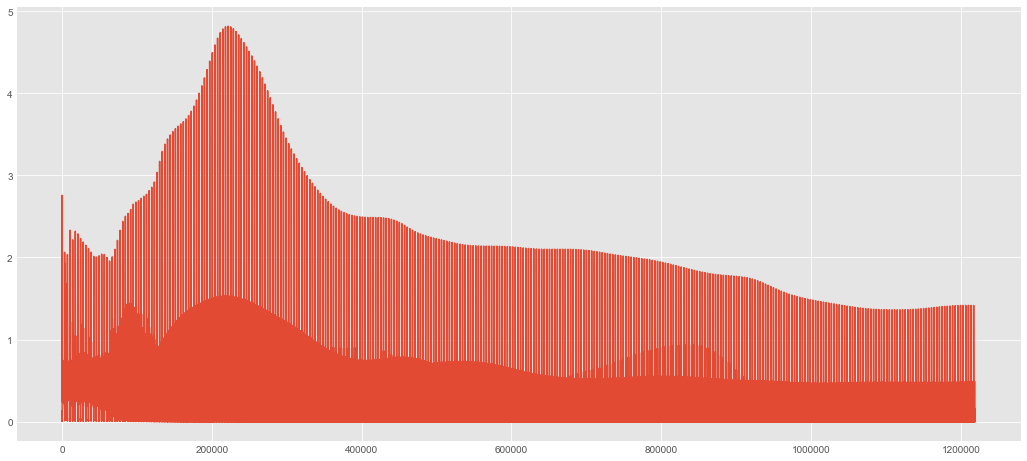

<Figure size 1296x576 with 0 Axes>

In [114]:
plt.rcParams['figure.figsize'] = (18.0, 8.0)
plt.style.use('ggplot')
plt.plot(loss_history)
fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig(f.name[:-4]+hidden+'.png', dpi = 200)

In [65]:
predictions

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [66]:
batch_labels

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [ ]:
np.mean(predictions == batch_labels)